![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [1]:
import glob
import torch

all_filenames = glob.glob('../data/names/*.txt')
print(all_filenames)

['../data/names/Dutch.txt', '../data/names/Czech.txt', '../data/names/Irish.txt', '../data/names/Scottish.txt', '../data/names/Japanese.txt', '../data/names/Vietnamese.txt', '../data/names/Arabic.txt', '../data/names/Italian.txt', '../data/names/French.txt', '../data/names/German.txt', '../data/names/Greek.txt', '../data/names/Spanish.txt', '../data/names/Chinese.txt', '../data/names/Russian.txt', '../data/names/Portuguese.txt', '../data/names/Korean.txt', '../data/names/English.txt', '../data/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [5]:


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [7]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [8]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [10]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


/data/rliaw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [11]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8039, -2.8417, -2.9446, -2.9448, -2.7726, -3.0025, -2.8613, -2.8804,
         -2.9902, -2.8825, -2.8028, -3.0001, -2.9202, -2.8136, -2.9443, -2.9576,
         -2.9128, -2.7989]], grad_fn=<LogSoftmaxBackward>)


/data/rliaw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [12]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Japanese', tensor(4))


We will also want a quick way to get a training example (a name and its language):

In [13]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Arabic / line = Nahas
category = Portuguese / line = Santiago
category = Spanish / line = Echevarria
category = Dutch / line = Bueren
category = Korean / line = Choe
category = French / line = Sauveterre
category = English / line = Oldfield
category = English / line = Swan
category = English / line = Radley
category = Korean / line = Ho


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [14]:
criterion = nn.NLLLoss()

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [16]:
from ray import tune
from ray.tune import track
import numpy as np
import random
from ray.tune.schedulers import PopulationBasedTraining

n_iters = 100000
print_every = 5000
plot_every = 1000

def evaluate(line_tensor, model):
    hidden = model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    
    return output

def test(model):
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 100

    num_correct = 0
    total = 0


    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = random_training_pair()
        output = evaluate(line_tensor, model)
        guess, guess_i = category_from_output(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
        if category_i == guess_i:
            num_correct += 1
        total += 1
    print(num_correct, total)
    return num_correct/total

def train(model, category_tensor, line_tensor, optimizer, counter):
    model.zero_grad()
    hidden = model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    if counter % print_every == 0:
        print('%d %d%% (%s)' % (counter, counter / n_iters * 100, loss.item()))
    return output, loss.item()

# def tune_train(config):
#     track.init()
#     model = RNN(n_letters, config["n_hidden"], n_categories)
#     optimizer = torch.optim.SGD(
#         model.parameters(), lr=config["lr"], momentum=config["momentum"])
#     for i in range(n_iters):
#         category, line, category_tensor, line_tensor = random_training_pair()
#         train(model,category_tensor, line_tensor, optimizer, i)
#     acc = test(model)
#     track.log(mean_accuracy=acc)
#     return {"mean_accuracy": acc}

def tune_train(config):
    track.init()
    model = RNN(n_letters, config["n_hidden"], n_categories)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["lr"])
    for i in range(n_iters):
        category, line, category_tensor, line_tensor = random_training_pair()
        train(model,category_tensor, line_tensor, optimizer, i)
    torch.save(model, '/data/rliaw/michaelc/rnn_pytorch/models/'+str(n_iters))
    acc = test(model)
    track.log(mean_accuracy=acc)
    return {"mean_accuracy": acc}

In [17]:
import ray
from ray.tune import Trainable, run
from ray.tune.schedulers import PopulationBasedTraining

search_space = {
    "lr": tune.sample_from(lambda spec: 0.0001 * random.randint(1,50)),
    "momentum": tune.uniform(0.7, 0.9),
    "n_hidden" : tune.sample_from(lambda spec: random.randint(100,300))
}

# class PBTExperiment(Trainable):
#     def _setup(self, config):
#         self.lr = config["lr"]
#         self.n_hidden = config["n_hidden"]
#         track.init()
#         self.model = RNN(n_letters, n_hidden, n_categories)
#         self.optimizer = torch.optim.Adam(
#             self.model.parameters(), lr=config["lr"])
        
#     def _train(self):
#         category, line, category_tensor, line_tensor = random_training_pair()
#         train(self.model,category_tensor, line_tensor, self.optimizer, i)
#         acc = test(self.model)
#         self.accuracy = acc
#         return {"mean_accuracy": acc}
    
#     def _save(self, checkpoint_dir):
#         return {
#             "accuracy": self.accuracy,
#             "lr": self.lr,
#             "n_hidden":self.n_hidden  
#         }
    
#     def _restore(self, checkpoint):
#         self.accuracy = checkpoint["accuracy"]
        
#     def reset_config(self, new_config):
#         self.lr = new_config["lr"]
#         self.n_hidden = new_config["n_hidden"]
#         return True
# #analysis = tune.run(tune_train, num_samples=10, config=search_space)
# #tune.run_experiments(tune_train, scheduler=pbt_scheduler)
# pbt = PopulationBasedTraining(
#     time_attr="training_iteration",
#     metric="mean_accuracy",
#     mode="max",
#     perturbation_interval=20,
#     hyperparam_mutations={
#         # distribution for resampling
#             "lr": lambda spec: 0.0001 * random.randint(1,50),
#             "n_hidden" : lambda spec: random.randint(100,300)
#     })
# run(
#     PBTExperiment,
#     name="pbt_test",
#     scheduler=pbt,
#     reuse_actors=True,
#     verbose=False,
#     **{
#         "stop": {
#             "training_iteration": 2000,
#         },
#         "num_samples": 4,
#         "config": {
#             "lr": tune.sample_from(lambda spec: 0.0001 * random.randint(1,50)),
#             "n_hidden" : tune.sample_from(lambda spec: random.randint(100,300))
#         }
#     })

class PBTExperiment(Trainable):
    def _setup(self, config):
        self.lr = config["lr"]
        self.n_hidden = config["n_hidden"]
        track.init()
        self.model = RNN(n_letters, n_hidden, n_categories)
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=config["lr"])
        
    def _train(self):
        category, line, category_tensor, line_tensor = random_training_pair()
        output, loss = train(self.model,category_tensor, line_tensor, self.optimizer, i)
        self.loss += loss
        if epoch % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            self.loss = 0
            acc = test(self.model)
            self.accuracy = acc
            return {"mean_accuracy": self.accuracy, 
                "loss": self.loss}

        return {}
    
    def _save(self, checkpoint_dir):
        return {
            "accuracy": self.accuracy,
            "lr": self.lr,
            "n_hidden":self.n_hidden, 
            "loss": self.loss
        }
    
    def _restore(self, checkpoint):
        self.accuracy = checkpoint["accuracy"]
        
    def reset_config(self, new_config):
        self.lr = new_config["lr"]
        self.n_hidden = new_config["n_hidden"]
        return True
    
pbt = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="mean_accuracy",
    mode="max",
    perturbation_interval=20,
    hyperparam_mutations={
        # distribution for resampling
            "lr": lambda: 0.0001 * random.randint(1,50),
            "n_hidden" : lambda: random.randint(100,300)
    })
analysis = run(
    PBTExperiment,
    name="pbt_test",
    scheduler=pbt,
    reuse_actors=True,
    verbose=1,
    **{
        "stop": {
            "training_iteration": 15000,
        },
        "num_samples": 4,
        "config": {
            "lr": tune.sample_from(lambda spec: 0.0001 * random.randint(1,50)),
            "n_hidden" : tune.sample_from(lambda spec: random.randint(100,300))
        }
    })

2019-09-24 03:56:46,768	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2019-09-24 03:56:46,769	INFO resource_spec.py:205 -- Starting Ray with 56.84 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).
2019-09-24 03:56:47,881	INFO services.py:446 -- Failed to connect to the redis server, retrying.
2019-09-24 03:56:48,996	INFO services.py:446 -- Failed to connect to the redis server, retrying.


== Status ==
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 55.7/251.8 GiB



/data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

== Status ==
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - PBTExperiment_1_lr=0.0033,n_hidden=244:	PENDING
 - PBTExperiment_2_lr=0.0042,n_hidden=276:	PENDING
 - PBTExperiment_3_lr=0.0015,n_hidden=227:	PENDING
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229:	RUNNING



2019-09-24 03:56:52,516	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-24 03:56:52,701	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.


(pid=16550) /data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16550)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=16550) /data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16550)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=16550) /data/rliaw/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16550)   _np_qint16 = np.dtype([("qint16", np.int16, 1)])
(pid=16550

(pid=16550) 2019-09-24 03:56:54,901	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
(pid=16550) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=16551) 2019-09-24 03:56:55,026	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
(pid=16551) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=16523) 2019-09-24 03:56:55,168	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
(pid=16523) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=16550) 2 100
(

2019-09-24 03:56:59,142	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.00396, 'n_hidden': 195}
2019-09-24 03:56:59,143	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.12) -> PBTExperiment_2_lr=0.0042,n_hidden=276 (score 0.06)


(pid=16551) 12 100
(pid=16523) 7 100
(pid=16550) 11 100
(pid=16553) 8 100
(pid=16523) 6 100
(pid=16550) 12 100
(pid=16553) 5 100
(pid=16551) 10 100
(pid=16523) 2019-09-24 03:56:59,276	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdcpbor1drestore_from_object/checkpoint_20/checkpoint
(pid=16523) 2019-09-24 03:56:59,276	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 3.607776403427124, '_episodes_total': None}
(pid=16553) 13 100
(pid=16551) 6 100
(pid=16550) 9 100
(pid=16553) 6 100
(pid=16523) 13 100
(pid=16551) 11 100
(pid=16523) 11 100
(pid=16550) 11 100
(pid=16553) 6 100
(pid=16551) 6 100
(pid=16523) 4 100
(pid=16551) 15 100
(pid=16550) 9 100
(pid=16553) 9 100
(pid=16523) 9 100
(pid=16553) 7 100
(pid=16550) 11 100
(pid=16551) 13 100
(pid=16523) 7 100
(pid=16550) 10 100
(pid=16553) 7 100
(pid=16551) 14 100
(p

2019-09-24 03:57:02,245	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244


(pid=16523) 9 100
== Status ==
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 6 s, 41 iter, 0.17 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 6 s, 40 iter, 0.06 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 6 s, 39 iter, 0.09 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 6 s, 36 iter, 0.06 acc

(pid=16553) 10 100
(pid=16551) 6 100
(pid=16550) 12 100
(pid=16523) 8 100
(pid=16551) 7 100
(pid=16553) 10 100
(pid=16523) 12 100
(pid=16550) 15 100
(pid=16551) 14 100
(pid=16550) 9 100
(pid=16553) 5 100
(pid=16523) 12 100
(pi

2019-09-24 03:57:05,233	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229


(pid=16553) 7 100
(pid=16551) 5 100
(pid=16523) 12 100
(pid=16551) 6 100
(pid=16523) 11 100
(pid=16550) 6 100
(pid=16553) 3 100
(pid=16551) 10 100
(pid=16523) 8 100
(pid=16553) 4 100
(pid=16550) 6 100
(pid=16523) 10 100
(pid=16550) 7 100
(pid=16553) 5 100
(pid=16551) 11 100
(pid=16523) 10 100
(pid=16550) 6 100
(pid=16553) 6 100
(pid=16551) 8 100
(pid=16523) 9 100
(pid=16553) 7 100
(pid=16550) 11 100


2019-09-24 03:57:06,083	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.00396, 'n_hidden': 292}
2019-09-24 03:57:06,084	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.1) -> PBTExperiment_3_lr=0.0015,n_hidden=227 (score 0.04)


(pid=16551) 5 100
(pid=16523) 8 100
(pid=16553) 4 100
(pid=16550) 11 100
(pid=16551) 14 100
(pid=16523) 8 100
(pid=16553) 2019-09-24 03:57:06,221	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpej6e65nfrestore_from_object/checkpoint_60/checkpoint
(pid=16553) 2019-09-24 03:57:06,222	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 9.425808906555176, '_episodes_total': None}
(pid=16551) 10 100
(pid=16523) 9 100
(pid=16550) 7 100
(pid=16553) 3 100
(pid=16551) 10 100
(pid=16523) 10 100
(pid=16550) 6 100
(pid=16553) 2 100
(pid=16551) 6 100
(pid=16523) 11 100
(pid=16550) 8 100
(pid=16553) 2 100
(pid=16551) 8 100
(pid=16523) 8 100
(pid=16550) 9 100
(pid=16523) 9 100
(pid=16553) 10 100
(pid=16551) 6 100
(pid=16523) 8 100
(pid=16550) 9 100
(pid=16553) 10 100
(pid=16551) 8 100
(pid=16523) 6 100
(pid=16550) 3 100
(pid=165

2019-09-24 03:57:09,473	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00396, 'n_hidden': 195} -> {'lr': 0.0031680000000000002, 'n_hidden': 156}
2019-09-24 03:57:09,474	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195] (score 0.12) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00396,n_hidden=292] (score 0.07)


(pid=16523) 5 100
(pid=16553) 7 100
(pid=16551) 12 100
(pid=16523) 9 100
(pid=16550) 13 100
(pid=16553) 2019-09-24 03:57:09,612	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpbl92co40restore_from_object/checkpoint_80/checkpoint
(pid=16553) 2019-09-24 03:57:09,613	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 11.940360069274902, '_episodes_total': None}
(pid=16523) 6 100
(pid=16550) 8 100
(pid=16523) 8 100
(pid=16550) 14 100
(pid=16551) 10 100
(pid=16553) 8 100
(pid=16523) 6 100
(pid=16550) 6 100
(pid=16551) 13 100
(pid=16523) 6 100
(pid=16550) 10 100
(pid=16553) 9 100
(pid=16551) 15 100
(pid=16523) 11 100
(pid=16550) 9 100
(pid=16553) 13 100
(pid=16551) 18 100
(pid=16523) 8 100
(pid=16553) 7 100
(pid=16550) 10 100
(pid=16551) 13 100
(pid=16523) 6 100
(pid=16553) 6 100
(pid=16551) 15 100
(pid=16550) 4 100
(p

2019-09-24 03:57:14,595	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0031680000000000002, 'n_hidden': 156} -> {'lr': 0.0038016, 'n_hidden': 103}
2019-09-24 03:57:14,596	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.003168,n_hidden=156] (score 0.11) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195] (score 0.06)


(pid=16553) 14 100
(pid=16551) 13 100
(pid=16523) 3 100
(pid=16550) 17 100
(pid=16551) 11 100
(pid=16553) 13 100
(pid=16550) 9 100
(pid=16523) 6 100
(pid=16553) 12 100
(pid=16523) 2019-09-24 03:57:14,728	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpx0f9mfcarestore_from_object/checkpoint_100/checkpoint
(pid=16523) 2019-09-24 03:57:14,728	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 14.895040512084961, '_episodes_total': None}
(pid=16551) 20 100
(pid=16550) 12 100
(pid=16553) 11 100
(pid=16551) 14 100
(pid=16523) 7 100
(pid=16550) 12 100
(pid=16553) 13 100
(pid=16551) 15 100
(pid=16523) 2 100
(pid=16550) 16 100
(pid=16551) 17 100
(pid=16523) 6 100
(pid=16553) 8 100
(pid=16550) 8 100
(pid=16523) 6 100
(pid=16553) 10 100
(pid=16550) 6 100
(pid=16551) 9 100
(pid=16523) 15 100
(pid=16553) 18 100
(pid=16523) 8

2019-09-24 03:57:18,950	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229


(pid=16553) 13 100
(pid=16550) 6 100
(pid=16551) 11 100
(pid=16523) 11 100
(pid=16550) 8 100
(pid=16553) 14 100
(pid=16551) 14 100
(pid=16523) 6 100
(pid=16553) 11 100
(pid=16551) 14 100
(pid=16550) 13 100
(pid=16523) 6 100
(pid=16553) 6 100
(pid=16551) 10 100
(pid=16523) 11 100
(pid=16550) 13 100
(pid=16553) 8 100
(pid=16550) 14 100
(pid=16551) 15 100
(pid=16523) 9 100
(pid=16553) 12 100
(pid=16523) 5 100
(pid=16550) 10 100
(pid=16553) 11 100
(pid=16551) 11 100
(pid=16523) 9 100
(pid=16550) 19 100
(pid=16551) 14 100
(pid=16523) 15 100
(pid=16553) 11 100
(pid=16551) 8 100
(pid=16550) 13 100
(pid=16523) 7 100
(pid=16553) 8 100
(pid=16551) 16 100
(pid=16523) 6 100
(pid=16550) 12 100
(pid=16553) 13 100
(pid=16551) 12 100
(pid=16523) 8 100
(pid=16550) 10 100
(pid=16553) 14 100
(pid=16551) 15 100
(pid=16553) 6 100
(pid=16550) 15 100
(pid=16551) 12 100
(pid=16523) 7 100
(pid=16553) 10 100
(pid=16523) 2 100
(pid=16550) 13 100
(pid=16551) 15 100


2019-09-24 03:57:20,810	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038016,n_hidden=103]


(pid=16553) 11 100
(pid=16550) 18 100
(pid=16551) 13 100
(pid=16523) 3 100
(pid=16553) 9 100
(pid=16550) 13 100
(pid=16551) 16 100
(pid=16523) 11 100
(pid=16553) 13 100
(pid=16523) 5 100
(pid=16550) 17 100
(pid=16553) 10 100
(pid=16551) 14 100
(pid=16523) 9 100
(pid=16551) 14 100
(pid=16550) 10 100
(pid=16553) 14 100
(pid=16523) 11 100
(pid=16550) 12 100
(pid=16551) 9 100
(pid=16553) 12 100
(pid=16523) 8 100
(pid=16550) 14 100
(pid=16551) 11 100
(pid=16553) 15 100
(pid=16551) 8 100
(pid=16523) 13 100
(pid=16550) 13 100
(pid=16553) 15 100
(pid=16551) 10 100
(pid=16523) 10 100
(pid=16550) 19 100
(pid=16553) 10 100
(pid=16523) 10 100
(pid=16550) 14 100
(pid=16551) 12 100
(pid=16553) 9 100
(pid=16523) 8 100
(pid=16551) 11 100
(pid=16550) 20 100
(pid=16553) 14 100
(pid=16551) 9 100
(pid=16523) 5 100
(pid=16553) 16 100
== Status ==
PopulationBasedTraining: 7 checkpoints, 4 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 

2019-09-24 03:57:23,868	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.0020800000000000003, 'n_hidden': 189}
2019-09-24 03:57:23,868	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.2) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038016,n_hidden=103] (score 0.02)


(pid=16553) 18 100
(pid=16551) 10 100
(pid=16523) 9 100
(pid=16553) 10 100
(pid=16551) 7 100
(pid=16523) 2 100
(pid=16550) 11 100
(pid=16553) 12 100
(pid=16551) 8 100
(pid=16523) 2019-09-24 03:57:24,008	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpyhz8vjdlrestore_from_object/checkpoint_160/checkpoint
(pid=16523) 2019-09-24 03:57:24,008	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 25.029157876968384, '_episodes_total': None}
(pid=16550) 10 100
(pid=16553) 14 100
(pid=16551) 11 100
(pid=16523) 7 100
(pid=16550) 9 100
(pid=16553) 17 100
(pid=16551) 14 100
(pid=16523) 3 100
(pid=16550) 5 100
(pid=16553) 9 100
(pid=16551) 11 100
(pid=16523) 7 100
(pid=16550) 7 100
(pid=16553) 19 100
(pid=16551) 14 100
(pid=16523) 9 100
(pid=16550) 9 100
(pid=16553) 8 100
(pid=16551) 16 100
(pid=16523) 12 100
(pid=16553) 13 1

2019-09-24 03:57:26,968	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.0020800000000000003, 'n_hidden': 274}
2019-09-24 03:57:26,969	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.18) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00208,n_hidden=189] (score 0.07)


(pid=16551) 17 100
(pid=16553) 14 100
(pid=16523) 5 100
(pid=16550) 16 100
(pid=16551) 13 100
(pid=16523) 7 100
(pid=16550) 19 100
(pid=16553) 10 100
(pid=16551) 14 100
(pid=16523) 2019-09-24 03:57:27,110	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzqk0d_rzrestore_from_object/checkpoint_180/checkpoint
(pid=16523) 2019-09-24 03:57:27,110	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 28.100499391555786, '_episodes_total': None}
(pid=16553) 15 100
(pid=16551) 10 100
(pid=16550) 13 100
(pid=16523) 4 100
(pid=16553) 16 100
(pid=16551) 13 100
(pid=16550) 19 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 8 checkpoints, 6 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/

2019-09-24 03:57:30,157	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00208,n_hidden=274]


(pid=16551) 18 100
(pid=16523) 6 100
(pid=16553) 9 100
(pid=16550) 21 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16553) 19 100
(pid=16550) 14 100
(pid=16551) 16 100
(pid=16523) 15 100
(pid=16553) 24 100
(pid=16551) 16 100
(pid=16550) 18 100
(pid=16553) 14 100
(pid=16523) 10 100
(pid=16551) 14 100
(pid=16550) 21 100
(pid=16553) 17 100
(pid=16551) 19 100
(pid=16550) 15 100
(pid=16523) 11 100
(pid=16553) 14 100
(pid=16551) 23 100
(pid=16550) 24 100
(pid=16553) 18 100
(pid=16523) 14 100
(pid=16551) 10 100
(pid=16550) 18 100
(pid=16553) 11 100
(pid=16523) 6 100
(pid=16551) 14 100
(pid=16550) 16 100
(pid=16553) 14 100
(pid=16523) 9 100
(pid=16550) 22 100
(pid=16553) 19 100
(pid=16523) 5 100
(pid=16551) 17 100
(pid=16550) 15 100
(pid=16523) 11 100
(pid=16553) 11 100
(pid=16551) 16 100
(pid=16550) 21 100
(pid=16523) 8 100
(pid=16553) 14 100
(pid=16551) 5 100
(pid=16550) 20 100
(pid=16523) 13 100
(pid=16553) 17 100
(pid=16551) 17 100
(pid=16550) 18 100
(pid=16523) 6 100
(pid=16551) 11 100
(p

2019-09-24 03:57:33,415	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.0031200000000000004, 'n_hidden': 183}
2019-09-24 03:57:33,416	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.19) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00208,n_hidden=274] (score 0.08)


(pid=16553) 11 100
(pid=16550) 18 100
(pid=16551) 17 100
(pid=16523) 15 100
(pid=16550) 24 100
(pid=16553) 12 100
(pid=16551) 16 100
(pid=16523) 8 100
(pid=16553) 13 100
(pid=16523) 2019-09-24 03:57:33,549	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpehzec4etrestore_from_object/checkpoint_220/checkpoint
(pid=16523) 2019-09-24 03:57:33,550	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 34.1480872631073, '_episodes_total': None}
(pid=16550) 24 100
(pid=16551) 15 100
(pid=16553) 12 100
(pid=16523) 11 100
(pid=16550) 18 100
(pid=16553) 11 100
(pid=16551) 13 100
(pid=16523) 7 100
(pid=16550) 17 100
(pid=16553) 11 100
(pid=16551) 13 100
(pid=16523) 9 100
(pid=16550) 15 100
(pid=16553) 7 100
(pid=16551) 19 100
(pid=16523) 9 100
(pid=16551) 19 100
(pid=16553) 15 100
(pid=16523) 7 100
(pid=16550) 29 100
(pid=16553

2019-09-24 03:57:36,680	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.005, 'n_hidden': 183}
2019-09-24 03:57:36,681	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.22) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00312,n_hidden=183] (score 0.09)


(pid=16553) 16 100
(pid=16551) 21 100
(pid=16551) 19 100
(pid=16523) 9 100
(pid=16550) 20 100
(pid=16553) 10 100
(pid=16550) 18 100
(pid=16523) 2019-09-24 03:57:36,823	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpquum_x6qrestore_from_object/checkpoint_240/checkpoint
(pid=16523) 2019-09-24 03:57:36,824	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 37.394444942474365, '_episodes_total': None}
(pid=16553) 9 100
(pid=16551) 16 100
(pid=16550) 12 100
(pid=16523) 11 100
(pid=16553) 14 100
(pid=16551) 17 100
(pid=16550) 17 100
(pid=16523) 14 100
(pid=16553) 16 100
(pid=16551) 17 100
(pid=16550) 17 100
(pid=16523) 8 100
(pid=16553) 14 100
(pid=16551) 25 100
(pid=16550) 21 100
(pid=16523) 19 100
== Status ==
PopulationBasedTraining: 12 checkpoints, 8 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 Gi

2019-09-24 03:57:40,033	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.0031200000000000004, 'n_hidden': 274}
2019-09-24 03:57:40,034	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.21) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=183] (score 0.12)


(pid=16551) 23 100
(pid=16553) 16 100
(pid=16523) 12 100
(pid=16550) 15 100
(pid=16551) 19 100
(pid=16553) 18 100
(pid=16523) 2019-09-24 03:57:40,176	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0uefa2w6restore_from_object/checkpoint_260/checkpoint
(pid=16523) 2019-09-24 03:57:40,177	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 40.534586668014526, '_episodes_total': None}
(pid=16550) 18 100
(pid=16551) 16 100
(pid=16523) 8 100
(pid=16550) 12 100
(pid=16553) 16 100
(pid=16551) 19 100
(pid=16523) 9 100
(pid=16551) 15 100
(pid=16553) 13 100
(pid=16523) 8 100
(pid=16550) 19 100
(pid=16551) 20 100
(pid=16553) 12 100
(pid=16523) 12 100
(pid=16550) 16 100
(pid=16551) 20 100
(pid=16523) 6 100
(pid=16553) 11 100
(pid=16551) 18 100
(pid=16550) 17 100
(pid=16523) 16 100
(pid=16553) 12 100
(pid=16551) 17 100
(pid=1

2019-09-24 03:57:42,029	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026000000000000003, 'n_hidden': 229} -> {'lr': 0.0032, 'n_hidden': 183}
2019-09-24 03:57:42,030	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.21) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.003168,n_hidden=156] (score 0.1)


(pid=16523) 10 100
(pid=16553) 10 100
(pid=16551) 15 100
(pid=16550) 18 100
(pid=16523) 9 100
(pid=16550) 19 100
(pid=16553) 2019-09-24 03:57:42,174	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpenkc_u8rrestore_from_object/checkpoint_260/checkpoint
(pid=16553) 2019-09-24 03:57:42,174	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 40.534586668014526, '_episodes_total': None}
(pid=16551) 26 100
(pid=16523) 12 100
(pid=16550) 20 100
(pid=16553) 19 100
(pid=16523) 2 100
(pid=16551) 21 100
(pid=16550) 24 100
(pid=16553) 14 100
(pid=16523) 10 100
== Status ==
PopulationBasedTraining: 13 checkpoints, 10 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RU

2019-09-24 03:57:43,186	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00312,n_hidden=274]


(pid=16553) 11 100
(pid=16551) 14 100
(pid=16550) 18 100
(pid=16523) 10 100
(pid=16553) 7 100
(pid=16551) 21 100
(pid=16550) 17 100
(pid=16523) 12 100
(pid=16553) 14 100
(pid=16551) 22 100
(pid=16550) 18 100
(pid=16523) 8 100
(pid=16553) 5 100
(pid=16551) 19 100
(pid=16550) 20 100
(pid=16523) 19 100
(pid=16553) 10 100
(pid=16550) 17 100
(pid=16551) 20 100
(pid=16523) 11 100
(pid=16553) 7 100
(pid=16551) 26 100
(pid=16550) 23 100
(pid=16523) 11 100
(pid=16553) 16 100
(pid=16550) 15 100
(pid=16551) 22 100
(pid=16523) 10 100
(pid=16553) 14 100
(pid=16550) 19 100
(pid=16523) 10 100
(pid=16550) 23 100
(pid=16553) 17 100
(pid=16551) 19 100
(pid=16523) 12 100
(pid=16553) 21 100
(pid=16551) 22 100
(pid=16523) 10 100
(pid=16550) 22 100
(pid=16550) 25 100
(pid=16553) 10 100
(pid=16551) 16 100
(pid=16523) 16 100
(pid=16550) 19 100
(pid=16523) 19 100
(pid=16553) 16 100
(pid=16551) 21 100
(pid=16550) 25 100
(pid=16523) 10 100
(pid=16553) 17 100
(pid=16551) 18 100
(pid=16523) 15 100
(pid=16550) 27 1

2019-09-24 03:57:46,309	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.00264, 'n_hidden': 195}
2019-09-24 03:57:46,310	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.22) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00312,n_hidden=274] (score 0.1)


(pid=16551) 34 100
(pid=16553) 9 100
(pid=16551) 24 100
(pid=16523) 10 100
(pid=16550) 24 100
(pid=16553) 11 100
(pid=16523) 2019-09-24 03:57:46,450	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp47t1e_4xrestore_from_object/checkpoint_300/checkpoint
(pid=16523) 2019-09-24 03:57:46,450	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 44.48876643180847, '_episodes_total': None}
(pid=16553) 14 100
(pid=16551) 21 100
(pid=16523) 13 100
(pid=16553) 13 100
(pid=16551) 29 100
(pid=16550) 18 100
(pid=16523) 12 100
(pid=16553) 6 100
(pid=16551) 20 100
(pid=16550) 29 100
(pid=16523) 17 100
(pid=16553) 20 100
(pid=16551) 32 100
(pid=16550) 25 100
(pid=16523) 17 100
(pid=16553) 16 100
(pid=16550) 15 100
(pid=16523) 22 100
(pid=16553) 10 100
(pid=16551) 25 100
(pid=16550) 21 100
(pid=16551) 21 100
(pid=16523) 17 100
(pid=

2019-09-24 03:57:49,565	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.00396, 'n_hidden': 195}
2019-09-24 03:57:49,565	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.26) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00264,n_hidden=195] (score 0.14)


(pid=16551) 21 100
(pid=16523) 11 100
(pid=16550) 18 100
(pid=16553) 15 100
(pid=16523) 14 100
(pid=16550) 18 100
(pid=16553) 5 100
(pid=16551) 22 100
(pid=16523) 2019-09-24 03:57:49,705	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpw17o8rh2restore_from_object/checkpoint_320/checkpoint
(pid=16523) 2019-09-24 03:57:49,705	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 47.43443822860718, '_episodes_total': None}
(pid=16553) 12 100
(pid=16550) 19 100
(pid=16551) 22 100
(pid=16523) 14 100
(pid=16553) 10 100
(pid=16551) 19 100
(pid=16550) 25 100
(pid=16523) 11 100
(pid=16550) 15 100
(pid=16553) 5 100
(pid=16551) 23 100
(pid=16523) 15 100
(pid=16550) 23 100
(pid=16551) 27 100
(pid=16553) 19 100
(pid=16523) 11 100
(pid=16551) 25 100
(pid=16550) 17 100
(pid=16553) 14 100
(pid=16523) 8 100
(pid=16551) 22 100
(pid=1

2019-09-24 03:57:52,743	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195]


(pid=16523) 24 100
== Status ==
PopulationBasedTraining: 16 checkpoints, 12 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 52 s, 336 iter, 0.11 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 51 s, 351 iter, 0.19 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 50 s, 339 iter, 0.24 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 49 s, 323 iter, 0.14 acc

(pid=16551) 19 100
(pid=16553) 11 100
(pid=16550) 16 100
(pid=16523) 12 100
(pid=16551) 23 100
(pid=16553) 15 100
(pid=16550) 20 100
(pid=16523) 21 100
(pid=16551) 17 100
(pid=16553

2019-09-24 03:57:58,679	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.00396, 'n_hidden': 292}
2019-09-24 03:57:58,680	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.18) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=195] (score 0.12)


(pid=16551) 27 100
(pid=16553) 14 100
(pid=16523) 12 100
(pid=16550) 17 100
(pid=16551) 22 100
(pid=16523) 2019-09-24 03:57:58,819	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmptxqhlc0_restore_from_object/checkpoint_380/checkpoint
(pid=16523) 2019-09-24 03:57:58,819	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 56.352747201919556, '_episodes_total': None}
(pid=16553) 15 100
(pid=16550) 18 100
(pid=16553) 18 100
(pid=16551) 13 100
(pid=16523) 24 100
(pid=16550) 15 100
(pid=16553) 19 100
(pid=16550) 18 100
(pid=16551) 25 100
(pid=16523) 19 100
(pid=16553) 22 100
(pid=16550) 16 100
(pid=16523) 13 100
(pid=16553) 19 100
(pid=16551) 27 100
(pid=16550) 23 100
(pid=16551) 18 100
(pid=16523) 21 100
(pid=16553) 17 100
(pid=16523) 18 100
(pid=16551) 20 100
(pid=16550) 24 100
(pid=16553) 14 100
(pid=16523) 22 100
(p

2019-09-24 03:58:07,008	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0032, 'n_hidden': 183} -> {'lr': 0.0007, 'n_hidden': 219}
2019-09-24 03:58:07,010	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183] (score 0.26) -> PBTExperiment_0_lr=0.0026,n_hidden=229 (score 0.17)


(pid=16523) 15 100
(pid=16550) 16 100
(pid=16553) 23 100
(pid=16551) 17 100
(pid=16523) 23 100
(pid=16550) 17 100
(pid=16553) 25 100
(pid=16551) 15 100
(pid=16550) 2019-09-24 03:58:07,139	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp199fmbnnrestore_from_object/checkpoint_400/checkpoint
(pid=16550) 2019-09-24 03:58:07,140	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 61.253766775131226, '_episodes_total': None}
(pid=16523) 16 100
(pid=16553) 18 100
(pid=16551) 12 100
(pid=16523) 19 100
(pid=16550) 19 100
(pid=16553) 21 100
(pid=16523) 14 100
(pid=16553) 29 100
(pid=16551) 17 100
(pid=16550) 12 100
(pid=16523) 19 100
(pid=16551) 21 100
(pid=16550) 18 100
(pid=16553) 20 100
== Status ==
PopulationBasedTraining: 23 checkpoints, 14 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.

2019-09-24 03:58:10,668	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00396, 'n_hidden': 292} -> {'lr': 0.004752, 'n_hidden': 233}
2019-09-24 03:58:10,669	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=292] (score 0.24) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0007,n_hidden=219] (score 0.17)


(pid=16553) 16 100
(pid=16551) 22 100
(pid=16550) 20 100
(pid=16523) 20 100
(pid=16553) 18 100
(pid=16550) 17 100
(pid=16551) 19 100
(pid=16523) 22 100
(pid=16550) 2019-09-24 03:58:10,808	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpwwatqc1zrestore_from_object/checkpoint_440/checkpoint
(pid=16550) 2019-09-24 03:58:10,808	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 64.86832237243652, '_episodes_total': None}
(pid=16551) 17 100
(pid=16523) 21 100
(pid=16553) 19 100
(pid=16523) 27 100
(pid=16550) 17 100
(pid=16553) 25 100
(pid=16551) 20 100
(pid=16551) 17 100
(pid=16523) 25 100
(pid=16550) 24 100
(pid=16553) 28 100
(pid=16523) 24 100
(pid=16551) 18 100
(pid=16550) 17 100
(pid=16523) 20 100
(pid=16550) 26 100
(pid=16553) 12 100
(pid=16551) 23 100
(pid=16551) 23 100
(pid=16523) 17 100
(pid=16550) 20 100
(pi

2019-09-24 03:58:14,226	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0032, 'n_hidden': 183} -> {'lr': 0.00256, 'n_hidden': 162}
2019-09-24 03:58:14,227	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183] (score 0.28) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.004752,n_hidden=233] (score 0.21)


(pid=16553) 17 100
(pid=16551) 23 100
(pid=16550) 21 100
(pid=16523) 16 100
(pid=16553) 22 100
(pid=16551) 22 100
(pid=16550) 2019-09-24 03:58:14,370	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpz6l8rjcwrestore_from_object/checkpoint_440/checkpoint
(pid=16550) 2019-09-24 03:58:14,370	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 67.1012933254242, '_episodes_total': None}
(pid=16523) 22 100
(pid=16553) 16 100
(pid=16551) 23 100
(pid=16550) 14 100


2019-09-24 03:58:14,647	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183]


(pid=16551) 20 100
(pid=16523) 21 100
(pid=16553) 15 100
(pid=16553) 12 100
(pid=16551) 10 100
(pid=16550) 17 100
(pid=16523) 23 100
(pid=16551) 17 100
(pid=16550) 22 100
(pid=16553) 14 100
(pid=16551) 18 100
(pid=16553) 12 100
(pid=16523) 13 100
(pid=16550) 15 100
(pid=16551) 17 100
(pid=16523) 19 100
(pid=16553) 20 100
(pid=16551) 23 100
(pid=16550) 18 100
(pid=16523) 19 100
(pid=16553) 19 100
(pid=16551) 17 100
(pid=16523) 20 100
(pid=16550) 14 100
(pid=16553) 28 100
(pid=16523) 15 100
(pid=16551) 14 100
(pid=16553) 18 100
(pid=16523) 19 100
(pid=16550) 14 100
(pid=16551) 12 100
(pid=16523) 17 100
(pid=16553) 21 100
(pid=16551) 19 100
(pid=16550) 18 100
(pid=16553) 23 100
(pid=16523) 23 100
(pid=16551) 21 100
(pid=16550) 21 100
(pid=16523) 22 100
(pid=16553) 17 100
(pid=16551) 24 100
(pid=16550) 13 100
(pid=16553) 22 100
(pid=16523) 20 100
(pid=16551) 18 100
(pid=16550) 17 100
(pid=16553) 22 100
(pid=16523) 21 100
(pid=16551) 14 100
(pid=16550) 12 100
(pid=16553) 19 100
(pid=16551) 

2019-09-24 03:58:17,947	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0032, 'n_hidden': 183} -> {'lr': 0.00256, 'n_hidden': 219}
2019-09-24 03:58:17,948	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183] (score 0.27) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=292] (score 0.12)


(pid=16551) 21 100
(pid=16550) 27 100
== Status ==
PopulationBasedTraining: 26 checkpoints, 16 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00256,n_hidden=162]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 70 s, 458 iter, 0.27 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 74 s, 504 iter, 0.21 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00396,n_hidden=292]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 73 s, 499 iter, 0.22 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 72 s, 479 iter, 0.18 acc

(pid=16553) 27 100
(pid=16551) 9 100
(pid=16523) 22 100
(pid=16550) 22 100
(pid=16523) 12 100
(pid=16551) 14 100
(pid=16550) 16

2019-09-24 03:58:21,277	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033, 'n_hidden': 244} -> {'lr': 0.0033, 'n_hidden': 189}
2019-09-24 03:58:21,279	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.31) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032,n_hidden=183] (score 0.11)


(pid=16523) 17 100
(pid=16550) 27 100
(pid=16553) 14 100
(pid=16551) 24 100
(pid=16550) 25 100
(pid=16523) 12 100
(pid=16553) 11 100
(pid=16551) 34 100
(pid=16553) 2019-09-24 03:58:21,409	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpa76eu3h0restore_from_object/checkpoint_520/checkpoint
(pid=16553) 2019-09-24 03:58:21,410	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 76.92868852615356, '_episodes_total': None}
(pid=16523) 15 100
(pid=16550) 28 100
(pid=16551) 20 100
(pid=16523) 17 100
(pid=16550) 21 100
(pid=16553) 17 100
(pid=16551) 26 100
(pid=16523) 19 100
(pid=16553) 19 100
(pid=16550) 26 100
(pid=16551) 33 100
(pid=16523) 21 100
(pid=16553) 10 100
(pid=16551) 25 100
(pid=16523) 20 100
(pid=16550) 16 100
(pid=16553) 21 100
(pid=16551) 31 100
(pid=16523) 22 100
(pid=16550) 22 100
(pid=16551) 24 100
(pi

2019-09-24 03:58:24,674	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00256,n_hidden=162]


(pid=16550) 14 100
(pid=16553) 21 100
(pid=16523) 25 100
(pid=16551) 28 100
(pid=16550) 13 100
(pid=16553) 17 100
(pid=16523) 22 100
(pid=16551) 27 100
(pid=16550) 9 100
(pid=16553) 13 100
(pid=16551) 18 100
(pid=16523) 23 100
(pid=16550) 15 100
(pid=16553) 14 100
(pid=16523) 22 100
(pid=16551) 22 100
(pid=16553) 17 100
(pid=16550) 13 100
(pid=16523) 20 100
(pid=16551) 19 100
(pid=16553) 19 100
(pid=16523) 20 100
(pid=16550) 13 100
(pid=16551) 20 100
(pid=16553) 19 100
(pid=16523) 23 100
(pid=16550) 18 100
(pid=16551) 16 100
(pid=16523) 24 100
(pid=16553) 22 100
(pid=16550) 15 100
(pid=16551) 25 100
(pid=16523) 20 100
(pid=16550) 18 100
(pid=16553) 19 100
(pid=16551) 24 100
(pid=16523) 20 100
(pid=16553) 17 100
(pid=16550) 15 100
(pid=16551) 18 100
(pid=16523) 21 100
(pid=16553) 22 100
(pid=16550) 20 100
(pid=16551) 32 100
(pid=16523) 22 100
(pid=16553) 20 100
(pid=16551) 26 100
(pid=16523) 14 100
(pid=16550) 22 100
(pid=16553) 22 100
(pid=16523) 18 100
(pid=16551) 15 100
(pid=16550) 2

2019-09-24 03:58:30,321	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244


(pid=16553) 24 100
(pid=16551) 23 100
(pid=16523) 21 100
(pid=16550) 33 100
(pid=16553) 16 100
(pid=16551) 16 100
(pid=16523) 24 100
(pid=16550) 24 100
(pid=16553) 23 100
(pid=16551) 18 100
(pid=16523) 18 100
(pid=16550) 21 100
(pid=16553) 17 100
(pid=16551) 24 100
(pid=16523) 26 100
(pid=16550) 23 100
(pid=16553) 27 100
(pid=16523) 19 100
(pid=16551) 23 100
(pid=16550) 25 100
(pid=16553) 28 100
(pid=16523) 23 100
(pid=16551) 27 100
(pid=16550) 26 100
(pid=16553) 22 100
(pid=16523) 20 100
(pid=16551) 22 100
(pid=16550) 22 100
(pid=16553) 23 100
(pid=16523) 16 100
(pid=16553) 18 100
(pid=16551) 20 100
(pid=16523) 24 100
(pid=16550) 27 100
(pid=16553) 23 100
(pid=16551) 18 100
(pid=16523) 16 100
(pid=16550) 21 100
(pid=16553) 22 100
(pid=16523) 22 100
(pid=16551) 15 100
(pid=16550) 26 100
(pid=16553) 26 100
(pid=16551) 16 100
(pid=16523) 18 100
(pid=16550) 22 100
(pid=16553) 24 100
(pid=16551) 19 100
(pid=16523) 22 100
(pid=16550) 28 100
(pid=16553) 17 100
(pid=16551) 16 100
(pid=16550) 

2019-09-24 03:58:33,718	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00256, 'n_hidden': 219} -> {'lr': 0.003072, 'n_hidden': 262}
2019-09-24 03:58:33,719	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00256,n_hidden=219] (score 0.28) -> PBTExperiment_1_lr=0.0033,n_hidden=244 (score 0.16)


(pid=16553) 22 100
(pid=16551) 14 100
(pid=16550) 23 100
(pid=16553) 23 100
(pid=16551) 16 100
(pid=16523) 20 100
(pid=16550) 22 100
(pid=16553) 16 100
(pid=16551) 2019-09-24 03:58:33,858	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpv381h6u8restore_from_object/checkpoint_580/checkpoint
(pid=16551) 2019-09-24 03:58:33,858	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 87.20924973487854, '_episodes_total': None}
(pid=16523) 20 100
(pid=16550) 33 100
(pid=16553) 26 100
(pid=16551) 17 100
(pid=16523) 19 100
(pid=16551) 17 100
(pid=16550) 22 100
(pid=16553) 15 100
(pid=16523) 16 100
(pid=16553) 25 100
(pid=16551) 22 100
(pid=16550) 23 100
(pid=16523) 19 100
(pid=16553) 21 100
(pid=16550) 26 100
(pid=16551) 18 100
(pid=16523) 17 100
(pid=16553) 23 100
(pid=16550) 13 100
(pid=16551) 23 100
(pid=16523) 11 100
(pi

2019-09-24 03:58:37,531	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00256, 'n_hidden': 219} -> {'lr': 0.0029000000000000002, 'n_hidden': 233}
2019-09-24 03:58:37,532	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00256,n_hidden=219] (score 0.27) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033,n_hidden=189] (score 0.2)


(pid=16553) 18 100
(pid=16523) 21 100
(pid=16551) 28 100
(pid=16550) 20 100
(pid=16551) 22 100
(pid=16523) 24 100
(pid=16553) 20 100
(pid=16523) 15 100
(pid=16553) 2019-09-24 03:58:37,664	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpqlv921sarestore_from_object/checkpoint_600/checkpoint
(pid=16553) 2019-09-24 03:58:37,664	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 89.99673199653625, '_episodes_total': None}
(pid=16551) 34 100
(pid=16550) 22 100


2019-09-24 03:58:37,922	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00256, 'n_hidden': 219} -> {'lr': 0.003072, 'n_hidden': 262}
2019-09-24 03:58:37,924	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00256,n_hidden=219] (score 0.27) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00256,n_hidden=162] (score 0.16)


(pid=16551) 30 100
(pid=16523) 20 100
(pid=16550) 19 100
== Status ==
PopulationBasedTraining: 31 checkpoints, 20 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00256,n_hidden=162]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 88 s, 579 iter, 0.19 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003072,n_hidden=262]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 90 s, 606 iter, 0.3 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00256,n_hidden=219]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 90 s, 607 iter, 0.2 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0029,n_hidden=233]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 90 s, 601 iter, 0.26 acc

(pid=16553) 26 100
(pid=16523) 16 100
(pid=16551) 25 100
(pid=16550) 16 10

2019-09-24 03:58:44,954	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.003072, 'n_hidden': 262} -> {'lr': 0.0024576000000000003, 'n_hidden': 314}
2019-09-24 03:58:44,956	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003072,n_hidden=262] (score 0.28) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.003072,n_hidden=262] (score 0.2)


(pid=16553) 27 100
(pid=16551) 32 100
(pid=16523) 23 100
(pid=16550) 25 100
(pid=16553) 20 100
(pid=16551) 24 100
(pid=16523) 14 100
(pid=16550) 20 100
(pid=16550) 2019-09-24 03:58:45,098	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpzen7j5zcrestore_from_object/checkpoint_640/checkpoint
(pid=16550) 2019-09-24 03:58:45,098	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 96.05971169471741, '_episodes_total': None}
(pid=16553) 23 100
(pid=16551) 34 100
(pid=16523) 26 100
(pid=16550) 28 100
(pid=16553) 26 100
(pid=16551) 25 100
(pid=16523) 14 100


2019-09-24 03:58:45,643	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.003072, 'n_hidden': 262} -> {'lr': 0.0036864, 'n_hidden': 209}
2019-09-24 03:58:45,644	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003072,n_hidden=262] (score 0.28) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00256,n_hidden=219] (score 0.16)


(pid=16553) 18 100
(pid=16551) 32 100
(pid=16523) 21 100
(pid=16550) 21 100
(pid=16523) 16 100
(pid=16551) 25 100
(pid=16550) 23 100
(pid=16553) 20 100
(pid=16523) 2019-09-24 03:58:45,786	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5z45qqwfrestore_from_object/checkpoint_640/checkpoint
(pid=16523) 2019-09-24 03:58:45,786	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 96.05971169471741, '_episodes_total': None}
(pid=16551) 27 100
(pid=16553) 22 100
(pid=16523) 12 100
(pid=16550) 25 100
(pid=16551) 25 100
(pid=16553) 26 100
(pid=16550) 26 100
(pid=16523) 28 100
(pid=16551) 24 100
(pid=16550) 27 100
(pid=16553) 26 100
(pid=16523) 20 100
(pid=16551) 26 100
(pid=16550) 20 100
(pid=16553) 23 100
(pid=16523) 16 100
(pid=16551) 27 100
(pid=16550) 20 100
(pid=16553) 29 100
(pid=16523) 27 100
(pid=16551) 25 100
(pi

2019-09-24 03:58:50,107	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0024576000000000003, 'n_hidden': 314} -> {'lr': 0.0019660800000000003, 'n_hidden': 173}
2019-09-24 03:58:50,108	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0024576,n_hidden=314] (score 0.3) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003072,n_hidden=262] (score 0.18)


(pid=16550) 27 100
(pid=16523) 22 100
(pid=16551) 18 100
(pid=16550) 20 100
(pid=16553) 30 100
(pid=16523) 29 100
(pid=16551) 2019-09-24 03:58:50,244	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpzvneweo_restore_from_object/checkpoint_660/checkpoint
(pid=16551) 2019-09-24 03:58:50,245	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 99.22698903083801, '_episodes_total': None}
(pid=16550) 21 100
(pid=16553) 14 100
(pid=16523) 31 100
(pid=16551) 31 100
(pid=16550) 21 100
(pid=16553) 23 100
(pid=16551) 25 100
(pid=16523) 26 100
(pid=16550) 19 100
(pid=16553) 16 100
(pid=16523) 13 100
(pid=16550) 20 100
(pid=16553) 11 100
(pid=16551) 29 100
(pid=16523) 21 100
(pid=16550) 24 100
(pid=16553) 11 100
(pid=16551) 30 100
(pid=16523) 21 100
(pid=16551) 22 100
(pid=16550) 23 100
(pid=16553) 22 100
(pid=16523) 29 100
(pi

2019-09-24 03:58:58,306	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 233} -> {'lr': 0.00348, 'n_hidden': 181}
2019-09-24 03:58:58,307	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0029,n_hidden=233] (score 0.27) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0036864,n_hidden=209] (score 0.19)


(pid=16553) 25 100
(pid=16523) 24 100
(pid=16550) 19 100
(pid=16551) 22 100
(pid=16523) 19 100
(pid=16553) 24 100
(pid=16551) 25 100
(pid=16523) 2019-09-24 03:58:58,448	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpclc6r18crestore_from_object/checkpoint_720/checkpoint
(pid=16523) 2019-09-24 03:58:58,448	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 108.46242260932922, '_episodes_total': None}
(pid=16550) 24 100
(pid=16553) 18 100
(pid=16551) 18 100
(pid=16523) 27 100
(pid=16550) 23 100
(pid=16553) 19 100
(pid=16551) 20 100
(pid=16523) 18 100
(pid=16553) 20 100
(pid=16550) 19 100
(pid=16551) 28 100
(pid=16523) 15 100
(pid=16553) 24 100
(pid=16550) 25 100
(pid=16553) 29 100
(pid=16551) 25 100
(pid=16523) 22 100
(pid=16523) 23 100
(pid=16550) 23 100
(pid=16553) 21 100
(pid=16551) 20 100
(pid=16523) 17 100
(p

2019-09-24 03:59:04,758	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019660800000000003, 'n_hidden': 173} -> {'lr': 0.0015728640000000002, 'n_hidden': 138}
2019-09-24 03:59:04,759	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=181] (score 0.25)


(pid=16551) 25 100
(pid=16550) 32 100
(pid=16553) 28 100
(pid=16523) 25 100
(pid=16551) 22 100
(pid=16523) 2019-09-24 03:59:04,892	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpb9j8m3x7restore_from_object/checkpoint_740/checkpoint
(pid=16523) 2019-09-24 03:59:04,892	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 111.07905888557434, '_episodes_total': None}
(pid=16550) 25 100
(pid=16553) 28 100
(pid=16551) 29 100
(pid=16550) 24 100
(pid=16553) 20 100
(pid=16523) 21 100
(pid=16551) 25 100
(pid=16550) 21 100
(pid=16551) 22 100
(pid=16553) 31 100
(pid=16523) 21 100
(pid=16550) 25 100
(pid=16551) 27 100
(pid=16550) 30 100
(pid=16553) 20 100
(pid=16551) 23 100
(pid=16523) 23 100
(pid=16550) 27 100
(pid=16553) 20 100
(pid=16551) 18 100
(pid=16523) 25 100
(pid=16523) 30 100
(pid=16550) 21 100
(pid=16553) 23 100
(p

2019-09-24 03:59:06,167	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019660800000000003, 'n_hidden': 173} -> {'lr': 0.0032, 'n_hidden': 138}
2019-09-24 03:59:06,168	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173] (score 0.39) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0024576,n_hidden=314] (score 0.24)


(pid=16551) 21 100
(pid=16550) 23 100
(pid=16523) 19 100
(pid=16553) 17 100
(pid=16550) 24 100
(pid=16551) 26 100
(pid=16553) 28 100
(pid=16523) 23 100
(pid=16550) 2019-09-24 03:59:06,307	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpf9_i46u3restore_from_object/checkpoint_740/checkpoint
(pid=16550) 2019-09-24 03:59:06,307	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 111.07905888557434, '_episodes_total': None}
(pid=16523) 19 100
(pid=16553) 30 100
(pid=16551) 19 100


2019-09-24 03:59:06,571	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173]


(pid=16550) 23 100
(pid=16553) 30 100
(pid=16523) 20 100
(pid=16551) 19 100
(pid=16523) 22 100
(pid=16550) 21 100
(pid=16553) 24 100
(pid=16551) 20 100
(pid=16523) 28 100
(pid=16550) 20 100
(pid=16553) 20 100
(pid=16551) 23 100
(pid=16523) 21 100
(pid=16550) 22 100
(pid=16553) 27 100
(pid=16551) 25 100
(pid=16523) 28 100
(pid=16553) 22 100
(pid=16550) 21 100
(pid=16551) 30 100
(pid=16523) 33 100
(pid=16550) 18 100
(pid=16553) 32 100
(pid=16551) 26 100
(pid=16523) 26 100
(pid=16553) 23 100
(pid=16550) 16 100
(pid=16551) 34 100
(pid=16553) 26 100
(pid=16523) 25 100
(pid=16550) 14 100
(pid=16551) 25 100
(pid=16523) 22 100
(pid=16551) 31 100
(pid=16550) 18 100
(pid=16523) 25 100
(pid=16553) 24 100
(pid=16551) 23 100
(pid=16550) 17 100
(pid=16553) 25 100
(pid=16523) 28 100
== Status ==
PopulationBasedTraining: 42 checkpoints, 27 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rli

2019-09-24 03:59:09,787	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019660800000000003, 'n_hidden': 173} -> {'lr': 0.0037, 'n_hidden': 138}
2019-09-24 03:59:09,788	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173] (score 0.3) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0032,n_hidden=138] (score 0.21)


(pid=16523) 36 100
(pid=16553) 20 100
(pid=16551) 30 100
(pid=16550) 21 100
(pid=16553) 19 100
(pid=16523) 28 100
(pid=16550) 2019-09-24 03:59:09,995	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpxqleqi6arestore_from_object/checkpoint_780/checkpoint
(pid=16550) 2019-09-24 03:59:09,995	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 116.83633589744568, '_episodes_total': None}
(pid=16553) 22 100
(pid=16551) 25 100
(pid=16523) 31 100
(pid=16553) 18 100
(pid=16551) 23 100
(pid=16523) 31 100
(pid=16550) 22 100
(pid=16553) 22 100
(pid=16551) 29 100
(pid=16523) 29 100
(pid=16550) 27 100
(pid=16550) 25 100
(pid=16553) 23 100
(pid=16551) 29 100
(pid=16523) 23 100
(pid=16523) 28 100
(pid=16550) 18 100
(pid=16553) 20 100
(pid=16551) 25 100
(pid=16553) 21 100
(pid=16551) 24 100
(pid=16523) 23 100
(pid=16550) 29 100
(p

2019-09-24 03:59:16,182	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173]


(pid=16551) 22 100
(pid=16553) 24 100
(pid=16523) 20 100
(pid=16550) 20 100
(pid=16553) 24 100
(pid=16551) 24 100
(pid=16523) 27 100
(pid=16550) 24 100
(pid=16553) 21 100
(pid=16551) 31 100
(pid=16523) 24 100
(pid=16550) 29 100


2019-09-24 03:59:16,770	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138]


(pid=16553) 16 100
(pid=16551) 26 100
(pid=16523) 27 100
(pid=16550) 22 100
(pid=16553) 20 100
(pid=16551) 34 100
(pid=16523) 26 100
(pid=16553) 31 100
(pid=16550) 19 100
(pid=16551) 14 100


2019-09-24 03:59:17,176	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0029,n_hidden=233]


(pid=16523) 28 100
(pid=16553) 17 100
(pid=16550) 17 100
(pid=16523) 25 100
(pid=16551) 28 100
(pid=16550) 22 100
(pid=16553) 24 100
(pid=16523) 25 100
(pid=16551) 33 100
(pid=16553) 20 100
(pid=16550) 25 100
(pid=16523) 17 100
(pid=16553) 22 100
(pid=16551) 33 100
(pid=16523) 31 100
(pid=16550) 19 100
(pid=16551) 21 100
(pid=16553) 26 100
(pid=16523) 28 100
(pid=16551) 18 100
(pid=16550) 33 100
(pid=16553) 23 100
(pid=16550) 31 100
(pid=16551) 19 100
== Status ==
PopulationBasedTraining: 44 checkpoints, 28 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 124 s, 827 iter, 0.31 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173]:	RUNNING, [1 CPUs, 0 GPU

2019-09-24 03:59:24,049	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0037, 'n_hidden': 138} -> {'lr': 0.00444, 'n_hidden': 110}
2019-09-24 03:59:24,050	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138] (score 0.34) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0029,n_hidden=233] (score 0.29)


(pid=16553) 29 100
(pid=16551) 34 100
(pid=16523) 29 100
(pid=16550) 24 100
(pid=16553) 2019-09-24 03:59:24,168	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpsm2rkkfzrestore_from_object/checkpoint_860/checkpoint
(pid=16553) 2019-09-24 03:59:24,168	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 129.6300914287567, '_episodes_total': None}
(pid=16523) 26 100
(pid=16551) 31 100
(pid=16523) 23 100
(pid=16550) 32 100
(pid=16553) 26 100
(pid=16551) 36 100


2019-09-24 03:59:24,493	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0037, 'n_hidden': 138} -> {'lr': 0.0029600000000000004, 'n_hidden': 165}
2019-09-24 03:59:24,494	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0015729,n_hidden=138] (score 0.29)


(pid=16523) 29 100
(pid=16553) 26 100
(pid=16550) 26 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 03:59:24,618	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3qk5fv3urestore_from_object/checkpoint_860/checkpoint
(pid=16523) 2019-09-24 03:59:24,618	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 129.6300914287567, '_episodes_total': None}
(pid=16551) 30 100
(pid=16550) 30 100
(pid=16553) 25 100
(pid=16523) 26 100
(pid=16553) 30 100
(pid=16551) 42 100
(pid=16550) 27 100
(pid=16551) 33 100
(pid=16523) 20 100
(pid=16553) 26 100
(pid=16550) 29 100
(pid=16550) 25 100
(pid=16553) 32 100
(pid=16551) 24 100
(pid=16523) 41 100
(pid=16550) 29 100
(pid=16553) 31 100
(pid=16551) 31 100
(pid=16523) 25 100
(pid=16550) 24 100
(pid=16553) 25 100
(pid=16551) 37 100
(pid=16523) 26 100


2019-09-24 03:59:25,870	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0037, 'n_hidden': 138} -> {'lr': 0.00444, 'n_hidden': 165}
2019-09-24 03:59:25,871	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138] (score 0.34) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019661,n_hidden=173] (score 0.29)


(pid=16550) 22 100
(pid=16553) 30 100
(pid=16551) 40 100
(pid=16523) 24 100
(pid=16553) 28 100
(pid=16523) 21 100
(pid=16550) 30 100
(pid=16551) 29 100
(pid=16551) 2019-09-24 03:59:25,998	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp28m9tcecrestore_from_object/checkpoint_860/checkpoint
(pid=16551) 2019-09-24 03:59:25,998	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 129.6300914287567, '_episodes_total': None}
(pid=16523) 20 100
(pid=16550) 22 100
(pid=16553) 34 100
(pid=16523) 24 100
(pid=16550) 21 100
(pid=16553) 30 100
(pid=16551) 40 100
(pid=16553) 32 100
(pid=16523) 20 100
(pid=16550) 31 100
(pid=16551) 31 100
(pid=16553) 26 100
(pid=16523) 27 100
(pid=16550) 27 100
(pid=16551) 22 100
(pid=16523) 30 100
(pid=16550) 34 100
(pid=16553) 30 100
(pid=16551) 38 100
(pid=16523) 34 100
(pid=16550) 22 100
(pi

2019-09-24 03:59:27,335	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138]


(pid=16553) 28 100
(pid=16523) 22 100
(pid=16551) 34 100
(pid=16550) 25 100
(pid=16553) 29 100
(pid=16551) 23 100
(pid=16523) 25 100
(pid=16553) 25 100
(pid=16550) 19 100
(pid=16551) 35 100
(pid=16523) 31 100
(pid=16553) 17 100
(pid=16551) 27 100
(pid=16523) 28 100
(pid=16550) 21 100
(pid=16553) 22 100
(pid=16551) 33 100
(pid=16523) 25 100
(pid=16550) 25 100
(pid=16553) 26 100
(pid=16551) 29 100
(pid=16523) 28 100
(pid=16550) 18 100
(pid=16553) 22 100
(pid=16523) 23 100
(pid=16551) 28 100
== Status ==
PopulationBasedTraining: 47 checkpoints, 31 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 133 s, 884 iter, 0.18 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00444,n_

2019-09-24 03:59:30,753	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00444, 'n_hidden': 110} -> {'lr': 0.0035520000000000005, 'n_hidden': 88}
2019-09-24 03:59:30,753	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00444,n_hidden=110] (score 0.32) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=138] (score 0.25)
2019-09-24 03:59:30,982	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00444, 'n_hidden': 110} -> {'lr': 0.0035520000000000005, 'n_hidden': 139}
2019-09-24 03:59:30,983	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00444,n_hidden=110] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00296,n_hidden=165] (score 0.2)


(pid=16550) 25 100
(pid=16551) 36 100
(pid=16523) 21 100
(pid=16550) 2019-09-24 03:59:30,888	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp60hzuxhhrestore_from_object/checkpoint_900/checkpoint
(pid=16550) 2019-09-24 03:59:30,889	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 135.54790830612183, '_episodes_total': None}
(pid=16553) 26 100
(pid=16551) 35 100
(pid=16523) 20 100
(pid=16550) 28 100
(pid=16553) 21 100
(pid=16523) 2019-09-24 03:59:31,117	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6pt_v77krestore_from_object/checkpoint_900/checkpoint
(pid=16523) 2019-09-24 03:59:31,117	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total':

2019-09-24 03:59:37,720	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0025, 'n_hidden': 111}
2019-09-24 03:59:37,722	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.003552,n_hidden=88] (score 0.21)


(pid=16553) 28 100
(pid=16551) 33 100
(pid=16550) 21 100
(pid=16523) 38 100
(pid=16553) 21 100
(pid=16551) 31 100
(pid=16550) 2019-09-24 03:59:37,854	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpx6qmxj0crestore_from_object/checkpoint_940/checkpoint
(pid=16550) 2019-09-24 03:59:37,854	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 141.18055844306946, '_episodes_total': None}
(pid=16553) 26 100
(pid=16551) 26 100
(pid=16523) 30 100
(pid=16550) 26 100
(pid=16553) 24 100
(pid=16551) 24 100
(pid=16523) 31 100
(pid=16550) 19 100
(pid=16553) 28 100
(pid=16523) 30 100
(pid=16551) 29 100
== Status ==
PopulationBasedTraining: 51 checkpoints, 34 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_re

2019-09-24 03:59:43,664	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0019, 'n_hidden': 166}
2019-09-24 03:59:43,665	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.31) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00444,n_hidden=110] (score 0.21)


(pid=16553) 36 100
(pid=16551) 25 100
(pid=16550) 21 100
(pid=16523) 25 100
(pid=16553) 21 100
(pid=16551) 22 100
(pid=16523) 23 100
(pid=16550) 27 100
(pid=16553) 2019-09-24 03:59:43,795	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmp3ufwrd15restore_from_object/checkpoint_960/checkpoint
(pid=16553) 2019-09-24 03:59:43,795	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 144.04383420944214, '_episodes_total': None}
(pid=16551) 14 100
(pid=16523) 24 100
(pid=16550) 31 100
(pid=16551) 24 100
(pid=16553) 24 100
(pid=16550) 28 100
(pid=16551) 24 100
(pid=16523) 27 100
(pid=16553) 19 100
(pid=16550) 22 100
(pid=16551) 16 100
(pid=16553) 23 100
(pid=16523) 31 100
(pid=16550) 24 100
(pid=16551) 12 100
(pid=16523) 29 100
(pid=16553) 26 100
(pid=16551) 13 100
(pid=16550) 25 100
(pid=16523) 24 100
(pid=16553) 32 100
(p

2019-09-24 03:59:45,732	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 166}
2019-09-24 03:59:45,733	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.27) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00444,n_hidden=165] (score 0.17)


(pid=16551) 20 100
(pid=16523) 26 100
(pid=16550) 30 100
(pid=16553) 28 100
(pid=16551) 17 100
(pid=16523) 25 100
(pid=16550) 32 100
(pid=16553) 31 100
(pid=16551) 2019-09-24 03:59:45,860	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpss7cbtkbrestore_from_object/checkpoint_980/checkpoint
(pid=16551) 2019-09-24 03:59:45,861	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 147.04283142089844, '_episodes_total': None}
(pid=16523) 30 100
(pid=16550) 25 100
(pid=16553) 28 100
(pid=16551) 18 100
(pid=16523) 34 100
(pid=16550) 30 100
(pid=16553) 23 100
(pid=16551) 16 100
(pid=16553) 24 100
(pid=16523) 28 100
(pid=16550) 18 100
(pid=16551) 15 100
(pid=16523) 26 100
(pid=16553) 28 100
(pid=16550) 27 100
(pid=16551) 16 100
(pid=16523) 27 100
(pid=16553) 28 100
(pid=16550) 35 100
(pid=16551) 12 100
(pid=16523) 27 100
(p

2019-09-24 03:59:49,335	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 03:59:49,336	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.3) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166] (score 0.07)


(pid=16551) 12 100
(pid=16523) 30 100
(pid=16553) 31 100
(pid=16550) 15 100
(pid=16523) 27 100
(pid=16551) 7 100
(pid=16553) 28 100
(pid=16550) 20 100
(pid=16551) 2019-09-24 03:59:49,468	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp5qd6p4g8restore_from_object/checkpoint_1000/checkpoint
(pid=16551) 2019-09-24 03:59:49,468	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 149.94024467468262, '_episodes_total': None}
(pid=16523) 20 100
(pid=16553) 23 100
(pid=16550) 17 100
(pid=16523) 34 100
(pid=16553) 28 100
(pid=16551) 9 100
(pid=16523) 34 100
(pid=16550) 24 100
(pid=16551) 11 100
(pid=16553) 33 100
(pid=16523) 34 100
(pid=16550) 19 100
(pid=16551) 6 100
(pid=16550) 25 100
(pid=16553) 31 100
(pid=16523) 31 100
(pid=16551) 8 100
(pid=16553) 25 100
(pid=16550) 26 100
(pid=16551) 13 100
(pid=16523) 25 100
(pid

2019-09-24 03:59:52,645	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 03:59:52,646	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.03)


(pid=16553) 25 100
(pid=16523) 40 100
(pid=16551) 2 100
(pid=16550) 21 100
(pid=16553) 27 100
(pid=16551) 3 100
(pid=16523) 37 100
(pid=16550) 17 100
(pid=16523) 31 100
(pid=16551) 2019-09-24 03:59:52,779	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpuyjwzruyrestore_from_object/checkpoint_1020/checkpoint
(pid=16551) 2019-09-24 03:59:52,779	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1020, '_timesteps_total': None, '_time_total': 152.82928013801575, '_episodes_total': None}
(pid=16553) 25 100
(pid=16523) 17 100
(pid=16550) 16 100
(pid=16551) 10 100
(pid=16553) 24 100
(pid=16523) 31 100
(pid=16550) 21 100
(pid=16551) 2 100
(pid=16550) 21 100
(pid=16553) 23 100
(pid=16523) 28 100
(pid=16551) 8 100
(pid=16523) 32 100
== Status ==
PopulationBasedTraining: 56 checkpoints, 38 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84

2019-09-24 03:59:56,087	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 03:59:56,089	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.3) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.1)


(pid=16523) 31 100
(pid=16553) 23 100
(pid=16551) 6 100
(pid=16550) 33 100
(pid=16523) 25 100
(pid=16550) 28 100
(pid=16553) 28 100
(pid=16551) 10 100
(pid=16523) 35 100
(pid=16553) 22 100
(pid=16551) 2019-09-24 03:59:56,213	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpslntxuc2restore_from_object/checkpoint_1040/checkpoint
(pid=16551) 2019-09-24 03:59:56,213	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1040, '_timesteps_total': None, '_time_total': 155.67632389068604, '_episodes_total': None}
(pid=16550) 21 100
(pid=16553) 19 100
(pid=16523) 24 100
(pid=16550) 24 100
(pid=16551) 7 100
(pid=16553) 29 100
(pid=16523) 25 100
(pid=16550) 22 100
(pid=16551) 3 100
(pid=16523) 31 100
(pid=16553) 20 100
(pid=16551) 5 100
(pid=16523) 30 100
(pid=16550) 25 100
(pid=16553) 22 100
(pid=16551) 9 100
(pid=16550) 20 100
(pid=16523) 37 100
(pid=16553) 24 100
(pid=

2019-09-24 03:59:59,556	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0025, 'n_hidden': 111} -> {'lr': 0.002, 'n_hidden': 133}
2019-09-24 03:59:59,557	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111] (score 0.27) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.12)


(pid=16551) 8 100
(pid=16550) 29 100
(pid=16553) 26 100
(pid=16523) 34 100
(pid=16551) 12 100
(pid=16550) 31 100
(pid=16523) 26 100
(pid=16553) 21 100
(pid=16551) 2019-09-24 03:59:59,703	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpx7zj0tvdrestore_from_object/checkpoint_1060/checkpoint
(pid=16551) 2019-09-24 03:59:59,703	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1060, '_timesteps_total': None, '_time_total': 160.01152276992798, '_episodes_total': None}
(pid=16553) 26 100
(pid=16523) 23 100
(pid=16550) 17 100
(pid=16551) 7 100
(pid=16553) 28 100
(pid=16523) 28 100
(pid=16551) 7 100
(pid=16550) 25 100
(pid=16553) 28 100
(pid=16523) 21 100
(pid=16550) 22 100
(pid=16551) 8 100
(pid=16523) 31 100
(pid=16550) 29 100
(pid=16553) 26 100
(pid=16551) 4 100
(pid=16523) 29 100
(pid=16550) 26 100
(pid=16553) 16 100
(pid=16551) 4 100
(pid=16523) 21 100
(pid=1

2019-09-24 04:00:02,843	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0025, 'n_hidden': 111} -> {'lr': 0.003, 'n_hidden': 138}
2019-09-24 04:00:02,844	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111] (score 0.25) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=133] (score 0.06)


(pid=16523) 41 100
(pid=16550) 20 100
(pid=16553) 25 100
(pid=16551) 6 100
(pid=16523) 34 100
(pid=16553) 24 100
(pid=16551) 2019-09-24 04:00:02,980	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpj2dohdbdrestore_from_object/checkpoint_1080/checkpoint
(pid=16551) 2019-09-24 04:00:02,980	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1080, '_timesteps_total': None, '_time_total': 163.2052834033966, '_episodes_total': None}
(pid=16550) 31 100
(pid=16523) 32 100
(pid=16550) 27 100
(pid=16553) 24 100
(pid=16551) 10 100
(pid=16523) 32 100
(pid=16551) 9 100
(pid=16550) 25 100
(pid=16553) 24 100
(pid=16523) 42 100
(pid=16550) 30 100
(pid=16553) 36 100
(pid=16551) 9 100
== Status ==
PopulationBasedTraining: 59 checkpoints, 41 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Re

2019-09-24 04:00:06,154	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0038, 'n_hidden': 115}
2019-09-24 04:00:06,155	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003,n_hidden=138] (score 0.05)


(pid=16551) 5 100
(pid=16550) 30 100
(pid=16553) 22 100
(pid=16523) 36 100
(pid=16551) 2019-09-24 04:00:06,287	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp97bm043arestore_from_object/checkpoint_1100/checkpoint
(pid=16551) 2019-09-24 04:00:06,287	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1100, '_timesteps_total': None, '_time_total': 164.76501369476318, '_episodes_total': None}
(pid=16550) 30 100
(pid=16553) 25 100
(pid=16523) 43 100
(pid=16551) 9 100
(pid=16550) 28 100
(pid=16553) 25 100
(pid=16523) 35 100
(pid=16551) 4 100
(pid=16550) 29 100
(pid=16553) 20 100
(pid=16523) 42 100
(pid=16551) 6 100
(pid=16550) 26 100
(pid=16553) 20 100
(pid=16523) 33 100
(pid=16551) 9 100
(pid=16523) 32 100
(pid=16550) 26 100
(pid=16553) 22 100
(pid=16523) 38 100
(pid=16551) 9 100
(pid=16550) 26 100
(pid=16553) 25 100
(pid=16553) 21 100
(pid=16551) 4 100
(pid=16

2019-09-24 04:00:09,543	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:00:09,545	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0038,n_hidden=115] (score 0.03)


(pid=16551) 5 100
(pid=16523) 35 100
(pid=16553) 25 100
(pid=16550) 24 100
(pid=16551) 3 100
(pid=16553) 27 100
(pid=16523) 44 100
(pid=16551) 2019-09-24 04:00:09,673	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp8b9dfd4yrestore_from_object/checkpoint_1120/checkpoint
(pid=16551) 2019-09-24 04:00:09,673	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1120, '_timesteps_total': None, '_time_total': 167.60118865966797, '_episodes_total': None}
(pid=16550) 21 100
(pid=16523) 42 100
(pid=16553) 26 100
(pid=16550) 21 100
(pid=16551) 8 100
(pid=16523) 30 100
(pid=16550) 31 100
(pid=16553) 26 100
(pid=16551) 7 100
(pid=16523) 35 100
(pid=16553) 25 100
(pid=16550) 20 100
(pid=16551) 3 100
(pid=16523) 28 100
(pid=16553) 31 100
(pid=16550) 24 100
(pid=16523) 33 100
(pid=16551) 7 100
(pid=16553) 23 100
(pid=16550) 24 100
(pid=16551) 3 100
(pid=16523) 38 100
(pid=16

2019-09-24 04:00:12,958	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:00:12,959	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.07)


(pid=16551) 12 100
(pid=16553) 33 100
(pid=16523) 37 100
(pid=16550) 25 100
(pid=16551) 7 100
(pid=16553) 38 100
(pid=16523) 32 100
(pid=16550) 24 100
(pid=16551) 2019-09-24 04:00:13,091	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp_8as6qsmrestore_from_object/checkpoint_1140/checkpoint
(pid=16551) 2019-09-24 04:00:13,092	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1140, '_timesteps_total': None, '_time_total': 170.47960257530212, '_episodes_total': None}
(pid=16553) 29 100
(pid=16550) 23 100
(pid=16523) 26 100
(pid=16553) 28 100
(pid=16551) 4 100
(pid=16550) 33 100
(pid=16523) 25 100
(pid=16553) 29 100
(pid=16551) 8 100
(pid=16550) 26 100
== Status ==
PopulationBasedTraining: 64 checkpoints, 44 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home

2019-09-24 04:00:16,269	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0019, 'n_hidden': 166}
2019-09-24 04:00:16,271	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.06)


(pid=16523) 31 100
(pid=16551) 6 100
(pid=16553) 29 100
(pid=16523) 36 100
(pid=16550) 32 100
(pid=16551) 2019-09-24 04:00:16,403	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp0mhxki_4restore_from_object/checkpoint_1160/checkpoint
(pid=16551) 2019-09-24 04:00:16,403	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1160, '_timesteps_total': None, '_time_total': 173.30900311470032, '_episodes_total': None}
(pid=16553) 31 100
(pid=16523) 27 100
(pid=16550) 26 100
(pid=16551) 6 100
(pid=16553) 38 100
(pid=16523) 30 100
(pid=16550) 22 100
(pid=16551) 6 100
(pid=16553) 34 100
(pid=16523) 34 100
(pid=16550) 23 100
(pid=16553) 24 100
(pid=16551) 6 100
(pid=16523) 34 100
(pid=16550) 20 100
(pid=16553) 27 100
(pid=16551) 5 100
(pid=16523) 29 100
(pid=16553) 30 100
(pid=16550) 21 100
(pid=16551) 8 100
(pid=16523) 39 100
(pid=16553) 32 100
(pid=16550) 20 100
(pid=1

2019-09-24 04:00:19,619	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019,n_hidden=166]


(pid=16553) 24 100
(pid=16551) 3 100
(pid=16523) 32 100
(pid=16550) 27 100
(pid=16551) 8 100
(pid=16550) 24 100
(pid=16553) 26 100
(pid=16523) 31 100
(pid=16551) 10 100
(pid=16551) 4 100
(pid=16550) 29 100
(pid=16553) 27 100
(pid=16523) 31 100
(pid=16551) 7 100
(pid=16550) 27 100
(pid=16553) 32 100
(pid=16551) 4 100
(pid=16550) 37 100
(pid=16523) 32 100
(pid=16553) 33 100
(pid=16551) 7 100
(pid=16550) 29 100
(pid=16523) 39 100
(pid=16551) 6 100
(pid=16550) 20 100
(pid=16553) 25 100
(pid=16523) 24 100
(pid=16551) 10 100
(pid=16550) 20 100
(pid=16553) 25 100
(pid=16551) 6 100
(pid=16523) 40 100
(pid=16553) 24 100
(pid=16550) 23 100
(pid=16523) 38 100
(pid=16551) 7 100
(pid=16553) 23 100
(pid=16523) 28 100
(pid=16550) 26 100
(pid=16551) 7 100
(pid=16523) 38 100
(pid=16553) 25 100
(pid=16551) 4 100
(pid=16550) 34 100
(pid=16523) 31 100
(pid=16553) 24 100
(pid=16551) 4 100
(pid=16550) 38 100
(pid=16553) 24 100
(pid=16523) 40 100
(pid=16551) 7 100
(pid=16550) 29 100
(pid=16523) 30 100
(pid=1

2019-09-24 04:00:22,655	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 207}
2019-09-24 04:00:22,656	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.31) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0019,n_hidden=166] (score 0.1)


(pid=16523) 28 100
(pid=16553) 29 100
(pid=16551) 5 100
(pid=16523) 37 100
(pid=16550) 23 100
(pid=16551) 10 100
(pid=16553) 36 100
(pid=16523) 29 100
(pid=16551) 2019-09-24 04:00:22,793	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpiefcjiawrestore_from_object/checkpoint_1200/checkpoint
(pid=16551) 2019-09-24 04:00:22,794	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1200, '_timesteps_total': None, '_time_total': 179.05718755722046, '_episodes_total': None}
(pid=16550) 27 100
(pid=16553) 26 100
(pid=16523) 33 100
(pid=16551) 4 100
(pid=16550) 35 100
(pid=16553) 27 100
(pid=16523) 33 100
(pid=16551) 7 100
(pid=16550) 35 100
(pid=16553) 26 100
(pid=16551) 8 100
(pid=16523) 29 100
(pid=16550) 28 100
(pid=16523) 23 100
(pid=16551) 7 100
(pid=16550) 25 100
(pid=16553) 29 100
(pid=16523) 33 100
(pid=16550) 17 100
(pid=16551) 11 100
== Status ==
PopulationB

2019-09-24 04:00:25,911	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=207]


(pid=16523) 31 100
(pid=16553) 28 100
(pid=16551) 2 100
(pid=16550) 30 100
(pid=16523) 33 100
(pid=16550) 30 100
(pid=16553) 22 100
(pid=16551) 9 100
(pid=16553) 24 100
(pid=16523) 23 100
(pid=16551) 8 100
(pid=16550) 29 100
(pid=16553) 30 100
(pid=16523) 40 100
(pid=16551) 10 100
(pid=16550) 27 100
(pid=16553) 14 100
(pid=16550) 27 100
(pid=16523) 32 100
(pid=16551) 10 100
(pid=16523) 23 100
(pid=16550) 23 100
(pid=16553) 26 100
(pid=16551) 12 100
(pid=16553) 21 100
(pid=16523) 30 100
(pid=16550) 26 100
(pid=16551) 11 100
(pid=16553) 24 100
(pid=16523) 38 100
(pid=16550) 25 100
(pid=16551) 10 100
(pid=16553) 25 100
(pid=16523) 27 100
(pid=16550) 18 100
(pid=16551) 9 100
(pid=16523) 28 100
(pid=16550) 24 100
(pid=16551) 6 100
(pid=16553) 23 100
(pid=16523) 39 100
(pid=16550) 29 100
(pid=16551) 4 100
(pid=16523) 33 100
(pid=16553) 22 100
(pid=16550) 29 100
(pid=16523) 31 100
(pid=16551) 7 100
(pid=16553) 24 100
(pid=16550) 19 100
(pid=16523) 35 100
(pid=16551) 7 100
(pid=16553) 29 100
(

2019-09-24 04:00:29,227	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0002, 'n_hidden': 199}
2019-09-24 04:00:29,229	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.25) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=207] (score 0.07)


(pid=16523) 36 100
(pid=16553) 21 100
(pid=16551) 9 100
(pid=16523) 34 100
(pid=16550) 29 100
(pid=16553) 32 100
(pid=16551) 7 100
(pid=16523) 38 100
(pid=16550) 22 100
(pid=16551) 2019-09-24 04:00:29,359	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpzfs7mn63restore_from_object/checkpoint_1220/checkpoint
(pid=16551) 2019-09-24 04:00:29,359	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1220, '_timesteps_total': None, '_time_total': 183.7464587688446, '_episodes_total': None}
(pid=16553) 25 100
(pid=16523) 31 100
(pid=16550) 33 100
(pid=16551) 10 100
(pid=16553) 23 100
(pid=16523) 37 100
(pid=16550) 29 100
(pid=16551) 10 100
(pid=16551) 7 100
(pid=16523) 41 100
(pid=16553) 26 100
(pid=16550) 29 100
(pid=16523) 38 100
(pid=16551) 5 100
(pid=16553) 34 100
(pid=16551) 3 100
(pid=16523) 35 100
(pid=16550) 32 100
(pid=16553) 31 100
(pid=16551) 5 100
(pid=16

2019-09-24 04:00:32,485	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:00:32,486	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.37) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0002,n_hidden=199] (score 0.06)


(pid=16553) 26 100
(pid=16551) 5 100
(pid=16550) 18 100
(pid=16523) 37 100
(pid=16553) 22 100
(pid=16551) 6 100
(pid=16550) 29 100
(pid=16551) 2019-09-24 04:00:32,627	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmper8wcbfsrestore_from_object/checkpoint_1280/checkpoint
(pid=16551) 2019-09-24 04:00:32,628	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1280, '_timesteps_total': None, '_time_total': 190.33426523208618, '_episodes_total': None}
(pid=16523) 31 100
(pid=16553) 32 100
(pid=16550) 33 100
(pid=16523) 28 100
(pid=16551) 9 100
(pid=16553) 20 100
(pid=16550) 27 100
(pid=16523) 28 100
(pid=16551) 5 100
(pid=16553) 20 100
(pid=16550) 28 100
(pid=16523) 27 100
(pid=16551) 6 100
(pid=16553) 26 100
(pid=16550) 32 100
(pid=16551) 1 100
(pid=16523) 36 100
(pid=16553) 17 100
(pid=16550) 27 100
(pid=16551) 8 100
(pid=16523) 26 100
(pid=16553) 29 100
(pid=16

2019-09-24 04:00:35,796	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0049, 'n_hidden': 121}
2019-09-24 04:00:35,797	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.37) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.06)


(pid=16551) 3 100
(pid=16550) 26 100
(pid=16553) 28 100
(pid=16523) 29 100
(pid=16551) 6 100
(pid=16550) 17 100
(pid=16523) 33 100
(pid=16553) 15 100
(pid=16551) 2019-09-24 04:00:35,933	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpjbvs5wl1restore_from_object/checkpoint_1300/checkpoint
(pid=16551) 2019-09-24 04:00:35,934	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1300, '_timesteps_total': None, '_time_total': 193.05225920677185, '_episodes_total': None}
(pid=16523) 23 100
(pid=16550) 29 100
(pid=16553) 26 100
(pid=16551) 4 100
(pid=16523) 30 100
(pid=16550) 37 100
(pid=16553) 30 100
(pid=16551) 8 100
(pid=16523) 40 100
(pid=16550) 40 100
(pid=16553) 26 100
(pid=16551) 11 100
(pid=16550) 28 100
(pid=16553) 27 100
(pid=16523) 29 100
(pid=16553) 24 100
(pid=16551) 6 100
(pid=16550) 41 100
(pid=16523) 31 100
(pid=16553) 20 100
(pid=16551) 9 100
(pid=1

2019-09-24 04:00:39,268	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0025, 'n_hidden': 111} -> {'lr': 0.002, 'n_hidden': 119}
2019-09-24 04:00:39,269	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0049,n_hidden=121] (score 0.07)


(pid=16523) 27 100
(pid=16550) 33 100
(pid=16553) 30 100
(pid=16551) 7 100
(pid=16523) 23 100
(pid=16553) 24 100
(pid=16551) 2019-09-24 04:00:39,401	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpa34zl2d3restore_from_object/checkpoint_1300/checkpoint
(pid=16551) 2019-09-24 04:00:39,401	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1300, '_timesteps_total': None, '_time_total': 197.6019892692566, '_episodes_total': None}
(pid=16523) 24 100
(pid=16550) 24 100
(pid=16553) 29 100
(pid=16551) 16 100
(pid=16550) 28 100
(pid=16553) 20 100
(pid=16523) 31 100
(pid=16551) 6 100
(pid=16523) 38 100
(pid=16550) 25 100
(pid=16553) 25 100
(pid=16553) 22 100
(pid=16551) 7 100
(pid=16550) 34 100
(pid=16523) 28 100
(pid=16553) 25 100
(pid=16523) 32 100
(pid=16551) 9 100
(pid=16550) 39 100
(pid=16523) 27 100
(pid=16553) 30 100
(pid=16550) 21 100
(pid=16551) 9 100
(pid=1

2019-09-24 04:00:43,009	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=119]


(pid=16553) 22 100
(pid=16523) 38 100
(pid=16550) 27 100
(pid=16551) 7 100
(pid=16553) 29 100
(pid=16523) 29 100
(pid=16550) 27 100
(pid=16553) 35 100
(pid=16551) 8 100
(pid=16523) 38 100
(pid=16550) 36 100
(pid=16553) 35 100
(pid=16551) 9 100
(pid=16523) 31 100
(pid=16550) 37 100
(pid=16553) 26 100
(pid=16551) 9 100
(pid=16523) 28 100
(pid=16553) 30 100
(pid=16551) 7 100
(pid=16550) 30 100
== Status ==
PopulationBasedTraining: 70 checkpoints, 50 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 201 s, 1325 iter, 0.3 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=119]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 201 s, 1324 iter, 0.07 acc
 - PBTExperiment_2_lr=

2019-09-24 04:00:46,269	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0025, 'n_hidden': 111} -> {'lr': 0.002, 'n_hidden': 133}
2019-09-24 04:00:46,270	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=119] (score 0.1)


(pid=16551) 10 100
(pid=16523) 35 100
(pid=16553) 31 100
(pid=16551) 2019-09-24 04:00:46,406	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp0s102f1crestore_from_object/checkpoint_1340/checkpoint
(pid=16551) 2019-09-24 04:00:46,406	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1340, '_timesteps_total': None, '_time_total': 203.94140696525574, '_episodes_total': None}
(pid=16550) 21 100
(pid=16523) 24 100
(pid=16553) 35 100
(pid=16550) 29 100
(pid=16553) 32 100
(pid=16551) 11 100
(pid=16523) 37 100
(pid=16550) 23 100
(pid=16551) 8 100
(pid=16523) 35 100
(pid=16553) 23 100
(pid=16550) 28 100
(pid=16551) 14 100
(pid=16523) 29 100
(pid=16553) 31 100
(pid=16550) 29 100
(pid=16551) 2 100
(pid=16523) 32 100
(pid=16553) 31 100
(pid=16551) 8 100
(pid=16523) 29 100
(pid=16550) 26 100
(pid=16553) 34 100
(pid=16551) 13 100
(pid=16523) 26 100
(pid=16550) 26 100
(pi

2019-09-24 04:00:49,821	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:00:49,822	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=133] (score 0.17)


(pid=16523) 30 100
(pid=16553) 27 100
(pid=16551) 17 100
(pid=16550) 21 100
(pid=16553) 24 100
(pid=16523) 30 100
(pid=16551) 2019-09-24 04:00:49,952	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpdaa96se0restore_from_object/checkpoint_1380/checkpoint
(pid=16551) 2019-09-24 04:00:49,952	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1380, '_timesteps_total': None, '_time_total': 205.0282256603241, '_episodes_total': None}
(pid=16550) 25 100
(pid=16553) 27 100
(pid=16523) 29 100
(pid=16551) 8 100
(pid=16550) 35 100
(pid=16553) 21 100
(pid=16523) 23 100
(pid=16550) 26 100
(pid=16553) 21 100
(pid=16551) 8 100
(pid=16523) 22 100
(pid=16551) 12 100
(pid=16553) 32 100
(pid=16523) 31 100
(pid=16550) 28 100
(pid=16523) 27 100
(pid=16553) 24 100
(pid=16551) 7 100
(pid=16550) 21 100
(pid=16523) 29 100
(pid=16553) 30 100
(pid=16550) 22 100
(pid=16551) 3 100
(pid=

2019-09-24 04:00:53,287	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:00:53,289	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.09)


(pid=16551) 7 100
(pid=16523) 43 100
(pid=16553) 29 100
(pid=16550) 26 100
(pid=16551) 9 100
(pid=16523) 36 100
(pid=16553) 30 100
(pid=16551) 2019-09-24 04:00:53,422	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp2rcybh3orestore_from_object/checkpoint_1400/checkpoint
(pid=16551) 2019-09-24 04:00:53,422	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1400, '_timesteps_total': None, '_time_total': 207.9735026359558, '_episodes_total': None}
(pid=16550) 27 100
(pid=16523) 34 100
(pid=16553) 23 100
(pid=16551) 9 100
(pid=16523) 40 100
(pid=16550) 31 100
(pid=16553) 29 100
(pid=16551) 10 100
== Status ==
PopulationBasedTraining: 73 checkpoints, 53 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RU

2019-09-24 04:00:56,677	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:00:56,678	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.37) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.05)


(pid=16550) 26 100
(pid=16553) 32 100
(pid=16551) 5 100
(pid=16523) 41 100
(pid=16550) 26 100
(pid=16553) 29 100
(pid=16551) 2019-09-24 04:00:56,809	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp09140sf8restore_from_object/checkpoint_1420/checkpoint
(pid=16551) 2019-09-24 04:00:56,810	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1420, '_timesteps_total': None, '_time_total': 210.83461022377014, '_episodes_total': None}
(pid=16523) 32 100
(pid=16550) 29 100
(pid=16553) 23 100
(pid=16551) 5 100
(pid=16550) 29 100
(pid=16553) 30 100
(pid=16523) 41 100
(pid=16551) 9 100
(pid=16550) 32 100
(pid=16553) 23 100
(pid=16523) 38 100
(pid=16551) 10 100
(pid=16550) 34 100
(pid=16553) 33 100
(pid=16523) 39 100
(pid=16551) 5 100
(pid=16550) 35 100
(pid=16553) 33 100
(pid=16523) 34 100
(pid=16551) 7 100
(pid=16553) 28 100
(pid=16550) 27 100
(pid=16523) 42 100
(pid=

2019-09-24 04:00:59,972	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 164}
2019-09-24 04:00:59,974	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.37) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.06)


(pid=16523) 30 100
(pid=16550) 38 100
(pid=16551) 6 100
(pid=16550) 26 100
(pid=16553) 30 100
(pid=16523) 25 100
(pid=16551) 2019-09-24 04:01:00,102	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp84b8odaqrestore_from_object/checkpoint_1440/checkpoint
(pid=16551) 2019-09-24 04:01:00,102	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1440, '_timesteps_total': None, '_time_total': 213.87020754814148, '_episodes_total': None}
(pid=16553) 28 100
(pid=16523) 34 100
(pid=16550) 42 100
(pid=16551) 7 100
(pid=16550) 26 100
(pid=16553) 30 100
(pid=16523) 37 100
(pid=16551) 7 100
(pid=16550) 31 100
(pid=16523) 28 100
(pid=16553) 28 100
(pid=16551) 5 100
(pid=16553) 24 100
(pid=16523) 26 100
(pid=16550) 33 100
(pid=16551) 11 100
(pid=16553) 30 100
(pid=16523) 38 100
(pid=16550) 24 100
(pid=16551) 5 100
(pid=16523) 37 100
(pid=16550) 32 100
(pid=16553) 34 100
(pid=

2019-09-24 04:01:03,503	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:01:03,504	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.31) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=164] (score 0.09)


(pid=16551) 7 100
(pid=16523) 35 100
(pid=16553) 24 100
(pid=16523) 24 100
(pid=16550) 31 100
(pid=16553) 34 100
(pid=16551) 9 100
(pid=16523) 28 100
(pid=16550) 24 100
(pid=16551) 2019-09-24 04:01:03,642	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpamgcuitjrestore_from_object/checkpoint_1460/checkpoint
(pid=16551) 2019-09-24 04:01:03,642	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1460, '_timesteps_total': None, '_time_total': 216.78726863861084, '_episodes_total': None}
(pid=16553) 28 100
(pid=16523) 37 100
(pid=16551) 7 100
(pid=16550) 23 100
(pid=16553) 33 100
== Status ==
PopulationBasedTraining: 76 checkpoints, 56 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNIN

2019-09-24 04:01:06,943	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 138}
2019-09-24 04:01:06,944	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.09)


(pid=16550) 22 100
(pid=16551) 9 100
(pid=16553) 14 100
(pid=16523) 50 100
(pid=16551) 2019-09-24 04:01:07,076	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp7xh4ix94restore_from_object/checkpoint_1480/checkpoint
(pid=16551) 2019-09-24 04:01:07,076	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1480, '_timesteps_total': None, '_time_total': 219.60905623435974, '_episodes_total': None}
(pid=16550) 22 100
(pid=16553) 34 100
(pid=16523) 37 100
(pid=16550) 21 100
(pid=16551) 7 100
(pid=16523) 34 100
(pid=16553) 32 100
(pid=16550) 19 100
(pid=16551) 6 100
(pid=16523) 41 100
(pid=16553) 31 100
(pid=16550) 21 100
(pid=16551) 7 100
(pid=16550) 20 100
(pid=16553) 27 100
(pid=16523) 31 100
(pid=16551) 4 100
(pid=16523) 31 100
(pid=16553) 30 100
(pid=16550) 20 100
(pid=16551) 4 100
(pid=16553) 32 100
(pid=16523) 40 100
(pid=16550) 23 100
(pid=16551) 7 100
(pid=16

2019-09-24 04:01:10,351	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:01:10,352	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=138] (score 0.02)


(pid=16553) 26 100
(pid=16551) 2 100
(pid=16523) 28 100
(pid=16553) 33 100
(pid=16551) 2019-09-24 04:01:10,477	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpap19sub2restore_from_object/checkpoint_1500/checkpoint
(pid=16551) 2019-09-24 04:01:10,477	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1500, '_timesteps_total': None, '_time_total': 222.6261351108551, '_episodes_total': None}
(pid=16550) 36 100
(pid=16523) 38 100
(pid=16553) 28 100
(pid=16550) 24 100
(pid=16551) 6 100
(pid=16523) 41 100
(pid=16550) 29 100
(pid=16553) 24 100
(pid=16551) 7 100
(pid=16523) 33 100
(pid=16551) 4 100
(pid=16550) 22 100
(pid=16553) 33 100
(pid=16523) 31 100
(pid=16551) 6 100
(pid=16550) 25 100
(pid=16553) 25 100
(pid=16551) 9 100
(pid=16523) 29 100
(pid=16550) 26 100
(pid=16553) 31 100
(pid=16551) 10 100
(pid=16523) 29 100
(pid=16551) 11 100
(pid=16523) 30 100
(pid=16

2019-09-24 04:01:13,791	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 166}
2019-09-24 04:01:13,792	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.1)


(pid=16550) 25 100
(pid=16553) 30 100
(pid=16551) 10 100
(pid=16523) 36 100
(pid=16551) 2019-09-24 04:01:13,921	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpiudb96dxrestore_from_object/checkpoint_1520/checkpoint
(pid=16551) 2019-09-24 04:01:13,921	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1520, '_timesteps_total': None, '_time_total': 225.52114534378052, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 79 checkpoints, 59 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 229 s, 1501 iter, 0.25 acc
 - PBTExperiment_1_lr=0.0033,n_hi

2019-09-24 04:01:17,166	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:01:17,167	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166] (score 0.07)


(pid=16551) 13 100
(pid=16523) 30 100
(pid=16550) 23 100
(pid=16553) 28 100
(pid=16551) 7 100
(pid=16553) 23 100
(pid=16523) 27 100
(pid=16550) 20 100
(pid=16551) 2019-09-24 04:01:17,294	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpw866s552restore_from_object/checkpoint_1540/checkpoint
(pid=16551) 2019-09-24 04:01:17,294	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1540, '_timesteps_total': None, '_time_total': 228.48860025405884, '_episodes_total': None}
(pid=16553) 33 100
(pid=16523) 35 100
(pid=16550) 20 100
(pid=16551) 8 100
(pid=16523) 36 100
(pid=16550) 23 100
(pid=16553) 24 100
(pid=16551) 4 100
(pid=16523) 38 100
(pid=16550) 22 100
(pid=16553) 26 100
(pid=16551) 11 100
(pid=16523) 30 100
(pid=16550) 25 100
(pid=16553) 23 100
(pid=16551) 10 100
(pid=16523) 20 100
(pid=16550) 24 100
(pid=16553) 30 100
(pid=16551) 7 100
(pid=16523) 35 100
(pid

2019-09-24 04:01:20,540	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111]


(pid=16550) 29 100
(pid=16523) 33 100
(pid=16553) 25 100
(pid=16551) 9 100
(pid=16550) 32 100
(pid=16523) 30 100
(pid=16553) 25 100
(pid=16551) 5 100
(pid=16550) 25 100
(pid=16523) 33 100
(pid=16553) 26 100
(pid=16551) 12 100
(pid=16523) 38 100
(pid=16550) 24 100
(pid=16553) 29 100
(pid=16523) 38 100
(pid=16550) 23 100
(pid=16551) 4 100
(pid=16523) 32 100
(pid=16550) 33 100
(pid=16553) 24 100
(pid=16551) 6 100
(pid=16523) 35 100
(pid=16550) 20 100
(pid=16551) 7 100
(pid=16553) 36 100
(pid=16523) 38 100
(pid=16550) 20 100
(pid=16553) 31 100
(pid=16551) 6 100
(pid=16553) 23 100
(pid=16550) 21 100
(pid=16551) 6 100
(pid=16523) 33 100
(pid=16553) 26 100
(pid=16550) 23 100
(pid=16551) 9 100
(pid=16523) 35 100
(pid=16553) 21 100
(pid=16550) 23 100
(pid=16551) 10 100
(pid=16553) 26 100
(pid=16550) 16 100
(pid=16551) 9 100
(pid=16523) 33 100
(pid=16553) 20 100
(pid=16550) 20 100
(pid=16551) 6 100
(pid=16523) 53 100
(pid=16550) 24 100
(pid=16553) 21 100
(pid=16551) 8 100
(pid=16523) 43 100
(pid

2019-09-24 04:01:23,926	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.003, 'n_hidden': 111}
2019-09-24 04:01:23,927	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.08)


(pid=16553) 34 100
(pid=16550) 17 100
(pid=16551) 8 100
== Status ==
PopulationBasedTraining: 81 checkpoints, 61 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 238 s, 1561 iter, 0.17 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 234 s, 1580 iter, 0.08 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 236 s, 1593 iter, 0.35 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 235 s, 1558 iter, 0.34 acc

(pid=16523) 32 100
(pid=16553) 25 100
(pid=16550) 24 100
(pid=16551)

2019-09-24 04:01:27,086	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0004, 'n_hidden': 166}
2019-09-24 04:01:27,088	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0025,n_hidden=111] (score 0.08)


(pid=16550) 13 100
(pid=16553) 29 100
(pid=16551) 8 100
(pid=16523) 39 100


2019-09-24 04:01:27,216	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0017000000000000001, 'n_hidden': 278}
2019-09-24 04:01:27,217	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003,n_hidden=111] (score 0.05)


(pid=16553) 29 100
(pid=16551) 5 100
(pid=16550) 8 100
(pid=16523) 38 100
(pid=16551) 5 100
(pid=16550) 2019-09-24 04:01:27,223	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp574wgdoqrestore_from_object/checkpoint_1600/checkpoint
(pid=16550) 2019-09-24 04:01:27,223	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1600, '_timesteps_total': None, '_time_total': 237.30241346359253, '_episodes_total': None}
(pid=16553) 32 100
(pid=16523) 45 100
(pid=16551) 2019-09-24 04:01:27,356	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpucbm56q2restore_from_object/checkpoint_1600/checkpoint
(pid=16551) 2019-09-24 04:01:27,357	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1600, '_timesteps_total': None, '_time_total': 237.3024134635925

2019-09-24 04:01:30,465	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0004,n_hidden=166]


(pid=16553) 34 100
(pid=16551) 3 100
(pid=16523) 41 100
(pid=16550) 1 100
(pid=16553) 35 100
(pid=16523) 43 100
(pid=16551) 8 100
(pid=16550) 8 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 37 100
(pid=16550) 3 100
(pid=16551) 5 100
(pid=16553) 32 100
(pid=16523) 35 100
(pid=16550) 14 100
(pid=16553) 38 100
(pid=16551) 11 100
(pid=16523) 37 100
(pid=16550) 15 100
(pid=16553) 41 100
(pid=16523) 45 100
(pid=16551) 5 100
(pid=16550) 7 100
(pid=16553) 28 100
(pid=16523) 36 100
(pid=16551) 8 100
(pid=16550) 8 100
(pid=16553) 33 100
(pid=16523) 43 100
(pid=16551) 6 100
(pid=16550) 12 100
(pid=16553) 36 100
(pid=16523) 35 100
(pid=16551) 5 100
(pid=16523) 37 100
(pid=16550) 11 100
(pid=16553) 30 100
(pid=16551) 4 100
(pid=16523) 46 100
(pid=16550) 15 100
(pid=16553) 29 100
(pid=16523) 45 100
(pid=16551) 6 100
(pid=16553) 38 100
(pid=16550) 10 100
(pid=16551) 8 100
(pid=16523) 36 100
(pid=16550) 17 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 45 100
(pid=16550) 9 100
(pid=1655

2019-09-24 04:01:33,782	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.004200000000000001, 'n_hidden': 199}
2019-09-24 04:01:33,783	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0004,n_hidden=166] (score 0.11)


(pid=16550) 9 100
(pid=16551) 7 100
(pid=16523) 46 100
(pid=16553) 36 100


2019-09-24 04:01:33,999	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0017,n_hidden=278]


(pid=16551) 11 100
(pid=16523) 40 100
(pid=16550) 11 100
(pid=16553) 32 100
(pid=16550) 2019-09-24 04:01:33,915	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp1rjvxxd2restore_from_object/checkpoint_1600/checkpoint
(pid=16550) 2019-09-24 04:01:33,915	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1600, '_timesteps_total': None, '_time_total': 242.2652976512909, '_episodes_total': None}
(pid=16551) 10 100
(pid=16523) 31 100
== Status ==
PopulationBasedTraining: 83 checkpoints, 64 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 243 s, 1640 iter, 0.11 

2019-09-24 04:01:37,155	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:01:37,156	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0017,n_hidden=278] (score 0.07)


(pid=16550) 5 100
(pid=16553) 27 100
(pid=16551) 7 100
(pid=16523) 45 100
(pid=16550) 9 100
(pid=16551) 7 100
(pid=16553) 30 100
(pid=16523) 38 100
(pid=16551) 2019-09-24 04:01:37,290	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp0vvs2k3mrestore_from_object/checkpoint_1660/checkpoint
(pid=16551) 2019-09-24 04:01:37,291	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1660, '_timesteps_total': None, '_time_total': 245.78956198692322, '_episodes_total': None}
(pid=16550) 10 100
(pid=16553) 36 100
(pid=16523) 28 100
(pid=16550) 19 100
(pid=16551) 9 100
(pid=16553) 39 100
(pid=16523) 35 100
(pid=16550) 6 100
(pid=16551) 7 100
(pid=16523) 38 100
(pid=16553) 39 100
(pid=16550) 5 100
(pid=16553) 38 100
(pid=16551) 12 100
(pid=16523) 34 100
(pid=16550) 7 100
(pid=16553) 27 100
(pid=16551) 6 100
(pid=16523) 31 100
(pid=16553) 33 100
(pid=16551) 11 100
(pid=16550

2019-09-24 04:01:40,478	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0025, 'n_hidden': 111}
2019-09-24 04:01:40,479	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.12)


(pid=16523) 41 100
(pid=16553) 28 100
(pid=16551) 12 100
(pid=16550) 11 100
(pid=16523) 33 100
(pid=16553) 28 100
(pid=16551) 2019-09-24 04:01:40,610	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp3y3zzf1lrestore_from_object/checkpoint_1680/checkpoint
(pid=16551) 2019-09-24 04:01:40,610	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1680, '_timesteps_total': None, '_time_total': 248.52576279640198, '_episodes_total': None}
(pid=16523) 32 100
(pid=16550) 7 100
(pid=16553) 26 100
(pid=16551) 7 100


2019-09-24 04:01:40,925	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0011, 'n_hidden': 111}
2019-09-24 04:01:40,926	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042,n_hidden=199] (score 0.09)


(pid=16523) 33 100
(pid=16553) 30 100
(pid=16550) 9 100
(pid=16551) 3 100
(pid=16523) 32 100
(pid=16553) 34 100
(pid=16550) 2019-09-24 04:01:41,100	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp3d3ac5nyrestore_from_object/checkpoint_1680/checkpoint
(pid=16550) 2019-09-24 04:01:41,100	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1680, '_timesteps_total': None, '_time_total': 248.52576279640198, '_episodes_total': None}
(pid=16551) 4 100
(pid=16553) 38 100
(pid=16523) 43 100
(pid=16550) 9 100
(pid=16551) 5 100
(pid=16553) 32 100
(pid=16523) 37 100
(pid=16550) 6 100
(pid=16551) 9 100
(pid=16553) 30 100
(pid=16523) 34 100
(pid=16550) 9 100
(pid=16551) 9 100
(pid=16553) 31 100
(pid=16523) 43 100
(pid=16550) 10 100
(pid=16551) 6 100
(pid=16553) 42 100
(pid=16523) 32 100
(pid=16551) 5 100
(pid=16550) 15 100
(pid=16553) 40 100
(pid=16523) 36 100
(pid=16551)

2019-09-24 04:01:43,924	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:01:43,925	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.32) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0025,n_hidden=111] (score 0.07)


(pid=16551) 5 100
(pid=16523) 40 100
(pid=16553) 36 100
(pid=16551) 7 100
(pid=16523) 39 100
(pid=16550) 8 100
(pid=16553) 29 100
(pid=16551) 2019-09-24 04:01:44,055	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpnyyele21restore_from_object/checkpoint_1700/checkpoint
(pid=16551) 2019-09-24 04:01:44,056	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1700, '_timesteps_total': None, '_time_total': 251.44854187965393, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 86 checkpoints, 68 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0011,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 251 s,

2019-09-24 04:01:47,218	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0041, 'n_hidden': 111}
2019-09-24 04:01:47,219	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.09)


(pid=16553) 39 100
(pid=16523) 29 100
(pid=16550) 7 100
(pid=16551) 9 100
(pid=16553) 37 100
(pid=16523) 33 100
(pid=16550) 14 100
(pid=16551) 2019-09-24 04:01:47,350	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpxxcjfuusrestore_from_object/checkpoint_1720/checkpoint
(pid=16551) 2019-09-24 04:01:47,350	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1720, '_timesteps_total': None, '_time_total': 254.33211708068848, '_episodes_total': None}
(pid=16523) 38 100
(pid=16550) 11 100
(pid=16551) 20 100
(pid=16553) 35 100
(pid=16523) 41 100
(pid=16551) 8 100
(pid=16550) 15 100
(pid=16553) 38 100


2019-09-24 04:01:47,896	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:01:47,897	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0011,n_hidden=111] (score 0.07)


(pid=16523) 32 100
(pid=16551) 9 100
(pid=16553) 29 100
(pid=16550) 7 100
(pid=16553) 30 100
(pid=16551) 11 100
(pid=16523) 34 100
(pid=16550) 2019-09-24 04:01:48,026	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpdtvapl8prestore_from_object/checkpoint_1740/checkpoint
(pid=16550) 2019-09-24 04:01:48,027	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1740, '_timesteps_total': None, '_time_total': 257.1416771411896, '_episodes_total': None}
(pid=16553) 36 100
(pid=16551) 7 100
(pid=16523) 42 100
(pid=16550) 7 100
(pid=16551) 12 100
(pid=16523) 38 100
(pid=16553) 36 100
(pid=16523) 34 100
(pid=16550) 10 100
(pid=16551) 7 100
(pid=16553) 31 100
(pid=16550) 6 100
(pid=16523) 38 100
(pid=16551) 8 100
(pid=16553) 25 100
(pid=16523) 44 100
(pid=16550) 7 100
(pid=16553) 23 100
(pid=16551) 6 100
(pid=16523) 34 100
(pid=16550) 11 100
(pid=16551) 7 100
(pid=16523)

2019-09-24 04:01:51,442	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]


(pid=16523) 36 100
(pid=16550) 8 100
(pid=16553) 42 100
(pid=16551) 6 100
(pid=16523) 39 100
(pid=16553) 32 100
(pid=16550) 6 100
(pid=16551) 9 100
(pid=16523) 28 100
(pid=16550) 9 100
(pid=16553) 37 100
(pid=16551) 7 100
(pid=16523) 41 100
(pid=16550) 8 100
(pid=16553) 32 100
(pid=16551) 4 100
(pid=16551) 8 100
(pid=16523) 39 100
(pid=16553) 33 100
(pid=16550) 7 100
(pid=16551) 10 100
(pid=16523) 43 100
(pid=16553) 31 100
(pid=16550) 5 100
(pid=16523) 27 100
(pid=16553) 34 100
(pid=16551) 3 100
(pid=16550) 11 100
(pid=16523) 30 100
(pid=16553) 23 100
(pid=16551) 11 100
(pid=16550) 9 100
(pid=16551) 5 100
(pid=16523) 34 100
(pid=16553) 31 100
(pid=16523) 58 100
(pid=16550) 8 100
(pid=16551) 7 100
(pid=16553) 28 100
(pid=16523) 33 100
(pid=16550) 5 100
(pid=16551) 4 100
(pid=16553) 30 100
(pid=16523) 40 100
(pid=16550) 9 100
(pid=16551) 7 100
(pid=16553) 27 100
(pid=16523) 35 100
(pid=16551) 12 100
(pid=16550) 8 100
(pid=16553) 26 100
(pid=16523) 30 100
(pid=16551) 3 100
(pid=16550) 7 1

2019-09-24 04:01:57,125	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:01:57,126	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.34) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0041,n_hidden=111] (score 0.11)


(pid=16523) 39 100
(pid=16551) 11 100
(pid=16553) 27 100
(pid=16550) 6 100
(pid=16551) 2019-09-24 04:01:57,259	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmprtcyj0o4restore_from_object/checkpoint_1780/checkpoint
(pid=16551) 2019-09-24 04:01:57,259	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1780, '_timesteps_total': None, '_time_total': 262.9607479572296, '_episodes_total': None}
(pid=16523) 34 100
(pid=16553) 38 100
(pid=16550) 7 100
(pid=16551) 9 100
(pid=16523) 29 100
(pid=16550) 7 100
(pid=16551) 4 100
(pid=16553) 42 100
(pid=16523) 32 100
(pid=16550) 5 100
(pid=16523) 34 100
(pid=16553) 32 100
(pid=16550) 5 100
(pid=16551) 8 100
(pid=16523) 38 100
(pid=16553) 34 100
(pid=16550) 5 100
(pid=16551) 10 100
(pid=16523) 34 100
(pid=16553) 35 100
(pid=16551) 11 100
(pid=16550) 7 100


2019-09-24 04:01:58,323	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:01:58,325	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.04)


(pid=16523) 34 100
(pid=16553) 26 100
(pid=16551) 2 100
(pid=16550) 4 100
(pid=16553) 44 100
(pid=16551) 9 100
(pid=16523) 30 100
(pid=16550) 2019-09-24 04:01:58,456	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp5qx6lcnfrestore_from_object/checkpoint_1760/checkpoint
(pid=16550) 2019-09-24 04:01:58,456	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1760, '_timesteps_total': None, '_time_total': 266.67163610458374, '_episodes_total': None}
(pid=16553) 28 100
(pid=16523) 34 100
(pid=16551) 14 100
(pid=16550) 3 100
(pid=16553) 38 100
(pid=16523) 44 100
(pid=16551) 12 100
(pid=16553) 29 100
(pid=16550) 5 100
(pid=16523) 31 100
(pid=16551) 6 100
(pid=16550) 4 100
(pid=16553) 35 100
(pid=16551) 7 100
(pid=16523) 35 100
(pid=16550) 9 100
(pid=16553) 34 100
== Status ==
PopulationBasedTraining: 92 checkpoints, 72 perturbs
Resources requested: 4/48 CPUs, 0/8 GP

2019-09-24 04:02:03,768	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0044, 'n_hidden': 282}
2019-09-24 04:02:03,769	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.07)


(pid=16551) 7 100
(pid=16553) 32 100
(pid=16523) 31 100
(pid=16550) 4 100
(pid=16551) 2019-09-24 04:02:03,899	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp5jcf8cmfrestore_from_object/checkpoint_1780/checkpoint
(pid=16551) 2019-09-24 04:02:03,899	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1780, '_timesteps_total': None, '_time_total': 269.65360403060913, '_episodes_total': None}
(pid=16550) 6 100
(pid=16523) 37 100
(pid=16553) 33 100
(pid=16551) 11 100
(pid=16550) 10 100
(pid=16523) 42 100
(pid=16553) 42 100
(pid=16551) 2 100
(pid=16550) 4 100
(pid=16523) 38 100
== Status ==
PopulationBasedTraining: 94 checkpoints, 73 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING 

2019-09-24 04:02:05,495	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 232}
2019-09-24 04:02:05,496	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00228,n_hidden=199] (score 0.02)


(pid=16553) 40 100
(pid=16551) 16 100
(pid=16523) 37 100
(pid=16550) 2 100
(pid=16553) 32 100
(pid=16551) 10 100
(pid=16523) 29 100
(pid=16550) 2019-09-24 04:02:05,633	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmphec6zkjprestore_from_object/checkpoint_1800/checkpoint
(pid=16550) 2019-09-24 04:02:05,633	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1800, '_timesteps_total': None, '_time_total': 272.8425166606903, '_episodes_total': None}
(pid=16553) 29 100
(pid=16551) 13 100
(pid=16523) 45 100
(pid=16550) 11 100
(pid=16553) 37 100
(pid=16551) 10 100
(pid=16523) 26 100
(pid=16553) 29 100
(pid=16551) 10 100
(pid=16550) 12 100
(pid=16523) 48 100
(pid=16551) 7 100
(pid=16553) 36 100
(pid=16523) 28 100
(pid=16550) 8 100
(pid=16551) 8 100
(pid=16553) 30 100
(pid=16523) 39 100
(pid=16551) 12 100
(pid=16550) 6 100
(pid=16553) 32 100
(pid=16523) 39 100
(pid=1

2019-09-24 04:02:08,994	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0037, 'n_hidden': 199}
2019-09-24 04:02:08,996	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00228,n_hidden=232] (score 0.11)


(pid=16551) 8 100
(pid=16553) 38 100
(pid=16523) 43 100
(pid=16550) 11 100
(pid=16551) 8 100
(pid=16553) 37 100
(pid=16523) 31 100
(pid=16550) 2019-09-24 04:02:09,126	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpel19lz_irestore_from_object/checkpoint_1820/checkpoint
(pid=16550) 2019-09-24 04:02:09,126	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1820, '_timesteps_total': None, '_time_total': 275.8212502002716, '_episodes_total': None}
(pid=16551) 14 100
(pid=16523) 40 100
(pid=16553) 37 100
(pid=16550) 7 100
== Status ==
PopulationBasedTraining: 95 checkpoints, 75 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@pertur

2019-09-24 04:02:10,321	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 110}
2019-09-24 04:02:10,322	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0044,n_hidden=282] (score 0.09)


(pid=16553) 35 100
(pid=16551) 9 100
(pid=16523) 37 100
(pid=16550) 10 100
(pid=16553) 37 100
(pid=16551) 2019-09-24 04:02:10,452	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmptln1zj_5restore_from_object/checkpoint_1820/checkpoint
(pid=16551) 2019-09-24 04:02:10,453	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1820, '_timesteps_total': None, '_time_total': 275.8212502002716, '_episodes_total': None}
(pid=16553) 25 100
(pid=16523) 43 100
(pid=16550) 10 100
(pid=16551) 4 100
(pid=16553) 34 100
(pid=16523) 36 100
(pid=16550) 14 100
(pid=16551) 10 100
(pid=16523) 31 100
(pid=16550) 11 100
(pid=16553) 29 100
(pid=16551) 10 100
(pid=16523) 34 100
(pid=16550) 6 100
(pid=16553) 29 100
(pid=16551) 6 100
(pid=16523) 39 100
(pid=16550) 9 100
(pid=16553) 26 100
(pid=16551) 10 100
(pid=16553) 33 100
(pid=16523) 33 100
(pid=16550) 6 100
(pid=16551) 7 100
(pid=165

2019-09-24 04:02:12,491	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=199]


(pid=16553) 36 100
(pid=16523) 30 100
(pid=16551) 8 100
(pid=16550) 7 100
(pid=16553) 26 100
(pid=16523) 48 100
(pid=16551) 9 100
(pid=16550) 1 100
(pid=16553) 36 100
(pid=16523) 33 100
(pid=16550) 5 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 31 100
(pid=16550) 7 100
(pid=16553) 32 100
(pid=16551) 7 100
(pid=16523) 31 100
(pid=16551) 13 100
(pid=16550) 1 100
(pid=16553) 37 100
(pid=16550) 3 100
(pid=16553) 32 100
(pid=16551) 9 100
(pid=16523) 41 100
(pid=16553) 31 100
(pid=16550) 1 100
(pid=16551) 9 100
(pid=16523) 38 100
(pid=16553) 34 100
(pid=16550) 1 100
(pid=16551) 12 100
(pid=16523) 34 100
(pid=16550) 8 100
(pid=16553) 25 100
(pid=16551) 6 100
(pid=16523) 41 100
(pid=16550) 4 100
(pid=16551) 9 100
(pid=16553) 27 100
(pid=16523) 39 100
(pid=16550) 3 100
(pid=16551) 4 100
(pid=16553) 26 100
(pid=16523) 38 100
(pid=16550) 5 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 35 100
== Status ==
PopulationBasedTraining: 96 checkpoints, 76 perturbs
Resources requested: 4/

2019-09-24 04:02:15,871	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:02:15,872	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.31) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=199] (score 0.05)


(pid=16550) 8 100
(pid=16551) 10 100
(pid=16523) 37 100
(pid=16550) 5 100
(pid=16553) 30 100
(pid=16551) 8 100
(pid=16523) 41 100
(pid=16550) 2019-09-24 04:02:16,012	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp43w__upyrestore_from_object/checkpoint_1900/checkpoint
(pid=16550) 2019-09-24 04:02:16,012	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1900, '_timesteps_total': None, '_time_total': 280.25576281547546, '_episodes_total': None}
(pid=16553) 33 100
(pid=16523) 35 100
(pid=16551) 4 100
(pid=16550) 10 100
(pid=16553) 31 100
(pid=16523) 35 100
(pid=16550) 8 100
(pid=16551) 5 100
(pid=16553) 32 100
(pid=16550) 6 100
(pid=16553) 34 100
(pid=16551) 12 100
(pid=16523) 38 100
(pid=16550) 7 100
(pid=16553) 30 100
(pid=16551) 9 100
(pid=16523) 38 100
(pid=16550) 8 100
(pid=16553) 38 100
(pid=16551) 14 100
(pid=16523) 33 100
(pid=16550) 7 100
(pid=16551)

2019-09-24 04:02:19,299	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 194}
2019-09-24 04:02:19,300	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.05)


(pid=16550) 7 100
(pid=16523) 38 100
(pid=16553) 38 100
(pid=16551) 15 100
(pid=16550) 5 100
(pid=16523) 34 100
(pid=16553) 29 100
(pid=16551) 6 100
(pid=16550) 2019-09-24 04:02:19,443	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpmfe3146prestore_from_object/checkpoint_1920/checkpoint
(pid=16550) 2019-09-24 04:02:19,443	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1920, '_timesteps_total': None, '_time_total': 283.13145756721497, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 97 checkpoints, 78 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=194]:	RUNNING, [1 CPUs, 0 GPUs

2019-09-24 04:02:22,867	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 187}
2019-09-24 04:02:22,868	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.42) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=194] (score 0.06)


(pid=16523) 32 100
(pid=16553) 48 100
(pid=16551) 9 100
(pid=16550) 5 100
(pid=16523) 27 100
(pid=16553) 38 100
(pid=16551) 11 100
(pid=16550) 6 100
(pid=16523) 31 100
(pid=16553) 30 100
(pid=16551) 7 100
(pid=16550) 2019-09-24 04:02:23,009	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmphareqg7drestore_from_object/checkpoint_1940/checkpoint
(pid=16550) 2019-09-24 04:02:23,009	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1940, '_timesteps_total': None, '_time_total': 286.04014706611633, '_episodes_total': None}
(pid=16553) 34 100
(pid=16551) 14 100
(pid=16550) 11 100
(pid=16523) 36 100
(pid=16553) 31 100
(pid=16551) 14 100
(pid=16550) 2 100
(pid=16523) 29 100
(pid=16553) 31 100
(pid=16551) 11 100
(pid=16523) 43 100
(pid=16550) 10 100
(pid=16553) 31 100
(pid=16551) 11 100
(pid=16523) 32 100
(pid=16550) 6 100
(pid=16551) 11 100
(pid=16553) 33 100
(pid=1

2019-09-24 04:02:26,405	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 232}
2019-09-24 04:02:26,406	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=187] (score 0.08)


(pid=16523) 31 100
(pid=16551) 11 100
(pid=16553) 31 100
(pid=16550) 8 100
(pid=16523) 27 100
(pid=16551) 14 100
(pid=16553) 30 100
(pid=16550) 2019-09-24 04:02:26,548	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpiedrt2bmrestore_from_object/checkpoint_1920/checkpoint
(pid=16550) 2019-09-24 04:02:26,548	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 1920, '_timesteps_total': None, '_time_total': 291.02155017852783, '_episodes_total': None}
(pid=16523) 40 100
(pid=16551) 9 100
(pid=16553) 36 100
(pid=16523) 29 100
(pid=16550) 6 100
(pid=16553) 33 100
(pid=16551) 7 100
(pid=16523) 23 100
(pid=16550) 6 100
(pid=16551) 9 100
(pid=16553) 24 100
(pid=16523) 37 100
(pid=16551) 7 100
(pid=16550) 5 100
(pid=16553) 34 100
(pid=16523) 21 100
(pid=16550) 13 100
(pid=16553) 33 100
(pid=16551) 7 100
(pid=16523) 26 100
(pid=16550) 6 100
(pid=16553) 33 100
(pid=16551

2019-09-24 04:02:29,874	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0041, 'n_hidden': 166}
2019-09-24 04:02:29,875	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0008,n_hidden=232] (score 0.04)


(pid=16523) 36 100
(pid=16553) 22 100
(pid=16551) 14 100
(pid=16550) 6 100
(pid=16523) 29 100
(pid=16550) 4 100
(pid=16553) 21 100
(pid=16551) 10 100
(pid=16523) 35 100
(pid=16550) 2019-09-24 04:02:30,032	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpqdqepjmkrestore_from_object/checkpoint_2000/checkpoint
(pid=16550) 2019-09-24 04:02:30,033	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2000, '_timesteps_total': None, '_time_total': 294.4516007900238, '_episodes_total': None}
(pid=16553) 38 100
(pid=16551) 13 100
(pid=16523) 35 100
(pid=16553) 34 100
(pid=16550) 9 100
(pid=16551) 8 100
(pid=16523) 32 100
(pid=16550) 9 100
(pid=16553) 41 100
(pid=16551) 8 100
(pid=16523) 32 100
(pid=16550) 10 100
(pid=16553) 32 100
(pid=16551) 8 100
(pid=16523) 28 100
(pid=16550) 10 100
(pid=16553) 30 100
(pid=16551) 5 100
(pid=16523) 31 100
(pid=16553) 33 100
(pid=1655

2019-09-24 04:02:33,380	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:02:33,381	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.28) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0041,n_hidden=166] (score 0.07)


(pid=16523) 34 100
(pid=16550) 10 100
(pid=16551) 11 100
(pid=16553) 37 100
(pid=16550) 7 100
(pid=16551) 9 100
(pid=16523) 25 100
(pid=16553) 29 100
(pid=16550) 2019-09-24 04:02:33,517	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpcexx287trestore_from_object/checkpoint_2020/checkpoint
(pid=16550) 2019-09-24 04:02:33,517	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2020, '_timesteps_total': None, '_time_total': 297.2439260482788, '_episodes_total': None}
(pid=16551) 7 100
(pid=16523) 31 100
(pid=16553) 30 100
(pid=16550) 8 100
(pid=16551) 8 100
(pid=16523) 26 100
(pid=16553) 25 100
(pid=16550) 8 100
(pid=16553) 31 100
(pid=16551) 12 100
(pid=16523) 29 100
(pid=16550) 6 100
(pid=16523) 35 100
(pid=16551) 7 100
(pid=16550) 9 100
(pid=16553) 29 100
(pid=16523) 38 100
(pid=16550) 11 100
(pid=16551) 9 100
(pid=16553) 32 100
(pid=16523) 37 100
(pid=16550)

2019-09-24 04:02:36,598	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 166}
2019-09-24 04:02:36,599	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00152,n_hidden=110] (score 0.06)


(pid=16553) 33 100
(pid=16551) 6 100
(pid=16523) 40 100
(pid=16550) 9 100
(pid=16553) 31 100
(pid=16551) 2019-09-24 04:02:36,744	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp58xsziz0restore_from_object/checkpoint_2040/checkpoint
(pid=16551) 2019-09-24 04:02:36,744	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2040, '_timesteps_total': None, '_time_total': 300.46034955978394, '_episodes_total': None}


2019-09-24 04:02:36,820	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 202}
2019-09-24 04:02:36,821	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0028416,n_hidden=111] (score 0.05)


(pid=16523) 32 100
(pid=16550) 5 100
(pid=16523) 28 100
(pid=16553) 33 100
(pid=16551) 14 100
(pid=16550) 2019-09-24 04:02:36,953	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp1mm56j6_restore_from_object/checkpoint_2040/checkpoint
(pid=16550) 2019-09-24 04:02:36,954	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2040, '_timesteps_total': None, '_time_total': 300.46034955978394, '_episodes_total': None}
(pid=16523) 37 100
(pid=16553) 27 100
(pid=16551) 14 100
(pid=16523) 32 100
(pid=16550) 6 100
(pid=16551) 14 100
(pid=16553) 30 100
(pid=16523) 30 100
(pid=16550) 9 100
(pid=16551) 12 100
(pid=16523) 42 100
(pid=16550) 11 100
(pid=16553) 33 100
(pid=16523) 30 100
(pid=16551) 9 100
(pid=16553) 35 100
(pid=16550) 11 100
(pid=16523) 46 100
(pid=16551) 10 100
(pid=16553) 37 100
(pid=16550) 7 100
(pid=16523) 37 100
(pid=16551) 8 100
(pid=16550) 9 100
(pid=16

2019-09-24 04:02:43,751	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0015, 'n_hidden': 111}
2019-09-24 04:02:43,752	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.42) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=202] (score 0.1)


(pid=16553) 30 100
(pid=16523) 36 100
(pid=16551) 12 100
(pid=16550) 10 100
(pid=16553) 38 100
(pid=16523) 33 100
(pid=16551) 11 100
(pid=16550) 2019-09-24 04:02:44,118	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpft6g8gjxrestore_from_object/checkpoint_2080/checkpoint
(pid=16550) 2019-09-24 04:02:44,119	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2080, '_timesteps_total': None, '_time_total': 306.1095950603485, '_episodes_total': None}
(pid=16551) 8 100
(pid=16523) 32 100
(pid=16553) 44 100
(pid=16550) 7 100
(pid=16551) 9 100
(pid=16523) 34 100
(pid=16553) 43 100
(pid=16550) 6 100
(pid=16551) 7 100
(pid=16523) 34 100
(pid=16553) 37 100
== Status ==
PopulationBasedTraining: 108 checkpoints, 85 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/e

2019-09-24 04:02:47,542	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0015,n_hidden=111]


(pid=16523) 26 100
(pid=16550) 10 100
(pid=16553) 29 100
(pid=16551) 14 100
(pid=16551) 5 100
(pid=16523) 35 100
(pid=16550) 9 100
(pid=16553) 24 100
(pid=16523) 35 100
(pid=16551) 14 100
(pid=16550) 6 100
(pid=16523) 34 100
(pid=16553) 34 100
(pid=16551) 4 100
(pid=16550) 9 100
(pid=16551) 11 100
(pid=16523) 44 100
(pid=16553) 29 100
(pid=16550) 9 100
(pid=16551) 12 100
(pid=16523) 41 100
(pid=16550) 12 100
(pid=16553) 34 100
(pid=16551) 11 100
(pid=16523) 44 100
(pid=16551) 12 100
(pid=16550) 9 100
(pid=16553) 35 100
(pid=16523) 46 100
(pid=16550) 5 100
(pid=16551) 9 100
(pid=16523) 33 100
(pid=16553) 34 100
(pid=16550) 7 100
(pid=16551) 12 100
(pid=16523) 32 100
(pid=16553) 39 100
(pid=16550) 10 100
(pid=16523) 40 100
(pid=16551) 19 100
(pid=16553) 41 100
(pid=16550) 6 100
(pid=16551) 7 100
(pid=16553) 37 100
(pid=16523) 41 100
(pid=16550) 11 100
(pid=16551) 11 100
(pid=16553) 34 100
(pid=16523) 38 100
(pid=16550) 9 100
(pid=16551) 6 100
== Status ==
PopulationBasedTraining: 110 che

2019-09-24 04:02:51,148	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:02:51,149	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0015,n_hidden=111] (score 0.09)


(pid=16523) 36 100
(pid=16550) 7 100
(pid=16553) 36 100
(pid=16551) 17 100
(pid=16523) 37 100
(pid=16550) 9 100
(pid=16553) 40 100
(pid=16551) 16 100
(pid=16523) 34 100
(pid=16550) 2019-09-24 04:02:51,289	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpztv_5rjrrestore_from_object/checkpoint_2120/checkpoint
(pid=16550) 2019-09-24 04:02:51,289	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2120, '_timesteps_total': None, '_time_total': 311.97387957572937, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 8 100
(pid=16523) 37 100
(pid=16523) 39 100
(pid=16550) 6 100
(pid=16553) 39 100
(pid=16551) 7 100
(pid=16523) 34 100
(pid=16550) 6 100
(pid=16551) 19 100
(pid=16553) 31 100
(pid=16523) 39 100
(pid=16551) 6 100
(pid=16550) 3 100
(pid=16553) 32 100
(pid=16551) 6 100
(pid=16523) 35 100
(pid=16550) 7 100
(pid=16553) 38 100
(pid=16551) 6 100
(pid=16523)

2019-09-24 04:02:54,794	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:02:54,795	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=111] (score 0.09)


(pid=16553) 28 100
(pid=16551) 13 100
(pid=16523) 32 100
(pid=16551) 12 100
(pid=16550) 9 100
== Status ==
PopulationBasedTraining: 111 checkpoints, 87 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 315 s, 2140 iter, 0.09 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 316 s, 2148 iter, 0.13 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 316 s, 2153 iter, 0.32 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 318 s, 2094 iter, 0.28 acc

(pid=16553) 32 100
(pi

2019-09-24 04:02:58,306	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 103}
2019-09-24 04:02:58,307	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.36) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.07)


(pid=16550) 11 100
(pid=16553) 46 100
(pid=16523) 39 100
(pid=16551) 5 100
(pid=16550) 7 100
(pid=16553) 41 100
(pid=16551) 7 100
(pid=16523) 45 100
(pid=16550) 2019-09-24 04:02:58,442	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpq8qvky9nrestore_from_object/checkpoint_2160/checkpoint
(pid=16550) 2019-09-24 04:02:58,442	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2160, '_timesteps_total': None, '_time_total': 317.65527153015137, '_episodes_total': None}
(pid=16553) 34 100
(pid=16551) 9 100
(pid=16523) 39 100
(pid=16550) 12 100
(pid=16553) 34 100
(pid=16551) 12 100
(pid=16523) 54 100
(pid=16553) 38 100
(pid=16550) 13 100
(pid=16551) 9 100
(pid=16523) 37 100
(pid=16550) 11 100
(pid=16553) 29 100
(pid=16551) 10 100
(pid=16523) 36 100
(pid=16550) 7 100
(pid=16553) 28 100
(pid=16551) 9 100
(pid=16523) 33 100
(pid=16553) 31 100
(pid=16550) 5 100
(pid=165

2019-09-24 04:03:05,296	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0037, 'n_hidden': 159}
2019-09-24 04:03:05,297	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0028416,n_hidden=103] (score 0.09)


(pid=16551) 10 100
(pid=16523) 41 100
(pid=16550) 9 100
(pid=16553) 25 100
(pid=16551) 4 100
(pid=16523) 32 100
(pid=16550) 2019-09-24 04:03:05,438	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpnwmx08n_restore_from_object/checkpoint_2140/checkpoint
(pid=16550) 2019-09-24 04:03:05,438	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2140, '_timesteps_total': None, '_time_total': 324.97789001464844, '_episodes_total': None}
(pid=16553) 31 100
(pid=16551) 9 100
(pid=16523) 45 100
(pid=16550) 16 100
(pid=16553) 30 100
(pid=16551) 8 100
(pid=16550) 14 100
(pid=16553) 25 100
(pid=16551) 4 100
(pid=16523) 33 100
(pid=16550) 13 100
(pid=16553) 30 100
(pid=16551) 6 100
(pid=16523) 34 100
(pid=16550) 8 100
(pid=16553) 29 100
(pid=16551) 10 100
(pid=16523) 42 100
(pid=16550) 10 100
(pid=16553) 24 100
(pid=16551) 12 100
(pid=16523) 35 100
(pid=16550) 10 100
(pid=16

2019-09-24 04:03:09,799	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0046, 'n_hidden': 249}
2019-09-24 04:03:09,801	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166] (score 0.06)


(pid=16553) 38 100
(pid=16551) 12 100
(pid=16550) 8 100
(pid=16553) 33 100
(pid=16523) 34 100
(pid=16551) 6 100
(pid=16523) 35 100
(pid=16550) 9 100
(pid=16553) 31 100
(pid=16551) 2019-09-24 04:03:09,959	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp7unsu7ybrestore_from_object/checkpoint_2240/checkpoint
(pid=16551) 2019-09-24 04:03:09,959	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2240, '_timesteps_total': None, '_time_total': 329.18353033065796, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 116 checkpoints, 90 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=159]:	RUNNING

2019-09-24 04:03:13,223	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:03:13,224	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.32) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0046,n_hidden=249] (score 0.05)


(pid=16553) 29 100
(pid=16550) 14 100
(pid=16551) 5 100
(pid=16523) 39 100
(pid=16553) 33 100
(pid=16550) 8 100
(pid=16523) 33 100
(pid=16551) 2019-09-24 04:03:13,382	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmph5_1dqxfrestore_from_object/checkpoint_2260/checkpoint
(pid=16551) 2019-09-24 04:03:13,382	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2260, '_timesteps_total': None, '_time_total': 332.07239508628845, '_episodes_total': None}
(pid=16553) 21 100
(pid=16550) 10 100
(pid=16523) 31 100
(pid=16551) 8 100
(pid=16553) 34 100
(pid=16523) 33 100
(pid=16550) 11 100
(pid=16551) 7 100
(pid=16553) 25 100
(pid=16523) 43 100
(pid=16550) 14 100
(pid=16551) 8 100
(pid=16553) 27 100
(pid=16523) 42 100
(pid=16550) 12 100
(pid=16551) 8 100
(pid=16553) 32 100
(pid=16523) 37 100
(pid=16550) 8 100
(pid=16551) 14 100
(pid=16523) 37 100
(pid=16550) 7 100
(pid=165

2019-09-24 04:03:16,627	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:03:16,628	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.09)


(pid=16550) 14 100
(pid=16553) 44 100
(pid=16551) 9 100
(pid=16523) 41 100
(pid=16523) 41 100
(pid=16550) 11 100
(pid=16551) 2019-09-24 04:03:16,796	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpcz2n_bf5restore_from_object/checkpoint_2280/checkpoint
(pid=16551) 2019-09-24 04:03:16,796	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2280, '_timesteps_total': None, '_time_total': 334.89962697029114, '_episodes_total': None}
(pid=16553) 39 100
(pid=16550) 12 100
(pid=16523) 30 100
(pid=16551) 15 100
(pid=16553) 25 100
(pid=16550) 13 100
(pid=16551) 8 100
(pid=16523) 40 100
(pid=16550) 13 100
(pid=16553) 33 100
(pid=16523) 44 100
(pid=16551) 12 100
(pid=16553) 27 100
(pid=16523) 36 100
(pid=16550) 11 100
(pid=16551) 8 100
(pid=16553) 32 100
(pid=16523) 43 100
(pid=16550) 7 100
(pid=16551) 2 100
(pid=16553) 31 100
(pid=16523) 30 100
(pid=16550) 10 100
(pid=

2019-09-24 04:03:19,967	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0034000000000000002, 'n_hidden': 274}
2019-09-24 04:03:19,968	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.12)


(pid=16553) 45 100
(pid=16551) 9 100
(pid=16550) 10 100
(pid=16523) 32 100
(pid=16553) 33 100
(pid=16551) 12 100
(pid=16550) 13 100
== Status ==
PopulationBasedTraining: 120 checkpoints, 93 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=159]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 338 s, 2228 iter, 0.13 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0034,n_hidden=274]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 337 s, 2300 iter, 0.12 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 338 s, 2307 iter, 0.27 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 340 s, 2244 iter, 

2019-09-24 04:03:25,389	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:03:25,390	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0037,n_hidden=159] (score 0.09)


(pid=16551) 13 100
(pid=16523) 41 100
(pid=16550) 8 100
(pid=16553) 36 100
(pid=16551) 13 100
(pid=16523) 40 100
(pid=16550) 9 100
(pid=16553) 29 100
(pid=16550) 2019-09-24 04:03:25,555	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpyn4cnbd2restore_from_object/checkpoint_2260/checkpoint
(pid=16550) 2019-09-24 04:03:25,555	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2260, '_timesteps_total': None, '_time_total': 343.1400396823883, '_episodes_total': None}
(pid=16551) 12 100
(pid=16523) 29 100
(pid=16553) 35 100
(pid=16550) 7 100
(pid=16523) 33 100
(pid=16551) 9 100
(pid=16553) 36 100
(pid=16523) 42 100
(pid=16550) 14 100
(pid=16551) 12 100
(pid=16553) 31 100
(pid=16523) 36 100
(pid=16550) 16 100
(pid=16553) 34 100
(pid=16551) 6 100
(pid=16523) 32 100
(pid=16550) 12 100
(pid=16553) 26 100
(pid=16523) 36 100
(pid=16553) 32 100
(pid=16551) 12 100
(pid=1

2019-09-24 04:03:28,849	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00152,n_hidden=199]


(pid=16551) 11 100
(pid=16550) 9 100
(pid=16553) 27 100
(pid=16523) 34 100
(pid=16551) 11 100
(pid=16550) 11 100
(pid=16553) 32 100
(pid=16523) 41 100
(pid=16551) 11 100
(pid=16550) 15 100
(pid=16553) 27 100
(pid=16523) 31 100
(pid=16551) 12 100
(pid=16553) 27 100
(pid=16550) 11 100
(pid=16523) 39 100
(pid=16551) 10 100
(pid=16550) 16 100
(pid=16553) 31 100
(pid=16523) 33 100
(pid=16551) 10 100
(pid=16523) 28 100
(pid=16550) 12 100
(pid=16551) 14 100
(pid=16553) 33 100
(pid=16523) 41 100
(pid=16550) 13 100
(pid=16551) 14 100
(pid=16523) 34 100
(pid=16550) 12 100
(pid=16553) 29 100
(pid=16551) 11 100
== Status ==
PopulationBasedTraining: 123 checkpoints, 94 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 46.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs

2019-09-24 04:03:32,257	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:03:32,258	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.44) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00152,n_hidden=199] (score 0.11)


(pid=16553) 30 100
(pid=16551) 6 100
(pid=16523) 38 100
(pid=16550) 11 100
(pid=16553) 30 100
(pid=16551) 11 100
(pid=16523) 40 100
(pid=16550) 2019-09-24 04:03:32,413	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpr_kokbsprestore_from_object/checkpoint_2380/checkpoint
(pid=16550) 2019-09-24 04:03:32,413	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2380, '_timesteps_total': None, '_time_total': 349.4574007987976, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 11 100
(pid=16523) 38 100
(pid=16553) 34 100
(pid=16551) 14 100
(pid=16523) 36 100
(pid=16550) 15 100
(pid=16553) 41 100
(pid=16551) 14 100
(pid=16550) 9 100
(pid=16553) 37 100
(pid=16523) 43 100
(pid=16551) 12 100
(pid=16550) 14 100
(pid=16553) 29 100
(pid=16551) 12 100
(pid=16523) 38 100
(pid=16550) 12 100
(pid=16553) 40 100
(pid=16523) 39 100
(pid=16551) 13 100
(pid=16550) 18 100
(pi

2019-09-24 04:03:35,966	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0034,n_hidden=274]


(pid=16551) 7 100
(pid=16523) 36 100
(pid=16553) 41 100
(pid=16550) 16 100
(pid=16523) 34 100
(pid=16551) 13 100
(pid=16550) 14 100
(pid=16523) 40 100
(pid=16553) 42 100
(pid=16551) 4 100
(pid=16550) 13 100
(pid=16523) 33 100
(pid=16551) 10 100
(pid=16553) 33 100
(pid=16523) 38 100
(pid=16550) 19 100
(pid=16553) 24 100
(pid=16551) 14 100
(pid=16523) 32 100
(pid=16550) 9 100
(pid=16553) 30 100
(pid=16551) 13 100
(pid=16550) 13 100
(pid=16523) 38 100
(pid=16553) 37 100
(pid=16551) 10 100
(pid=16550) 21 100
(pid=16523) 28 100
(pid=16553) 43 100
(pid=16551) 5 100
(pid=16523) 36 100
(pid=16550) 11 100
(pid=16553) 36 100
(pid=16551) 11 100
(pid=16523) 34 100
(pid=16551) 11 100
(pid=16550) 10 100
(pid=16553) 29 100
(pid=16523) 34 100
(pid=16551) 10 100
(pid=16550) 14 100
(pid=16553) 34 100
(pid=16523) 47 100
(pid=16550) 14 100
(pid=16551) 9 100
(pid=16553) 38 100
(pid=16523) 41 100
(pid=16550) 8 100
(pid=16551) 7 100
(pid=16553) 36 100
(pid=16523) 35 100
(pid=16550) 10 100
(pid=16551) 9 100
(

(pid=16553) 30 100
(pid=16551) 8 100
(pid=16523) 37 100
(pid=16550) 17 100
(pid=16553) 32 100
(pid=16551) 13 100
(pid=16523) 44 100
(pid=16553) 36 100
(pid=16551) 14 100
(pid=16523) 41 100
(pid=16550) 19 100
(pid=16553) 32 100
(pid=16551) 14 100
(pid=16523) 42 100
(pid=16550) 14 100
(pid=16553) 36 100
(pid=16523) 43 100
(pid=16551) 11 100
(pid=16550) 14 100
(pid=16523) 31 100
(pid=16553) 38 100
(pid=16551) 7 100
(pid=16523) 33 100
(pid=16550) 16 100
(pid=16553) 37 100
(pid=16551) 8 100
(pid=16553) 36 100
(pid=16523) 41 100
(pid=16551) 11 100
(pid=16550) 8 100
(pid=16523) 36 100
(pid=16553) 38 100
(pid=16551) 6 100
(pid=16523) 43 100
(pid=16550) 18 100
(pid=16553) 46 100
(pid=16551) 4 100
(pid=16523) 33 100
(pid=16550) 16 100
(pid=16553) 33 100
(pid=16551) 10 100
(pid=16523) 41 100
(pid=16550) 19 100
(pid=16551) 3 100
(pid=16553) 31 100
(pid=16523) 43 100
(pid=16550) 17 100
(pid=16551) 10 100
(pid=16553) 26 100
(pid=16523) 35 100
(pid=16550) 11 100
(pid=16553) 32 100
(pid=16551) 7 100
(

2019-09-24 04:03:48,589	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 168}
2019-09-24 04:03:48,590	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.37) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0034,n_hidden=274] (score 0.1)


(pid=16553) 26 100
(pid=16523) 46 100
(pid=16550) 12 100
(pid=16551) 10 100
(pid=16553) 40 100
(pid=16523) 37 100
(pid=16550) 9 100
(pid=16551) 2019-09-24 04:03:48,755	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp76ftlmoxrestore_from_object/checkpoint_2480/checkpoint
(pid=16551) 2019-09-24 04:03:48,756	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2480, '_timesteps_total': None, '_time_total': 363.65641689300537, '_episodes_total': None}
(pid=16553) 35 100
(pid=16523) 35 100
(pid=16550) 15 100
(pid=16553) 29 100
(pid=16551) 11 100
(pid=16523) 33 100
(pid=16550) 16 100
(pid=16551) 8 100
(pid=16553) 36 100
(pid=16523) 40 100
(pid=16550) 12 100
(pid=16551) 11 100
(pid=16553) 36 100
(pid=16523) 41 100
(pid=16550) 11 100
(pid=16523) 42 100
(pid=16553) 28 100
(pid=16551) 7 100
(pid=16550) 11 100
(pid=16553) 39 100
(pid=16523) 37 100
(pid=16551) 7 100
(pid

2019-09-24 04:03:51,859	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:03:51,860	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=168] (score 0.09)


(pid=16553) 35 100
(pid=16523) 38 100
(pid=16550) 16 100
(pid=16551) 9 100
(pid=16523) 38 100
(pid=16550) 12 100
(pid=16553) 41 100
(pid=16551) 2019-09-24 04:03:52,015	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp4nziq2uqrestore_from_object/checkpoint_2500/checkpoint
(pid=16551) 2019-09-24 04:03:52,015	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2500, '_timesteps_total': None, '_time_total': 366.2402172088623, '_episodes_total': None}
(pid=16523) 39 100
(pid=16553) 34 100
(pid=16550) 14 100
(pid=16523) 37 100
(pid=16551) 6 100
(pid=16550) 16 100
(pid=16553) 29 100
(pid=16523) 46 100
(pid=16551) 12 100
(pid=16550) 11 100
(pid=16553) 26 100
(pid=16551) 7 100
(pid=16523) 37 100
(pid=16553) 35 100
(pid=16550) 13 100
(pid=16551) 9 100
(pid=16523) 42 100
(pid=16550) 12 100
(pid=16553) 25 100
(pid=16551) 5 100
(pid=16523) 45 100
(pid=16550) 14 100
(pid=1

2019-09-24 04:03:55,866	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 105}
2019-09-24 04:03:55,867	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=111] (score 0.12)


(pid=16523) 37 100
(pid=16551) 6 100
(pid=16550) 12 100
(pid=16553) 43 100
(pid=16523) 41 100
(pid=16550) 2019-09-24 04:03:56,020	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp87jqaojjrestore_from_object/checkpoint_2460/checkpoint
(pid=16550) 2019-09-24 04:03:56,021	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2460, '_timesteps_total': None, '_time_total': 372.49405574798584, '_episodes_total': None}
(pid=16553) 37 100
(pid=16523) 43 100
(pid=16551) 12 100
(pid=16550) 12 100
(pid=16553) 39 100
(pid=16523) 35 100
(pid=16551) 14 100
(pid=16550) 18 100
(pid=16523) 43 100
(pid=16553) 33 100
(pid=16551) 6 100
(pid=16523) 42 100
(pid=16553) 39 100
(pid=16550) 16 100
(pid=16551) 12 100
(pid=16523) 32 100
(pid=16553) 41 100
(pid=16551) 7 100
(pid=16550) 11 100
(pid=16523) 30 100
(pid=16553) 31 100
(pid=16551) 10 100
(pid=16550) 12 100
(pid=16523) 38 100
(pi

2019-09-24 04:03:58,565	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:03:58,566	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.09)


(pid=16553) 40 100
(pid=16553) 45 100
(pid=16523) 40 100
(pid=16550) 14 100
(pid=16551) 9 100
(pid=16553) 37 100
(pid=16523) 41 100
(pid=16550) 17 100
(pid=16551) 2019-09-24 04:03:58,753	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpda6257jdrestore_from_object/checkpoint_2460/checkpoint
(pid=16551) 2019-09-24 04:03:58,753	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2460, '_timesteps_total': None, '_time_total': 372.49405574798584, '_episodes_total': None}
(pid=16523) 38 100
(pid=16550) 13 100
(pid=16551) 10 100
(pid=16553) 31 100
(pid=16523) 29 100
(pid=16550) 8 100
(pid=16551) 7 100
(pid=16553) 40 100
(pid=16523) 42 100
(pid=16551) 10 100
(pid=16550) 17 100
(pid=16553) 47 100
(pid=16523) 36 100
(pid=16550) 11 100
(pid=16551) 13 100
(pid=16553) 43 100
(pid=16523) 44 100
(pid=16551) 10 100
(pid=16550) 13 100
(pid=16553) 36 100
(pid=16523) 41 100
(pi

2019-09-24 04:04:02,558	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0018000000000000002, 'n_hidden': 132}
2019-09-24 04:04:02,559	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00152,n_hidden=105] (score 0.12)


(pid=16551) 5 100
(pid=16523) 32 100
(pid=16550) 12 100
(pid=16553) 43 100
(pid=16550) 12 100
(pid=16553) 33 100
(pid=16551) 11 100
(pid=16523) 42 100
(pid=16550) 2019-09-24 04:04:02,715	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpsekgv_0brestore_from_object/checkpoint_2500/checkpoint
(pid=16550) 2019-09-24 04:04:02,716	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2500, '_timesteps_total': None, '_time_total': 378.2458622455597, '_episodes_total': None}
(pid=16551) 12 100
(pid=16553) 35 100
(pid=16523) 36 100
(pid=16550) 8 100
(pid=16551) 9 100
(pid=16523) 39 100
(pid=16553) 31 100
(pid=16550) 15 100
(pid=16553) 37 100
(pid=16551) 9 100
(pid=16523) 33 100
(pid=16550) 16 100
(pid=16551) 15 100
(pid=16523) 29 100
(pid=16553) 41 100
(pid=16550) 21 100
(pid=16523) 39 100
(pid=16551) 15 100
(pid=16550) 10 100
(pid=16553) 37 100
(pid=16523) 31 100
(pid=

2019-09-24 04:04:05,221	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 287}
2019-09-24 04:04:05,222	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00152,n_hidden=199] (score 0.11)


(pid=16551) 11 100
(pid=16550) 12 100
(pid=16553) 38 100
(pid=16523) 43 100
== Status ==
PopulationBasedTraining: 136 checkpoints, 101 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 49.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0018,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 380 s, 2514 iter, 0.12 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=287]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 378 s, 2500 iter, 0.11 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 378 s, 2587 iter, 0.25 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 381 s, 2519 iter, 0.38 acc

(pid=16551) 2019-09-24 04:04:05,376	INFO t

2019-09-24 04:04:08,491	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 207}
2019-09-24 04:04:08,492	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=287] (score 0.07)


(pid=16523) 32 100
(pid=16550) 12 100
(pid=16551) 7 100
(pid=16553) 36 100
(pid=16523) 34 100
(pid=16550) 11 100
(pid=16551) 2019-09-24 04:04:08,646	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp3clzv27grestore_from_object/checkpoint_2600/checkpoint
(pid=16551) 2019-09-24 04:04:08,647	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2600, '_timesteps_total': None, '_time_total': 380.2842559814453, '_episodes_total': None}
(pid=16553) 44 100
(pid=16523) 33 100
(pid=16550) 8 100
(pid=16551) 13 100
(pid=16523) 27 100
(pid=16550) 14 100
(pid=16553) 33 100
(pid=16551) 11 100
(pid=16523) 34 100
(pid=16550) 10 100
(pid=16553) 33 100
(pid=16551) 7 100
(pid=16523) 25 100
(pid=16550) 7 100
(pid=16553) 37 100
(pid=16523) 39 100
(pid=16551) 12 100
(pid=16550) 10 100
(pid=16553) 39 100
(pid=16551) 9 100
(pid=16523) 35 100
(pid=16550) 13 100
(pid=16553) 41 100
(pid=1

2019-09-24 04:04:11,679	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0032, 'n_hidden': 199}
2019-09-24 04:04:11,680	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=207] (score 0.09)


(pid=16551) 9 100
(pid=16523) 27 100
(pid=16550) 14 100
(pid=16553) 47 100
(pid=16523) 39 100
(pid=16550) 10 100
(pid=16551) 2019-09-24 04:04:11,858	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpr3gbtp41restore_from_object/checkpoint_2540/checkpoint
(pid=16551) 2019-09-24 04:04:11,859	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2540, '_timesteps_total': None, '_time_total': 384.16540908813477, '_episodes_total': None}
(pid=16553) 33 100
(pid=16523) 27 100
(pid=16550) 12 100
(pid=16551) 9 100
(pid=16553) 36 100
(pid=16523) 41 100
(pid=16550) 12 100
(pid=16551) 13 100
(pid=16523) 46 100
(pid=16550) 9 100
(pid=16551) 4 100
(pid=16553) 38 100
(pid=16523) 36 100
(pid=16550) 17 100
(pid=16551) 15 100
(pid=16553) 34 100
(pid=16523) 35 100
(pid=16551) 12 100
(pid=16550) 13 100
(pid=16553) 30 100
(pid=16523) 35 100
(pid=16551) 9 100
(pid=16550) 13 100
(pid=

2019-09-24 04:04:15,166	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0034000000000000002, 'n_hidden': 297}
2019-09-24 04:04:15,167	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0032,n_hidden=199] (score 0.04)


(pid=16550) 11 100
(pid=16551) 4 100
(pid=16553) 43 100
(pid=16523) 44 100
(pid=16550) 13 100
== Status ==
PopulationBasedTraining: 139 checkpoints, 104 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 54.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0018,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 389 s, 2576 iter, 0.13 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0034,n_hidden=297]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 387 s, 2560 iter, 0.04 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 387 s, 2651 iter, 0.44 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 389 s, 2578 iter, 0.43 acc

(pid=16551) 2019-09-24 04:0

2019-09-24 04:04:18,564	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:04:18,565	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0034,n_hidden=297] (score 0.06)


(pid=16553) 38 100
(pid=16551) 6 100
(pid=16523) 54 100
(pid=16550) 12 100
(pid=16553) 38 100
(pid=16551) 2019-09-24 04:04:18,717	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmprla_dtnnrestore_from_object/checkpoint_2660/checkpoint
(pid=16551) 2019-09-24 04:04:18,718	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2660, '_timesteps_total': None, '_time_total': 388.7314283847809, '_episodes_total': None}
(pid=16550) 17 100
(pid=16523) 41 100
(pid=16553) 30 100
(pid=16523) 38 100
(pid=16550) 12 100
(pid=16551) 13 100
(pid=16553) 30 100
(pid=16551) 9 100
(pid=16523) 39 100
(pid=16550) 17 100
(pid=16553) 35 100
(pid=16523) 34 100
(pid=16551) 12 100
(pid=16550) 10 100
(pid=16553) 31 100
(pid=16523) 46 100
(pid=16550) 15 100
(pid=16551) 7 100
(pid=16553) 23 100
(pid=16523) 39 100
(pid=16551) 8 100
(pid=16523) 43 100
(pid=16550) 15 100
(pid=16553) 30 100
(pid=

2019-09-24 04:04:21,882	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:04:21,883	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.08)


(pid=16553) 28 100
(pid=16523) 44 100
(pid=16553) 31 100
(pid=16551) 8 100
(pid=16550) 8 100
(pid=16523) 40 100
(pid=16550) 11 100
(pid=16551) 2019-09-24 04:04:22,036	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpq7_wxpsirestore_from_object/checkpoint_2680/checkpoint
(pid=16551) 2019-09-24 04:04:22,036	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2680, '_timesteps_total': None, '_time_total': 391.4524266719818, '_episodes_total': None}
(pid=16553) 25 100
(pid=16523) 45 100
(pid=16550) 16 100
(pid=16551) 15 100
(pid=16553) 34 100
(pid=16523) 35 100
(pid=16553) 35 100
(pid=16551) 14 100
(pid=16550) 8 100
(pid=16523) 44 100
(pid=16553) 37 100
(pid=16551) 15 100
(pid=16550) 10 100
(pid=16523) 46 100
(pid=16553) 30 100
(pid=16551) 8 100
(pid=16550) 21 100
(pid=16523) 52 100
(pid=16553) 30 100
(pid=16551) 7 100
(pid=16550) 13 100
(pid=16551) 11 100
(pid=1

2019-09-24 04:04:25,090	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0039000000000000003, 'n_hidden': 166}
2019-09-24 04:04:25,091	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.49) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.06)


(pid=16551) 6 100
(pid=16550) 19 100
(pid=16553) 26 100
(pid=16523) 42 100
(pid=16550) 9 100
(pid=16551) 2019-09-24 04:04:25,249	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpas_pq5sbrestore_from_object/checkpoint_2700/checkpoint
(pid=16551) 2019-09-24 04:04:25,249	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2700, '_timesteps_total': None, '_time_total': 394.60691952705383, '_episodes_total': None}
(pid=16553) 28 100
(pid=16523) 39 100
(pid=16550) 13 100
== Status ==
PopulationBasedTraining: 143 checkpoints, 107 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 56.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0018,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs

2019-09-24 04:04:28,412	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 134}
2019-09-24 04:04:28,412	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.39) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0039,n_hidden=166] (score 0.08)


(pid=16553) 26 100
(pid=16550) 13 100
(pid=16551) 13 100
(pid=16523) 37 100
(pid=16553) 32 100
(pid=16550) 8 100
(pid=16551) 8 100
(pid=16523) 37 100
(pid=16553) 26 100
(pid=16550) 13 100
(pid=16551) 2019-09-24 04:04:28,562	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp7ukx0_9drestore_from_object/checkpoint_2720/checkpoint
(pid=16551) 2019-09-24 04:04:28,562	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2720, '_timesteps_total': None, '_time_total': 397.4209928512573, '_episodes_total': None}
(pid=16523) 37 100
(pid=16553) 24 100
(pid=16550) 18 100
(pid=16551) 10 100
(pid=16553) 26 100
(pid=16523) 38 100
(pid=16551) 13 100
(pid=16550) 13 100
(pid=16553) 38 100
(pid=16523) 39 100
(pid=16551) 14 100
(pid=16550) 11 100
(pid=16553) 36 100
(pid=16551) 16 100
(pid=16523) 37 100
(pid=16550) 7 100
(pid=16553) 35 100
(pid=16551) 11 100
(pid=16523) 45 100
(pid

2019-09-24 04:04:31,889	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:04:31,890	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=134] (score 0.08)


(pid=16553) 34 100
(pid=16551) 8 100
(pid=16550) 20 100
(pid=16523) 39 100
(pid=16553) 43 100
(pid=16551) 2019-09-24 04:04:32,043	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpy7pf_pxyrestore_from_object/checkpoint_2740/checkpoint
(pid=16551) 2019-09-24 04:04:32,043	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2740, '_timesteps_total': None, '_time_total': 400.34057688713074, '_episodes_total': None}
(pid=16553) 33 100
(pid=16523) 35 100
(pid=16550) 13 100
(pid=16551) 9 100
(pid=16550) 13 100
(pid=16553) 43 100
(pid=16523) 36 100
(pid=16551) 13 100
(pid=16550) 14 100
(pid=16553) 38 100
(pid=16523) 49 100
(pid=16551) 16 100
(pid=16550) 15 100
(pid=16553) 33 100
(pid=16523) 39 100
(pid=16551) 20 100
(pid=16523) 42 100
(pid=16550) 12 100
(pid=16553) 34 100
(pid=16551) 13 100
(pid=16553) 35 100
(pid=16523) 38 100
(pid=16550) 16 100
(pid=16551) 13 100
(p

2019-09-24 04:04:35,246	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:04:35,247	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.12)


(pid=16551) 9 100
(pid=16550) 20 100
(pid=16523) 45 100
(pid=16553) 33 100
(pid=16551) 12 100
(pid=16550) 13 100
(pid=16553) 32 100
(pid=16523) 40 100
(pid=16551) 2019-09-24 04:04:35,400	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmptcxdop8_restore_from_object/checkpoint_2760/checkpoint
(pid=16551) 2019-09-24 04:04:35,400	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2760, '_timesteps_total': None, '_time_total': 403.1765525341034, '_episodes_total': None}
(pid=16523) 28 100
(pid=16550) 18 100
== Status ==
PopulationBasedTraining: 146 checkpoints, 110 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0018,n

2019-09-24 04:04:36,499	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:04:36,500	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.35) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0018,n_hidden=132] (score 0.11)


(pid=16553) 37 100
(pid=16523) 40 100
(pid=16550) 9 100
(pid=16551) 9 100
(pid=16553) 34 100
(pid=16523) 35 100
(pid=16550) 11 100
(pid=16551) 16 100
(pid=16550) 2019-09-24 04:04:36,667	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmphs_1n0v_restore_from_object/checkpoint_2760/checkpoint
(pid=16550) 2019-09-24 04:04:36,667	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2760, '_timesteps_total': None, '_time_total': 403.1765525341034, '_episodes_total': None}
(pid=16551) 9 100
(pid=16553) 32 100
(pid=16551) 11 100
(pid=16550) 13 100
(pid=16553) 37 100
(pid=16523) 36 100
(pid=16551) 13 100
(pid=16550) 9 100
(pid=16553) 30 100
(pid=16523) 41 100
(pid=16551) 17 100
(pid=16523) 44 100
(pid=16550) 10 100
(pid=16553) 33 100
(pid=16551) 12 100
(pid=16523) 41 100
(pid=16550) 15 100
(pid=16553) 27 100
(pid=16551) 13 100
(pid=16523) 33 100
(pid=16550) 23 100
(pid=

2019-09-24 04:04:40,262	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]


(pid=16553) 37 100
(pid=16523) 55 100
(pid=16550) 12 100
(pid=16551) 12 100
(pid=16553) 31 100
(pid=16523) 45 100
(pid=16550) 20 100
(pid=16551) 8 100
== Status ==
PopulationBasedTraining: 147 checkpoints, 111 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 406 s, 2781 iter, 0.2 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 407 s, 2790 iter, 0.08 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 409 s, 2803 iter, 0.41 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=1

2019-09-24 04:04:45,361	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:04:45,362	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.12)


(pid=16550) 13 100
(pid=16551) 14 100
(pid=16553) 35 100
(pid=16551) 12 100
(pid=16523) 46 100
(pid=16550) 14 100
(pid=16553) 32 100
(pid=16551) 2019-09-24 04:04:45,521	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmplikkmpsprestore_from_object/checkpoint_2820/checkpoint
(pid=16551) 2019-09-24 04:04:45,522	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2820, '_timesteps_total': None, '_time_total': 411.81336736679077, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 149 checkpoints, 112 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550]

2019-09-24 04:04:48,752	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:04:48,753	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.46) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.1)


(pid=16523) 44 100
(pid=16550) 16 100
(pid=16551) 10 100
(pid=16553) 31 100
(pid=16523) 43 100
(pid=16550) 14 100
(pid=16551) 2019-09-24 04:04:48,910	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp5szmzhqvrestore_from_object/checkpoint_2840/checkpoint
(pid=16551) 2019-09-24 04:04:48,910	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2840, '_timesteps_total': None, '_time_total': 414.71414589881897, '_episodes_total': None}
(pid=16553) 26 100
(pid=16550) 11 100
(pid=16523) 38 100
(pid=16551) 11 100
(pid=16553) 30 100
(pid=16523) 30 100
(pid=16550) 11 100
(pid=16551) 5 100
(pid=16553) 34 100
(pid=16550) 17 100
(pid=16551) 11 100
(pid=16523) 34 100
(pid=16553) 39 100
(pid=16551) 9 100
(pid=16550) 12 100
(pid=16523) 44 100
(pid=16553) 35 100
(pid=16550) 16 100
(pid=16551) 8 100
(pid=16553) 25 100
(pid=16523) 39 100
(pid=16550) 17 100
(pid=16551) 12 100
(pi

2019-09-24 04:04:52,224	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0001, 'n_hidden': 111}
2019-09-24 04:04:52,225	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.5) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.13)


(pid=16553) 37 100
(pid=16551) 13 100
(pid=16550) 13 100
(pid=16553) 33 100
(pid=16523) 43 100
(pid=16550) 17 100
(pid=16551) 13 100
(pid=16553) 33 100
(pid=16523) 41 100
(pid=16550) 20 100
(pid=16551) 2019-09-24 04:04:52,379	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp8w8zikv3restore_from_object/checkpoint_2860/checkpoint
(pid=16551) 2019-09-24 04:04:52,380	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2860, '_timesteps_total': None, '_time_total': 417.73368883132935, '_episodes_total': None}
(pid=16553) 26 100
(pid=16550) 15 100
(pid=16523) 42 100
(pid=16551) 8 100
(pid=16550) 17 100
(pid=16553) 30 100
(pid=16523) 38 100
(pid=16551) 15 100
(pid=16523) 44 100
(pid=16550) 13 100
(pid=16553) 42 100
(pid=16551) 11 100
(pid=16523) 40 100
(pid=16550) 10 100
(pid=16553) 40 100
(pid=16551) 7 100
(pid=16553) 35 100
(pid=16523) 50 100
(pid=16550) 17 100
(p

2019-09-24 04:04:55,584	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:04:55,585	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.32) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0001,n_hidden=111] (score 0.07)


(pid=16553) 31 100
(pid=16523) 35 100
(pid=16551) 7 100
(pid=16550) 11 100
(pid=16553) 35 100
== Status ==
PopulationBasedTraining: 152 checkpoints, 115 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 420 s, 2870 iter, 0.22 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 420 s, 2880 iter, 0.07 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 422 s, 2892 iter, 0.35 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 426 s, 2819 iter, 0.31 acc

(pid=16523) 46 100
(p

2019-09-24 04:04:58,917	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:04:58,918	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.53) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.15)


(pid=16551) 10 100
(pid=16550) 14 100
(pid=16523) 47 100
(pid=16553) 33 100
(pid=16551) 15 100
(pid=16550) 16 100
(pid=16523) 43 100
(pid=16550) 21 100
(pid=16551) 2019-09-24 04:04:59,082	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmprzlib8l8restore_from_object/checkpoint_2900/checkpoint
(pid=16551) 2019-09-24 04:04:59,082	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2900, '_timesteps_total': None, '_time_total': 423.5542755126953, '_episodes_total': None}
(pid=16553) 41 100
(pid=16523) 46 100
(pid=16550) 8 100
(pid=16551) 18 100
(pid=16523) 41 100
(pid=16553) 37 100
(pid=16550) 23 100
(pid=16553) 42 100
(pid=16551) 13 100
(pid=16523) 42 100
(pid=16550) 16 100
(pid=16523) 41 100
(pid=16553) 32 100
(pid=16551) 7 100
(pid=16550) 7 100
(pid=16553) 40 100
(pid=16523) 37 100
(pid=16551) 8 100
(pid=16523) 39 100
(pid=16550) 16 100
(pid=16553) 31 100
(pid=

2019-09-24 04:05:00,511	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:05:00,512	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.46) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.14)


(pid=16553) 47 100
(pid=16523) 47 100
(pid=16550) 14 100
(pid=16551) 18 100
(pid=16553) 42 100
(pid=16523) 40 100
(pid=16550) 2019-09-24 04:05:00,668	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpqsfb1uvwrestore_from_object/checkpoint_2920/checkpoint
(pid=16550) 2019-09-24 04:05:00,668	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2920, '_timesteps_total': None, '_time_total': 426.36879873275757, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 155 checkpoints, 117 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 424 s, 2900 iter,

2019-09-24 04:05:05,490	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:05:05,490	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.11)


(pid=16551) 16 100
(pid=16523) 46 100
(pid=16550) 15 100
(pid=16553) 41 100
(pid=16551) 11 100
(pid=16523) 35 100
(pid=16550) 15 100
(pid=16553) 48 100
(pid=16523) 43 100
(pid=16551) 2019-09-24 04:05:05,644	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpv6fw06jrrestore_from_object/checkpoint_2860/checkpoint
(pid=16551) 2019-09-24 04:05:05,644	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2860, '_timesteps_total': None, '_time_total': 432.5397684574127, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 156 checkpoints, 118 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	R

2019-09-24 04:05:12,411	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:05:12,412	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.42) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00152,n_hidden=199] (score 0.14)


(pid=16551) 14 100
(pid=16523) 43 100
(pid=16553) 30 100
(pid=16550) 19 100
(pid=16551) 14 100
(pid=16553) 36 100
(pid=16523) 38 100
(pid=16550) 15 100
(pid=16551) 2019-09-24 04:05:12,560	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmps3w4b4n_restore_from_object/checkpoint_2980/checkpoint
(pid=16551) 2019-09-24 04:05:12,560	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2980, '_timesteps_total': None, '_time_total': 434.8497326374054, '_episodes_total': None}
(pid=16523) 32 100
(pid=16553) 30 100
(pid=16550) 13 100
(pid=16551) 12 100
(pid=16523) 35 100
(pid=16553) 32 100
(pid=16550) 19 100
(pid=16551) 9 100
(pid=16523) 41 100
(pid=16553) 36 100
(pid=16550) 19 100
(pid=16551) 16 100
(pid=16550) 17 100
(pid=16553) 31 100
(pid=16551) 10 100
(pid=16523) 48 100
(pid=16553) 47 100
(pid=16550) 20 100
(pid=16551) 12 100
(pid=16523) 39 100
(pid=16553) 29 100
(p

2019-09-24 04:05:15,848	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0048000000000000004, 'n_hidden': 115}
2019-09-24 04:05:15,849	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.14)


(pid=16551) 10 100
(pid=16553) 33 100
(pid=16523) 40 100
(pid=16550) 16 100
== Status ==
PopulationBasedTraining: 159 checkpoints, 119 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 440 s, 3009 iter, 0.16 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 437 s, 2999 iter, 0.1 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 440 s, 3017 iter, 0.4 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 444 s, 2941 iter, 0.33 acc

(pid=16551) 14 100
(pid=16553) 40 100
(pi

2019-09-24 04:05:17,516	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 294}
2019-09-24 04:05:17,518	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.36) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.14)


(pid=16550) 12 100
(pid=16523) 40 100
(pid=16553) 26 100
(pid=16551) 12 100
(pid=16550) 14 100
(pid=16523) 33 100
(pid=16553) 40 100
(pid=16551) 16 100
(pid=16550) 2019-09-24 04:05:17,674	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmprzytlbjirestore_from_object/checkpoint_3020/checkpoint
(pid=16550) 2019-09-24 04:05:17,674	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3020, '_timesteps_total': None, '_time_total': 440.5336377620697, '_episodes_total': None}
(pid=16553) 42 100
(pid=16523) 37 100
(pid=16551) 10 100
(pid=16553) 40 100
(pid=16523) 38 100
(pid=16550) 18 100
(pid=16551) 15 100
(pid=16553) 38 100
(pid=16550) 15 100
(pid=16551) 12 100
(pid=16523) 35 100
(pid=16553) 30 100
(pid=16523) 32 100
(pid=16550) 20 100
(pid=16551) 19 100
(pid=16553) 36 100
(pid=16523) 36 100
(pid=16550) 15 100
(pid=16551) 12 100
(pid=16523) 36 100
(pid=16553) 32 100
(

2019-09-24 04:05:19,344	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0036000000000000003, 'n_hidden': 150}
2019-09-24 04:05:19,345	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0048,n_hidden=115] (score 0.09)


(pid=16551) 9 100
(pid=16523) 33 100
(pid=16553) 36 100
(pid=16523) 43 100
(pid=16550) 10 100
(pid=16551) 2019-09-24 04:05:19,503	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp7kc_ipsqrestore_from_object/checkpoint_2960/checkpoint
(pid=16551) 2019-09-24 04:05:19,503	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 2960, '_timesteps_total': None, '_time_total': 447.34639501571655, '_episodes_total': None}
(pid=16553) 26 100
(pid=16523) 31 100
(pid=16550) 13 100
(pid=16553) 30 100
(pid=16551) 17 100
(pid=16523) 44 100
(pid=16550) 15 100
(pid=16553) 41 100
(pid=16551) 7 100
(pid=16523) 37 100
(pid=16550) 23 100
(pid=16553) 37 100
(pid=16551) 10 100
(pid=16523) 45 100
(pid=16550) 12 100
(pid=16553) 37 100
(pid=16523) 35 100
(pid=16551) 13 100
(pid=16550) 19 100
(pid=16553) 46 100
(pid=16551) 16 100
(pid=16523) 43 100
(pid=16550) 11 100
(pid=16553) 34 100
(p

2019-09-24 04:05:22,936	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:05:22,937	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.47) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0036,n_hidden=150] (score 0.18)


(pid=16551) 10 100
(pid=16523) 41 100
(pid=16550) 14 100
(pid=16553) 38 100
(pid=16551) 18 100
(pid=16523) 45 100
(pid=16550) 19 100
(pid=16553) 32 100
(pid=16523) 29 100
(pid=16551) 2019-09-24 04:05:23,091	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpr4k0190qrestore_from_object/checkpoint_3060/checkpoint
(pid=16551) 2019-09-24 04:05:23,092	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3060, '_timesteps_total': None, '_time_total': 445.87685322761536, '_episodes_total': None}
(pid=16550) 24 100
(pid=16553) 37 100
(pid=16523) 41 100
(pid=16553) 28 100
(pid=16550) 13 100
(pid=16551) 13 100
(pid=16523) 36 100
(pid=16553) 32 100
(pid=16550) 16 100
(pid=16551) 12 100
(pid=16523) 33 100
(pid=16553) 43 100
(pid=16551) 14 100
(pid=16550) 12 100
(pid=16523) 42 100
(pid=16553) 40 100
(pid=16550) 23 100
(pid=16551) 11 100
(pid=16523) 39 100
(pid=16550) 19 100


2019-09-24 04:05:26,655	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 213}
2019-09-24 04:05:26,656	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.17)


(pid=16551) 15 100
(pid=16523) 43 100
(pid=16553) 28 100
(pid=16550) 14 100
(pid=16553) 33 100
(pid=16551) 17 100
(pid=16523) 36 100
(pid=16550) 14 100
(pid=16551) 2019-09-24 04:05:26,817	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp1v6gnfsfrestore_from_object/checkpoint_3000/checkpoint
(pid=16551) 2019-09-24 04:05:26,818	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3000, '_timesteps_total': None, '_time_total': 453.58383774757385, '_episodes_total': None}
(pid=16553) 36 100
(pid=16550) 16 100
(pid=16523) 39 100
(pid=16553) 39 100
(pid=16551) 8 100
(pid=16550) 16 100
(pid=16523) 43 100
(pid=16553) 37 100
(pid=16551) 14 100
(pid=16523) 38 100
(pid=16550) 24 100
(pid=16553) 38 100
(pid=16551) 8 100
(pid=16523) 38 100
(pid=16550) 22 100
(pid=16553) 40 100
(pid=16551) 14 100
(pid=16523) 49 100
(pid=16550) 13 100
(pid=16553) 29 100
(pid=16551) 17 100
(p

2019-09-24 04:05:30,171	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:05:30,172	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00228,n_hidden=213] (score 0.1)


(pid=16551) 9 100
(pid=16550) 17 100
(pid=16553) 32 100
(pid=16523) 33 100
(pid=16551) 10 100
(pid=16523) 39 100
(pid=16553) 45 100
(pid=16550) 13 100
(pid=16551) 2019-09-24 04:05:30,314	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpqesds25drestore_from_object/checkpoint_3020/checkpoint
(pid=16551) 2019-09-24 04:05:30,314	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3020, '_timesteps_total': None, '_time_total': 456.5917983055115, '_episodes_total': None}
(pid=16553) 38 100
(pid=16523) 37 100
(pid=16550) 22 100
(pid=16551) 10 100
(pid=16523) 43 100
(pid=16553) 28 100
(pid=16551) 11 100
(pid=16550) 19 100
(pid=16523) 32 100
(pid=16553) 38 100
(pid=16551) 11 100
(pid=16523) 31 100
(pid=16550) 17 100
== Status ==
PopulationBasedTraining: 165 checkpoints, 125 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Me

2019-09-24 04:05:33,509	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0004, 'n_hidden': 132}
2019-09-24 04:05:33,510	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00152,n_hidden=132] (score 0.1)


(pid=16551) 8 100
(pid=16550) 18 100
(pid=16523) 42 100
(pid=16553) 37 100
(pid=16551) 10 100
(pid=16523) 28 100
(pid=16550) 18 100
(pid=16553) 30 100
(pid=16551) 2019-09-24 04:05:33,661	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpycvmk6p7restore_from_object/checkpoint_3040/checkpoint
(pid=16551) 2019-09-24 04:05:33,661	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3040, '_timesteps_total': None, '_time_total': 459.68134808540344, '_episodes_total': None}
(pid=16523) 37 100
(pid=16550) 14 100
(pid=16553) 31 100
(pid=16551) 14 100
(pid=16523) 40 100
(pid=16553) 44 100
(pid=16550) 14 100
(pid=16551) 17 100
(pid=16523) 39 100
(pid=16550) 17 100
(pid=16553) 31 100
(pid=16523) 33 100
(pid=16551) 17 100
(pid=16553) 32 100
(pid=16551) 12 100
(pid=16550) 20 100
(pid=16523) 43 100
(pid=16553) 38 100
(pid=16551) 13 100
(pid=16550) 14 100
(pid=16523) 46 100
(

2019-09-24 04:05:37,776	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:05:37,777	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=294] (score 0.09)


(pid=16551) 13 100
(pid=16553) 35 100
(pid=16523) 40 100
(pid=16551) 15 100
(pid=16550) 9 100
(pid=16523) 37 100
(pid=16553) 33 100
(pid=16550) 2019-09-24 04:05:37,931	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp9w1srq1irestore_from_object/checkpoint_3140/checkpoint
(pid=16550) 2019-09-24 04:05:37,932	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3140, '_timesteps_total': None, '_time_total': 457.18196725845337, '_episodes_total': None}
(pid=16553) 29 100
(pid=16551) 17 100
(pid=16523) 48 100
(pid=16550) 23 100
(pid=16553) 29 100
(pid=16551) 19 100
(pid=16523) 42 100
(pid=16553) 25 100
(pid=16551) 11 100
(pid=16550) 18 100
(pid=16553) 38 100
(pid=16550) 16 100
(pid=16551) 18 100
(pid=16523) 33 100
(pid=16553) 36 100
(pid=16523) 48 100
(pid=16551) 16 100
(pid=16550) 19 100
(pid=16553) 35 100
(pid=16551) 11 100
(pid=16523) 38 100
(pid=16523) 42 100
(

2019-09-24 04:05:43,389	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:05:43,390	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0004,n_hidden=132] (score 0.06)


(pid=16523) 42 100
(pid=16551) 9 100
(pid=16550) 23 100
(pid=16553) 46 100
(pid=16523) 40 100
(pid=16551) 6 100
(pid=16553) 36 100
(pid=16550) 15 100
(pid=16523) 44 100
(pid=16551) 2019-09-24 04:05:43,540	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpkk_e96xsrestore_from_object/checkpoint_3100/checkpoint
(pid=16551) 2019-09-24 04:05:43,540	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3100, '_timesteps_total': None, '_time_total': 468.5018005371094, '_episodes_total': None}
(pid=16550) 17 100
(pid=16553) 31 100
(pid=16523) 42 100
(pid=16551) 13 100
(pid=16523) 40 100
(pid=16550) 15 100
(pid=16553) 34 100
(pid=16523) 42 100
(pid=16550) 18 100
(pid=16553) 33 100
(pid=16551) 12 100
(pid=16523) 45 100
(pid=16551) 21 100
(pid=16553) 42 100
(pid=16523) 34 100
(pid=16550) 16 100
(pid=16553) 39 100
(pid=16551) 15 100
(pid=16523) 38 100
(pid=16550) 14 100
(pi

2019-09-24 04:05:46,957	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 166}
2019-09-24 04:05:46,958	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.00152,n_hidden=132] (score 0.14)


(pid=16550) 19 100
(pid=16553) 32 100
(pid=16551) 14 100
(pid=16523) 41 100
(pid=16550) 22 100
(pid=16553) 30 100
(pid=16523) 55 100
(pid=16551) 2019-09-24 04:05:47,113	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpanfdg64arestore_from_object/checkpoint_3200/checkpoint
(pid=16551) 2019-09-24 04:05:47,113	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3200, '_timesteps_total': None, '_time_total': 465.5638961791992, '_episodes_total': None}
(pid=16553) 35 100
(pid=16523) 46 100
(pid=16550) 24 100
(pid=16551) 12 100
(pid=16553) 32 100
(pid=16523) 34 100
(pid=16550) 16 100
(pid=16551) 11 100
(pid=16553) 29 100
(pid=16523) 38 100
(pid=16551) 10 100
(pid=16550) 20 100
(pid=16523) 36 100
(pid=16553) 40 100
(pid=16551) 13 100
(pid=16550) 21 100
(pid=16523) 41 100
(pid=16551) 11 100
(pid=16553) 37 100
(pid=16523) 42 100
(pid=16550) 15 100
(pid=16551) 18 100
(

2019-09-24 04:05:50,411	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 139}
2019-09-24 04:05:50,412	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.42) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166] (score 0.16)


(pid=16553) 38 100
(pid=16523) 44 100
(pid=16551) 16 100
(pid=16550) 15 100
(pid=16553) 24 100
(pid=16523) 39 100
(pid=16551) 2019-09-24 04:05:50,578	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpzx2_vbeurestore_from_object/checkpoint_3220/checkpoint
(pid=16551) 2019-09-24 04:05:50,578	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3220, '_timesteps_total': None, '_time_total': 468.440660238266, '_episodes_total': None}
(pid=16550) 27 100
(pid=16553) 31 100
(pid=16523) 45 100
(pid=16550) 22 100
(pid=16551) 13 100
(pid=16523) 34 100
(pid=16553) 25 100
(pid=16550) 18 100
(pid=16551) 17 100
(pid=16523) 36 100
== Status ==
PopulationBasedTraining: 172 checkpoints, 130 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Nu

2019-09-24 04:05:51,719	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:05:51,721	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0028416,n_hidden=111] (score 0.14)


(pid=16553) 31 100
(pid=16551) 12 100
(pid=16523) 43 100
(pid=16550) 23 100
(pid=16553) 34 100
(pid=16551) 9 100
(pid=16550) 14 100
(pid=16553) 29 100
(pid=16551) 9 100
(pid=16523) 38 100
(pid=16553) 34 100
(pid=16551) 9 100
(pid=16550) 2019-09-24 04:05:51,939	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpqc0n0s13restore_from_object/checkpoint_3240/checkpoint
(pid=16550) 2019-09-24 04:05:51,940	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3240, '_timesteps_total': None, '_time_total': 471.3743841648102, '_episodes_total': None}
(pid=16551) 17 100
(pid=16523) 42 100
(pid=16553) 30 100
(pid=16550) 20 100
(pid=16551) 13 100
(pid=16523) 40 100
(pid=16553) 29 100
(pid=16550) 25 100
(pid=16553) 32 100
(pid=16551) 11 100
(pid=16523) 42 100
(pid=16550) 24 100
(pid=16523) 39 100
(pid=16553) 31 100
(pid=16551) 7 100
(pid=16550) 21 100
(pid=16523) 35 100
(pid=

2019-09-24 04:05:53,953	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:05:53,955	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=139] (score 0.11)


(pid=16553) 28 100
(pid=16551) 11 100
(pid=16523) 38 100
(pid=16550) 23 100
(pid=16553) 31 100
(pid=16551) 11 100
(pid=16550) 19 100
(pid=16553) 28 100
(pid=16523) 34 100
(pid=16551) 2019-09-24 04:05:54,120	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp8mdrkl22restore_from_object/checkpoint_3240/checkpoint
(pid=16551) 2019-09-24 04:05:54,121	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3240, '_timesteps_total': None, '_time_total': 471.3743841648102, '_episodes_total': None}
(pid=16553) 32 100
(pid=16523) 37 100
(pid=16550) 20 100
(pid=16551) 14 100
(pid=16553) 26 100
(pid=16550) 24 100
(pid=16551) 14 100
(pid=16523) 46 100
(pid=16550) 17 100
(pid=16553) 21 100
(pid=16551) 15 100
(pid=16523) 39 100
(pid=16550) 21 100
(pid=16553) 25 100
(pid=16551) 17 100
(pid=16523) 40 100
(pid=16550) 24 100
(pid=16553) 24 100
(pid=16551) 17 100
(pid=16523) 38 100
(

2019-09-24 04:05:57,337	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0012000000000000001, 'n_hidden': 111}
2019-09-24 04:05:57,339	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.38) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.14)


(pid=16553) 31 100
(pid=16523) 35 100
(pid=16551) 14 100
(pid=16550) 26 100
(pid=16553) 33 100
(pid=16523) 37 100
(pid=16551) 2019-09-24 04:05:57,496	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpwd6xvrkzrestore_from_object/checkpoint_3260/checkpoint
(pid=16551) 2019-09-24 04:05:57,497	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3260, '_timesteps_total': None, '_time_total': 474.30399346351624, '_episodes_total': None}
(pid=16553) 29 100
(pid=16523) 38 100
(pid=16550) 23 100
(pid=16553) 40 100
(pid=16551) 6 100
(pid=16523) 41 100
(pid=16550) 17 100
(pid=16551) 15 100
(pid=16553) 38 100
(pid=16523) 37 100
(pid=16550) 13 100
(pid=16551) 11 100
(pid=16553) 37 100
(pid=16523) 43 100
(pid=16550) 23 100
(pid=16551) 17 100
(pid=16553) 41 100
(pid=16523) 41 100
(pid=16551) 18 100
(pid=16550) 22 100
(pid=16553) 48 100
(pid=16550) 25 100
(pid=16551) 13 100
(

2019-09-24 04:06:00,606	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.002, 'n_hidden': 166}
2019-09-24 04:06:00,607	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0012,n_hidden=111] (score 0.1)


(pid=16551) 8 100
(pid=16523) 40 100
(pid=16553) 40 100
(pid=16550) 17 100
(pid=16551) 10 100
(pid=16523) 41 100
(pid=16553) 39 100
(pid=16550) 14 100
(pid=16551) 2019-09-24 04:06:00,761	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmp2t129xbxrestore_from_object/checkpoint_3280/checkpoint
(pid=16551) 2019-09-24 04:06:00,761	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3280, '_timesteps_total': None, '_time_total': 477.05643248558044, '_episodes_total': None}
(pid=16553) 41 100
(pid=16523) 39 100
(pid=16550) 18 100
(pid=16551) 14 100
(pid=16553) 33 100
(pid=16550) 22 100
(pid=16523) 40 100
== Status ==
PopulationBasedTraining: 175 checkpoints, 134 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 

2019-09-24 04:06:04,172	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0018000000000000002, 'n_hidden': 111}
2019-09-24 04:06:04,173	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.41) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=166] (score 0.15)


(pid=16550) 22 100
(pid=16553) 34 100
(pid=16523) 29 100
(pid=16551) 2019-09-24 04:06:04,320	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpk6j8u6c1restore_from_object/checkpoint_3300/checkpoint
(pid=16551) 2019-09-24 04:06:04,321	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3300, '_timesteps_total': None, '_time_total': 479.9556248188019, '_episodes_total': None}
(pid=16550) 16 100
(pid=16553) 41 100
(pid=16523) 42 100
(pid=16551) 10 100
(pid=16550) 22 100
(pid=16553) 30 100
(pid=16523) 32 100
(pid=16551) 17 100
(pid=16550) 20 100
(pid=16553) 36 100
(pid=16523) 44 100
(pid=16551) 11 100
(pid=16550) 16 100
(pid=16553) 38 100
(pid=16551) 10 100
(pid=16550) 21 100
(pid=16553) 36 100
(pid=16523) 36 100
(pid=16551) 12 100
(pid=16550) 18 100
(pid=16553) 37 100
(pid=16523) 43 100
(pid=16551) 13 100
(pid=16553) 33 100
(pid=16523) 32 100
(pid=16550) 14 100
(

2019-09-24 04:06:07,555	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:06:07,556	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.44) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0018,n_hidden=111] (score 0.15)


(pid=16553) 31 100
(pid=16523) 36 100
(pid=16551) 15 100
(pid=16550) 15 100
(pid=16553) 33 100
(pid=16523) 31 100
(pid=16551) 2019-09-24 04:06:07,709	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpr104ufd0restore_from_object/checkpoint_3320/checkpoint
(pid=16551) 2019-09-24 04:06:07,710	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3320, '_timesteps_total': None, '_time_total': 482.7377154827118, '_episodes_total': None}
(pid=16553) 32 100
(pid=16523) 35 100
(pid=16550) 21 100
(pid=16551) 11 100
(pid=16553) 41 100
(pid=16523) 21 100
(pid=16550) 12 100
(pid=16551) 23 100
(pid=16553) 36 100
(pid=16523) 34 100
(pid=16550) 16 100
(pid=16551) 16 100
(pid=16553) 33 100
(pid=16523) 32 100
(pid=16550) 15 100
(pid=16551) 16 100
(pid=16553) 28 100
(pid=16523) 25 100
(pid=16551) 13 100
(pid=16523) 30 100
(pid=16550) 17 100
(pid=16553) 35 100
(pid=16551) 21 100
(

2019-09-24 04:06:11,019	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0038, 'n_hidden': 132}
2019-09-24 04:06:11,020	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.15)


(pid=16553) 33 100
(pid=16523) 35 100
(pid=16550) 21 100
(pid=16551) 15 100
(pid=16553) 30 100
== Status ==
PopulationBasedTraining: 178 checkpoints, 137 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 488 s, 3354 iter, 0.21 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0038,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 485 s, 3340 iter, 0.15 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 488 s, 3360 iter, 0.43 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 494 s, 3272 iter, 0.3 acc

(pid=16523) 43 100
(pid=

2019-09-24 04:06:14,409	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0038,n_hidden=132]


(pid=16553) 37 100
(pid=16551) 13 100
(pid=16523) 36 100
(pid=16550) 22 100
(pid=16551) 17 100
(pid=16523) 42 100
(pid=16553) 37 100
(pid=16523) 40 100
(pid=16553) 43 100
(pid=16551) 13 100
(pid=16550) 27 100
(pid=16523) 29 100
(pid=16550) 18 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 43 100
(pid=16553) 39 100
(pid=16550) 21 100
(pid=16523) 34 100
(pid=16551) 8 100
(pid=16553) 39 100
(pid=16550) 18 100
(pid=16523) 32 100
(pid=16551) 8 100
(pid=16553) 29 100
(pid=16523) 39 100
(pid=16550) 18 100
(pid=16551) 13 100
(pid=16553) 32 100
(pid=16523) 51 100
(pid=16550) 20 100
(pid=16551) 15 100
(pid=16553) 37 100
(pid=16550) 21 100
(pid=16551) 16 100
(pid=16523) 43 100
(pid=16550) 21 100
(pid=16523) 47 100
(pid=16551) 13 100
(pid=16550) 22 100
(pid=16553) 34 100
== Status ==
PopulationBasedTraining: 179 checkpoints, 137 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.2/251.8 GiB
Result logdir: /home/eecs/rli

2019-09-24 04:06:17,755	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 111}
2019-09-24 04:06:17,756	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0038,n_hidden=132] (score 0.14)


(pid=16553) 34 100
(pid=16551) 12 100
(pid=16523) 41 100
(pid=16550) 21 100
(pid=16551) 14 100
(pid=16553) 33 100
(pid=16550) 22 100
(pid=16551) 2019-09-24 04:06:17,912	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpzpkzhugxrestore_from_object/checkpoint_3400/checkpoint
(pid=16551) 2019-09-24 04:06:17,912	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3400, '_timesteps_total': None, '_time_total': 494.1127784252167, '_episodes_total': None}
(pid=16523) 38 100
(pid=16553) 36 100
(pid=16550) 19 100
(pid=16523) 44 100
(pid=16553) 35 100
(pid=16551) 20 100
(pid=16523) 40 100
(pid=16550) 19 100
(pid=16553) 36 100
(pid=16551) 18 100
(pid=16523) 42 100
(pid=16550) 23 100
(pid=16553) 24 100
(pid=16551) 11 100
(pid=16523) 39 100
(pid=16550) 20 100
(pid=16553) 30 100
(pid=16551) 10 100
(pid=16550) 17 100
(pid=16523) 42 100
(pid=16551) 18 100
(pid=16553) 36 100
(

2019-09-24 04:06:21,205	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 111}
2019-09-24 04:06:21,206	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.43) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=111] (score 0.14)


(pid=16551) 17 100
(pid=16553) 31 100
(pid=16550) 18 100
(pid=16551) 14 100
(pid=16553) 28 100
(pid=16523) 47 100
== Status ==
PopulationBasedTraining: 181 checkpoints, 139 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 497 s, 3414 iter, 0.18 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 497 s, 3420 iter, 0.14 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 497 s, 3420 iter, 0.43 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 503 s, 3332 iter, 0.31 acc

(

2019-09-24 04:06:27,795	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0028416000000000005, 'n_hidden': 166}
2019-09-24 04:06:27,796	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.4) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=111] (score 0.15)


(pid=16551) 15 100
(pid=16550) 17 100
(pid=16553) 30 100
(pid=16551) 2019-09-24 04:06:27,955	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpa26phe_nrestore_from_object/checkpoint_3460/checkpoint
(pid=16551) 2019-09-24 04:06:27,956	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3460, '_timesteps_total': None, '_time_total': 503.0612609386444, '_episodes_total': None}
(pid=16523) 30 100
(pid=16553) 44 100
(pid=16550) 23 100
(pid=16553) 32 100
(pid=16551) 10 100
(pid=16523) 44 100
(pid=16550) 19 100
(pid=16523) 45 100
(pid=16551) 14 100
(pid=16550) 18 100
(pid=16553) 35 100
(pid=16523) 43 100
(pid=16550) 18 100
(pid=16553) 38 100
(pid=16551) 9 100
(pid=16553) 38 100
(pid=16551) 17 100
(pid=16523) 44 100
(pid=16550) 22 100
(pid=16553) 44 100
(pid=16523) 35 100
(pid=16550) 18 100
(pid=16551) 19 100
(pid=16523) 39 100
(pid=16551) 14 100
(pid=16550) 26 100
(p

2019-09-24 04:06:32,447	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 272}
2019-09-24 04:06:32,448	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.33) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0042624,n_hidden=166] (score 0.17)


(pid=16553) 33 100
(pid=16550) 17 100
(pid=16551) 14 100
(pid=16523) 36 100
(pid=16550) 2019-09-24 04:06:32,623	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp36t603nzrestore_from_object/checkpoint_3400/checkpoint
(pid=16550) 2019-09-24 04:06:32,623	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3400, '_timesteps_total': None, '_time_total': 513.4397354125977, '_episodes_total': None}
(pid=16553) 29 100
(pid=16551) 14 100
(pid=16523) 37 100
(pid=16553) 29 100
(pid=16551) 13 100
(pid=16550) 20 100
(pid=16523) 46 100
(pid=16553) 38 100
(pid=16551) 9 100
(pid=16550) 15 100
(pid=16523) 33 100
(pid=16553) 31 100
(pid=16551) 12 100
(pid=16523) 47 100
(pid=16550) 17 100
(pid=16553) 34 100
(pid=16551) 16 100
(pid=16523) 41 100
(pid=16550) 13 100
(pid=16553) 34 100
(pid=16551) 12 100
(pid=16550) 20 100
(pid=16523) 38 100
(pid=16553) 32 100
(pid=16550) 27 100
(p

2019-09-24 04:06:34,720	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:06:34,722	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.36) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0028416,n_hidden=166] (score 0.15)


(pid=16551) 9 100
(pid=16550) 23 100
(pid=16553) 37 100
(pid=16523) 32 100
(pid=16551) 15 100
(pid=16523) 45 100
(pid=16550) 18 100
(pid=16553) 30 100
(pid=16551) 2019-09-24 04:06:34,880	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpmlrra06crestore_from_object/checkpoint_3500/checkpoint
(pid=16551) 2019-09-24 04:06:34,880	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3500, '_timesteps_total': None, '_time_total': 509.00212502479553, '_episodes_total': None}
(pid=16523) 38 100
(pid=16550) 20 100
(pid=16553) 25 100
(pid=16523) 42 100
(pid=16550) 23 100
(pid=16551) 15 100
(pid=16553) 33 100
(pid=16523) 41 100
(pid=16551) 14 100
(pid=16550) 17 100
(pid=16553) 23 100
(pid=16523) 29 100
(pid=16551) 16 100
(pid=16550) 22 100
(pid=16553) 32 100
(pid=16551) 12 100
(pid=16523) 39 100
(pid=16550) 14 100


2019-09-24 04:06:35,903	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0029000000000000002, 'n_hidden': 111}
2019-09-24 04:06:35,904	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.36) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.00152,n_hidden=272] (score 0.15)


(pid=16553) 23 100
(pid=16551) 16 100
(pid=16523) 32 100
(pid=16550) 19 100
(pid=16553) 26 100
(pid=16523) 40 100
(pid=16551) 10 100
(pid=16550) 15 100
(pid=16553) 31 100
(pid=16551) 17 100
(pid=16523) 35 100
(pid=16550) 2019-09-24 04:06:36,064	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmph5wbydgxrestore_from_object/checkpoint_3500/checkpoint
(pid=16550) 2019-09-24 04:06:36,064	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3500, '_timesteps_total': None, '_time_total': 509.00212502479553, '_episodes_total': None}
(pid=16553) 34 100
(pid=16551) 19 100
(pid=16523) 42 100
(pid=16550) 20 100
(pid=16553) 36 100
(pid=16551) 12 100
(pid=16523) 36 100
== Status ==
PopulationBasedTraining: 186 checkpoints, 143 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: 

2019-09-24 04:06:38,191	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 166}
2019-09-24 04:06:38,191	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.28) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.09)


(pid=16553) 33 100
(pid=16551) 9 100
(pid=16523) 32 100
(pid=16550) 23 100
(pid=16553) 28 100
(pid=16551) 2019-09-24 04:06:38,345	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpc0kiis0_restore_from_object/checkpoint_3520/checkpoint
(pid=16551) 2019-09-24 04:06:38,345	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3520, '_timesteps_total': None, '_time_total': 511.7942657470703, '_episodes_total': None}
(pid=16523) 29 100
(pid=16550) 24 100
(pid=16553) 41 100
(pid=16551) 11 100
(pid=16523) 29 100
(pid=16550) 24 100
(pid=16553) 37 100
(pid=16551) 19 100
(pid=16523) 38 100
(pid=16550) 27 100
(pid=16553) 28 100
(pid=16551) 14 100
(pid=16523) 34 100
(pid=16553) 28 100
(pid=16550) 25 100
(pid=16551) 17 100
(pid=16523) 37 100
(pid=16551) 14 100
(pid=16523) 45 100
(pid=16550) 22 100
(pid=16553) 35 100
(pid=16551) 17 100
(pid=16523) 29 100
(pid=16550) 31 100
(p

2019-09-24 04:06:41,511	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.003, 'n_hidden': 166}
2019-09-24 04:06:41,512	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.33) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=166] (score 0.14)


(pid=16553) 35 100
(pid=16523) 29 100
(pid=16551) 14 100
(pid=16550) 24 100
== Status ==
PopulationBasedTraining: 189 checkpoints, 145 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 513 s, 3529 iter, 0.18 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 514 s, 3540 iter, 0.14 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 515 s, 3541 iter, 0.29 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 521 s, 3454 iter, 0.35 acc

(pid=16553) 41 100
(pid=16523) 34 100
(pid=165

2019-09-24 04:06:45,276	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0035520000000000005, 'n_hidden': 139} -> {'lr': 0.0042624, 'n_hidden': 276}
2019-09-24 04:06:45,277	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.31) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.003,n_hidden=166] (score 0.11)


(pid=16553) 33 100
(pid=16523) 36 100
(pid=16551) 11 100
(pid=16550) 20 100
(pid=16553) 42 100
(pid=16523) 27 100
(pid=16551) 2019-09-24 04:06:45,430	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpuxv1pgcqrestore_from_object/checkpoint_3560/checkpoint
(pid=16551) 2019-09-24 04:06:45,431	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3560, '_timesteps_total': None, '_time_total': 517.91277551651, '_episodes_total': None}
(pid=16550) 20 100
(pid=16553) 31 100
(pid=16523) 33 100
(pid=16551) 17 100
(pid=16550) 23 100
(pid=16553) 28 100
(pid=16551) 18 100
(pid=16523) 28 100
(pid=16551) 10 100
(pid=16523) 35 100
(pid=16550) 21 100
(pid=16553) 34 100
(pid=16551) 8 100
(pid=16550) 19 100
(pid=16523) 25 100
(pid=16551) 15 100
(pid=16553) 34 100
(pid=16523) 31 100
(pid=16550) 21 100
(pid=16551) 14 100
(pid=16523) 31 100
(pid=16550) 21 100
(pid=16553) 31 100
(pid

2019-09-24 04:06:48,559	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.002, 'n_hidden': 132}
2019-09-24 04:06:48,560	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.0042624,n_hidden=276] (score 0.18)


(pid=16551) 14 100
(pid=16553) 35 100
(pid=16523) 14 100
(pid=16550) 26 100
(pid=16553) 34 100
(pid=16551) 18 100
(pid=16523) 14 100
(pid=16550) 19 100
(pid=16551) 2019-09-24 04:06:48,718	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_1_lr=0.0033,n_hidden=244_2019-09-24_03-56-52b0erca4y/tmpyybylyyrrestore_from_object/checkpoint_3480/checkpoint
(pid=16551) 2019-09-24 04:06:48,719	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3480, '_timesteps_total': None, '_time_total': 525.5326080322266, '_episodes_total': None}
(pid=16553) 34 100
(pid=16523) 11 100
(pid=16550) 21 100
(pid=16553) 32 100
(pid=16551) 16 100
(pid=16523) 14 100
(pid=16550) 25 100
(pid=16551) 13 100
(pid=16553) 32 100
(pid=16523) 5 100
(pid=16550) 25 100
(pid=16551) 17 100
(pid=16523) 9 100
(pid=16553) 34 100
(pid=16550) 15 100
(pid=16551) 14 100
(pid=16523) 13 100
(pid=16550) 15 100
(pid=16553) 37 100
(pid=16551) 16 100
(pid=16550) 16 100
(pi

2019-09-24 04:06:51,320	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 229}
2019-09-24 04:06:51,321	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.003552,n_hidden=139] (score 0.04)


(pid=16553) 34 100
(pid=16551) 10 100
(pid=16523) 8 100
(pid=16550) 23 100
(pid=16553) 36 100
(pid=16551) 15 100
(pid=16523) 4 100
(pid=16550) 19 100
(pid=16523) 2019-09-24 04:06:51,479	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmptuxscmm9restore_from_object/checkpoint_3500/checkpoint
(pid=16523) 2019-09-24 04:06:51,479	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3500, '_timesteps_total': None, '_time_total': 528.5006654262543, '_episodes_total': None}
(pid=16551) 16 100
(pid=16550) 27 100
(pid=16553) 36 100
== Status ==
PopulationBasedTraining: 192 checkpoints, 148 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@per

2019-09-24 04:06:54,632	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=229]


(pid=16551) 10 100
(pid=16523) 8 100
(pid=16550) 11 100
(pid=16553) 26 100
(pid=16551) 13 100
(pid=16523) 7 100
(pid=16553) 30 100
(pid=16551) 14 100
(pid=16550) 25 100
(pid=16523) 2 100
(pid=16553) 28 100
(pid=16551) 17 100
(pid=16550) 31 100
(pid=16523) 5 100
(pid=16550) 19 100
(pid=16551) 17 100
(pid=16553) 26 100
(pid=16523) 6 100
(pid=16550) 21 100
(pid=16553) 26 100
(pid=16551) 11 100
(pid=16523) 6 100
(pid=16550) 22 100
(pid=16553) 26 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16550) 27 100
(pid=16553) 31 100
(pid=16551) 16 100
(pid=16523) 4 100
(pid=16551) 28 100
(pid=16550) 22 100
(pid=16553) 29 100
(pid=16523) 6 100
(pid=16551) 12 100
(pid=16550) 16 100
(pid=16553) 31 100
(pid=16523) 9 100
(pid=16551) 15 100
(pid=16550) 26 100
(pid=16553) 26 100
(pid=16523) 5 100
(pid=16550) 17 100
(pid=16551) 9 100
(pid=16553) 26 100
(pid=16523) 4 100
(pid=16550) 19 100
(pid=16551) 20 100
(pid=16553) 29 100
(pid=16523) 4 100
(pid=16551) 17 100
(pid=16550) 31 100
(pid=16553) 24 100
(pid=16

2019-09-24 04:06:57,807	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:06:57,808	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.24) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=229] (score 0.07)


(pid=16553) 36 100
(pid=16523) 6 100
(pid=16551) 16 100
(pid=16550) 19 100
(pid=16553) 32 100
(pid=16523) 7 100
(pid=16551) 13 100
(pid=16550) 24 100
(pid=16523) 2019-09-24 04:06:57,970	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpe76hqz54restore_from_object/checkpoint_3540/checkpoint
(pid=16523) 2019-09-24 04:06:57,971	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3540, '_timesteps_total': None, '_time_total': 534.7852127552032, '_episodes_total': None}
(pid=16551) 20 100
(pid=16553) 32 100
(pid=16550) 22 100
(pid=16523) 9 100
(pid=16551) 20 100
(pid=16553) 34 100
(pid=16550) 20 100
(pid=16523) 5 100
(pid=16551) 14 100
(pid=16553) 39 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16550) 16 100
(pid=16553) 36 100
(pid=16551) 17 100
(pid=16550) 25 100
(pid=16553) 34 100
(pid=16523) 2 100
(pid=16550) 14 100
(pid=16551) 19 100
(pid=16523) 6 100
(pid=165

2019-09-24 04:07:01,284	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:01,286	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.26) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16550) 28 100
(pid=16551) 18 100
(pid=16523) 6 100
(pid=16553) 29 100
(pid=16551) 19 100
(pid=16523) 2019-09-24 04:07:01,446	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt21riy02restore_from_object/checkpoint_3560/checkpoint
(pid=16523) 2019-09-24 04:07:01,446	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3560, '_timesteps_total': None, '_time_total': 537.8038148880005, '_episodes_total': None}
(pid=16550) 25 100
(pid=16553) 33 100
(pid=16551) 15 100
(pid=16550) 23 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 194 checkpoints, 150 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_

2019-09-24 04:07:04,743	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:04,744	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.3) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.08)


(pid=16550) 25 100
(pid=16551) 18 100
(pid=16553) 33 100
(pid=16523) 8 100
(pid=16550) 26 100
(pid=16553) 33 100
(pid=16551) 11 100
(pid=16523) 2019-09-24 04:07:04,896	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5gj0iw0orestore_from_object/checkpoint_3580/checkpoint
(pid=16523) 2019-09-24 04:07:04,896	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3580, '_timesteps_total': None, '_time_total': 540.901694059372, '_episodes_total': None}
(pid=16551) 15 100
(pid=16550) 20 100
(pid=16553) 29 100
(pid=16551) 14 100
(pid=16523) 6 100
(pid=16550) 32 100
(pid=16553) 33 100
(pid=16523) 9 100
(pid=16551) 17 100
(pid=16550) 22 100
(pid=16553) 44 100
(pid=16551) 19 100
(pid=16523) 5 100
(pid=16550) 26 100
(pid=16553) 36 100
(pid=16551) 16 100
(pid=16523) 6 100
(pid=16550) 24 100
(pid=16553) 39 100
(pid=16551) 19 100
(pid=16523) 6 100
(pid=16550) 23 100
(pid=165

2019-09-24 04:07:08,253	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:07:08,254	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16550) 24 100
(pid=16553) 36 100
(pid=16551) 22 100
(pid=16523) 9 100
(pid=16551) 12 100
(pid=16523) 7 100
(pid=16550) 29 100
(pid=16553) 39 100
(pid=16550) 27 100
(pid=16551) 15 100
(pid=16523) 2019-09-24 04:07:08,414	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphzkc3guurestore_from_object/checkpoint_3600/checkpoint
(pid=16523) 2019-09-24 04:07:08,414	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3600, '_timesteps_total': None, '_time_total': 543.8967170715332, '_episodes_total': None}
(pid=16553) 41 100
(pid=16550) 31 100
(pid=16551) 21 100
(pid=16553) 29 100
(pid=16523) 6 100
(pid=16550) 24 100
(pid=16551) 13 100
(pid=16553) 34 100
(pid=16523) 3 100
(pid=16551) 13 100
(pid=16550) 21 100
(pid=16553) 29 100
(pid=16523) 2 100
(pid=16550) 27 100
(pid=16551) 18 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 17 100
(pid=16550) 17 100
(pid=16

2019-09-24 04:07:14,441	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:07:14,443	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 18 100
(pid=16550) 14 100
(pid=16553) 41 100
(pid=16523) 7 100
(pid=16551) 13 100
(pid=16550) 31 100
(pid=16553) 34 100
(pid=16523) 2019-09-24 04:07:14,601	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqp05vsckrestore_from_object/checkpoint_3640/checkpoint
(pid=16523) 2019-09-24 04:07:14,601	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3640, '_timesteps_total': None, '_time_total': 549.8284454345703, '_episodes_total': None}
(pid=16551) 11 100
(pid=16550) 14 100
(pid=16553) 38 100
(pid=16523) 6 100
(pid=16551) 14 100
(pid=16550) 23 100
(pid=16553) 33 100
(pid=16523) 7 100
(pid=16550) 23 100
(pid=16551) 17 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 11 100
(pid=16550) 16 100
(pid=16553) 31 100
(pid=16523) 6 100
(pid=16551) 22 100
(pid=16550) 16 100
(pid=16553) 39 100
(pid=16523) 11 100
(pid=16

2019-09-24 04:07:17,537	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:07:17,538	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.08)


(pid=16523) 9 100
(pid=16550) 18 100
(pid=16551) 20 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 23 100
(pid=16551) 14 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:07:17,703	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmps00oh3qirestore_from_object/checkpoint_3660/checkpoint
(pid=16523) 2019-09-24 04:07:17,703	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3660, '_timesteps_total': None, '_time_total': 552.8039555549622, '_episodes_total': None}
(pid=16550) 24 100
(pid=16553) 35 100
(pid=16551) 21 100
(pid=16523) 11 100
(pid=16553) 25 100
(pid=16551) 20 100
(pid=16523) 7 100
(pid=16550) 23 100
(pid=16553) 35 100
(pid=16551) 15 100
(pid=16523) 10 100
(pid=16550) 17 100
(pid=16553) 39 100
(pid=16551) 13 100
(pid=16550) 22 100
(pid=16523) 8 100
(pid=16553) 33 100
(pid=16551) 23 100
(pid=16550) 23 100
(pid=16523) 11 100
(pid=16553) 35 100
(pid=

2019-09-24 04:07:20,979	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:20,980	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16523) 10 100
(pid=16550) 32 100
(pid=16553) 36 100
(pid=16551) 17 100
(pid=16523) 7 100
(pid=16550) 20 100
(pid=16553) 29 100
(pid=16551) 16 100
(pid=16523) 2019-09-24 04:07:21,134	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphqmw_31yrestore_from_object/checkpoint_3680/checkpoint
(pid=16523) 2019-09-24 04:07:21,134	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3680, '_timesteps_total': None, '_time_total': 555.7707591056824, '_episodes_total': None}
(pid=16550) 18 100
(pid=16553) 45 100
(pid=16551) 15 100
(pid=16550) 19 100
(pid=16553) 38 100
(pid=16523) 6 100
(pid=16551) 4 100
(pid=16523) 9 100
(pid=16550) 20 100
(pid=16553) 42 100
(pid=16550) 25 100
(pid=16551) 19 100
(pid=16553) 44 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 200 checkpoints, 155 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84

2019-09-24 04:07:24,405	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:07:24,406	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.02)


(pid=16551) 14 100
(pid=16523) 0 100
(pid=16550) 18 100
(pid=16553) 38 100
(pid=16551) 21 100
(pid=16523) 2 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16551) 13 100
(pid=16523) 2019-09-24 04:07:24,579	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp85a2n5brrestore_from_object/checkpoint_3700/checkpoint
(pid=16523) 2019-09-24 04:07:24,627	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3700, '_timesteps_total': None, '_time_total': 558.8099186420441, '_episodes_total': None}
(pid=16550) 17 100
(pid=16553) 30 100
(pid=16551) 19 100
(pid=16523) 8 100
(pid=16550) 22 100
(pid=16553) 40 100
(pid=16551) 15 100
(pid=16551) 25 100
(pid=16553) 37 100
(pid=16523) 3 100
(pid=16550) 20 100
(pid=16550) 24 100
(pid=16553) 39 100
(pid=16551) 10 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16550) 29 100
(pid=16551) 15 100
(pid=16523) 2 100
(pid=16553) 31 100
(pid=16

2019-09-24 04:07:28,041	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 159}
2019-09-24 04:07:28,043	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16551) 9 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16550) 29 100
(pid=16551) 15 100
(pid=16553) 38 100
(pid=16523) 2019-09-24 04:07:28,195	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpw7o_q5fyrestore_from_object/checkpoint_3720/checkpoint
(pid=16523) 2019-09-24 04:07:28,195	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3720, '_timesteps_total': None, '_time_total': 561.8373446464539, '_episodes_total': None}
(pid=16550) 24 100
(pid=16551) 21 100
(pid=16553) 32 100
(pid=16523) 2 100
(pid=16550) 24 100
(pid=16551) 15 100
(pid=16553) 27 100
(pid=16523) 7 100
(pid=16551) 17 100
(pid=16550) 20 100
(pid=16553) 36 100
(pid=16523) 0 100
(pid=16551) 16 100
(pid=16550) 21 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16550) 24 100
(pid=16551) 8 100
(pid=16553) 38 100
(pid=16523) 5 100
(pid=16551) 21 100
(pid=16550) 21 100
(pid=16553

2019-09-24 04:07:31,511	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00030000000000000003, 'n_hidden': 132}
2019-09-24 04:07:31,512	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=159] (score 0.06)


(pid=16553) 32 100
(pid=16523) 7 100
(pid=16550) 21 100
(pid=16551) 16 100
(pid=16553) 36 100
(pid=16523) 6 100
(pid=16550) 16 100
(pid=16551) 10 100
(pid=16553) 33 100
(pid=16523) 2019-09-24 04:07:31,671	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpp_xls4f3restore_from_object/checkpoint_3740/checkpoint
(pid=16523) 2019-09-24 04:07:31,671	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3740, '_timesteps_total': None, '_time_total': 564.7563478946686, '_episodes_total': None}
(pid=16550) 35 100
(pid=16553) 44 100
(pid=16551) 15 100
(pid=16550) 28 100
== Status ==
PopulationBasedTraining: 203 checkpoints, 158 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTE

2019-09-24 04:07:35,092	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 169}
2019-09-24 04:07:35,093	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0003,n_hidden=132] (score 0.08)


(pid=16551) 14 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16550) 23 100
(pid=16551) 10 100
(pid=16523) 8 100
(pid=16553) 33 100
(pid=16550) 23 100
(pid=16551) 17 100
(pid=16523) 2019-09-24 04:07:35,240	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsafav66orestore_from_object/checkpoint_3760/checkpoint
(pid=16523) 2019-09-24 04:07:35,240	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3760, '_timesteps_total': None, '_time_total': 567.7503705024719, '_episodes_total': None}
(pid=16553) 42 100
(pid=16550) 30 100
(pid=16551) 18 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16550) 20 100
(pid=16551) 14 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16551) 17 100
(pid=16523) 3 100
(pid=16550) 31 100
(pid=16553) 36 100
(pid=16551) 16 100
(pid=16523) 6 100
(pid=16550) 26 100
(pid=16553) 25 100
(pid=16551) 13 100
(pid=16523) 8 100
(pid=16550) 19 100
(pid=165

2019-09-24 04:07:38,409	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:38,410	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=169] (score 0.04)


(pid=16523) 4 100
(pid=16553) 38 100
(pid=16550) 29 100
(pid=16551) 16 100
(pid=16523) 4 100
(pid=16553) 36 100
(pid=16550) 25 100
(pid=16551) 18 100
(pid=16523) 2019-09-24 04:07:38,565	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdr8cvzdgrestore_from_object/checkpoint_3780/checkpoint
(pid=16523) 2019-09-24 04:07:38,565	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3780, '_timesteps_total': None, '_time_total': 570.9683785438538, '_episodes_total': None}
(pid=16553) 52 100
(pid=16551) 22 100
(pid=16550) 25 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 14 100
(pid=16523) 6 100
(pid=16550) 19 100
(pid=16553) 46 100
(pid=16551) 11 100
(pid=16523) 7 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16550) 21 100
(pid=16553) 29 100
(pid=16551) 20 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16550) 24 100
(pid=165

2019-09-24 04:07:41,900	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:07:41,901	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16551) 16 100
(pid=16553) 40 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 206 checkpoints, 161 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 568 s, 3885 iter, 0.28 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 574 s, 3810 iter, 0.16 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 574 s, 3800 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 574 s, 3801 iter, 0.47 acc

(pid=16550) 15 100
(pid=16551) 17 100
(pid=16523) 2019-09-24 04:07:

2019-09-24 04:07:45,118	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0024000000000000002, 'n_hidden': 199}
2019-09-24 04:07:45,119	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.05)


(pid=16551) 18 100
(pid=16523) 6 100
(pid=16550) 30 100
(pid=16551) 19 100
(pid=16523) 5 100
(pid=16550) 24 100
(pid=16553) 49 100
(pid=16523) 2019-09-24 04:07:45,276	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpr44rmkbhrestore_from_object/checkpoint_3820/checkpoint
(pid=16523) 2019-09-24 04:07:45,276	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3820, '_timesteps_total': None, '_time_total': 576.8754978179932, '_episodes_total': None}
(pid=16551) 14 100
(pid=16550) 24 100
(pid=16553) 35 100
(pid=16523) 8 100
(pid=16551) 19 100
(pid=16550) 22 100
(pid=16553) 30 100
(pid=16551) 18 100
(pid=16523) 2 100
(pid=16553) 38 100
(pid=16550) 24 100
(pid=16523) 1 100
(pid=16551) 20 100
(pid=16553) 45 100
(pid=16550) 23 100
(pid=16523) 9 100
(pid=16551) 16 100
(pid=16553) 42 100
(pid=16550) 22 100
(pid=16523) 7 100
(pid=16551) 22 100
(pid=16553) 36 100
(pid=165

2019-09-24 04:07:48,522	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:48,525	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=199] (score 0.06)


(pid=16523) 9 100
(pid=16550) 18 100
(pid=16551) 13 100
(pid=16550) 25 100
(pid=16523) 6 100
(pid=16551) 18 100
(pid=16553) 34 100
(pid=16550) 23 100
(pid=16523) 2019-09-24 04:07:48,676	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9_06oaegrestore_from_object/checkpoint_3840/checkpoint
(pid=16523) 2019-09-24 04:07:48,677	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3840, '_timesteps_total': None, '_time_total': 579.8373727798462, '_episodes_total': None}
(pid=16551) 23 100
(pid=16553) 37 100
(pid=16550) 25 100
(pid=16553) 41 100
(pid=16551) 24 100
(pid=16523) 11 100
(pid=16550) 28 100
(pid=16551) 15 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 17 100
(pid=16553) 34 100
(pid=16551) 18 100
(pid=16523) 4 100
(pid=16523) 7 100
(pid=16550) 27 100
(pid=16551) 21 100
(pid=16553) 34 100
(pid=16523) 6 100
(pid=16551) 16 100
(pid=16550) 23 100
(pid=16

2019-09-24 04:07:52,019	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0018000000000000002, 'n_hidden': 132}
2019-09-24 04:07:52,019	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.35) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16550) 23 100
(pid=16551) 17 100
== Status ==
PopulationBasedTraining: 209 checkpoints, 163 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 578 s, 3945 iter, 0.23 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 583 s, 3873 iter, 0.17 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 582 s, 3859 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 582 s, 3861 iter, 0.37 acc

(pid=16553) 37 100
(pid=16523) 4 100
(pid=16550) 21 100
(pid=16551) 16 100
(pid=16553

2019-09-24 04:07:55,325	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:07:55,325	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0018,n_hidden=132] (score 0.05)


(pid=16523) 8 100
(pid=16550) 24 100
(pid=16553) 38 100
(pid=16551) 22 100
(pid=16523) 5 100
(pid=16550) 29 100
(pid=16553) 27 100
(pid=16551) 19 100
(pid=16523) 2019-09-24 04:07:55,492	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvt8l_gwurestore_from_object/checkpoint_3880/checkpoint
(pid=16523) 2019-09-24 04:07:55,492	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3880, '_timesteps_total': None, '_time_total': 585.6328294277191, '_episodes_total': None}
(pid=16551) 16 100
(pid=16550) 22 100
(pid=16553) 37 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 11 100
(pid=16550) 28 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 21 100
(pid=16523) 9 100
(pid=16550) 28 100
(pid=16553) 39 100
(pid=16551) 13 100
(pid=16523) 6 100
(pid=16550) 21 100
(pid=16551) 19 100
(pid=16553) 50 100
(pid=16550) 21 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=165

2019-09-24 04:07:58,523	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:07:58,524	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.09)


(pid=16550) 25 100
(pid=16551) 24 100
(pid=16523) 13 100
(pid=16553) 34 100
(pid=16550) 27 100
(pid=16551) 15 100
(pid=16523) 9 100
(pid=16550) 29 100
(pid=16553) 36 100
(pid=16523) 2019-09-24 04:07:58,693	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpv_1hnhyrrestore_from_object/checkpoint_3900/checkpoint
(pid=16523) 2019-09-24 04:07:58,693	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3900, '_timesteps_total': None, '_time_total': 588.7075448036194, '_episodes_total': None}
(pid=16551) 15 100
(pid=16550) 21 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 20 100
(pid=16550) 32 100
(pid=16523) 5 100
(pid=16553) 35 100
(pid=16551) 18 100
(pid=16550) 19 100
(pid=16553) 39 100
(pid=16551) 14 100
(pid=16523) 9 100
(pid=16550) 21 100
(pid=16551) 19 100
(pid=16523) 10 100
(pid=16553) 36 100
(pid=16550) 23 100
(pid=16551) 19 100
(pid=16553) 39 100
(pid=

2019-09-24 04:08:01,955	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:08:01,956	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16551) 19 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 212 checkpoints, 167 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 586 s, 4003 iter, 0.25 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 592 s, 3935 iter, 0.21 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 591 s, 3920 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 591 s, 3920 iter, 0.44 acc

(pid=16550) 27 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:08:02,107	INFO trainab

2019-09-24 04:08:05,429	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 283}
2019-09-24 04:08:05,430	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.03)


(pid=16553) 39 100
(pid=16551) 8 100
(pid=16550) 28 100
(pid=16523) 3 100
(pid=16551) 24 100
(pid=16550) 21 100
(pid=16523) 2019-09-24 04:08:05,592	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph2leds87restore_from_object/checkpoint_3940/checkpoint
(pid=16523) 2019-09-24 04:08:05,592	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3940, '_timesteps_total': None, '_time_total': 594.6974694728851, '_episodes_total': None}
(pid=16553) 38 100
(pid=16551) 15 100
(pid=16550) 20 100
(pid=16553) 46 100
(pid=16551) 12 100
(pid=16523) 8 100
(pid=16550) 24 100
(pid=16553) 32 100
(pid=16523) 7 100
(pid=16551) 12 100
(pid=16550) 22 100
(pid=16553) 38 100
(pid=16523) 3 100
(pid=16551) 13 100
(pid=16550) 31 100
(pid=16553) 37 100
(pid=16523) 3 100
(pid=16551) 16 100
(pid=16550) 28 100
(pid=16553) 39 100
(pid=16523) 4 100
(pid=16551) 16 100
(pid=16550) 25 100
(pid=165

2019-09-24 04:08:08,734	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:08:08,735	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.35) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=283] (score 0.06)


(pid=16523) 5 100
(pid=16553) 35 100
(pid=16551) 17 100
(pid=16550) 27 100
(pid=16523) 6 100
(pid=16551) 16 100
(pid=16550) 29 100
(pid=16523) 2019-09-24 04:08:08,910	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpms1hnq0frestore_from_object/checkpoint_3960/checkpoint
(pid=16523) 2019-09-24 04:08:08,910	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 3960, '_timesteps_total': None, '_time_total': 597.6811184883118, '_episodes_total': None}
(pid=16553) 37 100
(pid=16551) 15 100
(pid=16550) 27 100
(pid=16553) 43 100
(pid=16551) 17 100
(pid=16523) 1 100
(pid=16550) 20 100
(pid=16551) 12 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16550) 26 100
(pid=16551) 18 100
(pid=16523) 8 100
(pid=16553) 37 100
(pid=16550) 30 100
(pid=16551) 17 100
(pid=16523) 5 100
(pid=16550) 21 100
(pid=16553) 36 100
(pid=16551) 15 100
(pid=16523) 7 100
(pid=16550) 24 100
(pid=165

2019-09-24 04:08:12,097	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:08:12,097	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.14)


(pid=16553) 41 100
(pid=16523) 7 100
(pid=16550) 23 100
(pid=16551) 16 100
== Status ==
PopulationBasedTraining: 215 checkpoints, 169 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 596 s, 4063 iter, 0.23 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 601 s, 3998 iter, 0.16 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 600 s, 3979 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 600 s, 3980 iter, 0.4 acc

(pid=16553) 40 100
(pid=16523) 14 100
(pid=16550)

2019-09-24 04:08:15,538	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:08:15,538	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.31) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 13 100
(pid=16550) 33 100
(pid=16553) 31 100
(pid=16523) 7 100
(pid=16551) 17 100
(pid=16523) 7 100
(pid=16550) 24 100
(pid=16551) 20 100
(pid=16523) 2019-09-24 04:08:15,688	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp82q0o3nqrestore_from_object/checkpoint_4000/checkpoint
(pid=16523) 2019-09-24 04:08:15,688	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4000, '_timesteps_total': None, '_time_total': 603.6749272346497, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 41 100
(pid=16551) 16 100
(pid=16550) 27 100
(pid=16553) 40 100
(pid=16551) 15 100
(pid=16523) 4 100
(pid=16523) 6 100
(pid=16550) 22 100
(pid=16553) 43 100
(pid=16551) 16 100
(pid=16523) 4 100
(pid=16550) 32 100
(pid=16553) 39 100
(pid=16551) 19 100
(pid=16523) 12 100
(pid=16550) 26 100
(pid=16553) 33 100
(pid=16551) 15 100
(pid=16523) 8 100
(pid=16550) 24 100
(pid=16

2019-09-24 04:08:18,822	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:08:18,823	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.31) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16551) 20 100
(pid=16550) 26 100
(pid=16553) 34 100
(pid=16523) 7 100
(pid=16551) 15 100
(pid=16550) 26 100
(pid=16523) 2019-09-24 04:08:18,990	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6kp677o4restore_from_object/checkpoint_4000/checkpoint
(pid=16523) 2019-09-24 04:08:18,990	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4000, '_timesteps_total': None, '_time_total': 603.6749272346497, '_episodes_total': None}
(pid=16551) 12 100
(pid=16550) 22 100
(pid=16523) 3 100
(pid=16553) 38 100
(pid=16550) 26 100
(pid=16551) 16 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16550) 34 100
(pid=16523) 8 100
(pid=16551) 16 100
(pid=16553) 30 100
(pid=16550) 23 100
(pid=16523) 6 100
(pid=16551) 13 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16550) 24 100
(pid=16553) 29 100
(pid=16551) 22 100
(pid=16523) 6 100
(pid=16550) 21 100
(pid=16553) 39 100
(pid=165

2019-09-24 04:08:22,116	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:08:22,117	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.04)


== Status ==
PopulationBasedTraining: 217 checkpoints, 172 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 605 s, 4120 iter, 0.22 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 610 s, 4058 iter, 0.18 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 606 s, 4019 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 609 s, 4038 iter, 0.41 acc

(pid=16553) 41 100
(pid=16551) 9 100
(pid=16523) 4 100
(pid=16550) 20 100
(pid=16553) 37 100
(pid=16551) 14 100
(pid=16523)

2019-09-24 04:08:25,522	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:08:25,523	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16553) 30 100
(pid=16551) 19 100
(pid=16550) 23 100
(pid=16523) 4 100
(pid=16553) 35 100
(pid=16551) 18 100
(pid=16550) 29 100
(pid=16523) 2019-09-24 04:08:25,677	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppilzldw_restore_from_object/checkpoint_4040/checkpoint
(pid=16523) 2019-09-24 04:08:25,678	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4040, '_timesteps_total': None, '_time_total': 609.8110735416412, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 15 100
(pid=16550) 23 100
(pid=16553) 27 100
(pid=16523) 7 100
(pid=16551) 22 100
(pid=16550) 31 100
(pid=16523) 4 100
(pid=16553) 32 100
(pid=16551) 21 100
(pid=16550) 28 100
(pid=16523) 2 100
(pid=16551) 20 100
(pid=16550) 27 100
(pid=16553) 28 100
(pid=16523) 5 100
(pid=16551) 16 100
(pid=16523) 4 100
(pid=16553) 34 100
(pid=16550) 21 100
(pid=16551) 10 100
(pid=16523) 5 100
(pid=165

2019-09-24 04:08:28,775	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:08:28,777	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16523) 8 100
(pid=16551) 17 100
(pid=16553) 28 100
(pid=16550) 24 100
(pid=16523) 2019-09-24 04:08:28,933	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzwbpy4awrestore_from_object/checkpoint_4060/checkpoint
(pid=16523) 2019-09-24 04:08:28,933	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4060, '_timesteps_total': None, '_time_total': 612.9544098377228, '_episodes_total': None}
(pid=16553) 28 100
(pid=16551) 16 100
(pid=16550) 19 100
(pid=16523) 2 100
(pid=16553) 36 100
(pid=16551) 23 100
(pid=16550) 29 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16551) 17 100
(pid=16550) 28 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16551) 19 100
(pid=16523) 5 100
(pid=16550) 19 100
(pid=16551) 19 100
(pid=16523) 6 100
(pid=16550) 28 100
(pid=16551) 19 100
(pid=16553) 40 100
(pid=16550) 23 100
(pid=16523) 7 100
(pid=16551) 19 100
(pid=16553) 37 100
(pid=165

2019-09-24 04:08:32,109	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:08:32,110	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16523) 7 100
(pid=16550) 25 100
== Status ==
PopulationBasedTraining: 220 checkpoints, 176 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 614 s, 4178 iter, 0.25 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 619 s, 4120 iter, 0.19 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 615 s, 4080 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 618 s, 4095 iter, 0.32 acc

(pid=16553) 31 100
(pid=16551) 11 100
(pid=16523) 2019-09-24 04:08:32,268	INFO trainab

2019-09-24 04:08:35,482	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:08:35,483	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.05)


(pid=16551) 19 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 26 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16550) 22 100
(pid=16551) 10 100
(pid=16523) 2019-09-24 04:08:35,641	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjz5e7xvurestore_from_object/checkpoint_4100/checkpoint
(pid=16523) 2019-09-24 04:08:35,641	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4100, '_timesteps_total': None, '_time_total': 618.8003029823303, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 22 100
(pid=16550) 24 100
(pid=16523) 10 100
(pid=16551) 18 100
(pid=16553) 32 100
(pid=16550) 27 100
(pid=16523) 9 100
(pid=16551) 12 100
(pid=16553) 32 100
(pid=16550) 27 100
(pid=16523) 5 100
(pid=16551) 15 100
(pid=16550) 27 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16551) 18 100
(pid=16550) 31 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16

2019-09-24 04:08:38,643	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 292}
2019-09-24 04:08:38,644	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16523) 4 100
(pid=16553) 44 100
(pid=16551) 19 100
(pid=16550) 30 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16551) 17 100
(pid=16550) 27 100
(pid=16523) 2019-09-24 04:08:38,786	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8xjtw47yrestore_from_object/checkpoint_4120/checkpoint
(pid=16523) 2019-09-24 04:08:38,787	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4120, '_timesteps_total': None, '_time_total': 621.876140832901, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 15 100
(pid=16550) 25 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 20 100
(pid=16550) 21 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 15 100
(pid=16523) 7 100
(pid=16550) 20 100
(pid=16553) 43 100
(pid=16551) 17 100
(pid=16523) 5 100
(pid=16550) 29 100
(pid=16553) 44 100
(pid=16551) 17 100
(pid=16523) 7 100
(pid=16550) 32 100
(pid=16551) 21 100
(pid=1655

2019-09-24 04:08:41,978	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:08:41,979	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=292] (score 0.03)


(pid=16551) 13 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16550) 25 100
(pid=16551) 13 100
(pid=16523) 3 100
(pid=16553) 33 100
(pid=16523) 2019-09-24 04:08:42,121	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt0zof5pqrestore_from_object/checkpoint_4140/checkpoint
(pid=16523) 2019-09-24 04:08:42,121	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4140, '_timesteps_total': None, '_time_total': 624.8564994335175, '_episodes_total': None}
(pid=16550) 25 100
== Status ==
PopulationBasedTraining: 223 checkpoints, 179 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs]

2019-09-24 04:08:45,261	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:08:45,262	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.3) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 39 100
(pid=16551) 16 100
(pid=16550) 18 100
(pid=16523) 6 100
(pid=16553) 36 100
(pid=16551) 17 100
(pid=16550) 20 100
(pid=16523) 2019-09-24 04:08:45,405	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp98gmkc3drestore_from_object/checkpoint_4160/checkpoint
(pid=16523) 2019-09-24 04:08:45,406	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4160, '_timesteps_total': None, '_time_total': 627.8964133262634, '_episodes_total': None}
(pid=16553) 24 100
(pid=16551) 19 100
(pid=16550) 26 100
(pid=16523) 4 100
(pid=16553) 35 100
(pid=16551) 15 100
(pid=16550) 22 100
(pid=16523) 4 100
(pid=16551) 23 100
(pid=16553) 33 100
(pid=16523) 6 100
(pid=16550) 22 100
(pid=16553) 34 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16550) 29 100
(pid=16553) 37 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 30 100
(pid=16551) 22 100
(pid=16550) 24 100
(pid=16

2019-09-24 04:08:48,458	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.004, 'n_hidden': 199}
2019-09-24 04:08:48,460	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16550) 30 100
(pid=16551) 19 100
(pid=16523) 4 100
(pid=16553) 37 100
(pid=16550) 29 100
(pid=16551) 18 100
(pid=16523) 2019-09-24 04:08:48,600	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt8_r2cfmrestore_from_object/checkpoint_4180/checkpoint
(pid=16523) 2019-09-24 04:08:48,601	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4180, '_timesteps_total': None, '_time_total': 630.9697785377502, '_episodes_total': None}
(pid=16553) 38 100
(pid=16550) 20 100
(pid=16551) 18 100
(pid=16553) 35 100
(pid=16523) 3 100
(pid=16550) 30 100
(pid=16551) 17 100
(pid=16523) 9 100
(pid=16553) 40 100
(pid=16551) 18 100
(pid=16523) 2 100
(pid=16550) 26 100
(pid=16553) 33 100
(pid=16551) 22 100
(pid=16523) 5 100
(pid=16550) 23 100
(pid=16553) 35 100
(pid=16551) 15 100
(pid=16523) 3 100
(pid=16550) 27 100
(pid=16553) 51 100
(pid=16551) 12 100
(pid=16523) 4 100
(pid=165

2019-09-24 04:08:51,765	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:08:51,766	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=199] (score 0.03)


(pid=16553) 34 100
(pid=16551) 15 100
(pid=16550) 20 100
(pid=16523) 3 100
(pid=16553) 35 100
(pid=16551) 18 100
(pid=16523) 2019-09-24 04:08:51,912	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpe1wp16vfrestore_from_object/checkpoint_4200/checkpoint
(pid=16523) 2019-09-24 04:08:51,913	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4200, '_timesteps_total': None, '_time_total': 633.9821875095367, '_episodes_total': None}
(pid=16550) 31 100
(pid=16553) 27 100
(pid=16551) 17 100
(pid=16523) 5 100
(pid=16550) 26 100
(pid=16553) 28 100
(pid=16551) 18 100
(pid=16523) 3 100
== Status ==
PopulationBasedTraining: 226 checkpoints, 182 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNI

2019-09-24 04:08:55,080	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 263}
2019-09-24 04:08:55,081	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16550) 25 100
(pid=16553) 38 100
(pid=16551) 18 100
(pid=16523) 4 100
(pid=16550) 25 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 16 100
(pid=16523) 2019-09-24 04:08:55,220	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpefx8jokwrestore_from_object/checkpoint_4220/checkpoint
(pid=16523) 2019-09-24 04:08:55,220	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4220, '_timesteps_total': None, '_time_total': 636.9080030918121, '_episodes_total': None}
(pid=16550) 18 100
(pid=16551) 23 100
(pid=16553) 39 100
(pid=16550) 26 100
(pid=16523) 7 100
(pid=16551) 14 100
(pid=16553) 60 100
(pid=16550) 28 100
(pid=16551) 20 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16550) 24 100
(pid=16551) 15 100
(pid=16523) 8 100
(pid=16553) 41 100
(pid=16550) 24 100
(pid=16523) 5 100
(pid=16553) 37 100
(pid=16551) 28 100
(pid=16550) 28 100
(pid=16523) 3 100
(pid=165

2019-09-24 04:08:58,436	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 132}
2019-09-24 04:08:58,437	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=263] (score 0.06)


(pid=16553) 44 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16550) 36 100
(pid=16551) 16 100
(pid=16523) 2019-09-24 04:08:58,582	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3uo3to0wrestore_from_object/checkpoint_4240/checkpoint
(pid=16523) 2019-09-24 04:08:58,582	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4240, '_timesteps_total': None, '_time_total': 639.8769598007202, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 17 100
(pid=16550) 30 100
(pid=16523) 6 100
(pid=16553) 36 100
(pid=16551) 16 100
(pid=16550) 30 100
(pid=16523) 2 100
(pid=16551) 23 100
(pid=16553) 31 100
(pid=16550) 27 100
(pid=16523) 7 100
(pid=16551) 8 100
(pid=16553) 45 100
(pid=16550) 23 100
(pid=16523) 3 100
(pid=16553) 32 100
(pid=16551) 14 100
(pid=16550) 24 100
(pid=16523) 9 100
(pid=16553) 33 100
(pid=16551) 16 100
(pid=16551) 24 100
(pid=165

2019-09-24 04:09:01,845	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:09:01,846	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=132] (score 0.03)


(pid=16553) 41 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 30 100
(pid=16551) 18 100
(pid=16523) 3 100
(pid=16553) 41 100
(pid=16550) 34 100
(pid=16523) 2019-09-24 04:09:01,990	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvgtti9s2restore_from_object/checkpoint_4260/checkpoint
(pid=16523) 2019-09-24 04:09:01,991	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4260, '_timesteps_total': None, '_time_total': 642.833502292633, '_episodes_total': None}
(pid=16551) 17 100
(pid=16553) 47 100
(pid=16523) 10 100
(pid=16550) 31 100
(pid=16551) 16 100
== Status ==
PopulationBasedTraining: 229 checkpoints, 185 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNI

2019-09-24 04:09:05,218	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:09:05,220	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16523) 5 100
(pid=16553) 32 100
(pid=16551) 13 100
(pid=16550) 22 100
(pid=16523) 2019-09-24 04:09:05,358	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4z136adhrestore_from_object/checkpoint_4280/checkpoint
(pid=16523) 2019-09-24 04:09:05,359	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4280, '_timesteps_total': None, '_time_total': 646.0772845745087, '_episodes_total': None}
(pid=16553) 42 100
(pid=16550) 16 100
(pid=16551) 26 100
(pid=16553) 41 100
(pid=16551) 20 100
(pid=16523) 3 100
(pid=16550) 20 100
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16523) 5 100
(pid=16550) 28 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16551) 20 100
(pid=16550) 28 100
(pid=16553) 34 100
(pid=16551) 22 100
(pid=16523) 5 100
(pid=16550) 23 100
(pid=16553) 41 100
(pid=16551) 21 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16551) 21 100
(pid=16553) 45 100
(pid=16

2019-09-24 04:09:08,597	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 237}
2019-09-24 04:09:08,598	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16550) 34 100
(pid=16553) 34 100
(pid=16551) 17 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:09:08,742	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa80gkllkrestore_from_object/checkpoint_4300/checkpoint
(pid=16523) 2019-09-24 04:09:08,742	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4300, '_timesteps_total': None, '_time_total': 649.068342924118, '_episodes_total': None}
(pid=16550) 22 100
(pid=16551) 20 100
(pid=16550) 20 100
(pid=16553) 35 100
(pid=16551) 14 100
(pid=16523) 8 100
(pid=16550) 28 100
(pid=16553) 44 100
(pid=16551) 22 100
(pid=16523) 3 100
(pid=16553) 29 100
(pid=16523) 8 100
(pid=16550) 18 100
(pid=16551) 23 100
(pid=16553) 41 100
(pid=16523) 11 100
(pid=16550) 25 100
(pid=16551) 17 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16551) 23 100
(pid=16553) 35 100
(pid=16523) 6 100
(pid=165

2019-09-24 04:09:11,870	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:09:11,871	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=237] (score 0.06)


(pid=16553) 39 100
(pid=16551) 18 100
(pid=16523) 9 100
(pid=16550) 31 100
(pid=16553) 34 100
(pid=16551) 19 100
(pid=16523) 6 100
(pid=16550) 30 100
(pid=16553) 34 100
(pid=16551) 24 100
(pid=16523) 2019-09-24 04:09:12,012	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpnwd9qn5erestore_from_object/checkpoint_4320/checkpoint
(pid=16523) 2019-09-24 04:09:12,012	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4320, '_timesteps_total': None, '_time_total': 652.1081585884094, '_episodes_total': None}
(pid=16553) 32 100
(pid=16551) 21 100
(pid=16550) 24 100
(pid=16523) 9 100
(pid=16553) 35 100
(pid=16550) 25 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16550) 26 100
== Status ==
PopulationBasedTraining: 232 checkpoints, 188 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
R

2019-09-24 04:09:15,165	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:09:15,166	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16553) 37 100
(pid=16523) 4 100
(pid=16551) 30 100
(pid=16550) 22 100
(pid=16553) 41 100
(pid=16523) 2019-09-24 04:09:15,316	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt29skz6nrestore_from_object/checkpoint_4340/checkpoint
(pid=16523) 2019-09-24 04:09:15,316	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4340, '_timesteps_total': None, '_time_total': 654.9963507652283, '_episodes_total': None}
(pid=16550) 34 100
(pid=16553) 32 100
(pid=16551) 19 100
(pid=16523) 12 100
(pid=16553) 42 100
(pid=16550) 33 100
(pid=16551) 19 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 11 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16551) 23 100
(pid=16550) 24 100
(pid=16553) 41 100
(pid=16523) 10 100
(pid=16551) 19 100
(pid=16553) 42 100
(pid=16523) 11 100
(pid=16550) 20 100
(pid=16551) 20 100
(pid=

2019-09-24 04:09:18,296	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 231}
2019-09-24 04:09:18,298	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.1)


(pid=16551) 16 100
(pid=16523) 10 100
(pid=16553) 39 100
(pid=16551) 22 100
(pid=16550) 25 100
(pid=16523) 2019-09-24 04:09:18,441	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdovp4aelrestore_from_object/checkpoint_4360/checkpoint
(pid=16523) 2019-09-24 04:09:18,441	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4360, '_timesteps_total': None, '_time_total': 658.0528516769409, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 20 100
(pid=16523) 7 100
(pid=16550) 27 100
(pid=16553) 41 100
(pid=16551) 20 100
(pid=16550) 31 100
(pid=16523) 13 100
(pid=16553) 32 100
(pid=16551) 22 100
(pid=16550) 19 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 19 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16551) 21 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16550) 26 100
(pid=16551) 19 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16550) 25 100
(pid=1

2019-09-24 04:09:21,485	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 175}
2019-09-24 04:09:21,486	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.33) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=231] (score 0.05)


(pid=16553) 50 100
(pid=16551) 20 100
(pid=16550) 24 100
(pid=16523) 5 100
(pid=16553) 35 100
(pid=16551) 13 100
(pid=16550) 23 100
(pid=16523) 2019-09-24 04:09:21,625	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgqu6xbyrrestore_from_object/checkpoint_4380/checkpoint
(pid=16523) 2019-09-24 04:09:21,625	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4380, '_timesteps_total': None, '_time_total': 660.998272895813, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 21 100
(pid=16550) 29 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 18 100
(pid=16550) 26 100
(pid=16523) 11 100
(pid=16553) 47 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16550) 31 100
(pid=16553) 33 100
(pid=16551) 18 100
(pid=16550) 20 100
(pid=16523) 2 100
(pid=16551) 24 100
(pid=16553) 47 100
(pid=16550) 26 100
== Status ==
PopulationBasedTraining: 235 checkpoints, 191 pert

2019-09-24 04:09:24,894	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0012000000000000001, 'n_hidden': 199}
2019-09-24 04:09:24,896	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=175] (score 0.09)


(pid=16553) 48 100
(pid=16550) 21 100
(pid=16551) 24 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16550) 25 100
(pid=16523) 2019-09-24 04:09:25,041	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2bna3qv_restore_from_object/checkpoint_4400/checkpoint
(pid=16523) 2019-09-24 04:09:25,041	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4400, '_timesteps_total': None, '_time_total': 664.1862289905548, '_episodes_total': None}
(pid=16551) 15 100
(pid=16553) 36 100
(pid=16550) 29 100
(pid=16551) 18 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 27 100
(pid=16553) 38 100
(pid=16551) 20 100
(pid=16550) 28 100
(pid=16523) 9 100
(pid=16550) 25 100
(pid=16553) 33 100
(pid=16551) 17 100
(pid=16523) 6 100
(pid=16551) 21 100
(pid=16550) 27 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16553) 36 100
(pid=16

2019-09-24 04:09:28,285	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:09:28,286	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.3) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=199] (score 0.09)


(pid=16551) 24 100
(pid=16550) 22 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16551) 20 100
(pid=16550) 35 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:09:28,428	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvt1oji9hrestore_from_object/checkpoint_4420/checkpoint
(pid=16523) 2019-09-24 04:09:28,428	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4420, '_timesteps_total': None, '_time_total': 667.1789090633392, '_episodes_total': None}
(pid=16551) 17 100
(pid=16550) 33 100
(pid=16553) 45 100
(pid=16551) 22 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16523) 14 100
(pid=16550) 35 100
(pid=16553) 42 100
(pid=16551) 14 100
(pid=16550) 26 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16550) 33 100
(pid=16523) 9 100
(pid=16553) 37 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 34 100
(pid=1

2019-09-24 04:09:31,641	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:09:31,642	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16551) 19 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16553) 39 100
(pid=16551) 19 100
(pid=16523) 2019-09-24 04:09:31,790	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpibqcm8ecrestore_from_object/checkpoint_4440/checkpoint
(pid=16523) 2019-09-24 04:09:31,791	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4440, '_timesteps_total': None, '_time_total': 670.3264813423157, '_episodes_total': None}
(pid=16550) 25 100
(pid=16553) 40 100
(pid=16551) 21 100
(pid=16523) 8 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16551) 21 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16550) 29 100
(pid=16551) 17 100
(pid=16523) 7 100
(pid=16553) 36 100
(pid=16550) 28 100
(pid=16551) 23 100
== Status ==
PopulationBasedTraining: 239 checkpoints, 194 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this nod

2019-09-24 04:09:34,987	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0022, 'n_hidden': 112}
2019-09-24 04:09:34,988	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.11)


(pid=16523) 10 100
(pid=16550) 26 100
(pid=16551) 28 100
(pid=16523) 11 100
(pid=16553) 37 100
(pid=16551) 19 100
(pid=16550) 33 100
(pid=16523) 2019-09-24 04:09:35,133	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpl7egcpz8restore_from_object/checkpoint_4460/checkpoint
(pid=16523) 2019-09-24 04:09:35,133	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4460, '_timesteps_total': None, '_time_total': 673.329184293747, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 24 100
(pid=16550) 24 100
(pid=16551) 21 100
(pid=16523) 4 100
(pid=16553) 34 100
(pid=16523) 7 100
(pid=16550) 27 100
(pid=16551) 20 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16550) 24 100
(pid=16551) 22 100
(pid=16553) 25 100
(pid=16523) 8 100
(pid=16551) 21 100
(pid=16550) 25 100
(pid=16553) 33 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 37 100
(pid=16551) 23 100
(pid=16

2019-09-24 04:09:38,227	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=112]


(pid=16553) 24 100
(pid=16550) 21 100
(pid=16551) 20 100
(pid=16523) 11 100
(pid=16550) 27 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16551) 15 100
(pid=16523) 5 100
(pid=16550) 24 100
(pid=16553) 49 100
(pid=16551) 24 100
(pid=16550) 33 100
(pid=16553) 41 100
(pid=16551) 20 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16551) 17 100
(pid=16553) 39 100
(pid=16523) 9 100
(pid=16550) 29 100
(pid=16551) 18 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16553) 43 100
(pid=16551) 20 100
(pid=16550) 29 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 29 100
(pid=16550) 30 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 18 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16551) 25 100
(pid=16553) 36 100
(pid=16523) 11 100
(pid=16550) 27 100
(pid=16553) 39 100
(pid=16551) 18 100
(pid=16550) 40 100
(pid=16523) 5 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16550) 28 100
(pid=16553) 41 100
(pid=16551) 18 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=

2019-09-24 04:09:41,416	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0026000000000000003, 'n_hidden': 132}
2019-09-24 04:09:41,418	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=112] (score 0.12)


(pid=16523) 10 100
(pid=16550) 24 100
(pid=16553) 32 100
(pid=16551) 19 100
(pid=16523) 12 100
(pid=16550) 32 100
(pid=16551) 22 100
(pid=16550) 34 100
(pid=16523) 2019-09-24 04:09:41,562	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7o_r90uurestore_from_object/checkpoint_4500/checkpoint
(pid=16523) 2019-09-24 04:09:41,562	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4500, '_timesteps_total': None, '_time_total': 679.2071516513824, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 21 100
(pid=16550) 26 100
(pid=16523) 2 100
(pid=16553) 35 100
(pid=16551) 17 100
(pid=16550) 29 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16551) 28 100
(pid=16550) 35 100
(pid=16523) 11 100
(pid=16553) 33 100
(pid=16551) 23 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 35 100
(pid=16551) 22 100
(pid=16523) 6 100
(pid=16550) 32 100
(pid=16553) 41 100
(pid=

2019-09-24 04:09:44,556	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:09:44,558	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.32) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0026,n_hidden=132] (score 0.09)


(pid=16551) 15 100
(pid=16523) 9 100
(pid=16553) 38 100
(pid=16550) 26 100
(pid=16523) 2019-09-24 04:09:44,705	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp10abzti1restore_from_object/checkpoint_4500/checkpoint
(pid=16523) 2019-09-24 04:09:44,705	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4500, '_timesteps_total': None, '_time_total': 679.2071516513824, '_episodes_total': None}
(pid=16553) 35 100
(pid=16551) 30 100
(pid=16550) 31 100
(pid=16523) 4 100
(pid=16551) 22 100
(pid=16553) 33 100
(pid=16550) 27 100
(pid=16523) 7 100
(pid=16551) 20 100
(pid=16550) 26 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 23 100
(pid=16550) 22 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16550) 28 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 22 100
(pid=16550) 36 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 18 100
(pid=165

2019-09-24 04:09:48,030	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:09:48,031	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.33) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16550) 25 100
(pid=16551) 15 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16550) 19 100
(pid=16551) 24 100
(pid=16523) 2019-09-24 04:09:48,175	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpc9kq90tdrestore_from_object/checkpoint_4520/checkpoint
(pid=16523) 2019-09-24 04:09:48,175	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4520, '_timesteps_total': None, '_time_total': 682.4188070297241, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 19 100
(pid=16550) 24 100
(pid=16523) 4 100
(pid=16550) 26 100
(pid=16553) 40 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16550) 31 100
(pid=16551) 16 100
(pid=16523) 9 100
(pid=16551) 27 100
(pid=16550) 30 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 24 100
(pid=16551) 23 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 24 100
(pid=16550) 18 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=165

2019-09-24 04:09:51,448	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0049, 'n_hidden': 199}
2019-09-24 04:09:51,449	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.05)


(pid=16551) 22 100
(pid=16523) 6 100
(pid=16550) 24 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16551) 21 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:09:51,596	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfqejf9rjrestore_from_object/checkpoint_4540/checkpoint
(pid=16523) 2019-09-24 04:09:51,596	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4540, '_timesteps_total': None, '_time_total': 685.4218621253967, '_episodes_total': None}
(pid=16551) 22 100
(pid=16553) 41 100
(pid=16550) 35 100
(pid=16523) 8 100
(pid=16551) 22 100
(pid=16553) 45 100
(pid=16550) 28 100
(pid=16523) 10 100
(pid=16551) 20 100
(pid=16553) 47 100
(pid=16550) 29 100
(pid=16523) 11 100
(pid=16551) 15 100
(pid=16550) 24 100
(pid=16523) 6 100
(pid=16551) 21 100
(pid=16553) 34 100
(pid=16523) 5 100
(pid=16550) 33 100
(pid=16551) 23 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16

2019-09-24 04:09:54,677	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 227}
2019-09-24 04:09:54,678	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0049,n_hidden=199] (score 0.07)


(pid=16523) 9 100
(pid=16553) 43 100
(pid=16551) 20 100
(pid=16550) 27 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 15 100
(pid=16550) 26 100
(pid=16523) 2019-09-24 04:09:54,821	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1p68e8q6restore_from_object/checkpoint_4560/checkpoint
(pid=16523) 2019-09-24 04:09:54,822	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4560, '_timesteps_total': None, '_time_total': 688.5624771118164, '_episodes_total': None}
(pid=16553) 52 100
(pid=16551) 22 100
(pid=16550) 34 100
(pid=16523) 2 100
(pid=16550) 24 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16551) 18 100
(pid=16550) 25 100
(pid=16553) 34 100
(pid=16523) 8 100
(pid=16551) 22 100
(pid=16550) 36 100
(pid=16553) 42 100
(pid=16523) 9 100
(pid=16551) 22 100
(pid=16550) 22 100
(pid=16523) 10 100
(pid=16551) 21 100
(pid=16550) 21 100
(pid=16523) 7 100
(pid=165

2019-09-24 04:09:57,791	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0039000000000000003, 'n_hidden': 199}
2019-09-24 04:09:57,792	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=227] (score 0.05)


(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 38 100
(pid=16551) 22 100
== Status ==
PopulationBasedTraining: 246 checkpoints, 200 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 693 s, 4688 iter, 0.31 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 698 s, 4652 iter, 0.22 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=227]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 691 s, 4579 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 693 s, 4593 iter, 0.38 acc

(pid=16523) 5 100
(pid=16550) 27 100
(pid=16553)

2019-09-24 04:10:01,107	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:10:01,108	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0039,n_hidden=199] (score 0.05)


(pid=16553) 46 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16553) 34 100
(pid=16550) 34 100
(pid=16551) 18 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 24 100
(pid=16550) 32 100
(pid=16523) 2019-09-24 04:10:01,261	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp88lzbjpnrestore_from_object/checkpoint_4600/checkpoint
(pid=16523) 2019-09-24 04:10:01,262	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4600, '_timesteps_total': None, '_time_total': 694.5441906452179, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 30 100
(pid=16550) 25 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16551) 30 100
(pid=16550) 20 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16550) 19 100
(pid=16551) 12 100
(pid=16523) 11 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16550) 28 100
(pid=16551) 21 100
(pid=16553) 33 100
(pid=16523) 8 100
(pid=16550) 29 100
(pid=16

2019-09-24 04:10:04,411	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 177}
2019-09-24 04:10:04,412	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.08)


(pid=16553) 40 100
(pid=16551) 22 100
(pid=16550) 27 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=16551) 26 100
(pid=16550) 30 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16551) 26 100
(pid=16550) 25 100
(pid=16523) 2019-09-24 04:10:04,562	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzppiz2ssrestore_from_object/checkpoint_4720/checkpoint
(pid=16523) 2019-09-24 04:10:04,562	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4720, '_timesteps_total': None, '_time_total': 698.136791229248, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 27 100
(pid=16550) 31 100
(pid=16523) 3 100
(pid=16553) 38 100
(pid=16551) 18 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 40 100
(pid=16551) 26 100
(pid=16523) 3 100
(pid=16550) 32 100
(pid=16553) 44 100
(pid=16551) 22 100
(pid=16523) 7 100
(pid=16550) 20 100
(pid=16553) 35 100
(pid=16551) 24 100
(pid=165

2019-09-24 04:10:07,724	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.005, 'n_hidden': 132}
2019-09-24 04:10:07,725	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=177] (score 0.05)


(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 28 100
== Status ==
PopulationBasedTraining: 250 checkpoints, 204 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 702 s, 4746 iter, 0.37 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 707 s, 4714 iter, 0.25 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 700 s, 4740 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 702 s, 4651 iter, 0.42 acc

(pid=16551) 19 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:10:07

2019-09-24 04:10:11,015	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:10:11,016	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=132] (score 0.07)


(pid=16523) 5 100
(pid=16553) 44 100
(pid=16551) 16 100
(pid=16523) 7 100
(pid=16550) 25 100
(pid=16553) 35 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:10:11,153	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5t6jpfy7restore_from_object/checkpoint_4660/checkpoint
(pid=16523) 2019-09-24 04:10:11,154	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4660, '_timesteps_total': None, '_time_total': 703.4795925617218, '_episodes_total': None}
(pid=16550) 31 100
(pid=16553) 34 100
(pid=16551) 22 100
(pid=16523) 8 100
(pid=16550) 27 100
(pid=16553) 31 100
(pid=16551) 21 100
(pid=16550) 22 100
(pid=16523) 4 100
(pid=16551) 29 100
(pid=16553) 44 100
(pid=16550) 21 100
(pid=16523) 4 100
(pid=16553) 34 100
(pid=16551) 24 100
(pid=16523) 10 100
(pid=16550) 32 100
(pid=16553) 37 100
(pid=16551) 31 100
(pid=16550) 35 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16

2019-09-24 04:10:14,542	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:10:14,543	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 36 100
(pid=16551) 18 100
(pid=16550) 27 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 34 100
(pid=16551) 23 100
(pid=16523) 2019-09-24 04:10:14,687	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgu1f8lp_restore_from_object/checkpoint_4680/checkpoint
(pid=16523) 2019-09-24 04:10:14,687	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4680, '_timesteps_total': None, '_time_total': 706.4310371875763, '_episodes_total': None}
(pid=16553) 40 100
(pid=16550) 25 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 20 100
(pid=16550) 32 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 24 100
(pid=16550) 28 100
(pid=16523) 4 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 44 100
(pid=16551) 26 100
(pid=16523) 3 100
(pid=16550) 32 100
(pid=16553) 39 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16550) 25 100
(pid=165

2019-09-24 04:10:17,811	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:10:17,813	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 45 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 19 100
(pid=16550) 27 100
(pid=16523) 6 100
(pid=16553) 52 100
== Status ==
PopulationBasedTraining: 253 checkpoints, 207 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 711 s, 4805 iter, 0.27 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 716 s, 4777 iter, 0.19 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 709 s, 4700 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 7

2019-09-24 04:10:21,062	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:10:21,063	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.35) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.02)


(pid=16551) 30 100
(pid=16523) 5 100
(pid=16550) 29 100
(pid=16553) 42 100
(pid=16551) 21 100
(pid=16523) 2 100
(pid=16550) 29 100
(pid=16553) 33 100
(pid=16551) 25 100
(pid=16523) 2019-09-24 04:10:21,211	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphigug8xcrestore_from_object/checkpoint_4720/checkpoint
(pid=16523) 2019-09-24 04:10:21,211	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4720, '_timesteps_total': None, '_time_total': 712.508487701416, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 27 100
(pid=16550) 28 100
(pid=16523) 9 100
(pid=16551) 14 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 29 100
(pid=16551) 19 100
(pid=16550) 30 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16551) 27 100
(pid=16553) 33 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16551) 25 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16550) 26 100
(pid=1655

2019-09-24 04:10:24,368	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0038, 'n_hidden': 159}
2019-09-24 04:10:24,369	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 27 100
(pid=16550) 38 100
(pid=16553) 38 100
(pid=16551) 18 100
(pid=16523) 7 100
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16523) 2019-09-24 04:10:24,509	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9q8oagv_restore_from_object/checkpoint_4740/checkpoint
(pid=16523) 2019-09-24 04:10:24,510	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4740, '_timesteps_total': None, '_time_total': 715.6878433227539, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 23 100
(pid=16550) 28 100
(pid=16523) 5 100
(pid=16551) 31 100
(pid=16550) 26 100
(pid=16553) 35 100
(pid=16523) 8 100
(pid=16550) 28 100
(pid=16551) 21 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 20 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16551) 24 100
(pid=16550) 32 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 24 100
(pid=16523) 11 100
(pid=16

2019-09-24 04:10:27,641	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:10:27,642	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038,n_hidden=159] (score 0.08)


(pid=16550) 36 100
(pid=16553) 42 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16550) 24 100
(pid=16553) 37 100
(pid=16551) 24 100
(pid=16550) 31 100
(pid=16523) 2019-09-24 04:10:27,782	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpyyroifp4restore_from_object/checkpoint_4760/checkpoint
(pid=16523) 2019-09-24 04:10:27,782	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4760, '_timesteps_total': None, '_time_total': 718.7662808895111, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 23 100
== Status ==
PopulationBasedTraining: 256 checkpoints, 210 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n

2019-09-24 04:10:31,038	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:10:31,039	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16553) 40 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16551) 20 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:10:31,180	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmlel9jtlrestore_from_object/checkpoint_4780/checkpoint
(pid=16523) 2019-09-24 04:10:31,180	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4780, '_timesteps_total': None, '_time_total': 721.761372089386, '_episodes_total': None}
(pid=16550) 33 100
(pid=16551) 19 100
(pid=16553) 31 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16551) 23 100
(pid=16523) 7 100
(pid=16550) 25 100
(pid=16553) 41 100
(pid=16551) 17 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16550) 37 100
(pid=16551) 24 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16550) 25 100
(pid=16551) 17 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=1655

2019-09-24 04:10:34,420	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:10:34,420	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.04)


(pid=16553) 44 100
(pid=16551) 15 100
(pid=16523) 4 100
(pid=16550) 21 100
(pid=16553) 42 100
(pid=16551) 25 100
(pid=16523) 2019-09-24 04:10:34,564	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdpe5ftgrrestore_from_object/checkpoint_4800/checkpoint
(pid=16523) 2019-09-24 04:10:34,564	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4800, '_timesteps_total': None, '_time_total': 724.8697509765625, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 31 100
(pid=16550) 33 100
(pid=16553) 37 100
(pid=16523) 8 100
(pid=16551) 25 100
(pid=16550) 27 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 26 100
(pid=16553) 39 100
(pid=16551) 28 100
(pid=16550) 25 100
(pid=16523) 7 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16550) 24 100
(pid=16553) 46 100
(pid=16523) 10 100
(pid=16

2019-09-24 04:10:37,759	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 136}
2019-09-24 04:10:37,760	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16551) 28 100
(pid=16550) 30 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16523) 2019-09-24 04:10:37,893	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbacwj13srestore_from_object/checkpoint_4820/checkpoint
(pid=16523) 2019-09-24 04:10:37,894	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4820, '_timesteps_total': None, '_time_total': 727.8365852832794, '_episodes_total': None}
(pid=16550) 30 100
(pid=16553) 42 100
== Status ==
PopulationBasedTraining: 259 checkpoints, 213 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 730

2019-09-24 04:10:41,209	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 263}
2019-09-24 04:10:41,210	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.33) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=136] (score 0.05)


(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 44 100
(pid=16551) 20 100
(pid=16523) 5 100
(pid=16550) 32 100
(pid=16553) 30 100
(pid=16551) 18 100
(pid=16551) 30 100
(pid=16550) 30 100
(pid=16523) 2019-09-24 04:10:41,552	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkhpuig0prestore_from_object/checkpoint_4840/checkpoint
(pid=16523) 2019-09-24 04:10:41,553	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4840, '_timesteps_total': None, '_time_total': 730.8229529857635, '_episodes_total': None}
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16550) 29 100
(pid=16523) 9 100
(pid=16553) 38 100
(pid=16551) 17 100
(pid=16550) 44 100
(pid=16523) 10 100
(pid=16553) 45 100
(pid=16551) 14 100
(pid=16550) 39 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16551) 19 100
(pid=16523) 4 100
(pid=16550) 29 100
(pid=16553) 42 100
(pid=16550) 29 100
(pid=16551) 30 100
(pid=1

2019-09-24 04:10:44,902	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0022, 'n_hidden': 132}
2019-09-24 04:10:44,903	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=263] (score 0.11)


(pid=16551) 19 100
(pid=16550) 28 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16553) 35 100
(pid=16551) 18 100
(pid=16550) 32 100
(pid=16523) 11 100
(pid=16551) 29 100
(pid=16553) 37 100
(pid=16523) 2019-09-24 04:10:45,045	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpuep92tkxrestore_from_object/checkpoint_4860/checkpoint
(pid=16523) 2019-09-24 04:10:45,045	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4860, '_timesteps_total': None, '_time_total': 733.7716755867004, '_episodes_total': None}
(pid=16550) 29 100
(pid=16551) 18 100
(pid=16553) 36 100
(pid=16550) 31 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16550) 28 100
(pid=16551) 21 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16553) 50 100
(pid=16523) 5 100
(pid=16551) 24 100
(pid=16550) 26 100
(pid=16553) 47 100
(pid=1

2019-09-24 04:10:48,160	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=132]


== Status ==
PopulationBasedTraining: 261 checkpoints, 215 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 739 s, 4989 iter, 0.36 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 744 s, 4967 iter, 0.29 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 736 s, 4879 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 737 s, 4887 iter, 0.39 acc

(pid=16553) 39 100
(pid=16551) 29 100
(pid=16523) 6 100
(pid=16550) 23 100
(pid=16553) 38 100
(pid=16551) 21 100
(pid=16523)

2019-09-24 04:10:51,431	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:10:51,433	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=132] (score 0.09)


(pid=16553) 42 100
(pid=16551) 29 100
(pid=16523) 9 100
(pid=16550) 23 100
(pid=16553) 45 100
(pid=16551) 26 100
(pid=16550) 26 100
(pid=16523) 2019-09-24 04:10:51,584	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpekm8a0agrestore_from_object/checkpoint_4900/checkpoint
(pid=16523) 2019-09-24 04:10:51,584	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4900, '_timesteps_total': None, '_time_total': 739.6782884597778, '_episodes_total': None}
(pid=16551) 22 100
(pid=16553) 49 100
(pid=16550) 32 100
(pid=16523) 3 100
(pid=16551) 23 100
(pid=16553) 38 100
(pid=16523) 4 100
(pid=16550) 28 100
(pid=16553) 47 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16553) 46 100
(pid=16551) 16 100
(pid=16523) 8 100
(pid=16550) 31 100
(pid=16551) 25 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16551) 24 100
(pid=16550) 38 100
(pid=16553) 39 100
(pid=16

2019-09-24 04:10:54,810	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:10:54,811	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.03)


(pid=16550) 27 100
(pid=16551) 21 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16550) 24 100
(pid=16551) 29 100
(pid=16523) 2019-09-24 04:10:54,958	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp82b82lj8restore_from_object/checkpoint_4920/checkpoint
(pid=16523) 2019-09-24 04:10:54,958	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4920, '_timesteps_total': None, '_time_total': 742.8556792736053, '_episodes_total': None}
(pid=16553) 41 100
(pid=16550) 31 100
(pid=16551) 23 100
(pid=16553) 38 100
(pid=16523) 7 100
(pid=16551) 23 100
(pid=16550) 29 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16550) 27 100
(pid=16551) 27 100
(pid=16523) 4 100
(pid=16553) 37 100
(pid=16550) 37 100
(pid=16551) 29 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 22 100
(pid=16550) 28 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 28 100
(pid=16550) 35 100
(pid=16

2019-09-24 04:10:58,190	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:10:58,191	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16553) 40 100
(pid=16551) 21 100
(pid=16523) 7 100
(pid=16550) 22 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16551) 27 100
== Status ==
PopulationBasedTraining: 264 checkpoints, 218 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 748 s, 5050 iter, 0.22 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 753 s, 5029 iter, 0.21 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 745 s, 4940 iter, 0.09 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 746 s, 4946 iter, 0.

2019-09-24 04:11:01,409	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0038, 'n_hidden': 217}
2019-09-24 04:11:01,410	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 15 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 21 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:11:01,549	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppw81mhddrestore_from_object/checkpoint_4960/checkpoint
(pid=16523) 2019-09-24 04:11:01,549	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4960, '_timesteps_total': None, '_time_total': 748.8502199649811, '_episodes_total': None}
(pid=16550) 24 100
(pid=16551) 28 100
(pid=16553) 44 100
(pid=16550) 29 100
(pid=16523) 8 100
(pid=16551) 22 100
(pid=16553) 48 100
(pid=16550) 30 100
(pid=16523) 5 100
(pid=16551) 27 100
(pid=16553) 39 100
(pid=16550) 31 100
(pid=16523) 3 100
(pid=16551) 21 100
(pid=16553) 47 100
(pid=16550) 33 100
(pid=16523) 7 100
(pid=16551) 21 100
(pid=16553) 54 100
(pid=16523) 5 100
(pid=16550) 23 100
(pid=16553) 49 100
(pid=165

2019-09-24 04:11:04,683	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 199}
2019-09-24 04:11:04,684	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038,n_hidden=217] (score 0.1)


(pid=16553) 33 100
(pid=16550) 34 100
(pid=16551) 19 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16550) 33 100
(pid=16551) 23 100
(pid=16523) 10 100
(pid=16553) 49 100
(pid=16550) 33 100
(pid=16551) 24 100
(pid=16523) 2019-09-24 04:11:04,823	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7vd63s5crestore_from_object/checkpoint_4980/checkpoint
(pid=16523) 2019-09-24 04:11:04,823	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 4980, '_timesteps_total': None, '_time_total': 751.762414932251, '_episodes_total': None}
(pid=16553) 41 100
(pid=16550) 36 100
(pid=16551) 25 100
(pid=16523) 5 100
(pid=16553) 49 100
(pid=16550) 34 100
(pid=16551) 21 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 28 100
(pid=16550) 30 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16551) 28 100
(pid=16550) 19 100
(pid=16553) 42 100
(pid=16523) 10 100
(pid=16

2019-09-24 04:11:08,010	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 223}
2019-09-24 04:11:08,011	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=199] (score 0.07)


(pid=16551) 19 100
(pid=16523) 2 100
(pid=16550) 30 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16553) 51 100
(pid=16551) 22 100
(pid=16523) 2019-09-24 04:11:08,152	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6wbh6vcgrestore_from_object/checkpoint_5000/checkpoint
(pid=16523) 2019-09-24 04:11:08,152	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5000, '_timesteps_total': None, '_time_total': 754.7660586833954, '_episodes_total': None}
(pid=16550) 35 100
== Status ==
PopulationBasedTraining: 267 checkpoints, 221 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNIN

2019-09-24 04:11:11,534	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:11:11,535	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=223] (score 0.06)


(pid=16523) 3 100
(pid=16550) 38 100
(pid=16553) 39 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16550) 23 100
(pid=16551) 19 100
(pid=16523) 2019-09-24 04:11:11,687	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpwhm0oqa4restore_from_object/checkpoint_5020/checkpoint
(pid=16523) 2019-09-24 04:11:11,687	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5020, '_timesteps_total': None, '_time_total': 758.0041084289551, '_episodes_total': None}
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16523) 3 100
(pid=16551) 31 100
(pid=16550) 38 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 28 100
(pid=16551) 27 100
(pid=16523) 11 100
(pid=16553) 45 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16551) 23 100
(pid=16553) 49 100
(pid=16550) 24 100
(pid=16523) 6 100
(pid=16553) 31 100
(pid=16551) 22 100
(pid=16550) 39 100
(pid=16523) 1 100
(pid=16553) 46 100
(pid=165

2019-09-24 04:11:14,845	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:11:14,846	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.04)


(pid=16523) 6 100
(pid=16550) 33 100
(pid=16551) 19 100
(pid=16523) 4 100
(pid=16550) 33 100
(pid=16551) 28 100
(pid=16553) 37 100
(pid=16523) 2019-09-24 04:11:14,989	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8g1gj6cgrestore_from_object/checkpoint_5040/checkpoint
(pid=16523) 2019-09-24 04:11:14,989	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5040, '_timesteps_total': None, '_time_total': 761.3387749195099, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 20 100
(pid=16550) 25 100
(pid=16550) 31 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 26 100
(pid=16523) 3 100
(pid=16550) 30 100
(pid=16553) 38 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16553) 41 100
(pid=16551) 21 100
(pid=16523) 4 100
(pid=16550) 32 100
(pid=16553) 44 100
(pid=16551) 18 100
(pid=16523) 8 100
(pid=16550) 30 100
(pid=16553) 41 100
(pid=165

2019-09-24 04:11:18,142	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:11:18,143	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16551) 21 100
(pid=16523) 7 100
(pid=16550) 28 100
(pid=16523) 2019-09-24 04:11:18,273	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpk2b4qqhsrestore_from_object/checkpoint_5060/checkpoint
(pid=16523) 2019-09-24 04:11:18,273	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5060, '_timesteps_total': None, '_time_total': 764.2544610500336, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 16 100
(pid=16550) 24 100
== Status ==
PopulationBasedTraining: 270 checkpoints, 224 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 767 s, 5169 iter, 0.24

2019-09-24 04:11:21,308	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:11:21,308	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.02)


(pid=16553) 31 100
(pid=16551) 28 100
(pid=16523) 2 100
(pid=16553) 39 100
(pid=16551) 21 100
(pid=16523) 2019-09-24 04:11:21,419	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgm__48djrestore_from_object/checkpoint_5060/checkpoint
(pid=16523) 2019-09-24 04:11:21,419	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5060, '_timesteps_total': None, '_time_total': 764.2544610500336, '_episodes_total': None}
(pid=16550) 31 100
(pid=16550) 21 100
(pid=16551) 22 100
(pid=16523) 7 100
(pid=16553) 36 100
(pid=16550) 30 100
(pid=16551) 23 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16550) 28 100
(pid=16551) 27 100
(pid=16523) 13 100
(pid=16553) 45 100
(pid=16550) 34 100
(pid=16551) 21 100
(pid=16523) 2 100
(pid=16553) 37 100
(pid=16551) 21 100
(pid=16550) 32 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 24 100
(pid=16550) 33 100
(pid=16523) 5 100
(pid=16

2019-09-24 04:11:24,494	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:11:24,495	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16553) 39 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16553) 36 100
(pid=16551) 28 100
(pid=16550) 32 100
(pid=16523) 2019-09-24 04:11:24,624	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4aqmsmhnrestore_from_object/checkpoint_5080/checkpoint
(pid=16523) 2019-09-24 04:11:24,624	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5080, '_timesteps_total': None, '_time_total': 767.2314958572388, '_episodes_total': None}
(pid=16553) 35 100
(pid=16551) 27 100
(pid=16550) 29 100
(pid=16523) 2 100
(pid=16551) 21 100
(pid=16550) 35 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16551) 22 100
(pid=16550) 34 100
(pid=16523) 9 100
(pid=16551) 21 100
(pid=16553) 35 100
(pid=16523) 4 100
(pid=16550) 26 100
(pid=16553) 41 100
(pid=16551) 17 100
(pid=16523) 2 100
(pid=16550) 32 100
(pid=16551) 26 100
(pid=16553) 39 100
(pid=165

2019-09-24 04:11:27,740	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 237}
2019-09-24 04:11:27,741	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.35) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.11)


(pid=16551) 27 100
(pid=16550) 32 100
(pid=16553) 36 100
(pid=16523) 11 100
(pid=16551) 27 100
(pid=16550) 36 100
(pid=16553) 30 100
(pid=16523) 2019-09-24 04:11:27,870	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa5xnulsnrestore_from_object/checkpoint_5100/checkpoint
(pid=16523) 2019-09-24 04:11:27,870	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5100, '_timesteps_total': None, '_time_total': 770.2288401126862, '_episodes_total': None}
(pid=16551) 20 100
(pid=16550) 28 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16550) 33 100
(pid=16551) 25 100
(pid=16523) 3 100
(pid=16523) 9 100
(pid=16550) 34 100
(pid=16551) 30 100
== Status ==
PopulationBasedTraining: 273 checkpoints, 227 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB


2019-09-24 04:11:30,840	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 115}
2019-09-24 04:11:30,841	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=237] (score 0.09)


(pid=16551) 26 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16551) 28 100
(pid=16550) 28 100
(pid=16553) 34 100
(pid=16523) 2019-09-24 04:11:30,964	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpffk_wmnhrestore_from_object/checkpoint_5120/checkpoint
(pid=16523) 2019-09-24 04:11:30,964	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5120, '_timesteps_total': None, '_time_total': 773.2258560657501, '_episodes_total': None}
(pid=16551) 13 100
(pid=16550) 25 100
(pid=16523) 6 100
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16550) 39 100
(pid=16553) 42 100
(pid=16523) 2 100
(pid=16551) 20 100
(pid=16550) 32 100
(pid=16553) 38 100
(pid=16551) 20 100
(pid=16523) 8 100
(pid=16550) 34 100
(pid=16551) 32 100
(pid=16553) 46 100
(pid=16523) 10 100
(pid=16550) 33 100
(pid=16551) 26 100
(pid=16550) 35 100
(pid=16551) 29 100
(pid=1

2019-09-24 04:11:34,302	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:11:34,303	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=115] (score 0.04)


(pid=16523) 8 100
(pid=16550) 34 100
(pid=16551) 28 100
(pid=16553) 39 100
(pid=16550) 29 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:11:34,441	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1h0mx76krestore_from_object/checkpoint_5140/checkpoint
(pid=16523) 2019-09-24 04:11:34,441	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5140, '_timesteps_total': None, '_time_total': 776.2335970401764, '_episodes_total': None}
(pid=16550) 24 100
(pid=16551) 25 100
(pid=16553) 34 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16551) 27 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 24 100
(pid=16550) 28 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 35 100
(pid=16550) 26 100
(pid=16551) 21 100
(pid=16523) 4 100
(pid=16553) 31 100
(pid=16550) 39 100
(pid=16551) 12 100
(pid=16523) 5 100
(pid=165

2019-09-24 04:11:37,603	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:11:37,604	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16553) 39 100
(pid=16551) 23 100
(pid=16523) 4 100
(pid=16550) 36 100
(pid=16553) 46 100
(pid=16551) 23 100
(pid=16523) 2019-09-24 04:11:37,733	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_iqom87qrestore_from_object/checkpoint_5160/checkpoint
(pid=16523) 2019-09-24 04:11:37,733	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5160, '_timesteps_total': None, '_time_total': 779.1276342868805, '_episodes_total': None}
(pid=16550) 33 100
(pid=16553) 35 100
(pid=16551) 24 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16553) 51 100
(pid=16551) 29 100
(pid=16550) 30 100
(pid=16523) 7 100
(pid=16551) 18 100
(pid=16550) 29 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 25 100
(pid=16550) 28 100
(pid=16551) 17 100
(pid=16523) 11 100
(pid=16553) 47 100
== Status ==
PopulationBasedTraining: 276 checkpoints, 230 perturbs
Resources requested: 4/48 CPUs, 

2019-09-24 04:11:40,829	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:11:40,830	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.1)


(pid=16550) 30 100
(pid=16553) 45 100
(pid=16551) 23 100
(pid=16523) 10 100
(pid=16550) 35 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:11:40,960	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjdgdew8jrestore_from_object/checkpoint_5180/checkpoint
(pid=16523) 2019-09-24 04:11:40,960	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5180, '_timesteps_total': None, '_time_total': 782.0542123317719, '_episodes_total': None}
(pid=16553) 51 100
(pid=16550) 39 100
(pid=16551) 25 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 30 100
(pid=16553) 48 100
(pid=16551) 19 100
(pid=16523) 5 100
(pid=16550) 32 100
(pid=16523) 7 100
(pid=16553) 36 100
(pid=16551) 25 100
(pid=16523) 6 100
(pid=16550) 31 100
(pid=16551) 22 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 19 100
(pid=16523) 2 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16551) 25 100
(pid=16

2019-09-24 04:11:44,068	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.002, 'n_hidden': 132}
2019-09-24 04:11:44,069	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 43 100
(pid=16551) 21 100
(pid=16550) 39 100
(pid=16523) 6 100
(pid=16551) 22 100
(pid=16553) 44 100
(pid=16550) 27 100
(pid=16523) 2019-09-24 04:11:44,189	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjvbgp89arestore_from_object/checkpoint_5200/checkpoint
(pid=16523) 2019-09-24 04:11:44,189	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5200, '_timesteps_total': None, '_time_total': 785.1567230224609, '_episodes_total': None}
(pid=16551) 16 100
(pid=16550) 26 100
(pid=16553) 28 100
(pid=16551) 16 100
(pid=16523) 5 100
(pid=16553) 31 100
(pid=16550) 35 100
(pid=16551) 25 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16551) 27 100
(pid=16550) 38 100
(pid=16553) 41 100
(pid=16523) 5 100
(pid=16551) 29 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16523) 2 100
(pid=16551) 25 100
(pid=16550) 38 100
(pid=16

2019-09-24 04:11:47,425	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:11:47,426	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.002,n_hidden=132] (score 0.05)


(pid=16553) 42 100
(pid=16550) 39 100
(pid=16523) 1 100
(pid=16553) 36 100
(pid=16551) 24 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16551) 22 100
(pid=16523) 2019-09-24 04:11:47,548	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5a_m8wx3restore_from_object/checkpoint_5220/checkpoint
(pid=16523) 2019-09-24 04:11:47,548	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5220, '_timesteps_total': None, '_time_total': 788.329512834549, '_episodes_total': None}
(pid=16550) 37 100
(pid=16553) 40 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16550) 33 100
(pid=16553) 47 100
(pid=16551) 30 100
(pid=16523) 5 100
(pid=16550) 25 100
(pid=16553) 37 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16553) 46 100
(pid=16551) 31 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 36 100
(pid=16551) 27 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=1655

2019-09-24 04:11:50,704	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16550) 34 100
(pid=16551) 21 100
(pid=16553) 34 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 27 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16551) 26 100
(pid=16550) 29 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 24 100
(pid=16550) 26 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 30 100
(pid=16550) 39 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 25 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 28 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16551) 21 100
(pid=16523) 2 100
(pid=16550) 35 100
(pid=16553) 36 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16550) 32 100
(pid=16553) 36 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16550) 27 100
(pid=16553) 41 100
(pid=16551) 27 100
(pid=16550) 30 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 17 100
(pid=16550) 29 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16

2019-09-24 04:11:53,916	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:11:53,919	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16551) 25 100
(pid=16523) 7 100
(pid=16553) 34 100
(pid=16550) 25 100
(pid=16523) 2019-09-24 04:11:54,045	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp45337f0vrestore_from_object/checkpoint_5260/checkpoint
(pid=16523) 2019-09-24 04:11:54,045	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5260, '_timesteps_total': None, '_time_total': 794.4659342765808, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 21 100
(pid=16550) 35 100
(pid=16523) 6 100
(pid=16551) 23 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16551) 27 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16523) 5 100
(pid=16551) 32 100
(pid=16550) 28 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16551) 21 100
(pid=16550) 38 100
(pid=16523) 8 100
(pid=16550) 28 100
(pid=16551) 22 100
(pid=16553) 40 100
(pid=16523) 3 100
(pid=16550) 28 100
(pid=16551) 25 100
(pid=165

2019-09-24 04:11:57,246	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 246}
2019-09-24 04:11:57,247	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.05)


(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 26 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16551) 27 100
(pid=16550) 35 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:11:57,373	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkdimxs63restore_from_object/checkpoint_5280/checkpoint
(pid=16523) 2019-09-24 04:11:57,373	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5280, '_timesteps_total': None, '_time_total': 797.6627752780914, '_episodes_total': None}
(pid=16551) 23 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16551) 21 100
(pid=16550) 36 100
(pid=16523) 8 100
(pid=16553) 37 100
(pid=16551) 29 100
(pid=16550) 33 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16550) 37 100
(pid=16551) 18 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16550) 31 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=165

2019-09-24 04:12:00,500	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:12:00,502	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=246] (score 0.07)


(pid=16523) 8 100
(pid=16553) 34 100
(pid=16551) 24 100
(pid=16523) 7 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:12:00,635	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1ubk7yhtrestore_from_object/checkpoint_5300/checkpoint
(pid=16523) 2019-09-24 04:12:00,635	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5300, '_timesteps_total': None, '_time_total': 800.8980190753937, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 50 100
(pid=16551) 24 100
(pid=16550) 26 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=16550) 27 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16551) 28 100
(pid=16550) 28 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16551) 24 100
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16523) 7 100
(pid=16550) 22 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 26 100
(pid=165

2019-09-24 04:12:03,840	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:12:03,841	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.03)


== Status ==
PopulationBasedTraining: 282 checkpoints, 236 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 809 s, 5441 iter, 0.3 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 813 s, 5431 iter, 0.25 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 803 s, 5318 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 804 s, 5325 iter, 0.47 acc

(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 30 100
(pid=16551) 32 100
(pid=16553) 43 100
(pid=16523) 3 100
(pid=16550) 

2019-09-24 04:12:07,215	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:12:07,216	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16550) 36 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16550) 38 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16523) 2019-09-24 04:12:07,345	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphhfuhy6nrestore_from_object/checkpoint_5340/checkpoint
(pid=16523) 2019-09-24 04:12:07,345	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5340, '_timesteps_total': None, '_time_total': 807.0748200416565, '_episodes_total': None}
(pid=16550) 37 100
(pid=16551) 37 100
(pid=16550) 36 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16551) 30 100
(pid=16550) 32 100
(pid=16553) 57 100
(pid=16523) 8 100
(pid=16551) 23 100
(pid=16523) 2 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16550) 29 100
(pid=16553) 51 100
(pid=16551) 23 100
(pid=16553) 46 100
(pid=16550) 31 100
(pid=16523) 7 100
(pid=165

2019-09-24 04:12:10,539	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:12:10,540	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.01)


(pid=16553) 46 100
(pid=16551) 28 100
(pid=16523) 1 100
(pid=16553) 41 100
(pid=16551) 27 100
(pid=16550) 36 100
(pid=16523) 2019-09-24 04:12:10,669	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpj60agqv_restore_from_object/checkpoint_5360/checkpoint
(pid=16523) 2019-09-24 04:12:10,669	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5360, '_timesteps_total': None, '_time_total': 810.2886981964111, '_episodes_total': None}
(pid=16551) 20 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 28 100
(pid=16551) 27 100
(pid=16553) 49 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16551) 27 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16551) 19 100
(pid=16553) 35 100
(pid=16523) 7 100
(pid=16550) 32 100
(pid=16553) 48 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16551) 23 100
(pid=16553) 45 100
(pid=16523) 1 100
(pid=165

2019-09-24 04:12:13,811	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:12:13,811	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16551) 19 100
(pid=16523) 8 100
(pid=16550) 33 100
== Status ==
PopulationBasedTraining: 285 checkpoints, 239 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 818 s, 5499 iter, 0.33 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 823 s, 5493 iter, 0.19 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 813 s, 5379 iter, 0.08 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 813 s, 5384 iter, 0.34 acc
(pid=16553) 34 100

(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550)

2019-09-24 04:12:17,152	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:12:17,153	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16553) 35 100
(pid=16551) 25 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16551) 29 100
(pid=16553) 52 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:12:17,280	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5jknxxqfrestore_from_object/checkpoint_5400/checkpoint
(pid=16523) 2019-09-24 04:12:17,280	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5400, '_timesteps_total': None, '_time_total': 816.3520531654358, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 45 100
(pid=16551) 32 100
(pid=16550) 38 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 27 100
(pid=16550) 31 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16551) 22 100
(pid=16550) 31 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 20 100
(pid=16550) 27 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 22 100
(pid=16

2019-09-24 04:12:20,485	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16553) 40 100
(pid=16550) 38 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16550) 32 100
(pid=16551) 28 100
(pid=16523) 2 100
(pid=16553) 41 100
(pid=16550) 25 100
(pid=16551) 28 100
(pid=16523) 7 100
(pid=16553) 35 100
(pid=16523) 5 100
(pid=16551) 36 100
(pid=16550) 32 100
(pid=16553) 39 100
(pid=16551) 20 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 33 100
(pid=16551) 30 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16550) 29 100
(pid=16551) 21 100
(pid=16523) 7 100
(pid=16550) 25 100
(pid=16553) 49 100
(pid=16551) 20 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16550) 37 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16550) 30 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 33 100
(pid=16551) 29 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 31 100
(pid=16551) 19 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16551) 26 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16550) 32 100
(pid=1

2019-09-24 04:12:23,585	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 205}
2019-09-24 04:12:23,586	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16551) 19 100
(pid=16523) 5 100
(pid=16550) 34 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:12:23,712	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9m18laa5restore_from_object/checkpoint_5440/checkpoint
(pid=16523) 2019-09-24 04:12:23,712	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5440, '_timesteps_total': None, '_time_total': 822.1813197135925, '_episodes_total': None}
(pid=16550) 35 100
== Status ==
PopulationBasedTraining: 287 checkpoints, 242 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 827 s, 5559 iter, 0.35 acc
 - PBTExperime

2019-09-24 04:12:26,883	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:12:26,884	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=205] (score 0.07)


(pid=16550) 34 100
(pid=16553) 36 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16550) 27 100
(pid=16551) 29 100
(pid=16553) 34 100
(pid=16523) 2019-09-24 04:12:27,017	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphpsxxtibrestore_from_object/checkpoint_5460/checkpoint
(pid=16523) 2019-09-24 04:12:27,017	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5460, '_timesteps_total': None, '_time_total': 825.2479591369629, '_episodes_total': None}
(pid=16550) 40 100
(pid=16551) 22 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16550) 28 100
(pid=16551) 26 100
(pid=16553) 40 100
(pid=16523) 10 100
(pid=16550) 31 100
(pid=16553) 38 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 22 100
(pid=16553) 37 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16551) 25 100
(pid=1

2019-09-24 04:12:30,145	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0019, 'n_hidden': 132}
2019-09-24 04:12:30,146	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16551) 30 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16550) 35 100
(pid=16551) 27 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16551) 26 100
(pid=16523) 2019-09-24 04:12:30,277	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7azqbxvqrestore_from_object/checkpoint_5480/checkpoint
(pid=16523) 2019-09-24 04:12:30,277	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5480, '_timesteps_total': None, '_time_total': 828.4223577976227, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 35 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 29 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16553) 38 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16523) 8 100
(pid=16550) 37 100
(pid=16553) 43 100
(pid=16523) 1 100
(pid=16551) 26 100
(pid=16553) 38 100
(pid=165

2019-09-24 04:12:33,324	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=132]


(pid=16550) 35 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 35 100
(pid=16551) 24 100
(pid=16523) 8 100
(pid=16550) 23 100
(pid=16553) 47 100
(pid=16551) 21 100
(pid=16523) 4 100
(pid=16550) 45 100
== Status ==
PopulationBasedTraining: 289 checkpoints, 244 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 837 s, 5617 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 841 s, 5620 iter, 0.21 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 831 s, 5503 iter, 0.04 acc
 - PBTE

2019-09-24 04:12:36,363	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=132]


(pid=16550) 33 100
(pid=16553) 52 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16553) 56 100
(pid=16550) 35 100
(pid=16551) 29 100
(pid=16523) 9 100
(pid=16553) 51 100
(pid=16551) 25 100
(pid=16523) 5 100
(pid=16550) 30 100
(pid=16523) 5 100
(pid=16551) 25 100
(pid=16550) 38 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 26 100
(pid=16550) 26 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16551) 23 100
(pid=16550) 36 100
(pid=16523) 8 100
(pid=16553) 48 100
(pid=16551) 20 100
(pid=16550) 33 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 24 100
(pid=16553) 50 100
(pid=16523) 5 100
(pid=16550) 29 100
(pid=16551) 18 100
(pid=16523) 7 100
(pid=16553) 35 100
(pid=16550) 31 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16550) 29 100
(pid=16551) 25 100
(pid=16523) 6 100
(pid=16553) 33 100
(pid=16550) 42 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16551) 27 100
(pid=16523) 3 100
(pid=16550) 30 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16553) 44 100
(pid=165

2019-09-24 04:12:39,360	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.004200000000000001, 'n_hidden': 132}
2019-09-24 04:12:39,361	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=132] (score 0.02)


(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 30 100
(pid=16551) 23 100
(pid=16523) 2 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 21 100
(pid=16523) 2019-09-24 04:12:39,491	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7ag6hau5restore_from_object/checkpoint_5520/checkpoint
(pid=16523) 2019-09-24 04:12:39,491	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5520, '_timesteps_total': None, '_time_total': 834.5813081264496, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 29 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 25 100
(pid=16550) 27 100
(pid=16523) 9 100
(pid=16553) 42 100
(pid=16551) 28 100
(pid=16523) 9 100
(pid=16550) 35 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16550) 35 100
(pid=16551) 23 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=1655

2019-09-24 04:12:42,577	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0038, 'n_hidden': 199}
2019-09-24 04:12:42,578	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0042,n_hidden=132] (score 0.07)


(pid=16551) 28 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 32 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16553) 52 100
(pid=16550) 30 100
(pid=16523) 2019-09-24 04:12:42,713	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1_l_6ld9restore_from_object/checkpoint_5540/checkpoint
(pid=16523) 2019-09-24 04:12:42,713	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5540, '_timesteps_total': None, '_time_total': 837.6061449050903, '_episodes_total': None}
(pid=16551) 27 100
(pid=16550) 30 100
(pid=16553) 25 100
(pid=16523) 6 100
(pid=16551) 25 100
(pid=16550) 26 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 26 100
(pid=16550) 35 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid=16551) 24 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16551) 25 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16550) 35 100
(pid=165

2019-09-24 04:12:45,950	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:12:45,951	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038,n_hidden=199] (score 0.04)


(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 38 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:12:46,083	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp93qn4mf2restore_from_object/checkpoint_5560/checkpoint
(pid=16523) 2019-09-24 04:12:46,083	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5560, '_timesteps_total': None, '_time_total': 840.5152614116669, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 54 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 48 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 48 100
(pid=16551) 26 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 36 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16551) 24 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 43 100
(pid=165

2019-09-24 04:12:49,452	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]


(pid=16553) 46 100
(pid=16550) 41 100
(pid=16551) 26 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16551) 32 100
(pid=16550) 35 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 26 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16551) 31 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16551) 22 100
(pid=16553) 44 100
(pid=16550) 26 100
(pid=16523) 8 100
(pid=16551) 32 100
(pid=16553) 38 100
(pid=16550) 32 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 27 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 24 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 20 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16550) 41 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 29 100
(pid=16550) 42 100
(pid=16523) 4 100
(pid=16553) 42 100
(pid=16551) 33 100
(pid=16550) 34 100
(pid=16551) 20 100
(pid=16553) 39 100
(pid=1

2019-09-24 04:12:52,764	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:12:52,765	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.09)


(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16551) 27 100
(pid=16523) 9 100
(pid=16553) 36 100
(pid=16550) 41 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:12:52,905	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplz1u2h_2restore_from_object/checkpoint_5600/checkpoint
(pid=16523) 2019-09-24 04:12:52,905	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5600, '_timesteps_total': None, '_time_total': 846.5263407230377, '_episodes_total': None}
(pid=16550) 33 100
(pid=16553) 47 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 33 100
(pid=16551) 25 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 31 100
(pid=16551) 29 100
(pid=16523) 8 100
(pid=16550) 31 100
(pid=16553) 42 100
(pid=16523) 4 100
(pid=16551) 31 100
(pid=16550) 32 100
(pid=16523) 5 100
(pid=16553) 35 100
(pid=16551) 21 100
(pid=16550) 36 100
(pid=16523) 5 100
(pid=1655

2019-09-24 04:12:55,911	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0017000000000000001, 'n_hidden': 132}
2019-09-24 04:12:55,912	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 40 100
(pid=16551) 30 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:12:56,044	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7afi_ucorestore_from_object/checkpoint_5620/checkpoint
(pid=16523) 2019-09-24 04:12:56,044	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5620, '_timesteps_total': None, '_time_total': 849.5616962909698, '_episodes_total': None}
(pid=16553) 40 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16550) 31 100
(pid=16553) 35 100
(pid=16551) 25 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 34 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 24 100
(pid=16551) 26 100
(pid=16523) 10 100
(pid=16550) 34 100
(pid=16553) 39 100
(pid=16551) 18 100
(pid=16523) 7 100
(pid=16550) 32 100
(pid=16551) 32 100
(pid=16553) 39 100
(pid=16551) 18 100
(pid=1

2019-09-24 04:12:59,243	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:12:59,244	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.34) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0017,n_hidden=132] (score 0.07)


(pid=16550) 40 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16523) 2019-09-24 04:12:59,373	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpv8dc5ihcrestore_from_object/checkpoint_5780/checkpoint
(pid=16523) 2019-09-24 04:12:59,373	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5780, '_timesteps_total': None, '_time_total': 864.9980475902557, '_episodes_total': None}
(pid=16550) 29 100
(pid=16553) 28 100
(pid=16551) 25 100
(pid=16550) 40 100
(pid=16553) 35 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16553) 43 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 28 100
(pid=16553) 35 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16551) 29 100
(pid=16550) 34 100
(pid=16553) 36 100
(pid=16551) 27 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 33 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 37 100
(pid=16550) 43 100
(pid=16

2019-09-24 04:13:02,578	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:13:02,580	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.11)


(pid=16523) 5 100
(pid=16550) 34 100
(pid=16553) 45 100
(pid=16551) 30 100
(pid=16553) 43 100
(pid=16523) 11 100
(pid=16550) 28 100
(pid=16551) 33 100
(pid=16523) 2019-09-24 04:13:02,712	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpf55bmjpfrestore_from_object/checkpoint_5780/checkpoint
(pid=16523) 2019-09-24 04:13:02,712	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5780, '_timesteps_total': None, '_time_total': 862.8258712291718, '_episodes_total': None}
(pid=16550) 33 100
(pid=16553) 44 100
(pid=16551) 19 100
(pid=16550) 38 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 33 100
(pid=16550) 34 100
(pid=16523) 9 100
(pid=16553) 38 100
(pid=16551) 26 100
(pid=16523) 9 100
(pid=16550) 32 100
(pid=16551) 35 100
(pid=16550) 38 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16550) 38 100
(pid=16551) 28 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16

2019-09-24 04:13:05,997	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:13:05,998	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.04)


(pid=16553) 49 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 48 100
(pid=16551) 24 100
(pid=16523) 2019-09-24 04:13:06,129	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvu31l6ymrestore_from_object/checkpoint_5680/checkpoint
(pid=16523) 2019-09-24 04:13:06,130	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5680, '_timesteps_total': None, '_time_total': 858.3549842834473, '_episodes_total': None}
(pid=16553) 37 100
(pid=16551) 23 100
(pid=16550) 33 100
(pid=16523) 6 100
(pid=16551) 32 100
(pid=16550) 42 100
(pid=16553) 34 100
(pid=16523) 7 100
(pid=16551) 26 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16553) 41 100
(pid=16523) 0 100
(pid=16550) 32 100
(pid=16551) 26 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16551) 22 100
(pid=165

2019-09-24 04:13:09,254	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:13:09,255	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16553) 39 100
(pid=16551) 29 100
== Status ==
PopulationBasedTraining: 300 checkpoints, 252 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 869 s, 5823 iter, 0.38 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 874 s, 5840 iter, 0.29 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 861 s, 5699 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 863 s, 5715 iter, 0.39 acc

(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 39 100
(pid=16551) 29 100
(pid=16523

2019-09-24 04:13:12,630	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 153}
2019-09-24 04:13:12,631	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.03)


(pid=16553) 53 100
(pid=16523) 3 100
(pid=16550) 30 100
(pid=16553) 42 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:13:12,768	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5l51c5llrestore_from_object/checkpoint_5840/checkpoint
(pid=16523) 2019-09-24 04:13:12,769	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5840, '_timesteps_total': None, '_time_total': 872.0674290657043, '_episodes_total': None}
(pid=16550) 39 100
(pid=16553) 50 100
(pid=16551) 26 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 26 100
(pid=16523) 9 100
(pid=16550) 29 100
(pid=16553) 43 100
(pid=16523) 9 100
(pid=16551) 24 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16551) 31 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16551) 28 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=16551) 25 100
(pid=16550) 43 100
(pid=16553) 42 100
(pid=16

2019-09-24 04:13:16,106	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:13:16,108	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=153] (score 0.04)


(pid=16551) 25 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16550) 29 100
(pid=16551) 35 100
(pid=16523) 2019-09-24 04:13:16,239	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqyvdmd4drestore_from_object/checkpoint_5740/checkpoint
(pid=16523) 2019-09-24 04:13:16,240	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5740, '_timesteps_total': None, '_time_total': 867.3388924598694, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 42 100
(pid=16551) 31 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16550) 43 100
(pid=16551) 28 100
(pid=16523) 0 100
(pid=16553) 36 100
(pid=16550) 34 100
(pid=16551) 25 100
(pid=16523) 3 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16551) 34 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16551) 33 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16551) 27 100
(pid=165

2019-09-24 04:13:19,200	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16523) 10 100
(pid=16550) 31 100
== Status ==
PopulationBasedTraining: 303 checkpoints, 255 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 878 s, 5883 iter, 0.31 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 883 s, 5900 iter, 0.19 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 869 s, 5759 iter, 0.1 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 872 s, 5775 iter, 0.43 acc

(pid=16553) 43 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16550) 20 100
(pid=16553)

2019-09-24 04:13:22,601	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:13:22,602	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.06)


(pid=16550) 26 100
(pid=16553) 38 100
(pid=16523) 8 100
(pid=16551) 25 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 40 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:13:22,979	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7kxhnrptrestore_from_object/checkpoint_5780/checkpoint
(pid=16523) 2019-09-24 04:13:22,979	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5780, '_timesteps_total': None, '_time_total': 873.462605714798, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 29 100
(pid=16550) 40 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 22 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16553) 41 100
(pid=16551) 27 100
(pid=16523) 4 100
(pid=16550) 31 100
(pid=16553) 45 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16550) 28 100
(pid=16551) 24 100
(pid=16523) 12 100
(pid=16550) 32 100
(pid=16553) 47 100
(pid=16551) 30 100
(pid=165

2019-09-24 04:13:26,104	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 159}
2019-09-24 04:13:26,105	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16551) 32 100
(pid=16550) 37 100
(pid=16553) 42 100
(pid=16523) 9 100
(pid=16551) 26 100
(pid=16523) 5 100
(pid=16550) 22 100
(pid=16553) 46 100
(pid=16551) 31 100
(pid=16523) 2019-09-24 04:13:26,250	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkri9yhl2restore_from_object/checkpoint_5800/checkpoint
(pid=16523) 2019-09-24 04:13:26,250	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5800, '_timesteps_total': None, '_time_total': 876.4102528095245, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 29 100
(pid=16550) 30 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16553) 40 100
(pid=16550) 32 100
(pid=16523) 5 100
(pid=16551) 23 100
(pid=16553) 40 100
(pid=16550) 38 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 30 100
(pid=16550) 34 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 25 100
(pid=16

2019-09-24 04:13:29,653	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:13:29,654	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=159] (score 0.06)


(pid=16551) 29 100
(pid=16550) 30 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16553) 33 100
(pid=16523) 2019-09-24 04:13:29,782	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppsk1kuejrestore_from_object/checkpoint_5820/checkpoint
(pid=16523) 2019-09-24 04:13:29,782	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5820, '_timesteps_total': None, '_time_total': 879.5111622810364, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 41 100
(pid=16551) 31 100
(pid=16523) 7 100
(pid=16550) 34 100
(pid=16553) 35 100
(pid=16523) 6 100
(pid=16551) 31 100
(pid=16553) 36 100
(pid=16523) 2 100
(pid=16550) 36 100
(pid=16553) 51 100
(pid=16551) 26 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 31 100
(pid=16550) 39 100
(pid=16523) 5 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16553) 47 100
(pid=165

2019-09-24 04:13:33,213	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0002, 'n_hidden': 173}
2019-09-24 04:13:33,214	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.02)


(pid=16551) 37 100
(pid=16523) 2 100
(pid=16550) 38 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:13:33,346	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpez1bt8ahrestore_from_object/checkpoint_5840/checkpoint
(pid=16523) 2019-09-24 04:13:33,346	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5840, '_timesteps_total': None, '_time_total': 882.5252475738525, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 26 100
(pid=16550) 40 100
(pid=16523) 1 100
(pid=16553) 43 100
(pid=16551) 24 100
(pid=16550) 31 100
(pid=16523) 2 100
(pid=16551) 26 100
(pid=16550) 31 100
(pid=16553) 44 100
(pid=16523) 2 100
(pid=16551) 30 100
(pid=16553) 39 100
(pid=16550) 38 100
(pid=16523) 9 100
== Status ==
PopulationBasedTraining: 308 checkpoints, 259 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node

2019-09-24 04:13:36,595	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:13:36,596	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0002,n_hidden=173] (score 0.04)


(pid=16523) 3 100
(pid=16550) 32 100
(pid=16553) 48 100
(pid=16551) 33 100
(pid=16550) 36 100
(pid=16553) 37 100
(pid=16523) 4 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:13:36,738	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpja8xtn4irestore_from_object/checkpoint_5860/checkpoint
(pid=16523) 2019-09-24 04:13:36,738	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5860, '_timesteps_total': None, '_time_total': 885.5876362323761, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 47 100
(pid=16551) 30 100
(pid=16550) 42 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16553) 34 100
(pid=16550) 35 100
(pid=16553) 39 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16551) 23 100
(pid=16523) 3 100
(pid=16553) 40 100
(pid=16550) 37 100
(pid=16553) 46 100
(pid=16551) 26 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 26 100
(pid=16

2019-09-24 04:13:39,836	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:13:39,837	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16551) 34 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16550) 40 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:13:39,971	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpv62yvfw0restore_from_object/checkpoint_5880/checkpoint
(pid=16523) 2019-09-24 04:13:39,971	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5880, '_timesteps_total': None, '_time_total': 888.4979271888733, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 25 100
(pid=16550) 39 100
(pid=16523) 2 100
(pid=16553) 48 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16553) 36 100
(pid=16551) 27 100
(pid=16523) 6 100
(pid=16550) 35 100
(pid=16553) 37 100
(pid=16551) 26 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16551) 32 100
(pid=16553) 41 100
(pid=165

2019-09-24 04:13:43,106	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:13:43,107	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.08)


(pid=16551) 19 100
(pid=16523) 8 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:13:43,247	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph18xuvv9restore_from_object/checkpoint_5900/checkpoint
(pid=16523) 2019-09-24 04:13:43,247	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5900, '_timesteps_total': None, '_time_total': 891.4588193893433, '_episodes_total': None}
(pid=16553) 48 100
(pid=16550) 39 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16550) 34 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 26 100
(pid=16553) 43 100
(pid=16523) 1 100
(pid=16550) 47 100
(pid=16551) 24 100
(pid=16553) 50 100
(pid=16523) 15 100
(pid=16550) 44 100
(pid=16553) 34 100
(pid=16551) 29 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=16

2019-09-24 04:13:46,323	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0027, 'n_hidden': 132}
2019-09-24 04:13:46,324	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 26 100
(pid=16550) 38 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:13:46,455	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpwoesst0mrestore_from_object/checkpoint_5920/checkpoint
(pid=16523) 2019-09-24 04:13:46,455	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5920, '_timesteps_total': None, '_time_total': 894.3336508274078, '_episodes_total': None}
(pid=16551) 31 100
(pid=16550) 38 100
(pid=16553) 47 100
(pid=16551) 22 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16550) 34 100
(pid=16551) 28 100
(pid=16523) 8 100
(pid=16553) 42 100
(pid=16550) 38 100
(pid=16551) 29 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 35 100
(pid=16551) 32 100
(pid=16523) 12 100
(pid=16553) 40 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16551) 30 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 28 100
(pid=16

2019-09-24 04:13:49,608	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 118}
2019-09-24 04:13:49,609	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0027,n_hidden=132] (score 0.04)


(pid=16550) 35 100
(pid=16523) 3 100
(pid=16553) 50 100
(pid=16551) 26 100
(pid=16550) 43 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=16523) 2019-09-24 04:13:49,742	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgbm4fg76restore_from_object/checkpoint_5940/checkpoint
(pid=16523) 2019-09-24 04:13:49,742	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5940, '_timesteps_total': None, '_time_total': 897.152102470398, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 39 100
(pid=16551) 32 100
(pid=16550) 30 100
(pid=16523) 7 100
(pid=16553) 55 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 26 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16550) 40 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 30 100
(pid=1655

2019-09-24 04:13:52,743	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 264}
2019-09-24 04:13:52,744	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=118] (score 0.02)


(pid=16553) 47 100
(pid=16551) 30 100
(pid=16523) 2 100
(pid=16550) 28 100
(pid=16553) 53 100
(pid=16523) 2019-09-24 04:13:52,875	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0y17ccl3restore_from_object/checkpoint_5960/checkpoint
(pid=16523) 2019-09-24 04:13:52,876	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5960, '_timesteps_total': None, '_time_total': 900.1713237762451, '_episodes_total': None}
(pid=16550) 37 100
(pid=16551) 31 100
(pid=16553) 50 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16551) 29 100
(pid=16523) 9 100
(pid=16553) 40 100
(pid=16551) 25 100
(pid=16523) 6 100
(pid=16550) 38 100
(pid=16553) 40 100
(pid=16553) 34 100
(pid=16551) 25 100
(pid=16550) 40 100
(pid=16523) 1 100
(pid=16551) 24 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 30 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=165

2019-09-24 04:13:56,481	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:13:56,482	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=264] (score 0.05)


(pid=16551) 23 100
(pid=16523) 2 100
(pid=16550) 28 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:13:56,609	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpm3apomcgrestore_from_object/checkpoint_5980/checkpoint
(pid=16523) 2019-09-24 04:13:56,609	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 5980, '_timesteps_total': None, '_time_total': 903.1976039409637, '_episodes_total': None}
(pid=16550) 34 100
(pid=16553) 51 100
(pid=16551) 31 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 33 100
(pid=16523) 2 100
(pid=16551) 34 100
(pid=16550) 34 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 31 100
(pid=16550) 32 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16551) 30 100
(pid=16550) 26 100
(pid=16553) 40 100
(pid=165

2019-09-24 04:13:59,763	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.005, 'n_hidden': 199}
2019-09-24 04:13:59,764	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.08)


(pid=16553) 39 100
(pid=16523) 5 100
(pid=16550) 30 100
(pid=16551) 33 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:13:59,897	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdrbzsfitrestore_from_object/checkpoint_6000/checkpoint
(pid=16523) 2019-09-24 04:13:59,897	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6000, '_timesteps_total': None, '_time_total': 906.0462787151337, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16551) 32 100
(pid=16523) 10 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 35 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 35 100
(pid=16551) 32 100
(pid=16553) 33 100
(pid=16523) 9 100
(pid=16550) 30 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16

2019-09-24 04:14:03,209	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 237}
2019-09-24 04:14:03,210	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=199] (score 0.06)


(pid=16553) 47 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16551) 29 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16551) 32 100
(pid=16523) 2019-09-24 04:14:03,345	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvd8_sgrurestore_from_object/checkpoint_6020/checkpoint
(pid=16523) 2019-09-24 04:14:03,345	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6020, '_timesteps_total': None, '_time_total': 909.2433450222015, '_episodes_total': None}
(pid=16551) 32 100
(pid=16553) 47 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16551) 29 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16550) 29 100
(pid=16553) 54 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16551) 31 100
(pid=16553) 43 100
(pid=16551) 25 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16553) 56 100
(pid=16523) 8 100
(pid=16551) 35 100
(pid=16550) 42 100
(pid=165

2019-09-24 04:14:06,821	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:14:06,822	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=237] (score 0.08)


(pid=16553) 43 100
(pid=16551) 40 100
(pid=16550) 34 100
(pid=16523) 8 100
(pid=16550) 38 100
(pid=16553) 53 100
(pid=16551) 33 100
(pid=16523) 2019-09-24 04:14:06,957	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp79_xoe97restore_from_object/checkpoint_6040/checkpoint
(pid=16523) 2019-09-24 04:14:06,957	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6040, '_timesteps_total': None, '_time_total': 912.0807027816772, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 36 100
(pid=16550) 36 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 21 100
(pid=16550) 32 100
(pid=16523) 5 100
(pid=16551) 21 100
(pid=16550) 41 100
(pid=16553) 35 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16551) 27 100
(pid=16553) 39 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 36 100
(pid=16551) 28 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16553) 46 100
(pid=16

2019-09-24 04:14:10,462	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.004, 'n_hidden': 132}
2019-09-24 04:14:10,463	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.37) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.02)


(pid=16551) 36 100
(pid=16550) 43 100
(pid=16523) 2 100
(pid=16553) 40 100
(pid=16550) 38 100
(pid=16551) 25 100
(pid=16553) 36 100
(pid=16550) 35 100
(pid=16523) 2019-09-24 04:14:10,818	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsvotq5qerestore_from_object/checkpoint_6060/checkpoint
(pid=16523) 2019-09-24 04:14:10,818	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6060, '_timesteps_total': None, '_time_total': 915.0487675666809, '_episodes_total': None}
(pid=16551) 32 100
(pid=16550) 36 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16551) 37 100
(pid=16550) 45 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16551) 26 100
(pid=16550) 44 100
(pid=16553) 41 100
(pid=16551) 31 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16523) 2 100
(pid=16553) 52 100
(pid=16551) 22 100
(pid=16550) 33 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16

2019-09-24 04:14:13,781	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:14:13,782	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=132] (score 0.03)


(pid=16550) 39 100
(pid=16553) 39 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16523) 3 100
(pid=16551) 28 100
(pid=16553) 29 100
(pid=16550) 41 100
(pid=16553) 35 100
(pid=16551) 32 100
(pid=16523) 2019-09-24 04:14:14,005	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpk6b4wp8drestore_from_object/checkpoint_6080/checkpoint
(pid=16523) 2019-09-24 04:14:14,005	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6080, '_timesteps_total': None, '_time_total': 918.0417966842651, '_episodes_total': None}
(pid=16550) 37 100
(pid=16551) 25 100
(pid=16553) 28 100
(pid=16550) 32 100
(pid=16523) 6 100
(pid=16551) 27 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16551) 24 100
(pid=16553) 47 100
== Status ==
PopulationBasedTraining: 320 checkpoints, 271 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.8

2019-09-24 04:14:17,736	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:14:17,737	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16550) 39 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 43 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:14:18,089	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplfqw_ruirestore_from_object/checkpoint_6100/checkpoint
(pid=16523) 2019-09-24 04:14:18,089	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6100, '_timesteps_total': None, '_time_total': 921.037125825882, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 23 100
(pid=16550) 34 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 31 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16551) 25 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 32 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16551) 27 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=1655

2019-09-24 04:14:21,175	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0006000000000000001, 'n_hidden': 132}
2019-09-24 04:14:21,176	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 38 100
(pid=16551) 29 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16550) 29 100
(pid=16551) 31 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:14:21,768	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmprufnqws9restore_from_object/checkpoint_6120/checkpoint
(pid=16523) 2019-09-24 04:14:21,768	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6120, '_timesteps_total': None, '_time_total': 923.9778912067413, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 34 100
(pid=16550) 36 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16551) 32 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16551) 37 100
(pid=16550) 32 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 33 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16550) 39 100
(pid=16

2019-09-24 04:14:24,708	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:14:24,709	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0006,n_hidden=132] (score 0.09)


(pid=16551) 32 100
(pid=16550) 35 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 323 checkpoints, 273 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 50.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 936 s, 6258 iter, 0.35 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 940 s, 6287 iter, 0.32 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0006,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 926 s, 6139 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 927 s, 6145 iter, 0.46 acc

(pid=16553) 46 100
(pid=16551) 28 100
(pid=16550) 41 100
(pid=16523)

2019-09-24 04:14:28,693	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:14:28,694	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16551) 29 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16551) 27 100
(pid=16553) 59 100
(pid=16550) 36 100
(pid=16523) 2019-09-24 04:14:28,828	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfj0zoi4xrestore_from_object/checkpoint_6160/checkpoint
(pid=16523) 2019-09-24 04:14:28,828	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6160, '_timesteps_total': None, '_time_total': 929.8734934329987, '_episodes_total': None}
(pid=16551) 31 100
(pid=16553) 49 100
(pid=16550) 39 100
(pid=16523) 11 100
(pid=16551) 29 100
(pid=16550) 37 100
(pid=16523) 2 100
(pid=16553) 53 100
(pid=16551) 32 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16550) 34 100
(pid=16551) 28 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16551) 26 100
== Status ==
PopulationBasedTraining: 324 che

2019-09-24 04:14:31,970	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:14:31,971	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.08)


(pid=16553) 39 100
(pid=16551) 27 100
(pid=16550) 39 100
(pid=16553) 38 100
(pid=16523) 8 100
(pid=16551) 28 100
(pid=16550) 33 100
(pid=16523) 2019-09-24 04:14:32,327	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6goes2ifrestore_from_object/checkpoint_6180/checkpoint
(pid=16523) 2019-09-24 04:14:32,327	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6180, '_timesteps_total': None, '_time_total': 932.9536015987396, '_episodes_total': None}
(pid=16551) 32 100
(pid=16553) 55 100
(pid=16550) 38 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16551) 37 100
(pid=16550) 37 100
(pid=16523) 2 100
(pid=16551) 39 100
(pid=16553) 39 100
(pid=16550) 27 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 30 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16551) 36 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16550) 33 100
(pid=16551) 34 100
(pid=16523) 8 100
(pid=165

2019-09-24 04:14:35,818	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:14:35,820	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16523) 4 100
(pid=16553) 42 100
(pid=16551) 31 100
(pid=16550) 35 100
(pid=16523) 5 100
(pid=16551) 36 100
(pid=16550) 37 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:14:35,952	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6aryzx9mrestore_from_object/checkpoint_6200/checkpoint
(pid=16523) 2019-09-24 04:14:35,952	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6200, '_timesteps_total': None, '_time_total': 936.0721108913422, '_episodes_total': None}
(pid=16551) 32 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16551) 33 100
(pid=16550) 34 100
(pid=16553) 47 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16551) 25 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16550) 37 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16553) 31 100
(pid=16550) 35 100
(pid=16551) 30 100
(pid=165

2019-09-24 04:14:39,104	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:14:39,105	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16523) 4 100
(pid=16550) 36 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16551) 36 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:14:39,245	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjd86if5lrestore_from_object/checkpoint_6220/checkpoint
(pid=16523) 2019-09-24 04:14:39,245	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6220, '_timesteps_total': None, '_time_total': 938.9117958545685, '_episodes_total': None}
(pid=16553) 43 100
(pid=16550) 38 100
(pid=16551) 26 100
(pid=16553) 36 100
(pid=16523) 6 100
(pid=16551) 29 100
(pid=16550) 35 100
== Status ==
PopulationBasedTraining: 327 checkpoints, 278 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 54.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNI

2019-09-24 04:14:42,751	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:14:42,753	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16550) 34 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16553) 39 100
(pid=16550) 36 100
(pid=16553) 50 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 32 100
(pid=16523) 2019-09-24 04:14:42,886	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmsfgyc2trestore_from_object/checkpoint_6240/checkpoint
(pid=16523) 2019-09-24 04:14:42,886	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6240, '_timesteps_total': None, '_time_total': 941.8622381687164, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16550) 33 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16551) 31 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16550) 29 100
(pid=16551) 33 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16551) 29 100
(pid=16550) 35 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16551) 32 100
(pid=16550) 35 100
(pid=16

2019-09-24 04:14:46,347	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:14:46,349	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16553) 40 100
(pid=16523) 7 100
(pid=16550) 30 100
(pid=16551) 22 100
(pid=16553) 39 100
(pid=16523) 2019-09-24 04:14:46,479	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpetg283r6restore_from_object/checkpoint_6400/checkpoint
(pid=16523) 2019-09-24 04:14:46,479	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6400, '_timesteps_total': None, '_time_total': 956.9456460475922, '_episodes_total': None}
(pid=16551) 24 100
(pid=16553) 49 100
(pid=16550) 33 100
(pid=16551) 27 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16550) 43 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16553) 42 100
(pid=16551) 31 100
(pid=16550) 35 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 34 100
(pid=16553) 45 100
(pid=16551) 29 100
(pid=16550) 47 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16551) 24 100
(pid=16550) 38 100
(pid=16

2019-09-24 04:14:50,116	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:14:50,117	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.07)


(pid=16553) 44 100
(pid=16551) 30 100
(pid=16523) 2 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 36 100
(pid=16551) 29 100
(pid=16523) 2019-09-24 04:14:50,254	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp031renbirestore_from_object/checkpoint_6280/checkpoint
(pid=16523) 2019-09-24 04:14:50,254	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6280, '_timesteps_total': None, '_time_total': 947.7982709407806, '_episodes_total': None}
(pid=16551) 28 100
(pid=16553) 55 100
(pid=16523) 8 100
(pid=16550) 34 100
(pid=16553) 47 100
(pid=16551) 33 100
(pid=16523) 11 100
(pid=16553) 51 100
(pid=16551) 28 100
(pid=16550) 31 100
(pid=16551) 27 100
(pid=16523) 4 100
(pid=16553) 39 100
(pid=16550) 41 100
(pid=16523) 14 100
(pid=16553) 42 100
(pid=16551) 29 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 33 100
(pid=1

2019-09-24 04:14:53,267	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:14:53,269	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 42 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16523) 6 100
(pid=16551) 29 100
(pid=16523) 2019-09-24 04:14:53,401	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp77tr_oa7restore_from_object/checkpoint_6300/checkpoint
(pid=16523) 2019-09-24 04:14:53,402	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6300, '_timesteps_total': None, '_time_total': 950.6708509922028, '_episodes_total': None}
(pid=16550) 36 100
(pid=16553) 43 100
(pid=16551) 26 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 36 100
(pid=16523) 1 100
(pid=16553) 56 100
(pid=16550) 39 100
(pid=16551) 32 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16551) 38 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16551) 28 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 31 100
(pid=16551) 41 100
(pid=16553) 39 100
(pid=16

2019-09-24 04:14:56,865	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:14:56,866	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16523) 3 100
(pid=16553) 47 100
(pid=16550) 29 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16550) 38 100
(pid=16553) 42 100
(pid=16551) 31 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:14:57,007	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqu58av8nrestore_from_object/checkpoint_6320/checkpoint
(pid=16523) 2019-09-24 04:14:57,007	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6320, '_timesteps_total': None, '_time_total': 953.6496856212616, '_episodes_total': None}
(pid=16553) 37 100
(pid=16551) 22 100
(pid=16550) 42 100
(pid=16553) 36 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16523) 4 100
(pid=16550) 31 100
(pid=16553) 49 100
(pid=16551) 31 100
(pid=16550) 39 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 35 100
(pid=16523) 3 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16551) 25 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16

2019-09-24 04:15:00,150	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:15:00,152	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.03)


(pid=16551) 35 100
(pid=16523) 10 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:15:00,292	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2l_sqi7urestore_from_object/checkpoint_6340/checkpoint
(pid=16523) 2019-09-24 04:15:00,292	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6340, '_timesteps_total': None, '_time_total': 956.7416083812714, '_episodes_total': None}
(pid=16550) 36 100
(pid=16551) 30 100
(pid=16553) 40 100
(pid=16551) 26 100
(pid=16550) 33 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16550) 39 100
(pid=16551) 29 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 35 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 38 100
(pid=16551) 28 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16551) 28 100
(pid=16550) 36 100
(pid=1

2019-09-24 04:15:03,572	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}


(pid=16551) 28 100
(pid=16550) 41 100
(pid=16523) 7 100
(pid=16551) 27 100
(pid=16550) 30 100


2019-09-24 04:15:03,574	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.05)


(pid=16523) 5 100
(pid=16553) 38 100
(pid=16551) 25 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:15:03,710	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgui8k8ubrestore_from_object/checkpoint_6360/checkpoint
(pid=16523) 2019-09-24 04:15:03,710	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6360, '_timesteps_total': None, '_time_total': 959.9093534946442, '_episodes_total': None}
(pid=16553) 52 100
(pid=16551) 27 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 23 100
(pid=16550) 40 100
(pid=16551) 32 100
(pid=16523) 8 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16551) 26 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16551) 30 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16551) 33 100
(pid=16553) 44 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=165

2019-09-24 04:15:06,828	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:15:06,829	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.09)


(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16551) 31 100
(pid=16523) 9 100
(pid=16550) 40 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:15:06,971	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpwg4v0_x7restore_from_object/checkpoint_6380/checkpoint
(pid=16523) 2019-09-24 04:15:06,971	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6380, '_timesteps_total': None, '_time_total': 962.9402368068695, '_episodes_total': None}
(pid=16553) 40 100
(pid=16550) 34 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16553) 52 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 31 100
(pid=16550) 35 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16553) 46 100
(pid=16550) 44 100
(pid=16523) 10 100
(pid=165

2019-09-24 04:15:10,208	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:15:10,209	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16551) 29 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 53 100
(pid=16550) 55 100
(pid=16551) 26 100
(pid=16523) 2019-09-24 04:15:10,351	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplk76rq95restore_from_object/checkpoint_6380/checkpoint
(pid=16523) 2019-09-24 04:15:10,352	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6380, '_timesteps_total': None, '_time_total': 962.9402368068695, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 44 100
(pid=16553) 46 100
(pid=16523) 10 100
(pid=16550) 40 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16550) 39 100
(pid=16551) 36 100
(pid=16523) 1 100
(pid=16553) 48 100
(pid=16550) 41 100
(pid=16551) 24 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 40 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16

2019-09-24 04:15:13,527	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:15:13,528	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.02)


(pid=16553) 50 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16551) 34 100
(pid=16523) 2 100
(pid=16553) 47 100
(pid=16550) 41 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:15:13,659	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp00u4ki8vrestore_from_object/checkpoint_6400/checkpoint
(pid=16523) 2019-09-24 04:15:13,659	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6400, '_timesteps_total': None, '_time_total': 966.0718631744385, '_episodes_total': None}
(pid=16553) 38 100
(pid=16550) 34 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16550) 37 100
(pid=16553) 49 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16551) 29 100
(pid=16550) 34 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 32 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16550) 42 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=165

2019-09-24 04:15:17,208	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:15:17,209	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.09)


(pid=16523) 5 100
(pid=16553) 50 100
(pid=16551) 34 100
(pid=16550) 35 100
(pid=16551) 23 100
(pid=16523) 9 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:15:17,341	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5c72dchmrestore_from_object/checkpoint_6420/checkpoint
(pid=16523) 2019-09-24 04:15:17,342	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6420, '_timesteps_total': None, '_time_total': 969.3180813789368, '_episodes_total': None}
(pid=16551) 42 100
(pid=16550) 42 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 35 100
(pid=16550) 40 100
(pid=16523) 3 100
(pid=16553) 39 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16553) 40 100
(pid=16551) 34 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16553) 36 100
(pid=16551) 33 100
(pid=16523) 10 100
(pid=16550) 36 100
(pid=16553) 45 100
(pid=16551) 31 100
(pid=16

2019-09-24 04:15:20,578	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:15:20,579	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16553) 40 100
(pid=16523) 4 100
(pid=16550) 33 100
(pid=16551) 35 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16551) 33 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:15:20,722	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpux07q2j1restore_from_object/checkpoint_6440/checkpoint
(pid=16523) 2019-09-24 04:15:20,722	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6440, '_timesteps_total': None, '_time_total': 972.2395946979523, '_episodes_total': None}
(pid=16551) 41 100
(pid=16550) 33 100
(pid=16523) 6 100
(pid=16551) 31 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16523) 9 100
(pid=16551) 39 100
(pid=16550) 33 100
(pid=16553) 41 100
(pid=16523) 4 100
(pid=16551) 26 100
(pid=16550) 44 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 32 100
(pid=16523) 10 100
(pid=16551) 32 100
(pid=16

2019-09-24 04:15:23,808	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:15:23,809	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.09)


(pid=16553) 43 100
(pid=16551) 24 100
(pid=16523) 9 100
(pid=16550) 32 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16551) 36 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:15:23,948	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1pfh2idyrestore_from_object/checkpoint_6460/checkpoint
(pid=16523) 2019-09-24 04:15:23,948	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6460, '_timesteps_total': None, '_time_total': 975.2880470752716, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 29 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 36 100
(pid=16550) 33 100
(pid=16551) 30 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 44 100
(pid=16551) 29 100
(pid=16523) 3 100
(pid=16550) 48 100
(pid=16553) 50 100
(pid=16551) 24 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 35 100
(pid=16523) 2 100
(pid=16550) 46 100
== Statu

2019-09-24 04:15:27,090	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:15:27,091	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16551) 32 100
(pid=16550) 35 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16550) 33 100
(pid=16551) 35 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:15:27,233	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqai0b4znrestore_from_object/checkpoint_6600/checkpoint
(pid=16523) 2019-09-24 04:15:27,233	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6600, '_timesteps_total': None, '_time_total': 989.3119792938232, '_episodes_total': None}
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=16550) 34 100
(pid=16553) 41 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 30 100
(pid=16550) 31 100
(pid=16553) 47 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=165

2019-09-24 04:15:30,422	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133]


(pid=16551) 31 100
(pid=16553) 43 100
(pid=16523) 3 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 32 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16551) 28 100
(pid=16553) 46 100
(pid=16550) 39 100
(pid=16523) 6 100
(pid=16553) 33 100
(pid=16551) 30 100
(pid=16550) 35 100
(pid=16523) 4 100
(pid=16551) 28 100
(pid=16553) 40 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16550) 29 100
(pid=16553) 48 100
(pid=16551) 31 100
(pid=16553) 36 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16551) 31 100
(pid=16523) 2 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16551) 30 100
(pid=16523) 1 100
(pid=16553) 42 100
(pid=16550) 37 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 33 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 32 100
(pid=1

2019-09-24 04:15:33,656	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133]


(pid=16523) 7 100
(pid=16550) 38 100
(pid=16551) 30 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 33 100
(pid=16553) 38 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 37 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 32 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16550) 36 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 29 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 49 100
(pid=16551) 37 100
(pid=16550) 37 100
(pid=16523) 1 100
(pid=16553) 49 100
(pid=16551) 28 100
(pid=16523) 7 100
(pid=16550) 35 100
== Status ==
PopulationBasedTraining: 343 checkpoints, 292 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNI

2019-09-24 04:15:36,858	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:15:36,859	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.07)


(pid=16523) 4 100
(pid=16553) 43 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 31 100
(pid=16553) 52 100
(pid=16523) 2019-09-24 04:15:37,003	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa7waot4zrestore_from_object/checkpoint_6540/checkpoint
(pid=16523) 2019-09-24 04:15:37,004	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6540, '_timesteps_total': None, '_time_total': 987.5481202602386, '_episodes_total': None}
(pid=16550) 40 100
(pid=16551) 31 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 31 100
(pid=16553) 34 100
(pid=16550) 34 100
(pid=16523) 3 100
(pid=16551) 38 100
(pid=16550) 42 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16553) 53 100
(pid=16550) 27 100
(pid=16551) 36 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16523) 3 100
(pid=1655

2019-09-24 04:15:40,444	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:15:40,445	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.1)


(pid=16523) 10 100
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:15:40,573	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpakyj7zborestore_from_object/checkpoint_6680/checkpoint
(pid=16523) 2019-09-24 04:15:40,573	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6680, '_timesteps_total': None, '_time_total': 1001.660163640976, '_episodes_total': None}
(pid=16550) 27 100
(pid=16551) 38 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 33 100
(pid=16551) 27 100
(pid=16523) 12 100
(pid=16550) 36 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 37 100
(pid=16523) 10 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16551) 22 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16551) 35 100
(pid=16550) 40 100
(pid=16553) 43 100
(pid=

2019-09-24 04:15:43,679	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:15:43,681	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.09)


(pid=16550) 43 100
(pid=16553) 36 100
(pid=16551) 29 100
(pid=16523) 10 100
(pid=16553) 42 100
(pid=16550) 41 100
(pid=16523) 9 100
(pid=16551) 40 100
(pid=16553) 40 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:15:43,821	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphfljw7oprestore_from_object/checkpoint_6580/checkpoint
(pid=16523) 2019-09-24 04:15:43,821	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6580, '_timesteps_total': None, '_time_total': 993.8739738464355, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 35 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 37 100
(pid=16523) 6 100
(pid=16551) 32 100
(pid=16550) 37 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 33 100
(pid=16551) 34 100
(pid=16523) 12 100
(pid=1

2019-09-24 04:15:46,862	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:15:46,863	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16553) 39 100
(pid=16523) 8 100
(pid=16551) 39 100
(pid=16550) 33 100
(pid=16553) 39 100
(pid=16523) 2019-09-24 04:15:46,996	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpo_8c77s9restore_from_object/checkpoint_6720/checkpoint
(pid=16523) 2019-09-24 04:15:46,997	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6720, '_timesteps_total': None, '_time_total': 1007.8452482223511, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16551) 32 100
(pid=16550) 42 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 50 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16551) 30 100
(pid=16550) 42 100
(pid=16523) 10 100
(pid=16553) 43 100
(pid=16551) 28 100
(pid=16523) 10 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16551) 27 100
(pid=16550) 45 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=

2019-09-24 04:15:50,239	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133]


(pid=16550) 42 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16550) 43 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16550) 39 100
(pid=16551) 35 100
(pid=16523) 2 100
(pid=16553) 43 100
(pid=16550) 36 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 23 100
(pid=16550) 36 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16553) 30 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 35 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16551) 24 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 24 100
(pid=16550) 36 100
(pid=16523) 7 100
(pid=16551) 32 100
(pid=16553) 43 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16551) 29 100
(pid=16553) 40 100
(pid=16523) 3 100
(pid=16550) 35 100
(pid=16551) 36 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16551) 38 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16551) 30 100
(pid=16553) 47 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16

2019-09-24 04:15:53,272	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:15:53,273	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.03)


(pid=16551) 35 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16550) 33 100
(pid=16523) 3 100
(pid=16551) 26 100
(pid=16553) 43 100
(pid=16550) 32 100
(pid=16523) 2019-09-24 04:15:53,408	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7amu882brestore_from_object/checkpoint_6640/checkpoint
(pid=16523) 2019-09-24 04:15:53,408	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6640, '_timesteps_total': None, '_time_total': 1002.9806938171387, '_episodes_total': None}
(pid=16551) 32 100
(pid=16553) 49 100
(pid=16550) 33 100
(pid=16523) 4 100
(pid=16551) 33 100
(pid=16553) 46 100
(pid=16550) 38 100
(pid=16523) 9 100
(pid=16551) 30 100
(pid=16553) 44 100
(pid=16523) 3 100
(pid=16550) 48 100
(pid=16551) 38 100
(pid=16553) 46 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16553) 37 100
(pid=16551) 35 100
(pid=16523) 3 100
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16

2019-09-24 04:15:56,606	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16551) 30 100
(pid=16553) 38 100
(pid=16523) 4 100
(pid=16550) 49 100
(pid=16551) 37 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 34 100
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 34 100
(pid=16551) 34 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16553) 34 100
(pid=16551) 23 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16550) 41 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16550) 37 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16551) 33 100
(pid=16553) 39 100
(pid=16523) 8 100
(pid=16550) 37 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 40 100
(pid=16551) 34 100
(pid=16553) 36 100
(pid=16523) 9 100
(pid=16550) 34 100
(pid=16551) 33 100
(pid=16553) 41 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16550) 37 100
(pid=16551) 27 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16550) 37 100
(pid=16551) 39 100
(pid=1

2019-09-24 04:15:59,697	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0002, 'n_hidden': 199}
2019-09-24 04:15:59,698	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.36) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16553) 38 100
(pid=16550) 42 100
(pid=16551) 30 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16551) 28 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16550) 47 100
(pid=16551) 35 100
(pid=16523) 2019-09-24 04:15:59,826	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpf_01x2f5restore_from_object/checkpoint_6680/checkpoint
(pid=16523) 2019-09-24 04:15:59,826	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6680, '_timesteps_total': None, '_time_total': 1009.0794415473938, '_episodes_total': None}
(pid=16553) 33 100
(pid=16550) 34 100
(pid=16551) 29 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 350 checkpoints, 298 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({

2019-09-24 04:16:02,998	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0031000000000000003, 'n_hidden': 226}
2019-09-24 04:16:03,000	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0002,n_hidden=199] (score 0.05)


(pid=16551) 23 100
(pid=16523) 5 100
(pid=16553) 33 100
(pid=16550) 47 100
(pid=16551) 32 100
(pid=16523) 2019-09-24 04:16:03,141	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpq03ge7uurestore_from_object/checkpoint_6700/checkpoint
(pid=16523) 2019-09-24 04:16:03,141	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6700, '_timesteps_total': None, '_time_total': 1012.108008146286, '_episodes_total': None}
(pid=16553) 41 100
(pid=16550) 34 100
(pid=16551) 38 100
(pid=16553) 42 100
(pid=16523) 4 100
(pid=16551) 35 100
(pid=16550) 45 100
(pid=16553) 49 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16550) 38 100
(pid=16553) 54 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 36 100
(pid=16523) 2 100
(pid=16551) 34 100
(pid=16550) 37 100
(pid=16553) 57 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 42 100
(pid=16

2019-09-24 04:16:06,265	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0006000000000000001, 'n_hidden': 133}
2019-09-24 04:16:06,266	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0031,n_hidden=226] (score 0.05)


(pid=16550) 29 100
(pid=16553) 47 100
(pid=16523) 5 100
(pid=16551) 33 100
(pid=16550) 30 100
(pid=16523) 2019-09-24 04:16:06,401	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpj5cmgvgkrestore_from_object/checkpoint_6840/checkpoint
(pid=16523) 2019-09-24 04:16:06,402	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6840, '_timesteps_total': None, '_time_total': 1026.2641115188599, '_episodes_total': None}
(pid=16553) 38 100
(pid=16551) 32 100
(pid=16550) 45 100
(pid=16523) 3 100
(pid=16550) 46 100
(pid=16551) 30 100
(pid=16553) 46 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 47 100
(pid=16550) 38 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=1

2019-09-24 04:16:09,527	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 192}
2019-09-24 04:16:09,528	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0006,n_hidden=133] (score 0.08)


(pid=16523) 4 100
(pid=16551) 39 100
(pid=16550) 31 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16551) 28 100
(pid=16550) 37 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:16:09,673	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmtic_qhyrestore_from_object/checkpoint_6740/checkpoint
(pid=16523) 2019-09-24 04:16:09,673	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6740, '_timesteps_total': None, '_time_total': 1018.2786629199982, '_episodes_total': None}
(pid=16551) 35 100
(pid=16550) 51 100
(pid=16523) 3 100
(pid=16553) 33 100
(pid=16550) 39 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 36 100
(pid=16523) 12 100
(pid=16550) 36 100
(pid=16553) 48 100
== Status ==
PopulationBasedTraining: 354 checkpoints, 301 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this no

2019-09-24 04:16:12,701	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 101}
2019-09-24 04:16:12,702	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=192] (score 0.06)


(pid=16550) 46 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16551) 36 100
(pid=16550) 49 100
(pid=16523) 2019-09-24 04:16:12,838	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6k1nv1surestore_from_object/checkpoint_6760/checkpoint
(pid=16523) 2019-09-24 04:16:12,838	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6760, '_timesteps_total': None, '_time_total': 1021.2331981658936, '_episodes_total': None}
(pid=16553) 35 100
(pid=16551) 38 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16550) 29 100
(pid=16553) 32 100
(pid=16551) 32 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 36 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 43 100
(pid=16551) 34 100
(pid=16523) 1 100
(pid=16550) 34 100
(pid=16553) 37 100
(pid=16551) 31 100
(pid=16523) 4 100
(pid=16550) 36 100
(pid=16551) 25 100
(pid=16523) 6 100
(pid=16553) 33 100
(pid=16

2019-09-24 04:16:15,853	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0004, 'n_hidden': 132}
2019-09-24 04:16:15,854	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=101] (score 0.11)


(pid=16553) 28 100
(pid=16551) 40 100
(pid=16523) 11 100
(pid=16550) 40 100
(pid=16553) 49 100
(pid=16551) 33 100
(pid=16523) 2019-09-24 04:16:16,013	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4cb6mumnrestore_from_object/checkpoint_6760/checkpoint
(pid=16523) 2019-09-24 04:16:16,013	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6760, '_timesteps_total': None, '_time_total': 1021.2331981658936, '_episodes_total': None}
(pid=16553) 40 100
(pid=16551) 34 100
(pid=16550) 38 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 23 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16550) 36 100
(pid=16551) 21 100
(pid=16523) 7 100
(pid=16553) 39 100
(pid=16550) 41 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16553) 32 100
(pid=16550) 42 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 39 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=1

2019-09-24 04:16:19,160	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 257}
2019-09-24 04:16:19,161	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0004,n_hidden=132] (score 0.04)


(pid=16553) 29 100
(pid=16551) 34 100
(pid=16523) 3 100
(pid=16550) 36 100
(pid=16553) 32 100
(pid=16551) 25 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16553) 39 100
(pid=16551) 36 100
(pid=16523) 2019-09-24 04:16:19,293	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbnk4f7tqrestore_from_object/checkpoint_6780/checkpoint
(pid=16523) 2019-09-24 04:16:19,293	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6780, '_timesteps_total': None, '_time_total': 1024.387710571289, '_episodes_total': None}
(pid=16551) 29 100
(pid=16553) 33 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 23 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 37 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16551) 40 100
(pid=16553) 30 100
(pid=16523) 13 100
(pid=16550) 35 100
(pid=16551) 34 100
(pid=16553) 34 100
(pid=16523) 3 100
(pid=16

2019-09-24 04:16:22,445	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 266}
2019-09-24 04:16:22,447	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=257] (score 0.05)


(pid=16553) 35 100
(pid=16551) 34 100
(pid=16550) 32 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16551) 30 100
(pid=16523) 2019-09-24 04:16:22,583	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_b34k71yrestore_from_object/checkpoint_6920/checkpoint
(pid=16523) 2019-09-24 04:16:22,583	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6920, '_timesteps_total': None, '_time_total': 1038.5306084156036, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 38 100
(pid=16551) 42 100
(pid=16553) 35 100
(pid=16523) 4 100
(pid=16551) 37 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 26 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16550) 45 100
(pid=16523) 3 100
(pid=16553) 36 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16550) 33 100
(pid=16553) 39 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16

2019-09-24 04:16:25,712	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:16:25,713	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=266] (score 0.05)


(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 23 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:16:25,844	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfih3o8evrestore_from_object/checkpoint_6940/checkpoint
(pid=16523) 2019-09-24 04:16:25,845	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6940, '_timesteps_total': None, '_time_total': 1041.5038468837738, '_episodes_total': None}
(pid=16550) 43 100
(pid=16553) 35 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16551) 37 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 36 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 32 100
(pid=16550) 39 100
(pid=16523) 5 100
(pid=16553) 51 100
(pid=16551) 26 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 36 100
(pid=16550) 36 100
(pid=16

2019-09-24 04:16:29,080	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]


(pid=16523) 3 100
(pid=16551) 36 100
(pid=16553) 46 100
(pid=16550) 41 100
(pid=16551) 40 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16550) 37 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16551) 36 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 40 100
(pid=16551) 27 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=16551) 30 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16550) 36 100
(pid=16553) 39 100
(pid=16551) 28 100
(pid=16523) 3 100
(pid=16550) 32 100
(pid=16553) 41 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16551) 35 100
(pid=16553) 36 100
(pid=16523) 8 100
(pid=16550) 41 100
== Status ==
PopulationBasedTraining: 359 checkpoints, 306 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNN

2019-09-24 04:16:32,329	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:16:32,330	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.08)


(pid=16553) 47 100
(pid=16551) 36 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:16:32,464	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpl2ki9onwrestore_from_object/checkpoint_6860/checkpoint
(pid=16523) 2019-09-24 04:16:32,464	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6860, '_timesteps_total': None, '_time_total': 1036.3581140041351, '_episodes_total': None}
(pid=16550) 36 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 32 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16550) 36 100
(pid=16523) 1 100
(pid=16551) 43 100
(pid=16550) 42 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16523) 13 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16553) 48 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=1

2019-09-24 04:16:35,523	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:16:35,524	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16553) 44 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16551) 35 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16550) 46 100
== Status ==
PopulationBasedTraining: 360 checkpoints, 308 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1053 s, 7014 iter, 0.41 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1057 s, 7078 iter, 0.35 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1039 s, 6880 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1041 s, 6897 iter

2019-09-24 04:16:38,774	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:16:38,775	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.06)


(pid=16553) 51 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16550) 32 100
(pid=16553) 45 100
(pid=16550) 55 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:16:38,907	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpuwwfetrbrestore_from_object/checkpoint_6900/checkpoint
(pid=16523) 2019-09-24 04:16:38,907	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 6900, '_timesteps_total': None, '_time_total': 1042.3362863063812, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16550) 37 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 28 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16550) 37 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 30 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 37 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16

2019-09-24 04:16:42,002	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 212}
2019-09-24 04:16:42,003	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16523) 4 100
(pid=16550) 49 100
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 35 100
(pid=16551) 29 100
(pid=16523) 2019-09-24 04:16:42,133	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvn7hpj1drestore_from_object/checkpoint_7040/checkpoint
(pid=16523) 2019-09-24 04:16:42,133	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7040, '_timesteps_total': None, '_time_total': 1057.0629434585571, '_episodes_total': None}
(pid=16553) 37 100
(pid=16550) 41 100
(pid=16551) 38 100
(pid=16523) 9 100
(pid=16553) 40 100
(pid=16551) 33 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16551) 35 100
(pid=16550) 40 100
(pid=16523) 11 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 38 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 37 100
(pid=16550) 38 100
(pid=1

2019-09-24 04:16:45,146	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=212]


(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16553) 43 100
(pid=16550) 42 100
(pid=16551) 34 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16551) 34 100
(pid=16550) 41 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16553) 43 100
(pid=16551) 32 100
(pid=16523) 3 100
== Status ==
PopulationBasedTraining: 363 checkpoints, 310 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1062 s, 7075 iter, 0.38 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1067 s, 7143 iter, 0.32 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=21

2019-09-24 04:16:48,095	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 279}
2019-09-24 04:16:48,096	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=212] (score 0.09)


(pid=16553) 42 100
(pid=16551) 31 100
(pid=16550) 35 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16550) 33 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:16:48,229	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp71u2bvtfrestore_from_object/checkpoint_7080/checkpoint
(pid=16523) 2019-09-24 04:16:48,229	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7080, '_timesteps_total': None, '_time_total': 1063.2171261310577, '_episodes_total': None}
(pid=16553) 51 100
(pid=16550) 30 100
(pid=16551) 37 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 34 100
(pid=16553) 40 100
(pid=16523) 13 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16551) 37 100
(pid=16550) 46 100
(pid=16553) 36 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 34 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16551) 36 100
(pid=

2019-09-24 04:16:51,297	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0032, 'n_hidden': 88}
2019-09-24 04:16:51,298	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.38) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=279] (score 0.06)


(pid=16551) 30 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 35 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16550) 40 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:16:51,422	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7ns4n0lnrestore_from_object/checkpoint_7100/checkpoint
(pid=16523) 2019-09-24 04:16:51,422	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7100, '_timesteps_total': None, '_time_total': 1066.1838607788086, '_episodes_total': None}
(pid=16553) 52 100
(pid=16550) 33 100
(pid=16523) 5 100
(pid=16551) 37 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16551) 34 100
(pid=16553) 52 100
(pid=16523) 6 100
(pid=16550) 32 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 40 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 34 100
(pid=16550) 36 100
(pid=16

2019-09-24 04:16:54,536	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:16:54,537	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0032,n_hidden=88] (score 0.04)


(pid=16553) 52 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16550) 35 100
(pid=16553) 59 100
(pid=16551) 32 100
(pid=16523) 2019-09-24 04:16:54,671	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgkdcno60restore_from_object/checkpoint_7180/checkpoint
(pid=16523) 2019-09-24 04:16:54,672	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7180, '_timesteps_total': None, '_time_total': 1072.5572674274445, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 46 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16550) 41 100
(pid=16523) 2 100
(pid=16553) 55 100
(pid=16551) 48 100
(pid=16550) 41 100
(pid=16523) 2 100
(pid=16553) 56 100
(pid=16551) 35 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 33 100
(pid=16550) 44 100
(pid=16523) 3 100
(pid=16553) 54 100
(pid=16551) 24 100
(pid=16523) 4 100
(pid=16

2019-09-24 04:16:57,803	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:16:57,804	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.05)


(pid=16523) 3 100
(pid=16551) 32 100
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 33 100
(pid=16550) 36 100
(pid=16523) 2019-09-24 04:16:57,936	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbs1vvahfrestore_from_object/checkpoint_7020/checkpoint
(pid=16523) 2019-09-24 04:16:57,936	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7020, '_timesteps_total': None, '_time_total': 1059.877541065216, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 31 100
(pid=16550) 30 100
(pid=16553) 46 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 57 100
(pid=16523) 2 100
(pid=16551) 36 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 37 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16550) 37 100
(pid=16553) 46 100
(pid=16

2019-09-24 04:17:01,191	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 130}
2019-09-24 04:17:01,192	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16553) 46 100
(pid=16551) 35 100
(pid=16523) 8 100
(pid=16553) 42 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16523) 2019-09-24 04:17:01,329	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsdbpwfr_restore_from_object/checkpoint_7040/checkpoint
(pid=16523) 2019-09-24 04:17:01,329	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7040, '_timesteps_total': None, '_time_total': 1062.8231313228607, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 46 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 30 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 57 100
(pid=16551) 32 100
(pid=16550) 36 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 39 100
(pid=16550) 32 100
(pid=16523) 7 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16550) 30 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16

2019-09-24 04:17:04,699	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:17:04,700	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=130] (score 0.04)


(pid=16551) 32 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16550) 38 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16553) 43 100
(pid=16550) 40 100
(pid=16551) 30 100
(pid=16523) 2019-09-24 04:17:04,838	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvpl9664rrestore_from_object/checkpoint_7060/checkpoint
(pid=16523) 2019-09-24 04:17:04,838	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7060, '_timesteps_total': None, '_time_total': 1065.74391579628, '_episodes_total': None}
(pid=16553) 47 100
(pid=16550) 33 100
(pid=16553) 50 100
(pid=16551) 27 100
(pid=16523) 4 100
(pid=16551) 36 100
(pid=16550) 39 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16551) 32 100
(pid=16550) 34 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16553) 46 100
(pid=16523) 0 100
(pid=1655

2019-09-24 04:17:08,098	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:17:08,100	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 44 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 41 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:17:08,238	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp901kf3g6restore_from_object/checkpoint_7080/checkpoint
(pid=16523) 2019-09-24 04:17:08,239	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7080, '_timesteps_total': None, '_time_total': 1068.6485233306885, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 40 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 34 100
(pid=16551) 37 100
(pid=16523) 2 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16551) 32 100
(pid=16

2019-09-24 04:17:11,442	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:17:11,443	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16550) 38 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16553) 55 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16550) 43 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:17:11,578	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgto3tqssrestore_from_object/checkpoint_7220/checkpoint
(pid=16523) 2019-09-24 04:17:11,578	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7220, '_timesteps_total': None, '_time_total': 1084.819572687149, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16551) 37 100
(pid=16553) 38 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 32 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16553) 45 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16550) 35 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16551) 28 100
(pid=165

2019-09-24 04:17:14,795	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 292}
2019-09-24 04:17:14,797	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.06)


(pid=16551) 36 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 35 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:17:14,928	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6zw71loprestore_from_object/checkpoint_7120/checkpoint
(pid=16523) 2019-09-24 04:17:14,928	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7120, '_timesteps_total': None, '_time_total': 1074.8953080177307, '_episodes_total': None}
(pid=16550) 39 100
(pid=16553) 47 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 34 100
(pid=16553) 44 100
(pid=16523) 12 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 46 100
== Status ==
PopulationBa

2019-09-24 04:17:18,062	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:17:18,063	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=292] (score 0.06)


(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:17:18,199	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpe2e6ikbjrestore_from_object/checkpoint_7140/checkpoint
(pid=16523) 2019-09-24 04:17:18,200	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7140, '_timesteps_total': None, '_time_total': 1078.2155122756958, '_episodes_total': None}
(pid=16553) 38 100
(pid=16551) 34 100
(pid=16550) 41 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16551) 37 100
(pid=16550) 41 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16550) 42 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16550) 37 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16553) 36 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16550) 33 100
(pid=16553) 38 100
(pid=16551) 46 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16

2019-09-24 04:17:21,306	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:17:21,308	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16553) 48 100
(pid=16551) 27 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16551) 46 100
(pid=16523) 3 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:17:21,441	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpoy23v4acrestore_from_object/checkpoint_7160/checkpoint
(pid=16523) 2019-09-24 04:17:21,441	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7160, '_timesteps_total': None, '_time_total': 1081.1129894256592, '_episodes_total': None}
(pid=16551) 30 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 29 100
(pid=16553) 35 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16551) 39 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16550) 42 100
(pid=16551) 32 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=1

2019-09-24 04:17:24,529	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:17:24,531	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.03)


(pid=16553) 44 100
(pid=16551) 35 100
(pid=16550) 41 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:17:24,661	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsckrm5yqrestore_from_object/checkpoint_7300/checkpoint
(pid=16523) 2019-09-24 04:17:24,661	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7300, '_timesteps_total': None, '_time_total': 1097.0097043514252, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16553) 54 100
(pid=16551) 35 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16553) 47 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16551) 32 100
(pid=16553) 53 100
(pid=1

2019-09-24 04:17:27,686	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:17:27,687	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.06)


(pid=16553) 45 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16551) 29 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16550) 30 100
(pid=16551) 39 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:17:27,818	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpl6lcyzfjrestore_from_object/checkpoint_7200/checkpoint
(pid=16523) 2019-09-24 04:17:27,818	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7200, '_timesteps_total': None, '_time_total': 1087.0387008190155, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 42 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16551) 40 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16551) 31 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16551) 23 100
(pid=16523) 9 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16523) 9 100
(pid=16551) 34 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=1

2019-09-24 04:17:30,989	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:17:30,990	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 32 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 379 checkpoints, 324 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1103 s, 7340 iter, 0.42 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1108 s, 7426 iter, 0.32 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1089 s, 7220 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1090 s, 7225 iter, 0.48 acc

(pid=16551) 31 100
(pid=16523) 2019-09-24 04

2019-09-24 04:17:34,241	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 272}
2019-09-24 04:17:34,242	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.1)


(pid=16553) 55 100
(pid=16551) 38 100
(pid=16550) 43 100
(pid=16553) 53 100
(pid=16523) 10 100
(pid=16551) 30 100
(pid=16550) 36 100
(pid=16523) 2019-09-24 04:17:34,378	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_j06_coyrestore_from_object/checkpoint_7340/checkpoint
(pid=16523) 2019-09-24 04:17:34,378	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7340, '_timesteps_total': None, '_time_total': 1103.3292179107666, '_episodes_total': None}
(pid=16553) 53 100
(pid=16551) 33 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16550) 43 100
(pid=16551) 23 100
(pid=16523) 8 100
(pid=16553) 38 100
(pid=16550) 42 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16550) 44 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 34 100
(pid=16550) 31 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16551) 27 100
(pid=

2019-09-24 04:17:37,499	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 125}
2019-09-24 04:17:37,500	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=272] (score 0.03)


(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 37 100
(pid=16551) 32 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16551) 27 100
(pid=16523) 2019-09-24 04:17:37,630	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp364snxdbrestore_from_object/checkpoint_7260/checkpoint
(pid=16523) 2019-09-24 04:17:37,630	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7260, '_timesteps_total': None, '_time_total': 1096.004582643509, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 38 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16550) 45 100
(pid=16551) 30 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 30 100
(pid=16550) 50 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16551) 35 100
(pid=16550) 34 100
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16523) 2 100
(pid=16550) 36 100
(pid=165

2019-09-24 04:17:40,782	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0044, 'n_hidden': 199}
2019-09-24 04:17:40,782	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=125] (score 0.06)


(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 36 100
(pid=16550) 44 100
(pid=16523) 2019-09-24 04:17:40,908	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpaslddowerestore_from_object/checkpoint_7280/checkpoint
(pid=16523) 2019-09-24 04:17:40,908	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7280, '_timesteps_total': None, '_time_total': 1099.0587260723114, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 35 100
== Status ==
PopulationBasedTraining: 381 checkpoints, 327 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs

2019-09-24 04:17:43,948	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:17:43,949	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0044,n_hidden=199] (score 0.08)


(pid=16551) 31 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16550) 39 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:17:44,086	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzmbgai30restore_from_object/checkpoint_7300/checkpoint
(pid=16523) 2019-09-24 04:17:44,086	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7300, '_timesteps_total': None, '_time_total': 1102.0784139633179, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 47 100
(pid=16523) 8 100
(pid=16553) 52 100
(pid=16551) 39 100
(pid=16550) 37 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 30 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16551) 33 100
(pid=16550) 37 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16551) 35 100
(pid=16

2019-09-24 04:17:47,214	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:17:47,215	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.03)


(pid=16551) 32 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:17:47,349	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsbn65gptrestore_from_object/checkpoint_7320/checkpoint
(pid=16523) 2019-09-24 04:17:47,349	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7320, '_timesteps_total': None, '_time_total': 1105.1455500125885, '_episodes_total': None}
(pid=16553) 51 100
(pid=16550) 38 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16550) 36 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16550) 47 100
(pid=16551) 28 100
(pid=16553) 39 100
(pid=16523) 4 100
(pid=16551) 36 100
(pid=16553) 47 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16551) 28 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16

2019-09-24 04:17:50,520	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.004, 'n_hidden': 199}
2019-09-24 04:17:50,522	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.02)


(pid=16550) 46 100
(pid=16551) 34 100
(pid=16523) 2 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:17:50,662	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpu_lk1qoarestore_from_object/checkpoint_7340/checkpoint
(pid=16523) 2019-09-24 04:17:50,662	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7340, '_timesteps_total': None, '_time_total': 1108.0560595989227, '_episodes_total': None}
(pid=16550) 37 100
(pid=16553) 48 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16551) 31 100
(pid=16553) 53 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 38 100
== Status ==
PopulationBasedTraining: 385 checkpoints, 330 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_re

2019-09-24 04:17:53,730	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:17:53,731	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=199] (score 0.04)


(pid=16553) 40 100
(pid=16551) 32 100
(pid=16550) 38 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16551) 40 100
(pid=16523) 2019-09-24 04:17:53,866	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2yaom8uxrestore_from_object/checkpoint_7360/checkpoint
(pid=16523) 2019-09-24 04:17:53,866	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7360, '_timesteps_total': None, '_time_total': 1111.008410692215, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16550) 48 100
(pid=16523) 1 100
(pid=16553) 51 100
(pid=16550) 40 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16551) 28 100
(pid=16523) 9 100
(pid=16553) 58 100
(pid=16550) 47 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16550) 48 100
(pid=16553) 39 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=165

2019-09-24 04:17:57,030	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0044, 'n_hidden': 133}
2019-09-24 04:17:57,031	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.1)


(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 35 100
(pid=16551) 37 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 10 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:17:57,158	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpty614ib6restore_from_object/checkpoint_7480/checkpoint
(pid=16523) 2019-09-24 04:17:57,158	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7480, '_timesteps_total': None, '_time_total': 1124.7080390453339, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16551) 32 100
(pid=16550) 36 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 2 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 51 100
(pid=16551) 31 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16553) 41 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=1

2019-09-24 04:18:00,310	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0044,n_hidden=133]


(pid=16551) 28 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16551) 32 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16553) 52 100
(pid=16551) 36 100
(pid=16550) 36 100
(pid=16523) 2 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16550) 37 100
== Status ==
PopulationBasedTraining: 388 checkpoints, 332 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1130 s, 7519 iter, 0.37 acc
 - PBTExperiment_1_lr=0.0033,n

2019-09-24 04:18:03,576	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 142}
2019-09-24 04:18:03,577	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0044,n_hidden=133] (score 0.05)


(pid=16553) 38 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:18:03,700	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7meyc6wrrestore_from_object/checkpoint_7400/checkpoint
(pid=16523) 2019-09-24 04:18:03,700	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7400, '_timesteps_total': None, '_time_total': 1117.0730609893799, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 40 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16551) 37 100
(pid=16550) 45 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16551) 31 100
(pid=16523) 3 100
(pid=16550) 33 100
(pid=16551) 41 100
(pid=16553) 46 100
(pid=16523) 2 100
(pid=16550) 41 100
(pid=16551) 34 100
(pid=16553) 40 100
(pid=16

2019-09-24 04:18:06,902	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:18:06,903	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=142] (score 0.1)


(pid=16553) 42 100
(pid=16551) 35 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16523) 10 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:18:07,028	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0zleps69restore_from_object/checkpoint_7420/checkpoint
(pid=16523) 2019-09-24 04:18:07,029	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7420, '_timesteps_total': None, '_time_total': 1120.0860648155212, '_episodes_total': None}
(pid=16551) 35 100
(pid=16550) 41 100
(pid=16553) 38 100
(pid=16523) 3 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16550) 49 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 29 100
(pid=16550) 44 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 38 100
(pid=

2019-09-24 04:18:10,158	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0021000000000000003, 'n_hidden': 133}
2019-09-24 04:18:10,159	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.05)


(pid=16523) 3 100
(pid=16551) 44 100
(pid=16550) 37 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16551) 41 100
(pid=16550) 34 100
(pid=16553) 34 100
(pid=16523) 2019-09-24 04:18:10,286	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp56ng5zsrrestore_from_object/checkpoint_7560/checkpoint
(pid=16523) 2019-09-24 04:18:10,287	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7560, '_timesteps_total': None, '_time_total': 1137.1527194976807, '_episodes_total': None}
(pid=16551) 36 100
(pid=16553) 36 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16551) 32 100
(pid=16550) 35 100
(pid=16553) 38 100
(pid=16551) 33 100
(pid=16523) 9 100
(pid=16553) 50 100
(pid=16550) 45 100
(pid=16551) 35 100
(pid=16553) 42 100
(pid=16523) 2 100
(pid=16550) 50 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16553) 39 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16

2019-09-24 04:18:13,394	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0025, 'n_hidden': 133}
2019-09-24 04:18:13,395	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0021,n_hidden=133] (score 0.04)


(pid=16553) 35 100
(pid=16523) 4 100
(pid=16551) 31 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:18:13,532	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpi0456l6urestore_from_object/checkpoint_7580/checkpoint
(pid=16523) 2019-09-24 04:18:13,532	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7580, '_timesteps_total': None, '_time_total': 1140.265217781067, '_episodes_total': None}
(pid=16551) 34 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 27 100
(pid=16550) 31 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 40 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16523) 2 100
(pid=16550) 37 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16551) 34 100
(pid=16553) 44 100
(pid=165

2019-09-24 04:18:16,382	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0012000000000000001, 'n_hidden': 300}
2019-09-24 04:18:16,383	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0025,n_hidden=133] (score 0.06)


(pid=16553) 42 100
(pid=16523) 6 100
(pid=16550) 43 100
== Status ==
PopulationBasedTraining: 392 checkpoints, 337 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1144 s, 7607 iter, 0.43 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1149 s, 7711 iter, 0.37 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=300]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1142 s, 7600 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1131 s, 7495 iter, 0.48 acc

(pid=16551) 33 100
(pid=16523) 2019-09-24 04:18:16,503	INFO trai

2019-09-24 04:18:19,999	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:18:20,000	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=300] (score 0.09)


(pid=16523) 6 100
(pid=16553) 48 100
(pid=16551) 36 100
(pid=16550) 48 100
(pid=16523) 9 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:18:20,130	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppo32ib_mrestore_from_object/checkpoint_7620/checkpoint
(pid=16523) 2019-09-24 04:18:20,130	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7620, '_timesteps_total': None, '_time_total': 1146.3836958408356, '_episodes_total': None}
(pid=16550) 44 100
(pid=16551) 32 100
(pid=16553) 45 100
(pid=16550) 47 100
(pid=16523) 12 100
(pid=16551) 31 100
(pid=16553) 36 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16551) 41 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 36 100
(pid=16553) 39 100
(pid=16523) 7 100
(pid=16

2019-09-24 04:18:23,332	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0019, 'n_hidden': 231}
2019-09-24 04:18:23,333	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.05)


(pid=16553) 46 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16551) 31 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:18:23,465	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpq1cw7enwrestore_from_object/checkpoint_7640/checkpoint
(pid=16523) 2019-09-24 04:18:23,465	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7640, '_timesteps_total': None, '_time_total': 1149.4855270385742, '_episodes_total': None}
(pid=16550) 43 100
(pid=16551) 35 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16551) 34 100
(pid=16553) 39 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16550) 28 100
(pid=16551) 29 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16

2019-09-24 04:18:26,639	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0012000000000000001, 'n_hidden': 170}
2019-09-24 04:18:26,640	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=231] (score 0.09)


(pid=16551) 36 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16551) 38 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:18:26,756	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8q8j6c0grestore_from_object/checkpoint_7540/checkpoint
(pid=16523) 2019-09-24 04:18:26,757	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7540, '_timesteps_total': None, '_time_total': 1138.6417880058289, '_episodes_total': None}
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16551) 39 100
(pid=16550) 42 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16550) 43 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16550) 51 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16

2019-09-24 04:18:30,015	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:18:30,017	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=170] (score 0.06)


(pid=16551) 35 100
(pid=16553) 42 100
(pid=16523) 3 100
(pid=16550) 42 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 36 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:18:30,146	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpx1_9g9threstore_from_object/checkpoint_7680/checkpoint
(pid=16523) 2019-09-24 04:18:30,146	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7680, '_timesteps_total': None, '_time_total': 1155.4067432880402, '_episodes_total': None}
(pid=16553) 49 100
(pid=16551) 36 100
(pid=16550) 40 100
(pid=16523) 11 100
(pid=16553) 51 100
(pid=16551) 24 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=1

2019-09-24 04:18:33,158	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16551) 34 100
(pid=16550) 45 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 35 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16523) 2 100
(pid=16551) 37 100
(pid=16553) 39 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16553) 40 100
(pid=16550) 49 100
(pid=16523) 4 100
(pid=16551) 39 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 34 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16550) 42 100
(pid=16551) 35 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16551) 29 100
(pid=16523) 4 100
(pid=16553) 43 100
(pid=16550) 43 100
(pid=16551) 39 100
(pid=16523) 2 100
(pid=16553) 41 100
(pid=16550) 39 100
(pid=16551) 36 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=16551) 29 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16550) 44 100
(pid=16553) 53 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16

2019-09-24 04:18:36,328	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:18:36,330	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.07)


(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 34 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 35 100
(pid=16550) 40 100
(pid=16523) 2019-09-24 04:18:36,461	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4g_91_jkrestore_from_object/checkpoint_7720/checkpoint
(pid=16523) 2019-09-24 04:18:36,461	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7720, '_timesteps_total': None, '_time_total': 1161.8467710018158, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 399 checkpoints, 342 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs

2019-09-24 04:18:39,526	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16553) 45 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16551) 30 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 45 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 37 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16550) 52 100
(pid=16551) 35 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16553) 52 100
(pid=16550) 51 100
(pid=16523) 5 100
(pid=16551) 33 100
(pid=16550) 42 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 49 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16551) 36 100
(pid=16550) 41 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 36 100
(pid=16550) 44 100
(pid=16553) 45 100
== Sta

2019-09-24 04:18:42,681	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 268}
2019-09-24 04:18:42,681	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.09)


(pid=16523) 6 100
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16551) 33 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:18:42,812	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp50m8iag8restore_from_object/checkpoint_7640/checkpoint
(pid=16523) 2019-09-24 04:18:42,813	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7640, '_timesteps_total': None, '_time_total': 1153.8231837749481, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16551) 33 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16550) 47 100
(pid=16523) 12 100
(pid=16553) 46 100
(pid=1

2019-09-24 04:18:45,860	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 147}
2019-09-24 04:18:45,862	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=268] (score 0.11)


(pid=16551) 37 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 40 100
(pid=16523) 11 100
(pid=16553) 48 100
(pid=16551) 37 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:18:45,994	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpnk5s0dujrestore_from_object/checkpoint_7780/checkpoint
(pid=16523) 2019-09-24 04:18:45,994	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7780, '_timesteps_total': None, '_time_total': 1171.0384814739227, '_episodes_total': None}
(pid=16553) 37 100
(pid=16551) 31 100
(pid=16550) 42 100
(pid=16523) 3 100
(pid=16553) 52 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16551) 27 100
(pid=16553) 46 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16553) 38 100
(pid=16551) 30 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 402 checkpoints, 344 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84

2019-09-24 04:18:49,080	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 105}
2019-09-24 04:18:49,081	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=147] (score 0.05)


(pid=16553) 50 100
(pid=16551) 30 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 30 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:18:49,216	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8jef2kotrestore_from_object/checkpoint_7800/checkpoint
(pid=16523) 2019-09-24 04:18:49,217	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7800, '_timesteps_total': None, '_time_total': 1174.0700175762177, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16550) 33 100
(pid=16523) 6 100
(pid=16553) 55 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16550) 43 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 39 100
(pid=16551) 35 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16551) 23 100
(pid=16550) 50 100
(pid=16553) 53 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=1

2019-09-24 04:18:52,400	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=105]


(pid=16553) 50 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 54 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 39 100
(pid=16553) 53 100
(pid=16523) 9 100
(pid=16551) 36 100
(pid=16550) 53 100
(pid=16553) 53 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16551) 35 100
(pid=16550) 35 100
(pid=16553) 49 100
(pid=16551) 38 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16523) 9 100
(pid=16523) 5 100
(pid=16550) 33 100
(pid=16551) 28 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16551) 41 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16550) 42 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16551) 32 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16551) 36 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16551) 35 100
(pid=16553) 41 100
(pid=16

2019-09-24 04:18:55,455	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0025, 'n_hidden': 192}
2019-09-24 04:18:55,456	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=105] (score 0.04)


(pid=16551) 34 100
(pid=16550) 50 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 40 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:18:55,575	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdjcwpqderestore_from_object/checkpoint_7720/checkpoint
(pid=16523) 2019-09-24 04:18:55,575	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7720, '_timesteps_total': None, '_time_total': 1165.6848816871643, '_episodes_total': None}
(pid=16550) 42 100
(pid=16553) 39 100
(pid=16551) 38 100
(pid=16550) 49 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 27 100
(pid=16550) 47 100
(pid=16553) 39 100
(pid=16523) 10 100
(pid=16551) 34 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16553) 41 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16551) 27 100
(pid=16523) 7 100
(pid=1

2019-09-24 04:18:58,859	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:18:58,860	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0025,n_hidden=192] (score 0.03)


(pid=16553) 41 100
(pid=16523) 6 100
(pid=16551) 34 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 39 100
(pid=16550) 40 100
(pid=16553) 54 100
(pid=16523) 2019-09-24 04:18:58,990	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpuajqvoj5restore_from_object/checkpoint_7740/checkpoint
(pid=16523) 2019-09-24 04:18:58,990	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7740, '_timesteps_total': None, '_time_total': 1168.7760758399963, '_episodes_total': None}
(pid=16551) 44 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16551) 35 100
(pid=16550) 41 100
(pid=16553) 51 100
(pid=16551) 24 100
(pid=16523) 2 100
(pid=16553) 42 100
(pid=16550) 43 100
(pid=16523) 5 100
(pid=16551) 28 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16551) 34 100
(pid=16550) 49 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=1

2019-09-24 04:19:02,104	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0026000000000000003, 'n_hidden': 225}
2019-09-24 04:19:02,105	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16550) 38 100
(pid=16553) 55 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:19:02,235	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpr1av6vlerestore_from_object/checkpoint_7760/checkpoint
(pid=16523) 2019-09-24 04:19:02,235	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7760, '_timesteps_total': None, '_time_total': 1171.8238689899445, '_episodes_total': None}
(pid=16550) 33 100
(pid=16553) 41 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 40 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 49 100
(pid=16551) 28 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 36 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 42 100
(pid=16550) 31 100
(pid=1

2019-09-24 04:19:05,211	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:19:05,211	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0026,n_hidden=225] (score 0.05)


(pid=16551) 34 100
(pid=16550) 40 100
(pid=16553) 35 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 52 100
(pid=16523) 2019-09-24 04:19:05,336	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9jg4awdyrestore_from_object/checkpoint_7780/checkpoint
(pid=16523) 2019-09-24 04:19:05,336	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7780, '_timesteps_total': None, '_time_total': 1174.8571770191193, '_episodes_total': None}
(pid=16551) 33 100
(pid=16553) 42 100
(pid=16550) 54 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16553) 34 100
(pid=16550) 39 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16550) 44 100
(pid=16551) 49 100
(pid=16523) 4 100
(pid=16553) 57 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16551) 35 100
(pid=16550) 39 100
(pid=1

2019-09-24 04:19:08,535	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:19:08,536	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16523) 8 100
(pid=16553) 59 100
(pid=16551) 28 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:19:08,666	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjrf7gjx4restore_from_object/checkpoint_7800/checkpoint
(pid=16523) 2019-09-24 04:19:08,666	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7800, '_timesteps_total': None, '_time_total': 1177.7722103595734, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 12 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 49 100
(pid=16550) 40 100
(pid=16523) 5 100
(pid=16553) 49 100
(pid=16551) 46 100
(pid=16550) 44 100
(pid=16523) 1 100
(pid=16553) 60 100
(pid=16550) 48 100
(pid=1

2019-09-24 04:19:11,869	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 105}
2019-09-24 04:19:11,870	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.03)


(pid=16553) 42 100
== Status ==
PopulationBasedTraining: 410 checkpoints, 350 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1195 s, 7936 iter, 0.46 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1200 s, 8060 iter, 0.31 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1180 s, 7819 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1181 s, 7825 iter, 0.42 acc

(pid=16550) 46 100
(pid=16551) 42 100
(pid=16553) 35 100
(pid=16523) 3 100
(pid=16551) 36 100
(pid=1

2019-09-24 04:19:15,429	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0002, 'n_hidden': 132}
2019-09-24 04:19:15,430	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=105] (score 0.05)


(pid=16550) 46 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 33 100
(pid=16553) 41 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:19:15,561	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpu63jn1mcrestore_from_object/checkpoint_7840/checkpoint
(pid=16523) 2019-09-24 04:19:15,561	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7840, '_timesteps_total': None, '_time_total': 1183.7596395015717, '_episodes_total': None}
(pid=16551) 43 100
(pid=16553) 48 100
(pid=16550) 43 100
(pid=16523) 10 100
(pid=16551) 30 100
(pid=16553) 41 100
(pid=16550) 40 100
(pid=16523) 7 100
(pid=16551) 30 100
(pid=16553) 37 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16550) 40 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 35 100
(pid=16550) 38 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=1

2019-09-24 04:19:18,695	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:19:18,697	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0002,n_hidden=132] (score 0.05)


(pid=16551) 35 100
(pid=16523) 10 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 30 100
(pid=16523) 2019-09-24 04:19:18,829	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_sbnyrkqrestore_from_object/checkpoint_7860/checkpoint
(pid=16523) 2019-09-24 04:19:18,829	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7860, '_timesteps_total': None, '_time_total': 1186.8029618263245, '_episodes_total': None}
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 38 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16550) 45 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 43 100
(pid=16551) 31 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=1

2019-09-24 04:19:21,765	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:19:21,766	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.11)


(pid=16551) 32 100
(pid=16553) 47 100
(pid=16523) 11 100
== Status ==
PopulationBasedTraining: 414 checkpoints, 354 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1204 s, 7994 iter, 0.4 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1209 s, 8122 iter, 0.32 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1189 s, 7880 iter, 0.11 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1190 s, 7883 iter, 0.47 acc

(pid=16551) 38 100
(pid=16550) 49 100
(pid=16553) 42 100
(pid=1

2019-09-24 04:19:25,033	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:19:25,035	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.12)


(pid=16551) 30 100
(pid=16523) 4 100
(pid=16550) 33 100
(pid=16553) 40 100
(pid=16551) 32 100
(pid=16523) 12 100
(pid=16550) 33 100
(pid=16553) 43 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:19:25,174	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8rzvxncgrestore_from_object/checkpoint_7900/checkpoint
(pid=16523) 2019-09-24 04:19:25,174	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7900, '_timesteps_total': None, '_time_total': 1192.8359415531158, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 32 100
(pid=16550) 43 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 28 100
(pid=16550) 33 100
(pid=16523) 10 100
(pid=16551) 31 100
(pid=16553) 34 100
(pid=16550) 43 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 4 100
(pid=16553) 30 100
(pid=

2019-09-24 04:19:28,228	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 241}
2019-09-24 04:19:28,228	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 28 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16550) 44 100
(pid=16523) 2019-09-24 04:19:28,451	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvdgj5orgrestore_from_object/checkpoint_7920/checkpoint
(pid=16523) 2019-09-24 04:19:28,452	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7920, '_timesteps_total': None, '_time_total': 1196.0141308307648, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 40 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 37 100
(pid=16550) 37 100
(pid=16551) 34 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 39 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 41 100
(pid=16551) 31 100
(pid=16523) 2 100
(pid=16553) 40 100
(pid=16550) 41 100
(pid=16523) 9 100
(pid=16551) 32 100
(pid=16

2019-09-24 04:19:31,501	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:19:31,502	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=241] (score 0.05)


(pid=16553) 42 100
(pid=16551) 35 100
(pid=16550) 36 100
(pid=16523) 5 100
(pid=16553) 56 100
(pid=16551) 39 100
(pid=16550) 36 100
(pid=16523) 2019-09-24 04:19:31,643	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7w1xlds3restore_from_object/checkpoint_7920/checkpoint
(pid=16523) 2019-09-24 04:19:31,643	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7920, '_timesteps_total': None, '_time_total': 1196.0141308307648, '_episodes_total': None}
(pid=16550) 42 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16553) 55 100
(pid=16550) 41 100
(pid=16551) 30 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 418 checkpoints, 357 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNN

2019-09-24 04:19:34,850	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0044, 'n_hidden': 199}
2019-09-24 04:19:34,851	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16523) 5 100
(pid=16551) 36 100
(pid=16553) 43 100
(pid=16550) 42 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 41 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:19:34,987	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpiw368ewirestore_from_object/checkpoint_7940/checkpoint
(pid=16523) 2019-09-24 04:19:34,987	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 7940, '_timesteps_total': None, '_time_total': 1198.933174610138, '_episodes_total': None}
(pid=16553) 40 100
(pid=16551) 28 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16550) 43 100
(pid=16553) 34 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 35 100
(pid=16553) 40 100
(pid=16523) 12 100
(pid=16550) 34 100
(pid=16551) 41 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16551) 43 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=1

2019-09-24 04:19:38,052	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0044,n_hidden=199]


(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16553) 33 100
(pid=16551) 26 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16550) 43 100
(pid=16551) 35 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16550) 39 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=16553) 33 100
(pid=16550) 40 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16550) 43 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16553) 31 100
(pid=16550) 49 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16553) 36 100
(pid=16551) 32 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 37 100
(pid=16523) 11 100
(pid=16553) 34 100
(pid=16551) 38 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16550) 51 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 35 100
(pid=16550) 47 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16551) 37 100
(pid=

2019-09-24 04:19:41,124	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:19:41,125	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0044,n_hidden=199] (score 0.09)


(pid=16550) 41 100
(pid=16551) 32 100
(pid=16523) 9 100
(pid=16553) 43 100
(pid=16550) 36 100
(pid=16551) 35 100
(pid=16523) 2019-09-24 04:19:41,260	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6q4oeduorestore_from_object/checkpoint_8240/checkpoint
(pid=16523) 2019-09-24 04:19:41,260	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8240, '_timesteps_total': None, '_time_total': 1227.050222158432, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 38 100
(pid=16550) 35 100
(pid=16523) 8 100
(pid=16553) 33 100
(pid=16551) 40 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 36 100
(pid=16550) 41 100
(pid=16553) 36 100
(pid=16523) 5 100
(pid=16551) 31 100
(pid=16550) 43 100
(pid=16553) 40 100
(pid=16523) 8 100
== Status ==
PopulationBasedTraining: 420 checkpoints, 359 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 

2019-09-24 04:19:44,370	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 27 100
(pid=16553) 47 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 26 100
(pid=16553) 30 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 40 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 52 100
(pid=16553) 31 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 31 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16551) 42 100
(pid=16550) 40 100
(pid=16523) 7 100
(pid=16553) 29 100
(pid=16551) 42 100
(pid=16550) 43 100
(pid=16523) 10 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 32 100
(pid=16551) 42 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 32 100
(pid=16550) 51 100
(pid=16553) 42 100
(pid=16523) 12 100
(pid=16551) 35 100
(pid=16550) 39 100
(pid=16553) 41 100
(pid=16523) 11 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 36 100
(pid=16551) 45 100
(pid=16550) 49 100
(pid=16553) 38 100
(pid

2019-09-24 04:19:47,423	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0035, 'n_hidden': 133}
2019-09-24 04:19:47,424	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.08)


(pid=16553) 42 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 38 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 38 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:19:47,552	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkh0ohkagrestore_from_object/checkpoint_8140/checkpoint
(pid=16523) 2019-09-24 04:19:47,552	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8140, '_timesteps_total': None, '_time_total': 1226.580494403839, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16551) 35 100
(pid=16550) 36 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16550) 54 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 28 100
(pid=16550) 39 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16553) 48 100
(pid=16550) 53 100
(pid=16

2019-09-24 04:19:50,780	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:19:50,781	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0035,n_hidden=133] (score 0.04)


(pid=16553) 39 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16551) 36 100
(pid=16523) 2019-09-24 04:19:50,917	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxtsz2sl4restore_from_object/checkpoint_8160/checkpoint
(pid=16523) 2019-09-24 04:19:50,918	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8160, '_timesteps_total': None, '_time_total': 1229.765452861786, '_episodes_total': None}
(pid=16553) 43 100
(pid=16550) 41 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16550) 52 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 34 100
(pid=16553) 38 100
(pid=16523) 5 100
(pid=16551) 43 100
(pid=165

2019-09-24 04:19:54,033	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.004, 'n_hidden': 208}
2019-09-24 04:19:54,033	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.08)


(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 38 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 46 100
(pid=16551) 36 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:19:54,171	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt39gz7unrestore_from_object/checkpoint_8180/checkpoint
(pid=16523) 2019-09-24 04:19:54,172	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8180, '_timesteps_total': None, '_time_total': 1232.9401814937592, '_episodes_total': None}
(pid=16551) 45 100
(pid=16550) 43 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 37 100
(pid=16551) 33 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 41 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16551) 39 100
(pid=16550) 40 100
(pid=16

2019-09-24 04:19:57,327	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=208]


== Status ==
PopulationBasedTraining: 423 checkpoints, 362 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1236 s, 8201 iter, 0.41 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1242 s, 8343 iter, 0.42 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=208]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1235 s, 8198 iter, 0.09 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1222 s, 8096 iter, 0.52 acc

(pid=16553) 52 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=1655

2019-09-24 04:20:00,395	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=208]


(pid=16553) 46 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16523) 4 100
(pid=16553) 38 100
(pid=16551) 40 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 32 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 29 100
(pid=16523) 10 100
(pid=16553) 38 100
(pid=16551) 32 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16550) 40 100
(pid=16551) 42 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 41 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 10 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16551) 46 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 39 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16551) 28 100
== Status ==
PopulationBasedTraining: 424 checkpoints, 362 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this n

2019-09-24 04:20:03,564	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:20:03,565	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=208] (score 0.04)


(pid=16550) 40 100
(pid=16553) 42 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:20:03,699	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpitmcmxb0restore_from_object/checkpoint_8120/checkpoint
(pid=16523) 2019-09-24 04:20:03,699	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8120, '_timesteps_total': None, '_time_total': 1225.8971800804138, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 40 100
(pid=16550) 50 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 35 100
(pid=16550) 45 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16553) 33 100
(pid=16550) 44 100
(pid=16523) 8 100
(pid=16553) 38 100
(pid=16551) 40 100
(pid=16550) 47 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 37 100
(pid=16550) 36 100
(pid=1

2019-09-24 04:20:06,997	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16550) 39 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16551) 32 100
(pid=16550) 48 100
(pid=16553) 40 100
(pid=16551) 29 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 424 checkpoints, 363 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1245 s, 8259 iter, 0.41 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1251 s, 8406 iter, 0.29 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1229 s, 8141 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553]

2019-09-24 04:20:09,950	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 147}
2019-09-24 04:20:09,951	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.06)


(pid=16551) 37 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:20:10,075	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzhl6q2ojrestore_from_object/checkpoint_8160/checkpoint
(pid=16523) 2019-09-24 04:20:10,075	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8160, '_timesteps_total': None, '_time_total': 1232.0505728721619, '_episodes_total': None}
(pid=16553) 36 100
(pid=16550) 42 100
(pid=16551) 39 100
(pid=16553) 39 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16551) 34 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16550) 48 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 34 100
(pid=16550) 36 100
(pid=16523) 4 100
(pid=16553) 50 100
(pid=16551) 32 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16

2019-09-24 04:20:13,033	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:20:13,035	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=147] (score 0.07)


(pid=16550) 42 100
(pid=16553) 37 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16553) 52 100
(pid=16523) 2019-09-24 04:20:13,169	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjgn5ecbtrestore_from_object/checkpoint_8180/checkpoint
(pid=16523) 2019-09-24 04:20:13,169	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8180, '_timesteps_total': None, '_time_total': 1235.2093062400818, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 31 100
(pid=16551) 31 100
(pid=16550) 40 100
(pid=16523) 6 100
(pid=16551) 29 100
(pid=16553) 43 100
(pid=16550) 44 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16550) 47 100
(pid=16523) 9 100
(pid=16551) 32 100
(pid=16553) 40 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16551) 34 100
(pid=16553) 38 100
(pid=16550) 40 100
(pid=16551) 29 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16550) 52 100
(pid=1

2019-09-24 04:20:16,190	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:20:16,191	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 31 100
(pid=16523) 2019-09-24 04:20:16,324	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2l129r1wrestore_from_object/checkpoint_8300/checkpoint
(pid=16523) 2019-09-24 04:20:16,324	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8300, '_timesteps_total': None, '_time_total': 1252.082418680191, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 50 100
(pid=16551) 34 100
(pid=16550) 44 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 37 100
(pid=16550) 30 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 39 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 40 100
(pid=16551) 33 100
(pid=16553) 41 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 49 100
== Statu

2019-09-24 04:20:19,443	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:20:19,444	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.06)


(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16551) 33 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:20:19,588	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgdeku93brestore_from_object/checkpoint_8320/checkpoint
(pid=16523) 2019-09-24 04:20:19,588	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8320, '_timesteps_total': None, '_time_total': 1255.007230758667, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 39 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 28 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16550) 39 100
(pid=16551) 41 100
(pid=16553) 32 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16550) 34 100
(pid=16553) 46 100
(pid=165

2019-09-24 04:20:22,681	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:20:22,682	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.03)


(pid=16551) 34 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16551) 35 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:20:22,811	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqd28ji5xrestore_from_object/checkpoint_8240/checkpoint
(pid=16523) 2019-09-24 04:20:22,811	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8240, '_timesteps_total': None, '_time_total': 1244.0436947345734, '_episodes_total': None}
(pid=16550) 34 100
(pid=16551) 41 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16

2019-09-24 04:20:25,714	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:20:25,715	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 42 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:20:25,845	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0huhz1rdrestore_from_object/checkpoint_8360/checkpoint
(pid=16523) 2019-09-24 04:20:25,845	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8360, '_timesteps_total': None, '_time_total': 1261.0783174037933, '_episodes_total': None}
(pid=16551) 35 100
(pid=16550) 43 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16551) 39 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16551) 41 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 30 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16523) 10 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 10 100
(pid=16553) 52 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=

2019-09-24 04:20:28,923	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:20:28,924	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.05)


(pid=16550) 47 100
(pid=16553) 53 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16523) 2019-09-24 04:20:29,057	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpquro6_6krestore_from_object/checkpoint_8380/checkpoint
(pid=16523) 2019-09-24 04:20:29,057	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8380, '_timesteps_total': None, '_time_total': 1264.1352939605713, '_episodes_total': None}
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16523) 3 100
(pid=16553) 57 100
(pid=16551) 34 100
(pid=16550) 54 100
(pid=16523) 11 100
(pid=16553) 51 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 25 100
(pid=16550) 37 100
(pid=16523) 9 100
(pid=16551) 33 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 32 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=1

2019-09-24 04:20:32,282	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:20:32,283	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.04)


(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16553) 42 100
(pid=16551) 35 100
(pid=16523) 4 100
(pid=16550) 51 100
== Status ==
PopulationBasedTraining: 434 checkpoints, 371 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1268 s, 8405 iter, 0.51 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1274 s, 8563 iter, 0.35 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1267 s, 8400 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553],

2019-09-24 04:20:35,669	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0022, 'n_hidden': 140}
2019-09-24 04:20:35,670	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.09)


(pid=16551) 40 100
(pid=16550) 40 100
(pid=16553) 33 100
(pid=16523) 9 100
(pid=16550) 47 100
(pid=16551) 37 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:20:35,800	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3a34420drestore_from_object/checkpoint_8420/checkpoint
(pid=16523) 2019-09-24 04:20:35,800	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8420, '_timesteps_total': None, '_time_total': 1270.5498955249786, '_episodes_total': None}
(pid=16551) 40 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 41 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 41 100
(pid=16551) 36 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 45 100
(pid=16551) 43 100
(pid=1

2019-09-24 04:20:38,916	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 168}
2019-09-24 04:20:38,917	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=140] (score 0.06)


(pid=16553) 39 100
(pid=16551) 45 100
(pid=16550) 42 100
(pid=16523) 4 100
(pid=16551) 34 100
(pid=16550) 41 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 41 100
(pid=16553) 49 100
(pid=16523) 2019-09-24 04:20:39,041	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsreqi7q1restore_from_object/checkpoint_8440/checkpoint
(pid=16523) 2019-09-24 04:20:39,041	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8440, '_timesteps_total': None, '_time_total': 1273.6555354595184, '_episodes_total': None}
(pid=16550) 37 100
(pid=16551) 35 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16551) 36 100
(pid=16553) 36 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16550) 47 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16

2019-09-24 04:20:42,027	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:20:42,028	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=168] (score 0.06)


(pid=16553) 45 100
(pid=16551) 28 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:20:42,156	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpodkmp8_qrestore_from_object/checkpoint_8360/checkpoint
(pid=16523) 2019-09-24 04:20:42,156	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8360, '_timesteps_total': None, '_time_total': 1262.2851283550262, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 42 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16550) 52 100
== Status ==
PopulationBasedTraining: 438 checkpoints, 374 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Num

2019-09-24 04:20:45,384	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199]


(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 34 100
(pid=16550) 42 100
(pid=16523) 1 100
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16550) 49 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16551) 29 100
(pid=16550) 40 100
(pid=16553) 52 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16523) 8 100
(pid=16553) 39 100
(pid=16550) 46 100
(pid=16551) 33 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16551) 45 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16553) 36 100
(pid=16551) 34 100
(pid=16550) 50 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16551) 35 100
(pid=16550) 41 100
(pid=16523) 8 100
(pid=16553) 42 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 35 100
(pid=16553) 40 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 35 100
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16523) 5 100
(pid=16551) 39 100
(pid=16550) 47 100
(pid=16

2019-09-24 04:20:48,394	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.004, 'n_hidden': 133}
2019-09-24 04:20:48,396	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16553) 33 100
(pid=16523) 2019-09-24 04:20:48,558	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpngxt6ww0restore_from_object/checkpoint_8500/checkpoint
(pid=16523) 2019-09-24 04:20:48,558	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8500, '_timesteps_total': None, '_time_total': 1282.6800479888916, '_episodes_total': None}
(pid=16551) 38 100
(pid=16553) 37 100
(pid=16550) 47 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 33 100
(pid=16553) 43 100
(pid=16550) 55 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16523) 8 100
(pid=16551) 36 100
(pid=16553) 42 100
(pid=16550) 44 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16

2019-09-24 04:20:51,550	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:20:51,552	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.004,n_hidden=133] (score 0.06)


(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 34 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:20:51,681	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpo6mvfpbnrestore_from_object/checkpoint_8500/checkpoint
(pid=16523) 2019-09-24 04:20:51,681	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8500, '_timesteps_total': None, '_time_total': 1282.6800479888916, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 41 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 37 100
== Status ==
PopulationBasedTraining: 441 checkpoints, 376 pertu

2019-09-24 04:20:54,749	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:20:54,750	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.08)


(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 47 100
(pid=16553) 36 100
(pid=16523) 2019-09-24 04:20:54,891	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa3ac2vygrestore_from_object/checkpoint_8520/checkpoint
(pid=16523) 2019-09-24 04:20:54,891	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8520, '_timesteps_total': None, '_time_total': 1285.7007327079773, '_episodes_total': None}
(pid=16551) 33 100
(pid=16550) 49 100
(pid=16553) 42 100
(pid=16523) 3 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16553) 50 100
(pid=16523) 12 100
(pid=16551) 43 100
(pid=16553) 31 100
(pid=16523) 7 100
(pid=16550) 54 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 38 100
(pid=16550) 44 100
(pid=16523) 2 100
(pid=16553) 41 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16551) 40 100
(pid=1

2019-09-24 04:20:57,959	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:20:57,960	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.06)


(pid=16550) 51 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16551) 42 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:20:58,091	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5fkj_onrrestore_from_object/checkpoint_8540/checkpoint
(pid=16523) 2019-09-24 04:20:58,091	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8540, '_timesteps_total': None, '_time_total': 1288.8176009654999, '_episodes_total': None}
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 32 100
(pid=16550) 51 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16551) 35 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16551) 35 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16551) 34 100
(pid=16

2019-09-24 04:21:01,153	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:21:01,154	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.03)


(pid=16553) 47 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=16553) 50 100
(pid=16550) 48 100
(pid=16551) 28 100
(pid=16523) 2019-09-24 04:21:01,290	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpazrnx5q5restore_from_object/checkpoint_8560/checkpoint
(pid=16523) 2019-09-24 04:21:01,291	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8560, '_timesteps_total': None, '_time_total': 1291.765331029892, '_episodes_total': None}
(pid=16553) 45 100
(pid=16550) 42 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16550) 50 100
(pid=16551) 46 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16553) 37 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16550) 40 100
(pid=16523) 9 100
(pid=16551) 37 100
(pid=16553) 42 100
(pid=16550) 40 100
(pid=16

2019-09-24 04:21:04,477	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0007, 'n_hidden': 132}
2019-09-24 04:21:04,478	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.08)


(pid=16523) 8 100
(pid=16550) 56 100
(pid=16551) 38 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:21:04,609	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsx4ob346restore_from_object/checkpoint_8500/checkpoint
(pid=16523) 2019-09-24 04:21:04,609	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8500, '_timesteps_total': None, '_time_total': 1283.0460150241852, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 37 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16551) 32 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16550) 47 100
(pid=16551) 41 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16551) 35 100
(pid=16550) 54 100
(pid=16551) 27 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 39 100
(pid=16550) 44 100
(pid=16

2019-09-24 04:21:07,767	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:21:07,768	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0007,n_hidden=132] (score 0.02)


(pid=16553) 43 100
(pid=16551) 41 100
(pid=16523) 2 100
(pid=16550) 50 100
(pid=16551) 35 100
(pid=16523) 2019-09-24 04:21:07,897	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpczhceb8arestore_from_object/checkpoint_8600/checkpoint
(pid=16523) 2019-09-24 04:21:07,897	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8600, '_timesteps_total': None, '_time_total': 1297.797548532486, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16553) 56 100
(pid=16523) 9 100
(pid=16550) 51 100
(pid=16551) 37 100
(pid=16553) 44 100
(pid=16550) 46 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 31 100
(pid=16523) 2 100
(pid=16553) 48 100
(pid=16551) 38 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 43 100
(pid=16550) 51 100
(pid=165

2019-09-24 04:21:10,832	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 192}
2019-09-24 04:21:10,833	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.06)


(pid=16553) 53 100
(pid=16523) 2 100
(pid=16551) 40 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16551) 36 100
(pid=16550) 40 100
(pid=16523) 2019-09-24 04:21:10,964	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmptkr9idmbrestore_from_object/checkpoint_8620/checkpoint
(pid=16523) 2019-09-24 04:21:10,964	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8620, '_timesteps_total': None, '_time_total': 1300.9433624744415, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 40 100
(pid=16550) 49 100
(pid=16523) 8 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16523) 1 100
(pid=16551) 38 100
(pid=16550) 37 100
(pid=16553) 59 100
(pid=16523) 6 100
(pid=16551) 27 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16551) 47 100
(pid=16523) 14 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=1

2019-09-24 04:21:13,939	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:21:13,940	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=192] (score 0.05)


(pid=16551) 30 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 37 100
(pid=16523) 2019-09-24 04:21:14,073	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqeoijzexrestore_from_object/checkpoint_8560/checkpoint
(pid=16523) 2019-09-24 04:21:14,074	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8560, '_timesteps_total': None, '_time_total': 1291.7858941555023, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 36 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 33 100
(pid=16553) 41 100
(pid=16523) 1 100
(pid=16550) 44 100
(pid=16551) 35 100
(pid=16553) 46 100
(pid=16551) 29 100
(pid=16550) 43 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 52 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16

2019-09-24 04:21:17,196	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16553) 47 100
(pid=16551) 40 100
(pid=16523) 10 100
(pid=16550) 40 100
(pid=16551) 44 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16551) 33 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16551) 34 100
(pid=16550) 48 100
(pid=16523) 5 100
(pid=16553) 44 100
== Status ==
PopulationBasedTraining: 447 checkpoints, 383 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1309 s, 8674 iter, 0.43 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1316 s, 8849 iter, 0.34 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1294 s, 858

2019-09-24 04:21:20,221	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:21:20,222	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.42) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.04)


(pid=16551) 51 100
(pid=16550) 41 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16551) 31 100
(pid=16550) 30 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:21:20,347	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdob8j0grrestore_from_object/checkpoint_8600/checkpoint
(pid=16523) 2019-09-24 04:21:20,347	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8600, '_timesteps_total': None, '_time_total': 1297.900063276291, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16551) 30 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16551) 28 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16550) 45 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=165

2019-09-24 04:21:23,529	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 258}
2019-09-24 04:21:23,530	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16553) 43 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16550) 51 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16551) 32 100
(pid=16523) 2019-09-24 04:21:23,652	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgt3jd_14restore_from_object/checkpoint_8620/checkpoint
(pid=16523) 2019-09-24 04:21:23,652	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8620, '_timesteps_total': None, '_time_total': 1301.0342807769775, '_episodes_total': None}
(pid=16550) 54 100
(pid=16553) 49 100
(pid=16550) 38 100
(pid=16523) 3 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16523) 1 100
(pid=16551) 31 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16553) 52 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16550) 49 100
(pid=16553) 40 100
(pid=16

2019-09-24 04:21:26,781	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=258]


(pid=16553) 40 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16553) 54 100
(pid=16551) 40 100
(pid=16523) 2 100
(pid=16550) 46 100
(pid=16553) 54 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16551) 37 100
(pid=16550) 41 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 41 100
(pid=16550) 57 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 35 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 42 100
(pid=16553) 52 100
== Status ==
PopulationBasedTraining: 450 checkpoints, 385 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1318 s, 8734 iter, 0.

2019-09-24 04:21:29,841	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:21:29,842	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=258] (score 0.03)


(pid=16551) 46 100
(pid=16550) 32 100
(pid=16553) 58 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 38 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:21:29,973	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfcp8jf33restore_from_object/checkpoint_8740/checkpoint
(pid=16523) 2019-09-24 04:21:29,973	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8740, '_timesteps_total': None, '_time_total': 1319.1159377098083, '_episodes_total': None}
(pid=16550) 52 100
(pid=16553) 39 100
(pid=16550) 37 100
(pid=16551) 55 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 13 100
(pid=16550) 59 100
(pid=16553) 32 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16550) 46 100
(pid=16551) 46 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16551) 38 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=

2019-09-24 04:21:33,131	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:21:33,132	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.05)


(pid=16523) 5 100
(pid=16553) 36 100
(pid=16550) 50 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:21:33,265	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpw2hx5iw_restore_from_object/checkpoint_8940/checkpoint
(pid=16523) 2019-09-24 04:21:33,266	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8940, '_timesteps_total': None, '_time_total': 1330.681368112564, '_episodes_total': None}
(pid=16553) 37 100
(pid=16550) 50 100
(pid=16551) 29 100
(pid=16523) 11 100
(pid=16553) 41 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16553) 35 100
(pid=16550) 46 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16550) 48 100
(pid=16551) 39 100
(pid=16523) 13 100
(pid=16550) 51 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16551) 40 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16553) 41 100
(pid=16553) 45 100
(pid=1

2019-09-24 04:21:36,382	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.004200000000000001, 'n_hidden': 135}
2019-09-24 04:21:36,383	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.08)


(pid=16553) 40 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16551) 30 100
(pid=16523) 8 100
(pid=16553) 54 100
(pid=16551) 41 100
(pid=16550) 52 100
(pid=16523) 2019-09-24 04:21:36,515	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2zu9vsm5restore_from_object/checkpoint_8780/checkpoint
(pid=16523) 2019-09-24 04:21:36,516	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8780, '_timesteps_total': None, '_time_total': 1325.3531370162964, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 34 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16550) 46 100
(pid=16553) 38 100
(pid=16523) 4 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 52 100
(pid=16551) 29 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16

2019-09-24 04:21:39,626	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 275}
2019-09-24 04:21:39,628	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0042,n_hidden=135] (score 0.03)


(pid=16553) 49 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 42 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:21:39,764	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpso0__zdkrestore_from_object/checkpoint_8800/checkpoint
(pid=16523) 2019-09-24 04:21:39,765	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8800, '_timesteps_total': None, '_time_total': 1328.4025084972382, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16550) 47 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 41 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 53 100
(pid=16553) 30 100
(pid=16551) 45 100
(pid=1

2019-09-24 04:21:42,962	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0009000000000000001, 'n_hidden': 208}
2019-09-24 04:21:42,964	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=275] (score 0.07)


(pid=16553) 39 100
(pid=16551) 35 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16551) 44 100
== Status ==
PopulationBasedTraining: 456 checkpoints, 389 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1331 s, 8821 iter, 0.41 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1339 s, 9000 iter, 0.44 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=275]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1331 s, 8819 iter, 0.03 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1318 s, 8737 iter, 0.39 acc

(pid=16553) 38 100
(pid=1

2019-09-24 04:21:46,085	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0009,n_hidden=208]


(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 34 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16551) 34 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16523) 11 100
(pid=16550) 47 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16550) 49 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16553) 33 100
(pid=16551) 38 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16551) 29 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16553) 45 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16553) 44 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 457 checkpoints, 390 pert

2019-09-24 04:21:49,196	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:21:49,197	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0009,n_hidden=208] (score 0.05)


(pid=16523) 5 100
(pid=16553) 49 100
(pid=16551) 38 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:21:49,328	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1eigchxerestore_from_object/checkpoint_8760/checkpoint
(pid=16523) 2019-09-24 04:21:49,328	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8760, '_timesteps_total': None, '_time_total': 1322.3916261196136, '_episodes_total': None}
(pid=16551) 38 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16553) 40 100
(pid=16551) 35 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16551) 34 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 42 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16551) 51 100
(pid=16550) 59 100
(pid=16

2019-09-24 04:21:52,470	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:21:52,471	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16553) 40 100
(pid=16550) 40 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16550) 53 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16523) 2019-09-24 04:21:52,604	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpq6l6sz9wrestore_from_object/checkpoint_8860/checkpoint
(pid=16523) 2019-09-24 04:21:52,604	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8860, '_timesteps_total': None, '_time_total': 1337.8836390972137, '_episodes_total': None}
(pid=16550) 48 100
(pid=16551) 39 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16551) 34 100
(pid=16553) 46 100
(pid=16550) 37 100
== Status ==
PopulationBasedTraining: 458 checkpoints, 392 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_r

2019-09-24 04:21:55,698	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 236}
2019-09-24 04:21:55,699	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.02)


(pid=16553) 47 100
(pid=16550) 37 100
(pid=16523) 2 100
(pid=16551) 39 100
(pid=16553) 45 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:21:55,823	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpb_n5opoyrestore_from_object/checkpoint_8880/checkpoint
(pid=16523) 2019-09-24 04:21:55,823	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8880, '_timesteps_total': None, '_time_total': 1341.0025362968445, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 40 100
(pid=16553) 47 100
(pid=16523) 8 100
(pid=16550) 34 100
(pid=16551) 41 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16

2019-09-24 04:21:58,867	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=236]


(pid=16551) 33 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16550) 48 100
(pid=16551) 36 100
(pid=16550) 39 100
(pid=16553) 52 100
(pid=16523) 8 100
(pid=16551) 40 100
(pid=16550) 33 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 32 100
(pid=16553) 56 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16553) 54 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16553) 38 100
(pid=16550) 38 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16551) 35 100
(pid=16550) 45 100
(pid=16553) 34 100
(pid=16523) 6 100
(pid=16551) 43 100
(pid=16553) 58 100
(pid=16550) 52 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16550) 55 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16551) 31 100
(pid=16550) 49 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16

2019-09-24 04:22:02,001	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023, 'n_hidden': 133}
2019-09-24 04:22:02,002	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=236] (score 0.07)


(pid=16550) 54 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16553) 52 100
(pid=16523) 2019-09-24 04:22:02,134	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpapt7_ticrestore_from_object/checkpoint_8920/checkpoint
(pid=16523) 2019-09-24 04:22:02,134	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8920, '_timesteps_total': None, '_time_total': 1347.3047873973846, '_episodes_total': None}
(pid=16551) 47 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 34 100
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16550) 43 100
(pid=16523) 8 100
== Status ==
PopulationBasedTraining: 460 checkpoints, 394 perturbs
Resources requ

2019-09-24 04:22:05,273	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:22:05,274	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0023,n_hidden=133] (score 0.06)


(pid=16551) 43 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16551) 34 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:22:05,405	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpc7z6ss2hrestore_from_object/checkpoint_8940/checkpoint
(pid=16523) 2019-09-24 04:22:05,405	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8940, '_timesteps_total': None, '_time_total': 1350.3985283374786, '_episodes_total': None}
(pid=16550) 43 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16551) 43 100
(pid=16523) 2 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16553) 40 100
(pid=16551) 40 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 48 100
(pid=1

2019-09-24 04:22:08,728	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0009000000000000001, 'n_hidden': 175}
2019-09-24 04:22:08,729	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.05)


(pid=16523) 5 100
(pid=16553) 39 100
(pid=16550) 46 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:22:08,860	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4izpyly_restore_from_object/checkpoint_8960/checkpoint
(pid=16523) 2019-09-24 04:22:08,860	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 8960, '_timesteps_total': None, '_time_total': 1353.5727570056915, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16550) 42 100
(pid=16523) 1 100
(pid=16553) 45 100
(pid=16551) 45 100
(pid=16550) 40 100
(pid=16523) 6 100
(pid=16551) 41 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16551) 36 100
(pid=16523) 2 100
(pid=16553) 48 100
(pid=16550) 44 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16553) 29 100
(pid=16551) 37 100
(pid=16

2019-09-24 04:22:11,939	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0011, 'n_hidden': 105}
2019-09-24 04:22:11,940	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0009,n_hidden=175] (score 0.03)


(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 34 100
(pid=16553) 53 100
(pid=16551) 35 100
(pid=16523) 2019-09-24 04:22:12,067	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp630mh5m4restore_from_object/checkpoint_9160/checkpoint
(pid=16523) 2019-09-24 04:22:12,067	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9160, '_timesteps_total': None, '_time_total': 1363.450356721878, '_episodes_total': None}
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 36 100
(pid=16523) 1 100
(pid=16550) 53 100
(pid=16553) 37 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16553) 47 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16553) 46 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16550) 55 100
(pid=16551) 41 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 49 100
== Status ==
PopulationBasedTraining: 463 che

2019-09-24 04:22:15,111	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:22:15,113	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0011,n_hidden=105] (score 0.08)


(pid=16551) 40 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 39 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:22:15,236	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzq8y8t7urestore_from_object/checkpoint_9000/checkpoint
(pid=16523) 2019-09-24 04:22:15,236	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9000, '_timesteps_total': None, '_time_total': 1360.0271089076996, '_episodes_total': None}
(pid=16551) 34 100
(pid=16550) 47 100
(pid=16553) 39 100
(pid=16523) 10 100
(pid=16551) 51 100
(pid=16550) 50 100
(pid=16553) 52 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16550) 48 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16550) 37 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16551) 42 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=1

2019-09-24 04:22:18,418	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0019, 'n_hidden': 158}
2019-09-24 04:22:18,419	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.07)


(pid=16523) 4 100
(pid=16553) 47 100
(pid=16550) 45 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:22:18,551	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgxppgfgvrestore_from_object/checkpoint_9200/checkpoint
(pid=16523) 2019-09-24 04:22:18,551	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9200, '_timesteps_total': None, '_time_total': 1369.4997153282166, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16551) 38 100
(pid=16550) 38 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 54 100
(pid=16551) 40 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 59 100
(pid=16

2019-09-24 04:22:21,637	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0038, 'n_hidden': 149}
2019-09-24 04:22:21,639	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=158] (score 0.04)


(pid=16553) 52 100
(pid=16550) 47 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16553) 50 100
(pid=16523) 2019-09-24 04:22:21,761	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpr1glqehnrestore_from_object/checkpoint_9040/checkpoint
(pid=16523) 2019-09-24 04:22:21,762	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9040, '_timesteps_total': None, '_time_total': 1366.1932756900787, '_episodes_total': None}
(pid=16550) 42 100
(pid=16551) 46 100
(pid=16553) 47 100
(pid=16550) 46 100
(pid=16523) 4 100
(pid=16551) 50 100
(pid=16550) 41 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16553) 53 100
(pid=16550) 35 100
(pid=16523) 5 100
(pid=16551) 36 100
(pid=16553) 54 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16551) 34 100
(pid=16553) 42 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16551) 42 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16

2019-09-24 04:22:24,810	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:22:24,813	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0038,n_hidden=149] (score 0.06)


(pid=16551) 41 100
(pid=16550) 51 100
(pid=16553) 45 100
(pid=16551) 50 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16523) 2019-09-24 04:22:24,942	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpnjoc34x3restore_from_object/checkpoint_9240/checkpoint
(pid=16523) 2019-09-24 04:22:24,942	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9240, '_timesteps_total': None, '_time_total': 1375.4259614944458, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 38 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16551) 45 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16551) 38 100
(pid=16553) 53 100
(pid=16550) 39 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=1

2019-09-24 04:22:28,091	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16550) 43 100
(pid=16553) 50 100
== Status ==
PopulationBasedTraining: 468 checkpoints, 401 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1372 s, 9085 iter, 0.43 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1380 s, 9277 iter, 0.4 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1378 s, 9260 iter, 0.13 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1360 s, 9010 iter, 0.5 acc

(pid=16551) 40 100
(pid=16523) 13 100
(pid=16550) 39 100
(pid=16553) 48 100
(pid=165

2019-09-24 04:22:31,080	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:22:31,082	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.06)


(pid=16550) 43 100
(pid=16553) 46 100
(pid=16551) 27 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16523) 2019-09-24 04:22:31,211	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9_qmij7grestore_from_object/checkpoint_9100/checkpoint
(pid=16523) 2019-09-24 04:22:31,211	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9100, '_timesteps_total': None, '_time_total': 1374.9846687316895, '_episodes_total': None}
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16550) 38 100
(pid=16551) 46 100
(pid=16523) 2 100
(pid=16553) 45 100
(pid=16550) 44 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16553) 57 100
(pid=16551) 38 100
(pid=16550) 42 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16550) 48 100
(pid=16551) 41 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=1

2019-09-24 04:22:34,403	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 192}
2019-09-24 04:22:34,404	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.01)


(pid=16553) 46 100
(pid=16523) 8 100
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 1 100
(pid=16551) 42 100
(pid=16550) 47 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:22:34,536	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9w8msedwrestore_from_object/checkpoint_9120/checkpoint
(pid=16523) 2019-09-24 04:22:34,536	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9120, '_timesteps_total': None, '_time_total': 1377.9277114868164, '_episodes_total': None}
(pid=16551) 36 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16553) 49 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 34 100
(pid=16550) 51 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16523) 2 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16

2019-09-24 04:22:37,719	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:22:37,720	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=192] (score 0.02)


(pid=16553) 46 100
(pid=16523) 4 100
(pid=16550) 36 100
(pid=16551) 41 100
(pid=16523) 2 100
(pid=16553) 39 100
(pid=16550) 46 100
(pid=16551) 51 100
(pid=16523) 2019-09-24 04:22:37,856	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_nozu16yrestore_from_object/checkpoint_9140/checkpoint
(pid=16523) 2019-09-24 04:22:37,856	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9140, '_timesteps_total': None, '_time_total': 1380.950918674469, '_episodes_total': None}
(pid=16553) 50 100
(pid=16550) 38 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16553) 55 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16550) 49 100
== Status ==
PopulationBasedTraining: 471 checkpoints, 404 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Numbe

2019-09-24 04:22:40,846	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133]


(pid=16551) 38 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 46 100
(pid=16551) 34 100
(pid=16523) 3 100
(pid=16550) 44 100
(pid=16553) 56 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16553) 52 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 10 100
(pid=16550) 51 100
(pid=16553) 41 100
(pid=16551) 44 100
(pid=16523) 1 100
(pid=16550) 47 100
(pid=16553) 53 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16523) 7 100
(pid=16550) 59 100
(pid=16553) 41 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 2 100
(pid=16553) 44 100
(pid=16550) 52 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16550) 53 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=1

2019-09-24 04:22:43,946	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 145}
2019-09-24 04:22:43,947	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.08)


(pid=16553) 54 100
(pid=16523) 8 100
(pid=16550) 53 100
(pid=16551) 36 100
(pid=16553) 43 100
(pid=16523) 2019-09-24 04:22:44,070	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpm76eo9ckrestore_from_object/checkpoint_9100/checkpoint
(pid=16523) 2019-09-24 04:22:44,070	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9100, '_timesteps_total': None, '_time_total': 1374.2558088302612, '_episodes_total': None}
(pid=16551) 46 100
(pid=16550) 53 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 42 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16523) 5 100
(pid=16551) 35 100
(pid=16553) 48 100
(pid=16523) 1 100
(pid=16550) 48 100
(pid=16551) 43 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16553) 57 100
(pid=16551) 42 100
(pid=16553) 44 100
(pid=16550) 49 100
(pid=16523) 2 100
(pid=16551) 43 100
(pid=16

2019-09-24 04:22:47,255	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:22:47,256	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=145] (score 0.09)


(pid=16553) 45 100
(pid=16550) 46 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16553) 38 100
(pid=16523) 2019-09-24 04:22:47,387	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7vhh76qkrestore_from_object/checkpoint_9180/checkpoint
(pid=16523) 2019-09-24 04:22:47,388	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9180, '_timesteps_total': None, '_time_total': 1387.3638908863068, '_episodes_total': None}
(pid=16550) 43 100
(pid=16553) 40 100
(pid=16551) 43 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid=16551) 42 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 29 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 35 100
== Status ==
PopulationBasedTraining: 473 checkpoints, 406 perturbs
Resources requ

2019-09-24 04:22:50,445	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:22:50,446	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.02)


(pid=16523) 6 100
(pid=16550) 53 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16553) 41 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:22:50,577	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbd8uvn4_restore_from_object/checkpoint_9140/checkpoint
(pid=16523) 2019-09-24 04:22:50,577	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9140, '_timesteps_total': None, '_time_total': 1380.232462644577, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 33 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 47 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16550) 36 100
(pid=16553) 41 100
(pid=16551) 38 100
(pid=16523) 11 100
(pid=16550) 46 100
(pid=16

2019-09-24 04:22:53,569	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:22:53,570	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.39) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16553) 52 100
(pid=16551) 41 100
(pid=16550) 41 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:22:53,699	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3c_jf5f4restore_from_object/checkpoint_9160/checkpoint
(pid=16523) 2019-09-24 04:22:53,699	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9160, '_timesteps_total': None, '_time_total': 1383.238238811493, '_episodes_total': None}
(pid=16553) 48 100
(pid=16550) 47 100
(pid=16551) 39 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16550) 50 100
(pid=16551) 39 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16550) 40 100
(pid=16551) 37 100
(pid=16523) 12 100
(pid=16553) 44 100
(pid=16551) 32 100
(pid=16550) 39 100
(pid=16523) 10 100
(pid=16553) 50 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16553) 36 100
(pid=16550) 48 100
(pid=16523) 3 100
(pid=1

2019-09-24 04:22:56,713	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:22:56,714	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16553) 41 100
(pid=16550) 47 100
(pid=16551) 31 100
(pid=16523) 0 100
(pid=16553) 47 100
(pid=16550) 37 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 2019-09-24 04:22:56,847	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpb8kdtcydrestore_from_object/checkpoint_9180/checkpoint
(pid=16523) 2019-09-24 04:22:56,847	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9180, '_timesteps_total': None, '_time_total': 1386.015183210373, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 41 100
(pid=16551) 39 100
(pid=16523) 2 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 52 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 43 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16

2019-09-24 04:23:00,159	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:23:00,160	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16551) 47 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16551) 36 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:23:00,295	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9e0745ujrestore_from_object/checkpoint_9200/checkpoint
(pid=16523) 2019-09-24 04:23:00,296	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9200, '_timesteps_total': None, '_time_total': 1388.9820847511292, '_episodes_total': None}
(pid=16553) 60 100
(pid=16551) 42 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16551) 44 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16523) 2 100
(pid=16551) 43 100
(pid=16550) 41 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16551) 27 100
(pid=16550) 40 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16551) 43 100
(pid=16550) 58 100
(pid=16553) 49 100
(pid=16523) 3 100
(pid=16523) 8 100
(pid=16551) 44 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=165

2019-09-24 04:23:03,231	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:23:03,232	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.05)


(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 33 100
(pid=16550) 42 100
(pid=16553) 39 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 54 100
(pid=16523) 2019-09-24 04:23:03,354	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmputk1p90prestore_from_object/checkpoint_9280/checkpoint
(pid=16523) 2019-09-24 04:23:03,355	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9280, '_timesteps_total': None, '_time_total': 1402.8329315185547, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 479 checkpoints, 411 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs

2019-09-24 04:23:06,765	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16523) 6 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16550) 53 100
(pid=16553) 51 100
(pid=16523) 2 100
(pid=16551) 36 100
(pid=16550) 48 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16550) 37 100
(pid=16551) 39 100
(pid=16523) 10 100
(pid=16553) 35 100
(pid=16550) 52 100
(pid=16551) 51 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16550) 43 100
(pid=16523) 12 100
(pid=16553) 41 100
(pid=16551) 44 100
(pid=16550) 44 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16523) 12 100
(pid=16553) 50 100
(pid=16551) 49 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 52 100
(pid=16523) 8 100
(pid=16550) 56 100
(pid=16551) 39 100
== Status ==
PopulationBasedTraining: 480 checkpoints, 411 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 Gi

2019-09-24 04:23:09,711	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0049, 'n_hidden': 199}
2019-09-24 04:23:09,712	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.05)


(pid=16553) 54 100
(pid=16550) 48 100
(pid=16523) 1 100
(pid=16551) 40 100
(pid=16550) 34 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:23:09,861	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpq4qdq_26restore_from_object/checkpoint_9260/checkpoint
(pid=16523) 2019-09-24 04:23:09,861	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9260, '_timesteps_total': None, '_time_total': 1398.1121237277985, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16550) 53 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16523) 2 100
(pid=16553) 46 100
(pid=16550) 53 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 40 100
(pid=16550) 40 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16550) 42 100
(pid=16551) 47 100
(pid=1

2019-09-24 04:23:13,054	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:23:13,055	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0049,n_hidden=199] (score 0.03)


(pid=16551) 33 100
(pid=16550) 34 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16551) 43 100
(pid=16523) 2019-09-24 04:23:13,182	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmprhkiim19restore_from_object/checkpoint_9280/checkpoint
(pid=16523) 2019-09-24 04:23:13,182	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9280, '_timesteps_total': None, '_time_total': 1401.071768283844, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 48 100
== Status ==
PopulationBasedTraining: 482 checkpoints, 413 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@per

2019-09-24 04:23:16,258	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:23:16,259	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16551) 40 100
(pid=16550) 47 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16550) 48 100
(pid=16551) 40 100
(pid=16523) 2019-09-24 04:23:16,386	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpyd17p8durestore_from_object/checkpoint_9300/checkpoint
(pid=16523) 2019-09-24 04:23:16,386	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9300, '_timesteps_total': None, '_time_total': 1403.9337553977966, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16553) 36 100
(pid=16551) 46 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16553) 38 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 36 100
(pid=16551) 34 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 41 100
(pid=16523) 5 100
(pid=16550) 54 100
(pid=16553) 46 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16

2019-09-24 04:23:19,524	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:23:19,525	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16551) 41 100
(pid=16550) 46 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16551) 29 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:23:19,651	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9lsk8riprestore_from_object/checkpoint_9380/checkpoint
(pid=16523) 2019-09-24 04:23:19,651	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9380, '_timesteps_total': None, '_time_total': 1418.1282110214233, '_episodes_total': None}
(pid=16551) 50 100
(pid=16550) 51 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid=16551) 41 100
(pid=16553) 41 100
(pid=16550) 55 100
(pid=16523) 3 100
(pid=16551) 37 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16551) 37 100
(pid=16553) 43 100
(pid=16550) 52 100
(pid=16523) 1 100
(pid=16553) 47 100
(pid=16551) 37 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16551) 30 100
(pid=16553) 44 100
(pid=1

2019-09-24 04:23:22,714	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.005, 'n_hidden': 298}
2019-09-24 04:23:22,715	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.02)


(pid=16553) 40 100
(pid=16551) 34 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:23:22,839	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpco6dlwfwrestore_from_object/checkpoint_9400/checkpoint
(pid=16523) 2019-09-24 04:23:22,839	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9400, '_timesteps_total': None, '_time_total': 1421.04345870018, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 41 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 37 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16553) 31 100
(pid=16551) 51 100
(pid=16523) 2 100
(pid=16553) 40 100
(pid=16550) 49 100
(pid=16551) 50 100
(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 485 checkpoints, 416 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 

2019-09-24 04:23:25,777	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0041, 'n_hidden': 132}
2019-09-24 04:23:25,778	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=298] (score 0.05)


(pid=16553) 51 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16551) 40 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:23:25,906	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjfpnc8nqrestore_from_object/checkpoint_9360/checkpoint
(pid=16523) 2019-09-24 04:23:25,907	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9360, '_timesteps_total': None, '_time_total': 1412.579671382904, '_episodes_total': None}
(pid=16551) 29 100
(pid=16553) 41 100
(pid=16550) 52 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16550) 35 100
(pid=16523) 4 100
(pid=16551) 39 100
(pid=16553) 48 100
(pid=16550) 50 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16551) 36 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 50 100
(pid=165

2019-09-24 04:23:29,087	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0039000000000000003, 'n_hidden': 159}
2019-09-24 04:23:29,088	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0041,n_hidden=132] (score 0.03)


(pid=16550) 37 100
(pid=16551) 34 100
(pid=16553) 44 100
(pid=16523) 3 100
(pid=16551) 43 100
(pid=16550) 39 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:23:29,213	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpso5uj_1wrestore_from_object/checkpoint_9380/checkpoint
(pid=16523) 2019-09-24 04:23:29,214	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9380, '_timesteps_total': None, '_time_total': 1415.5214343070984, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 37 100
(pid=16551) 45 100
(pid=16550) 52 100
(pid=16523) 8 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16551) 29 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16551) 49 100
(pid=16550) 38 100
(pid=16553) 46 100
(pid=16523) 2 100
(pid=16

2019-09-24 04:23:32,411	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:23:32,412	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0039,n_hidden=159] (score 0.04)


(pid=16551) 33 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 41 100
(pid=16523) 2019-09-24 04:23:32,544	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9jx97qvirestore_from_object/checkpoint_9660/checkpoint
(pid=16523) 2019-09-24 04:23:32,544	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9660, '_timesteps_total': None, '_time_total': 1437.0549969673157, '_episodes_total': None}
(pid=16550) 51 100
(pid=16553) 50 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 42 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16553) 37 100
(pid=16551) 51 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 36 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 35 100
(pid=16550) 49 100
(pid=16523) 2 100
(pid=16553) 38 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16523) 1 100
== Status ==
PopulationBasedTraining: 490 che

2019-09-24 04:23:35,769	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0031000000000000003, 'n_hidden': 132}
2019-09-24 04:23:35,770	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.4) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.02)


(pid=16523) 2 100
(pid=16553) 45 100
(pid=16551) 34 100
(pid=16550) 44 100
(pid=16523) 2019-09-24 04:23:35,898	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgg_tow23restore_from_object/checkpoint_9420/checkpoint
(pid=16523) 2019-09-24 04:23:35,898	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9420, '_timesteps_total': None, '_time_total': 1421.4734270572662, '_episodes_total': None}
(pid=16551) 39 100
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16523) 10 100
(pid=16551) 37 100
(pid=16550) 39 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16551) 38 100
(pid=16550) 40 100
(pid=16523) 6 100
(pid=16553) 36 100
(pid=16551) 38 100
(pid=16550) 51 100
(pid=16523) 2 100
(pid=16553) 38 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16551) 38 100
(pid=1

2019-09-24 04:23:39,161	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:23:39,162	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0031,n_hidden=132] (score 0.07)


(pid=16553) 45 100
(pid=16550) 52 100
(pid=16551) 44 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16523) 2019-09-24 04:23:39,296	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpc0jj6e5vrestore_from_object/checkpoint_9500/checkpoint
(pid=16523) 2019-09-24 04:23:39,296	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9500, '_timesteps_total': None, '_time_total': 1436.544459104538, '_episodes_total': None}
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 42 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16550) 38 100
(pid=16523) 2 100
(pid=16551) 55 100
(pid=16550) 41 100
(pid=16553) 52 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16550) 37 100
(pid=16553) 44 100
(pid=16523) 11 100
(pid=16553) 36 100
(pid=16551) 37 100
(pid=16550) 47 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16

2019-09-24 04:23:42,383	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:23:42,384	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.04)


(pid=16523) 3 100
(pid=16550) 45 100
(pid=16551) 32 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16550) 51 100
(pid=16551) 33 100
(pid=16523) 2019-09-24 04:23:42,505	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpaksh0g5jrestore_from_object/checkpoint_9460/checkpoint
(pid=16523) 2019-09-24 04:23:42,505	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9460, '_timesteps_total': None, '_time_total': 1427.367802143097, '_episodes_total': None}
(pid=16550) 52 100
(pid=16553) 31 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16553) 35 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16551) 45 100
(pid=16550) 43 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16551) 42 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16550) 54 100
(pid=16551) 38 100
(pid=16553) 36 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16551) 50 100
(pid=165

2019-09-24 04:23:45,539	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:23:45,541	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16550) 46 100
(pid=16553) 38 100
(pid=16551) 37 100
(pid=16523) 10 100
(pid=16551) 35 100
(pid=16553) 52 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 32 100
(pid=16550) 45 100
(pid=16523) 2019-09-24 04:23:45,717	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpph7xwwg6restore_from_object/checkpoint_9480/checkpoint
(pid=16523) 2019-09-24 04:23:45,718	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9480, '_timesteps_total': None, '_time_total': 1430.3839111328125, '_episodes_total': None}
(pid=16553) 38 100
(pid=16551) 44 100
(pid=16550) 48 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16550) 32 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 36 100
(pid=16550) 60 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 42 100
(pid=16550) 43 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16551) 40 100
(pid=

2019-09-24 04:23:48,742	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0011, 'n_hidden': 199}
2019-09-24 04:23:48,744	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.01)


== Status ==
PopulationBasedTraining: 495 checkpoints, 423 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1446 s, 9563 iter, 0.5 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1454 s, 9779 iter, 0.39 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1433 s, 9499 iter, 0.03 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1433 s, 9498 iter, 0.44 acc

(pid=16551) 39 100
(pid=16553) 47 100
(pid=16523) 1 100
(pid=16550) 51 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:

2019-09-24 04:23:52,226	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:23:52,228	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0011,n_hidden=199] (score 0.09)


(pid=16523) 4 100
(pid=16550) 35 100
(pid=16551) 44 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:23:52,355	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt4i3y4e7restore_from_object/checkpoint_9500/checkpoint
(pid=16523) 2019-09-24 04:23:52,355	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9500, '_timesteps_total': None, '_time_total': 1433.3882296085358, '_episodes_total': None}
(pid=16551) 41 100
(pid=16550) 38 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16550) 38 100
(pid=16553) 42 100
(pid=16523) 9 100
(pid=16551) 38 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 34 100
(pid=16550) 53 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16550) 48 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16

2019-09-24 04:23:55,589	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0034000000000000002, 'n_hidden': 88}
2019-09-24 04:23:55,590	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16551) 38 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:23:55,715	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpuag9gehdrestore_from_object/checkpoint_9600/checkpoint
(pid=16523) 2019-09-24 04:23:55,715	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9600, '_timesteps_total': None, '_time_total': 1451.856705904007, '_episodes_total': None}
(pid=16550) 34 100
(pid=16553) 51 100
(pid=16551) 35 100
(pid=16523) 7 100
(pid=16550) 58 100
(pid=16551) 30 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16553) 41 100
(pid=16550) 49 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16551) 28 100
(pid=16523) 6 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=1655

2019-09-24 04:23:58,765	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:23:58,766	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0034,n_hidden=88] (score 0.09)


(pid=16553) 37 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 54 100
== Status ==
PopulationBasedTraining: 499 checkpoints, 426 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1455 s, 9622 iter, 0.54 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1463 s, 9843 iter, 0.47 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0034,n_hidden=88]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1454 s, 9619 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1441 s, 9556 iter, 0.37 acc

(pid=16551) 47 100
(pid=16553) 41 100
(pid=165

2019-09-24 04:24:01,860	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]


(pid=16553) 44 100
(pid=16550) 34 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16550) 35 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 51 100
(pid=16553) 40 100
(pid=16551) 41 100
(pid=16523) 4 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16553) 38 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16551) 34 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 35 100
(pid=16550) 40 100
(pid=16523) 15 100
(pid=16553) 43 100
(pid=16551) 37 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16551) 49 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 32 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16551) 44 100
(pid=16550) 50 100
(pid=16553) 43 100
(pid=16551) 35 100
(pid=16523) 1 100
(pid=16553) 42 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=1

2019-09-24 04:24:04,912	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 145}
2019-09-24 04:24:04,913	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16523) 7 100
(pid=16550) 39 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:24:05,045	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpurt876serestore_from_object/checkpoint_9580/checkpoint
(pid=16523) 2019-09-24 04:24:05,045	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9580, '_timesteps_total': None, '_time_total': 1445.6067032814026, '_episodes_total': None}
(pid=16551) 43 100
(pid=16553) 42 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 48 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16551) 48 100
(pid=16523) 10 100
(pid=16551) 44 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16523) 3 100
(pid=16551) 44 100
(pid=16553) 42 100
(pid=16550) 48 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16

2019-09-24 04:24:08,035	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:24:08,036	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=145] (score 0.08)


(pid=16553) 44 100
(pid=16551) 42 100
(pid=16550) 48 100
(pid=16523) 8 100
(pid=16523) 2019-09-24 04:24:08,168	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpl909lki0restore_from_object/checkpoint_9900/checkpoint
(pid=16523) 2019-09-24 04:24:08,169	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9900, '_timesteps_total': None, '_time_total': 1471.8745732307434, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 41 100
(pid=16551) 38 100
(pid=16553) 37 100
(pid=16523) 7 100
(pid=16551) 52 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 47 100
(pid=16553) 43 100
(pid=16523) 11 100
(pid=16550) 41 100
(pid=16551) 46 100
(pid=16523) 3 100
== Status ==
PopulationBasedTraining: 503 checkpoints, 429 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB


2019-09-24 04:24:11,495	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 194}
2019-09-24 04:24:11,496	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.03)


(pid=16553) 37 100
(pid=16550) 48 100
(pid=16551) 55 100
(pid=16523) 3 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16551) 46 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:24:11,624	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpc7jq_2h_restore_from_object/checkpoint_9680/checkpoint
(pid=16523) 2019-09-24 04:24:11,624	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9680, '_timesteps_total': None, '_time_total': 1464.2049140930176, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16551) 48 100
(pid=16523) 11 100
(pid=16523) 8 100
(pid=16550) 34 100
(pid=16553) 41 100
(pid=16551) 49 100
(pid=16551) 46 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16550) 47 100
(pid=16523) 3 100
(pid=16551) 28 100
(pid=16550) 41 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=1

2019-09-24 04:24:14,791	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0041, 'n_hidden': 132}
2019-09-24 04:24:14,792	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=194] (score 0.02)


(pid=16553) 54 100
(pid=16551) 52 100
(pid=16523) 2 100
(pid=16550) 54 100
(pid=16553) 41 100
(pid=16551) 48 100
(pid=16523) 2019-09-24 04:24:14,920	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph5ig9bncrestore_from_object/checkpoint_9640/checkpoint
(pid=16523) 2019-09-24 04:24:14,921	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9640, '_timesteps_total': None, '_time_total': 1454.5702579021454, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16551) 49 100
(pid=16523) 10 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 39 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16550) 41 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=1

2019-09-24 04:24:18,022	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0008, 'n_hidden': 132}
2019-09-24 04:24:18,023	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0041,n_hidden=132] (score 0.08)


(pid=16551) 35 100
(pid=16553) 37 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:24:18,156	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpeudg1unurestore_from_object/checkpoint_9660/checkpoint
(pid=16523) 2019-09-24 04:24:18,156	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9660, '_timesteps_total': None, '_time_total': 1457.610767841339, '_episodes_total': None}
(pid=16550) 52 100
(pid=16553) 34 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 59 100
(pid=16551) 32 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16553) 53 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 11 100
(pid=16550) 50 100
== Status ==
PopulationBasedTraining: 506 checkpoints, 432 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.8

2019-09-24 04:24:21,083	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 205}
2019-09-24 04:24:21,084	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=132] (score 0.1)


(pid=16523) 10 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16551) 31 100
(pid=16523) 10 100
(pid=16551) 42 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16523) 2019-09-24 04:24:21,209	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkj_eh6xgrestore_from_object/checkpoint_9740/checkpoint
(pid=16523) 2019-09-24 04:24:21,209	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9740, '_timesteps_total': None, '_time_total': 1473.686194896698, '_episodes_total': None}
(pid=16551) 49 100
(pid=16550) 47 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16523) 3 100
(pid=16553) 32 100
(pid=16550) 43 100
(pid=16523) 12 100
(pid=16551) 38 100
(pid=16553) 36 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16550) 51 100
(pid=16551) 39 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16551) 42 100
(pid=

2019-09-24 04:24:24,283	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 206}
2019-09-24 04:24:24,284	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=205] (score 0.02)


(pid=16551) 47 100
(pid=16523) 2 100
(pid=16550) 55 100
(pid=16553) 39 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:24:24,405	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpyw5g5dldrestore_from_object/checkpoint_9700/checkpoint
(pid=16523) 2019-09-24 04:24:24,406	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9700, '_timesteps_total': None, '_time_total': 1463.3178775310516, '_episodes_total': None}
(pid=16550) 56 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16553) 34 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16551) 42 100
(pid=16550) 40 100
(pid=16553) 38 100
(pid=16523) 14 100
(pid=16550) 42 100
(pid=16553) 40 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 33 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16551) 37 100
(pid=1

2019-09-24 04:24:27,508	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:24:27,509	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=206] (score 0.06)


(pid=16551) 37 100
(pid=16553) 58 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:24:27,645	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfwrqbv9trestore_from_object/checkpoint_10020/checkpoint
(pid=16523) 2019-09-24 04:24:27,645	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10020, '_timesteps_total': None, '_time_total': 1489.3813199996948, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 37 100
(pid=16551) 42 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 42 100
(pid=16553) 39 100
(pid=16523) 9 100
(pid=16551) 35 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 40 100
(pid=16553) 45 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 39 100
(pid

2019-09-24 04:24:30,682	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:24:30,683	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.07)


(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16551) 43 100
(pid=16523) 2019-09-24 04:24:30,811	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbndvzirzrestore_from_object/checkpoint_9800/checkpoint
(pid=16523) 2019-09-24 04:24:30,811	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9800, '_timesteps_total': None, '_time_total': 1482.7822923660278, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 38 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 52 100
(pid=16553) 41 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 55 100
(pid=16551) 36 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16551) 54 100
(pid=16553) 47 100
(pid=16

2019-09-24 04:24:34,101	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:24:34,102	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.14)


(pid=16551) 43 100
(pid=16523) 14 100
(pid=16550) 50 100
(pid=16553) 31 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:24:34,247	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpz4w9nnomrestore_from_object/checkpoint_9760/checkpoint
(pid=16523) 2019-09-24 04:24:34,247	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9760, '_timesteps_total': None, '_time_total': 1472.0167970657349, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 43 100
(pid=16551) 43 100
(pid=16550) 45 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16550) 40 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 53 100
(pid=16553) 36 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16550) 53 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid=16553) 35 100
(pid=16551) 33 100
(pid=16550) 41 100
(pid=16523) 5 100
(pid=1

2019-09-24 04:24:37,329	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:24:37,330	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.08)


(pid=16553) 42 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16551) 36 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16551) 48 100
(pid=16523) 2019-09-24 04:24:37,468	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkl9bxzwprestore_from_object/checkpoint_9840/checkpoint
(pid=16523) 2019-09-24 04:24:37,469	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9840, '_timesteps_total': None, '_time_total': 1488.9830310344696, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 43 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 43 100
(pid=16523) 2 100
(pid=16551) 41 100
(pid=16550) 48 100
(pid=16553) 41 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16

2019-09-24 04:24:40,574	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:24:40,575	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.07)


(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:24:40,706	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp54bvuif2restore_from_object/checkpoint_9860/checkpoint
(pid=16523) 2019-09-24 04:24:40,706	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9860, '_timesteps_total': None, '_time_total': 1491.9403505325317, '_episodes_total': None}
(pid=16550) 53 100
(pid=16553) 42 100
(pid=16551) 51 100
(pid=16550) 44 100
(pid=16553) 44 100
(pid=16523) 10 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16553) 53 100
(pid=16523) 3 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 45 100
(pid=16550) 51 100
(pid=16553) 51 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=

2019-09-24 04:24:43,745	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16553) 40 100
(pid=16523) 13 100
(pid=16551) 46 100
(pid=16550) 49 100
(pid=16553) 42 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 46 100
== Status ==
PopulationBasedTraining: 517 checkpoints, 439 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 51.1/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1496 s, 9888 iter, 0.46 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1505 s, 10131 iter, 0.44 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1494 s, 9881 iter, 0.09 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=1655

2019-09-24 04:24:46,812	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16551) 42 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16551) 39 100
(pid=16523) 4 100
(pid=16553) 42 100
(pid=16550) 47 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16550) 46 100
(pid=16523) 9 100
(pid=16553) 42 100
(pid=16551) 50 100
(pid=16550) 44 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16550) 47 100
(pid=16523) 7 100
(pid=16553) 53 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16551) 43 100
(pid=16553) 41 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16551) 38 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16551) 41 100
(pid=16523) 11 100
(pid=16553) 45 100
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 2 100
(pid=16550) 49 100
(pid=16551) 46 100
(pid=16523) 2 100
(pid=16550) 41 100
(pid=16553) 37 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 50 100
(pid=

2019-09-24 04:24:49,802	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0019, 'n_hidden': 118}
2019-09-24 04:24:49,804	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.05)


(pid=16553) 45 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 38 100
(pid=16550) 54 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16551) 43 100
(pid=16523) 2019-09-24 04:24:49,931	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpb2y__nkprestore_from_object/checkpoint_9860/checkpoint
(pid=16523) 2019-09-24 04:24:49,932	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9860, '_timesteps_total': None, '_time_total': 1487.0399596691132, '_episodes_total': None}
(pid=16550) 51 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16551) 49 100
(pid=16523) 10 100
(pid=16550) 51 100
(pid=16551) 45 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 45 100
(pid=

2019-09-24 04:24:53,130	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0006000000000000001, 'n_hidden': 132}
2019-09-24 04:24:53,131	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0019,n_hidden=118] (score 0.06)


(pid=16551) 46 100
(pid=16550) 53 100
(pid=16553) 38 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16550) 48 100
(pid=16553) 37 100
(pid=16523) 2019-09-24 04:24:53,255	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfaa63vt8restore_from_object/checkpoint_9880/checkpoint
(pid=16523) 2019-09-24 04:24:53,255	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9880, '_timesteps_total': None, '_time_total': 1489.926518201828, '_episodes_total': None}
(pid=16551) 44 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16551) 55 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 42 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16551) 42 100
(pid=16550) 54 100
(pid=16553) 45 100
(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 520 checkpoints, 441 pertu

2019-09-24 04:24:56,247	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:24:56,248	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0006,n_hidden=132] (score 0.08)


(pid=16553) 46 100
(pid=16550) 46 100
(pid=16551) 33 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16551) 34 100
(pid=16553) 46 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:24:56,374	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpc4o_j_wmrestore_from_object/checkpoint_9900/checkpoint
(pid=16523) 2019-09-24 04:24:56,375	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9900, '_timesteps_total': None, '_time_total': 1492.8646187782288, '_episodes_total': None}
(pid=16551) 46 100
(pid=16550) 48 100
(pid=16553) 43 100
(pid=16523) 10 100
(pid=16551) 51 100
(pid=16550) 44 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 40 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16553) 52 100
(pid=16551) 37 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=1

2019-09-24 04:24:59,428	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16551) 47 100
(pid=16553) 52 100
(pid=16523) 4 100
(pid=16551) 39 100
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16551) 42 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16550) 51 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 51 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16550) 49 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16551) 47 100
(pid=16550) 49 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16551) 41 100
(pid=16550) 53 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16551) 44 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16550) 47 100
(pid=16553) 56 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16

2019-09-24 04:25:02,372	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:25:02,373	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16553) 45 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:25:02,507	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0859a_13restore_from_object/checkpoint_10000/checkpoint
(pid=16523) 2019-09-24 04:25:02,507	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10000, '_timesteps_total': None, '_time_total': 1513.010021686554, '_episodes_total': None}
(pid=16550) 32 100
(pid=16553) 39 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16550) 53 100
(pid=16551) 45 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 50 100
(pid=16553) 39 100
(pid=16523) 12 100
(pid=16550) 50 100
(pid=16553) 45 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16551) 37 100
(pid=16553) 49 100
(pid

2019-09-24 04:25:05,563	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 33 100
(pid=16553) 50 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 41 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16553) 53 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 58 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 37 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 34 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16553) 57 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16551) 47 100
(pid=16523) 11 100
(pid=16550) 42 100
(pid=16553) 42 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16553) 55 100
(pid=16523) 9 100
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 42 100
(pid=16550) 37 100
(pid=16523) 12 100
(pid=16553) 45 100
(pid=

2019-09-24 04:25:08,434	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16523) 10 100
(pid=16551) 41 100
(pid=16550) 47 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16553) 51 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16550) 42 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16553) 51 100
(pid=16523) 9 100
(pid=16550) 45 100
== Status ==
PopulationBasedTraining: 524 checkpoints, 443 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 50.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1519 s, 10042 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1528 s, 10293 iter, 0.43 acc
 - PBTExperimen

2019-09-24 04:25:11,534	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0017000000000000001, 'n_hidden': 199}
2019-09-24 04:25:11,536	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.13)


(pid=16553) 43 100
(pid=16551) 46 100
(pid=16550) 34 100
(pid=16523) 13 100
(pid=16553) 47 100
(pid=16550) 46 100
(pid=16551) 37 100
(pid=16523) 2019-09-24 04:25:11,672	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpnri177usrestore_from_object/checkpoint_9980/checkpoint
(pid=16523) 2019-09-24 04:25:11,673	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 9980, '_timesteps_total': None, '_time_total': 1504.8081288337708, '_episodes_total': None}
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 40 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16553) 55 100
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16523) 3 100
(pid=16553) 52 100
(pid=16550) 46 100
(pid=16551) 36 100
(pid=

2019-09-24 04:25:14,813	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:25:14,814	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0017,n_hidden=199] (score 0.08)


(pid=16551) 36 100
(pid=16523) 5 100
(pid=16553) 51 100
(pid=16550) 38 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=16551) 39 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:25:14,947	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpyr8r2j_zrestore_from_object/checkpoint_10000/checkpoint
(pid=16523) 2019-09-24 04:25:14,947	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10000, '_timesteps_total': None, '_time_total': 1507.6771519184113, '_episodes_total': None}
(pid=16553) 53 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 9 100
(pid=16553) 50 100
(pid=16551) 39 100
(pid=16550) 48 100
(pid=16523) 14 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16551) 35 100
(pid=16553) 55 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16551) 36 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=

2019-09-24 04:25:17,918	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:25:17,919	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:25:18,044	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpofmwn0narestore_from_object/checkpoint_10020/checkpoint
(pid=16523) 2019-09-24 04:25:18,044	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10020, '_timesteps_total': None, '_time_total': 1510.6697475910187, '_episodes_total': None}
(pid=16551) 29 100
(pid=16553) 40 100
(pid=16550) 49 100
(pid=16523) 11 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16553) 38 100
(pid=16551) 37 100
(pid=16550) 49 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16551) 37 100
(pid=16553) 41 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16551) 33 100
(pid=16523) 8 100
(pid

2019-09-24 04:25:21,048	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:25:21,049	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 38 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16553) 58 100
(pid=16551) 36 100
(pid=16523) 2019-09-24 04:25:21,172	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmr7dpkpcrestore_from_object/checkpoint_10100/checkpoint
(pid=16523) 2019-09-24 04:25:21,172	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10100, '_timesteps_total': None, '_time_total': 1528.3412370681763, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16551) 39 100
(pid=16553) 38 100
(pid=16550) 39 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16550) 54 100
(pid=16551) 40 100
(pid=16553) 40 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16551) 46 100
(pid=16553) 58 100
(pid=16523) 12 100
(pid=16550) 42 100
(pid=16551) 43 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid

2019-09-24 04:25:24,301	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:25:24,302	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.06)


(pid=16551) 44 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 48 100
== Status ==
PopulationBasedTraining: 528 checkpoints, 448 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 54.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1533 s, 10133 iter, 0.48 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1542 s, 10389 iter, 0.44 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1531 s, 10120 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1518 s, 10073 iter, 0.5 acc

(pid=16551) 40 100
(pid=16523) 2019-09-24

2019-09-24 04:25:27,612	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:25:27,613	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16551) 41 100
(pid=16551) 33 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16553) 57 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:25:27,747	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4i9p4s3yrestore_from_object/checkpoint_10080/checkpoint
(pid=16523) 2019-09-24 04:25:27,748	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10080, '_timesteps_total': None, '_time_total': 1519.7414765357971, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 39 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16550) 49 100
(pid=16553) 52 100
(pid=16523) 4 100
(pid=16551) 40 100
(pid=16550) 49 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16553) 41 100
(pid=16550) 56 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 47 100
(pid

2019-09-24 04:25:30,957	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:25:30,959	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16553) 48 100
(pid=16551) 40 100
(pid=16550) 55 100
(pid=16523) 7 100
(pid=16553) 53 100
(pid=16551) 41 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:25:31,089	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkat9a006restore_from_object/checkpoint_10100/checkpoint
(pid=16523) 2019-09-24 04:25:31,089	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10100, '_timesteps_total': None, '_time_total': 1522.695833683014, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 36 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16553) 56 100
(pid=16551) 49 100
(pid=16550) 49 100
(pid=16553) 50 100
(pid=16523) 7 100
(pid=16551) 26 100
(pid=16550) 41 100
(pid=16553) 53 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16523) 2 100
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16551) 42 100
(pid=16550) 39 100
(pid=16523) 9 100
(pid=16553) 44 100
(pid=16551) 31 100
(pid=

2019-09-24 04:25:34,198	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:25:34,199	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16553) 53 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16550) 51 100
(pid=16553) 53 100
(pid=16523) 8 100
(pid=16551) 54 100
(pid=16550) 53 100
(pid=16523) 2019-09-24 04:25:34,329	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpo0rboel0restore_from_object/checkpoint_10180/checkpoint
(pid=16523) 2019-09-24 04:25:34,330	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10180, '_timesteps_total': None, '_time_total': 1540.625506401062, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 532 checkpoints, 451 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPU

2019-09-24 04:25:37,504	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 222}
2019-09-24 04:25:37,505	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.04)


(pid=16553) 46 100
(pid=16551) 46 100
(pid=16523) 10 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 4 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:25:37,641	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgbhn_nswrestore_from_object/checkpoint_10140/checkpoint
(pid=16523) 2019-09-24 04:25:37,641	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10140, '_timesteps_total': None, '_time_total': 1528.3994584083557, '_episodes_total': None}
(pid=16550) 39 100
(pid=16553) 48 100
(pid=16551) 36 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16551) 48 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 45 100
(pid=16551) 36 100
(pid=16553) 38 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 35 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16551) 41 100
(pid=16553) 45 100
(pi

2019-09-24 04:25:40,691	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:25:40,693	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=222] (score 0.08)


(pid=16553) 38 100
(pid=16523) 9 100
(pid=16550) 54 100
(pid=16551) 29 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:25:40,824	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8ahh76mcrestore_from_object/checkpoint_10160/checkpoint
(pid=16523) 2019-09-24 04:25:40,824	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10160, '_timesteps_total': None, '_time_total': 1531.2897663116455, '_episodes_total': None}
(pid=16553) 49 100
(pid=16551) 44 100
(pid=16550) 50 100
(pid=16523) 2 100
(pid=16553) 48 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16550) 38 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16550) 56 100
(pid=16553) 51 100
(pid=16551) 34 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=

2019-09-24 04:25:43,814	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0047, 'n_hidden': 199}
2019-09-24 04:25:43,814	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.06)


(pid=16523) 6 100
(pid=16553) 34 100
(pid=16551) 43 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:25:43,947	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp60n1iyoxrestore_from_object/checkpoint_10180/checkpoint
(pid=16523) 2019-09-24 04:25:43,947	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10180, '_timesteps_total': None, '_time_total': 1534.2062718868256, '_episodes_total': None}
(pid=16553) 38 100
(pid=16550) 43 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16550) 52 100
(pid=16523) 11 100
(pid=16553) 47 100
(pid=16551) 49 100
(pid=16550) 43 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 535 checkpoints, 454 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
N

2019-09-24 04:25:47,116	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:25:47,117	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0047,n_hidden=199] (score 0.05)


(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16550) 42 100
(pid=16551) 46 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16523) 2019-09-24 04:25:47,244	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjcoi8rf8restore_from_object/checkpoint_10200/checkpoint
(pid=16523) 2019-09-24 04:25:47,244	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10200, '_timesteps_total': None, '_time_total': 1537.058614730835, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 50 100
(pid=16551) 40 100
(pid=16550) 41 100
(pid=16523) 4 100
(pid=16553) 57 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16551) 44 100
(pid=16550) 56 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16553) 48 100
(pid=16550) 55 100
(pid=1

2019-09-24 04:25:50,232	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:25:50,233	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.1)


(pid=16553) 56 100
(pid=16553) 57 100
(pid=16551) 42 100
(pid=16523) 10 100
(pid=16550) 40 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:25:50,364	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpoplmr800restore_from_object/checkpoint_10220/checkpoint
(pid=16523) 2019-09-24 04:25:50,364	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10220, '_timesteps_total': None, '_time_total': 1540.0173971652985, '_episodes_total': None}
(pid=16550) 35 100
(pid=16553) 53 100
(pid=16551) 33 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 42 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 54 100
(pid=16523) 6 100
(pid=16551) 43 100
(pid=16550) 42 100
(pid=16553) 54 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16550) 46 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16550) 44 100
(pi

2019-09-24 04:25:53,786	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0026000000000000003, 'n_hidden': 199}
2019-09-24 04:25:53,787	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16551) 41 100
(pid=16550) 51 100
(pid=16553) 47 100
(pid=16523) 3 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:25:53,916	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5jjkskyurestore_from_object/checkpoint_10240/checkpoint
(pid=16523) 2019-09-24 04:25:53,916	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10240, '_timesteps_total': None, '_time_total': 1542.9465472698212, '_episodes_total': None}
(pid=16550) 50 100
(pid=16553) 55 100
(pid=16551) 45 100
(pid=16550) 45 100
(pid=16553) 53 100
(pid=16523) 9 100
(pid=16551) 48 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=16550) 41 100
(pid=16553) 56 100
(pid=16523) 10 100
== Status ==
PopulationBasedTraining: 538 checkpoints, 457 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 G

2019-09-24 04:25:57,111	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:25:57,111	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0026,n_hidden=199] (score 0.05)


(pid=16553) 48 100
(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 40 100
(pid=16523) 2019-09-24 04:25:57,241	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpz4p_30jarestore_from_object/checkpoint_10260/checkpoint
(pid=16523) 2019-09-24 04:25:57,241	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10260, '_timesteps_total': None, '_time_total': 1546.1789693832397, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16550) 48 100
(pid=16523) 8 100
(pid=16553) 49 100
(pid=16551) 33 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16553) 55 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16550) 50 100
(pid=16553) 48 100
(pid

2019-09-24 04:26:00,395	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:26:00,396	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16553) 48 100
(pid=16523) 11 100
(pid=16551) 44 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 53 100
(pid=16551) 47 100
(pid=16550) 44 100
(pid=16523) 2019-09-24 04:26:00,532	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxjf21hdcrestore_from_object/checkpoint_10280/checkpoint
(pid=16523) 2019-09-24 04:26:00,532	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10280, '_timesteps_total': None, '_time_total': 1549.235506772995, '_episodes_total': None}
(pid=16551) 50 100
(pid=16553) 57 100
(pid=16550) 38 100
(pid=16523) 9 100
(pid=16551) 33 100
(pid=16553) 43 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16550) 36 100
(pid=16551) 45 100
(pid=16553) 59 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16551) 49 100
(pid=16550) 37 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 32 100
(pid=

2019-09-24 04:26:03,526	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:26:03,527	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.11)


(pid=16523) 6 100
(pid=16553) 53 100
(pid=16551) 55 100
(pid=16523) 11 100
(pid=16550) 38 100
(pid=16553) 48 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:26:03,661	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmps_7ixq2wrestore_from_object/checkpoint_10300/checkpoint
(pid=16523) 2019-09-24 04:26:03,661	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10300, '_timesteps_total': None, '_time_total': 1552.2198598384857, '_episodes_total': None}
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16553) 57 100
(pid=16550) 48 100
(pid=16551) 34 100
(pid=16523) 8 100
(pid=16553) 57 100
(pid=16550) 34 100
(pid=16551) 44 100
(pid=16523) 1 100
(pid=16553) 47 100
(pid=16550) 52 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 54 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 49 100
== Status ==
Population

2019-09-24 04:26:06,707	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0013000000000000002, 'n_hidden': 199}
2019-09-24 04:26:06,708	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 52 100
(pid=16550) 47 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:26:06,848	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvewr3zkdrestore_from_object/checkpoint_10320/checkpoint
(pid=16523) 2019-09-24 04:26:06,848	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10320, '_timesteps_total': None, '_time_total': 1555.1801145076752, '_episodes_total': None}
(pid=16551) 36 100
(pid=16550) 42 100
(pid=16553) 53 100
(pid=16523) 7 100
(pid=16551) 38 100
(pid=16550) 41 100
(pid=16553) 51 100
(pid=16551) 46 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 35 100
(pid=16553) 45 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 55 100
(pid=16551) 45 100
(pid=16550) 40 100
(pid

2019-09-24 04:26:10,073	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:26:10,073	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0013,n_hidden=199] (score 0.05)


(pid=16553) 61 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 38 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:26:10,208	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpn68u95bhrestore_from_object/checkpoint_10340/checkpoint
(pid=16523) 2019-09-24 04:26:10,208	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10340, '_timesteps_total': None, '_time_total': 1558.2249217033386, '_episodes_total': None}
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16550) 42 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 9 100
(pid=16553) 49 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16553) 50 100
(pid=16551) 44 100
(pid=16550) 47 100
(pid=16553) 54 100
(pid=16523) 5 100
(pid=16551) 43 100
(pid=16553) 51 100
(pid=16523) 11 100
(pid=16550) 43 100
(pid

2019-09-24 04:26:13,399	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16551) 42 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16551) 42 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16551) 36 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 43 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16551) 42 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16551) 55 100
(pid=16523) 3 100
(pid=16550) 35 100
(pid=16553) 40 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16553) 37 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16551) 46 100
== Status ==
PopulationBasedTraining: 543 checkpoints, 462 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTE

2019-09-24 04:26:16,382	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:26:16,383	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.12)


(pid=16553) 46 100
(pid=16551) 38 100
(pid=16550) 46 100
(pid=16523) 12 100
(pid=16553) 59 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:26:16,522	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbxreiaemrestore_from_object/checkpoint_10380/checkpoint
(pid=16523) 2019-09-24 04:26:16,522	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10380, '_timesteps_total': None, '_time_total': 1564.2049033641815, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 50 100
(pid=16553) 43 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16551) 45 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16553) 43 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16551) 46 100
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid

2019-09-24 04:26:19,634	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:26:19,635	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 47 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 45 100
(pid=16523) 2019-09-24 04:26:19,768	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp99scuzsxrestore_from_object/checkpoint_10400/checkpoint
(pid=16523) 2019-09-24 04:26:19,768	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10400, '_timesteps_total': None, '_time_total': 1567.2573747634888, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 546 checkpoints, 464 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GP

2019-09-24 04:26:23,010	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:26:23,010	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.41) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.06)


(pid=16553) 42 100
(pid=16523) 6 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:26:23,143	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjhfr1i0grestore_from_object/checkpoint_10420/checkpoint
(pid=16523) 2019-09-24 04:26:23,143	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10420, '_timesteps_total': None, '_time_total': 1570.2787373065948, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16523) 1 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16553) 40 100
(pid=16551) 42 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16551) 47 100
(pid=16550) 52 100
(pid=16523) 11 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=

2019-09-24 04:26:26,080	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:26:26,081	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16553) 45 100
(pid=16550) 53 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16551) 31 100
(pid=16523) 2019-09-24 04:26:26,200	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmprhkolydqrestore_from_object/checkpoint_10500/checkpoint
(pid=16523) 2019-09-24 04:26:26,201	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10500, '_timesteps_total': None, '_time_total': 1589.5798349380493, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 30 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 44 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16553) 44 100
(pid=16551) 44 100
(pid=16550) 48 100
(pid

2019-09-24 04:26:29,289	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16553) 46 100
(pid=16523) 4 100
(pid=16551) 35 100
(pid=16553) 46 100
(pid=16550) 43 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 10 100
(pid=16550) 48 100
(pid=16553) 34 100
(pid=16551) 34 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 49 100
(pid=16550) 45 100
== Status ==
PopulationBasedTraining: 549 checkpoints, 466 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1593 s, 10525 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1602 s

2019-09-24 04:26:32,221	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16523) 15 100
(pid=16553) 40 100
(pid=16550) 36 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16553) 44 100
(pid=16550) 37 100
(pid=16551) 53 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16551) 38 100
(pid=16550) 37 100
(pid=16523) 2 100
(pid=16553) 44 100
(pid=16550) 46 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16553) 55 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16551) 48 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16523) 10 100
(pid=16553) 43 100
(pid=16550) 46 100
(pid=16551) 36 100
(pid=16523) 3 100
(pid=16553) 55 100
(pid=16550) 42 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16550) 45 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16523) 11 100
(pid=16553) 39 100
(pid=16551) 51 100
(pid=16550) 51 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 54 100
(pid=16551) 46 100
(pid

2019-09-24 04:26:35,147	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16523) 4 100
(pid=16550) 58 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16551) 43 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 34 100
(pid=16550) 47 100
(pid=16523) 11 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16550) 51 100
(pid=16523) 4 100
(pid=16553) 38 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16551) 42 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16551) 36 100
(pid=16553) 44 100
(pid=16550) 39 100
(pid=16523) 4 100
(pid=16551) 43 100
(pid=16553) 41 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16553) 52 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16551) 40 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=16550) 38 100
(pid=16551) 42 100
(pid=16553) 49 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16553) 53 100
(pid=16523) 4 100
(pid=16551) 50 100
(pid=16550) 49 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16550) 43 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16

2019-09-24 04:26:38,096	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0043, 'n_hidden': 133}
2019-09-24 04:26:38,097	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.05)


(pid=16551) 35 100
(pid=16553) 42 100
(pid=16523) 10 100
(pid=16550) 48 100
(pid=16551) 50 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:26:38,221	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp4h83z14hrestore_from_object/checkpoint_10560/checkpoint
(pid=16523) 2019-09-24 04:26:38,221	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10560, '_timesteps_total': None, '_time_total': 1598.7205367088318, '_episodes_total': None}
(pid=16553) 36 100
(pid=16550) 45 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16550) 44 100
(pid=16551) 30 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16551) 51 100
(pid=16553) 56 100
(pid=16523) 2 100
(pid=16550) 47 100
(pid=16551) 50 100
(pid=16553) 46 100
(pi

2019-09-24 04:26:41,306	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:26:41,307	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0043,n_hidden=133] (score 0.07)


(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 52 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:26:41,441	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1xkhpwr9restore_from_object/checkpoint_10860/checkpoint
(pid=16523) 2019-09-24 04:26:41,441	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10860, '_timesteps_total': None, '_time_total': 1611.4140207767487, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16551) 42 100
(pid=16550) 36 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16550) 48 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16550) 50 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16550) 46 100
(pid=

2019-09-24 04:26:44,517	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:26:44,519	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.08)


(pid=16553) 49 100
(pid=16550) 50 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16550) 50 100
(pid=16551) 47 100
(pid=16523) 2019-09-24 04:26:44,645	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpfhu90dr8restore_from_object/checkpoint_10540/checkpoint
(pid=16523) 2019-09-24 04:26:44,645	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10540, '_timesteps_total': None, '_time_total': 1588.1015424728394, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 40 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16553) 41 100
(pid=16551) 43 100
(pid=16523) 2 100
(pid=16550) 56 100
== Status ==
PopulationBasedTraining: 554 checkpoints, 469 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
N

2019-09-24 04:26:47,696	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:26:47,697	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.02)


(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16523) 2 100
(pid=16553) 49 100
(pid=16550) 54 100
(pid=16551) 51 100
(pid=16523) 2019-09-24 04:26:47,828	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpg6vsi6s2restore_from_object/checkpoint_10900/checkpoint
(pid=16523) 2019-09-24 04:26:47,828	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10900, '_timesteps_total': None, '_time_total': 1617.2367355823517, '_episodes_total': None}
(pid=16553) 44 100
(pid=16550) 45 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16550) 47 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16550) 33 100
(pid=16551) 51 100
(pid=16523) 9 100
(pid=16553) 50 100
(pid=16550) 44 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16553) 53 100
(pid=16551) 51 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=

2019-09-24 04:26:50,824	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 227}
2019-09-24 04:26:50,826	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.09)


(pid=16553) 55 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16553) 52 100
(pid=16551) 41 100
(pid=16523) 9 100
(pid=16550) 57 100
(pid=16523) 2019-09-24 04:26:50,955	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa5bux7horestore_from_object/checkpoint_10920/checkpoint
(pid=16523) 2019-09-24 04:26:50,955	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10920, '_timesteps_total': None, '_time_total': 1620.2132930755615, '_episodes_total': None}
(pid=16553) 52 100
(pid=16550) 38 100
(pid=16551) 41 100
(pid=16523) 10 100
(pid=16553) 46 100
(pid=16551) 53 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 12 100
(pid=16550) 51 100
(pid=16553) 40 100
(pid=16551) 51 100
(pid=16523) 6 100
(pid=16553) 42 100
(pi

2019-09-24 04:26:54,124	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=227]


(pid=16553) 41 100
(pid=16551) 50 100
(pid=16523) 2 100
(pid=16551) 40 100
(pid=16550) 48 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16551) 45 100
(pid=16523) 4 100
(pid=16550) 52 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 557 checkpoints, 471 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1616 s, 10675 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidd

2019-09-24 04:26:57,073	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=227]


(pid=16553) 63 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 57 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 48 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16551) 51 100
(pid=16523) 7 100
(pid=16553) 39 100
(pid=16551) 41 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16551) 45 100
(pid=16550) 57 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16551) 43 100
(pid=16550) 57 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16550) 52 100
(pid=16553) 53 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 55 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16550) 56 100
(pid=16553) 48 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 55 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 35 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16

2019-09-24 04:27:00,138	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 148}
2019-09-24 04:27:00,139	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=227] (score 0.04)


(pid=16553) 44 100
(pid=16550) 52 100
(pid=16551) 50 100
(pid=16553) 48 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 559 checkpoints, 472 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1621 s, 10705 iter, 0.52 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1629 s, 10985 iter, 0.5 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=148]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1628 s, 10980 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1604 s, 10648 iter, 0.44 acc

(pid=16550) 46 100
(pid

2019-09-24 04:27:03,408	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:27:03,409	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=148] (score 0.1)


(pid=16523) 9 100
(pid=16553) 50 100
(pid=16550) 47 100
(pid=16551) 47 100
(pid=16523) 10 100
(pid=16550) 47 100
(pid=16553) 53 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:27:03,535	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqiqote8yrestore_from_object/checkpoint_10660/checkpoint
(pid=16523) 2019-09-24 04:27:03,535	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10660, '_timesteps_total': None, '_time_total': 1606.3519835472107, '_episodes_total': None}
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16523) 8 100
(pid=16553) 52 100
(pid=16550) 52 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16551) 46 100
(pid=16550) 46 100
(pid

2019-09-24 04:27:06,544	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0016, 'n_hidden': 214}
2019-09-24 04:27:06,545	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.03)


(pid=16553) 51 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:27:06,674	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp18uv15wbrestore_from_object/checkpoint_10680/checkpoint
(pid=16523) 2019-09-24 04:27:06,674	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10680, '_timesteps_total': None, '_time_total': 1609.447116613388, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16553) 41 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16551) 38 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16551) 52 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16550) 40 100
(pid=16553) 50 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=1

2019-09-24 04:27:09,893	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0022, 'n_hidden': 133}
2019-09-24 04:27:09,895	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=214] (score 0.09)


(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 61 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16553) 54 100
(pid=16550) 44 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:27:10,031	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpwfdepuiurestore_from_object/checkpoint_10760/checkpoint
(pid=16523) 2019-09-24 04:27:10,031	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10760, '_timesteps_total': None, '_time_total': 1629.7398538589478, '_episodes_total': None}
(pid=16553) 48 100
(pid=16550) 56 100
(pid=16551) 41 100
== Status ==
PopulationBasedTraining: 562 checkpoints, 475 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - P

2019-09-24 04:27:13,280	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:27:13,281	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=133] (score 0.05)


(pid=16553) 50 100
(pid=16551) 58 100
(pid=16523) 5 100
(pid=16551) 37 100
(pid=16550) 51 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 47 100
(pid=16550) 55 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:27:13,413	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpp1eeerq4restore_from_object/checkpoint_10780/checkpoint
(pid=16523) 2019-09-24 04:27:13,413	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10780, '_timesteps_total': None, '_time_total': 1632.7134046554565, '_episodes_total': None}
(pid=16550) 50 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16550) 60 100
(pid=16553) 47 100
(pid=16551) 50 100
(pid=16523) 8 100
(pid=16550) 50 100
(pid=16553) 50 100
(pid=16551) 51 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16551) 50 100
(pid

2019-09-24 04:27:16,596	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]


(pid=16553) 40 100
(pid=16551) 42 100
(pid=16523) 1 100
(pid=16550) 44 100
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16551) 50 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16550) 57 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 42 100
(pid=16550) 49 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16550) 56 100
(pid=16553) 40 100
(pid=16551) 57 100
(pid=16523) 5 100
(pid=16550) 58 100
(pid=16553) 50 100
(pid=16551) 46 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16551) 53 100
(pid=16523) 10 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 57 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16553) 57 100
(pid=16523) 4 100
(pid=16551) 40 100
(pid=16553) 48 100
(pid=1

2019-09-24 04:27:19,483	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:27:19,485	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.03)


(pid=16551) 44 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16550) 39 100
(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16523) 2019-09-24 04:27:19,615	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjqrht7t6restore_from_object/checkpoint_10760/checkpoint
(pid=16523) 2019-09-24 04:27:19,616	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10760, '_timesteps_total': None, '_time_total': 1621.7081696987152, '_episodes_total': None}
(pid=16550) 56 100
(pid=16553) 44 100
(pid=16551) 51 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 10 100
(pid=16550) 52 100
(pid=16553) 55 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16551) 46 100
== Status ==
PopulationBasedTraining: 565

2019-09-24 04:27:22,764	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:27:22,766	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16553) 45 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 48 100
(pid=16523) 2019-09-24 04:27:22,901	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpcyjcnntcrestore_from_object/checkpoint_10780/checkpoint
(pid=16523) 2019-09-24 04:27:22,901	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10780, '_timesteps_total': None, '_time_total': 1624.7356617450714, '_episodes_total': None}
(pid=16553) 51 100
(pid=16550) 34 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16553) 50 100
(pid=16550) 54 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16550) 55 100
(pid=16551) 55 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16551) 49 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 38 100
(pid=16550) 49 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=

2019-09-24 04:27:26,125	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:27:26,126	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.05)


(pid=16553) 43 100
(pid=16551) 54 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:27:26,252	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_xvdg1adrestore_from_object/checkpoint_10800/checkpoint
(pid=16523) 2019-09-24 04:27:26,252	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10800, '_timesteps_total': None, '_time_total': 1627.8361904621124, '_episodes_total': None}
(pid=16551) 45 100
(pid=16550) 48 100
(pid=16553) 39 100
(pid=16523) 8 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16553) 52 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16551) 45 100
(pid=16550) 56 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 57 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=

2019-09-24 04:27:29,285	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16523) 2 100
(pid=16553) 48 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16550) 44 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16553) 56 100
(pid=16550) 44 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16553) 35 100
(pid=16550) 52 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16551) 39 100
(pid=16523) 11 100
(pid=16553) 55 100
(pid=16550) 42 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16553) 55 100
(pid=16550) 39 100
(pid=16551) 55 100
== Status ==
PopulationBasedTraining: 568 checkpoints, 479 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1648 s, 10882 iter, 0.39 acc
 - PBTExperiment_1_lr=0.0033

2019-09-24 04:27:32,420	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:27:32,421	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16551) 42 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16551) 50 100
(pid=16553) 54 100
(pid=16523) 2019-09-24 04:27:32,549	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpo2qrin5brestore_from_object/checkpoint_10840/checkpoint
(pid=16523) 2019-09-24 04:27:32,550	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10840, '_timesteps_total': None, '_time_total': 1633.715857744217, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 43 100
(pid=16553) 51 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 61 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 44 100
(pid=16553) 41 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16551) 55 100
(pid=16553) 55 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 41 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 50 100
(pid=16553) 40 100
(pid=16551) 40 100
(pid=

2019-09-24 04:27:35,574	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16553) 55 100
(pid=16551) 44 100
== Status ==
PopulationBasedTraining: 569 checkpoints, 480 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1653 s, 10912 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1662 s, 11204 iter, 0.44 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1636 s, 10859 iter, 0.08 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1636 s, 10861 iter, 0.55 acc

(pid=16523) 1 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16551) 45 100
(p

2019-09-24 04:27:38,571	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:27:38,572	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16551) 46 100
(pid=16523) 4 100
(pid=16553) 57 100
(pid=16550) 48 100
(pid=16551) 35 100
(pid=16523) 4 100
(pid=16551) 46 100
(pid=16550) 49 100
(pid=16523) 2019-09-24 04:27:38,726	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp81b_v718restore_from_object/checkpoint_10880/checkpoint
(pid=16523) 2019-09-24 04:27:38,726	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10880, '_timesteps_total': None, '_time_total': 1639.5989084243774, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 48 100
(pid=16550) 42 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 44 100
(pid=16550) 38 100
(pid=16523) 4 100
(pid=16553) 56 100
(pid=16550) 49 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16550) 51 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16553) 39 100
(pid=16550) 59 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=

2019-09-24 04:27:41,959	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:27:41,960	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.09)


(pid=16551) 50 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 52 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16551) 54 100
(pid=16523) 2019-09-24 04:27:42,149	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpalhn8lj1restore_from_object/checkpoint_10900/checkpoint
(pid=16523) 2019-09-24 04:27:42,150	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10900, '_timesteps_total': None, '_time_total': 1642.652593612671, '_episodes_total': None}
(pid=16550) 54 100
(pid=16553) 45 100
(pid=16551) 48 100
(pid=16523) 3 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16551) 55 100
(pid=16523) 2 100
(pid=16550) 50 100
(pid=16553) 41 100
(pid=16551) 45 100
(pid=16553) 55 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid=16553) 57 100
(pid=16550) 46 100
(pid=16551) 47 100
(pid=

2019-09-24 04:27:45,113	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:27:45,114	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16550) 46 100
(pid=16553) 61 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16551) 47 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:27:45,241	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmphuiyzj74restore_from_object/checkpoint_10960/checkpoint
(pid=16523) 2019-09-24 04:27:45,241	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10960, '_timesteps_total': None, '_time_total': 1661.0682554244995, '_episodes_total': None}
(pid=16551) 50 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16550) 48 100
== Status ==
PopulationBasedTraining: 572 checkpoints, 483 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 

2019-09-24 04:27:48,469	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16553) 46 100
(pid=16550) 51 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16553) 58 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16550) 50 100
(pid=16553) 49 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16550) 54 100
(pid=16551) 42 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16550) 44 100
(pid=16551) 52 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16550) 53 100
(pid=16551) 37 100
(pid=16553) 34 100
(pid=16523) 7 100
(pid=16550) 53 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 50 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 58 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16553) 40 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 46 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16553) 47 100
== Status ==
PopulationBasedTraining: 573 ch

2019-09-24 04:27:51,563	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:27:51,564	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.06)


(pid=16551) 45 100
(pid=16550) 49 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 44 100
(pid=16553) 44 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:27:51,698	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpul_qks7urestore_from_object/checkpoint_10940/checkpoint
(pid=16523) 2019-09-24 04:27:51,698	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10940, '_timesteps_total': None, '_time_total': 1648.7921760082245, '_episodes_total': None}
(pid=16551) 40 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16551) 44 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16551) 32 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16550) 45 100
(pid=16551) 40 100
(pid

2019-09-24 04:27:54,734	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:27:54,734	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.08)


(pid=16551) 46 100
(pid=16553) 55 100
(pid=16523) 3 100
(pid=16551) 52 100
(pid=16550) 53 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:27:54,860	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpoo2heselrestore_from_object/checkpoint_10960/checkpoint
(pid=16523) 2019-09-24 04:27:54,860	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 10960, '_timesteps_total': None, '_time_total': 1651.772127866745, '_episodes_total': None}
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16553) 53 100
(pid=16551) 45 100
(pid=16523) 13 100
(pid=16553) 48 100
(pid=16550) 47 100
(pid=16523) 4 100
(pid=16551) 43 100
(pid=16550) 48 100
(pid=16553) 52 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16550) 54 100
(pid=16553) 50 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16550) 52 100
== Status ==
Population

2019-09-24 04:27:57,858	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16550) 41 100
(pid=16551) 38 100
(pid=16553) 47 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16551) 51 100
(pid=16553) 41 100
(pid=16523) 3 100
(pid=16550) 52 100
(pid=16551) 40 100
(pid=16553) 44 100
(pid=16523) 2 100
(pid=16550) 46 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16523) 12 100
(pid=16550) 55 100
(pid=16551) 46 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16523) 8 100
(pid=16553) 49 100
(pid=16551) 49 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16551) 41 100
(pid=16550) 41 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 36 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16523) 9 100
(pid=16550) 47 100
(pid=16551) 43 100
(pid=16553) 55 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16523) 3 100
(pid=16553) 54 100
(pid=16550) 44 100
(pid=16551) 49 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=1

2019-09-24 04:28:00,979	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:28:00,980	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.07)


(pid=16551) 52 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16550) 51 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:28:01,108	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvrf1ulg1restore_from_object/checkpoint_11000/checkpoint
(pid=16523) 2019-09-24 04:28:01,109	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11000, '_timesteps_total': None, '_time_total': 1657.735459804535, '_episodes_total': None}
(pid=16553) 40 100
(pid=16551) 38 100
(pid=16550) 49 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16551) 36 100
(pid=16550) 53 100
(pid=16523) 10 100
(pid=16553) 41 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 48 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=1

2019-09-24 04:28:04,040	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0018000000000000002, 'n_hidden': 133}
2019-09-24 04:28:04,041	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.05)


(pid=16550) 45 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:28:04,169	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppi5tk7bzrestore_from_object/checkpoint_11080/checkpoint
(pid=16523) 2019-09-24 04:28:04,169	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11080, '_timesteps_total': None, '_time_total': 1679.5052742958069, '_episodes_total': None}
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 49 100
(pid=16551) 35 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16551) 46 100
(pid=16553) 41 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16551) 45 100
(pid=16553) 52 100
(pid=16551) 50 100
(pid=16523) 13 100
(pi

2019-09-24 04:28:07,321	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:28:07,322	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0018,n_hidden=133] (score 0.01)


(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 42 100
(pid=16551) 39 100
(pid=16523) 1 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:28:07,449	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpetc9qm05restore_from_object/checkpoint_11040/checkpoint
(pid=16523) 2019-09-24 04:28:07,449	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11040, '_timesteps_total': None, '_time_total': 1663.8123183250427, '_episodes_total': None}
(pid=16553) 42 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 54 100
(pid=16553) 46 100
(pid=16551) 58 100
(pid=16550) 51 100
(pid=16523) 10 100
(pid=16553) 41 100
(pid=16551) 30 100
(pid=16550) 53 100
(pid=16523) 6 100
(pid=16551) 37 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16551) 50 100
(pid=16553) 49 100
(pid=16550) 51 100
(pid=16523) 7 100
(pid=16551) 52 100
(pid=16553) 42 100
(pid

2019-09-24 04:28:10,717	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:28:10,719	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16551) 40 100
(pid=16553) 44 100
(pid=16550) 44 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 579 checkpoints, 489 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1686 s, 11122 iter, 0.44 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1694 s, 11424 iter, 0.4 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1666 s, 11060 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1668 s, 11071 iter, 0.44 acc

(pid=16551) 46 100
(pid=16553) 51 100
(pi

2019-09-24 04:28:13,922	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:28:13,923	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.04)


(pid=16551) 40 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:28:14,050	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0b5jnocqrestore_from_object/checkpoint_11140/checkpoint
(pid=16523) 2019-09-24 04:28:14,051	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11140, '_timesteps_total': None, '_time_total': 1689.0540370941162, '_episodes_total': None}
(pid=16553) 47 100
(pid=16550) 50 100
(pid=16551) 36 100
(pid=16523) 1 100
(pid=16553) 56 100
(pid=16550) 36 100
(pid=16551) 39 100
(pid=16553) 55 100
(pid=16523) 6 100
(pid=16550) 58 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16551) 56 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16553) 54 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 53 100
(pid=16551) 39 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=

2019-09-24 04:28:17,037	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:28:17,039	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.04)


(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 36 100
(pid=16523) 2019-09-24 04:28:17,165	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsnlq94rgrestore_from_object/checkpoint_11140/checkpoint
(pid=16523) 2019-09-24 04:28:17,166	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11140, '_timesteps_total': None, '_time_total': 1689.0540370941162, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 42 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 34 100
(pid=16523) 4 100
(pid=16550) 53 100
(pid=16553) 42 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16551) 45 100
(pid=16550) 54 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16551) 31 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=

2019-09-24 04:28:20,295	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:28:20,296	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.1)


(pid=16523) 11 100
(pid=16553) 43 100
(pid=16550) 55 100
(pid=16551) 42 100
(pid=16553) 44 100
(pid=16523) 10 100
(pid=16551) 45 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:28:20,423	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8ynj6ibqrestore_from_object/checkpoint_11160/checkpoint
(pid=16523) 2019-09-24 04:28:20,423	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11160, '_timesteps_total': None, '_time_total': 1691.9582769870758, '_episodes_total': None}
(pid=16553) 53 100
(pid=16551) 42 100
(pid=16550) 47 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 36 100
(pid=16523) 1 100
== Status ==
PopulationBasedTraining: 582 checkpoints, 492 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4

2019-09-24 04:28:23,631	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0012000000000000001, 'n_hidden': 88}
2019-09-24 04:28:23,632	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.05)


(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16523) 2019-09-24 04:28:23,760	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7xlxh8vxrestore_from_object/checkpoint_11180/checkpoint
(pid=16523) 2019-09-24 04:28:23,760	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11180, '_timesteps_total': None, '_time_total': 1694.9950363636017, '_episodes_total': None}
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16553) 54 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16551) 33 100
(pid=16550) 50 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16553) 39 100
(pid=

2019-09-24 04:28:26,937	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 206}
2019-09-24 04:28:26,938	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=88] (score 0.03)


(pid=16553) 42 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16551) 41 100
(pid=16550) 38 100
(pid=16523) 2019-09-24 04:28:27,061	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpbqw1zbr6restore_from_object/checkpoint_11200/checkpoint
(pid=16523) 2019-09-24 04:28:27,061	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11200, '_timesteps_total': None, '_time_total': 1698.2515516281128, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16550) 47 100
(pid=16523) 1 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16553) 35 100
(pid=16550) 46 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16550) 50 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 34 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16523) 3 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16550) 55 100
(pid=

2019-09-24 04:28:30,011	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=206]


(pid=16553) 43 100
(pid=16551) 44 100
(pid=16550) 55 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 42 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16551) 51 100
(pid=16553) 47 100
(pid=16523) 4 100
(pid=16551) 49 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16550) 47 100
(pid=16523) 7 100
(pid=16551) 33 100
(pid=16553) 42 100
(pid=16523) 1 100
(pid=16550) 52 100
(pid=16551) 41 100
(pid=16523) 9 100
== Status ==
PopulationBasedTraining: 583 checkpoints, 494 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1704 s, 11238 iter, 0.51 acc
 - PBTExper

2019-09-24 04:28:33,013	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:28:33,015	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=206] (score 0.04)


(pid=16553) 42 100
(pid=16551) 35 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:28:33,143	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpma2nq7xmrestore_from_object/checkpoint_11200/checkpoint
(pid=16523) 2019-09-24 04:28:33,143	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11200, '_timesteps_total': None, '_time_total': 1688.1166665554047, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 40 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16553) 37 100
(pid=16551) 50 100
(pid=16550) 48 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 45 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16550) 53 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16551) 42 100
(pid=16553) 42 100
(pid=

2019-09-24 04:28:36,223	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:28:36,225	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.03)


(pid=16553) 46 100
(pid=16523) 3 100
(pid=16550) 42 100
(pid=16551) 37 100
(pid=16553) 50 100
(pid=16523) 2019-09-24 04:28:36,343	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxpbp0ygvrestore_from_object/checkpoint_11260/checkpoint
(pid=16523) 2019-09-24 04:28:36,344	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11260, '_timesteps_total': None, '_time_total': 1707.900894165039, '_episodes_total': None}
(pid=16550) 44 100
(pid=16551) 45 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16523) 2 100
(pid=16551) 39 100
(pid=16550) 50 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16551) 48 100
(pid=16550) 36 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16553) 54 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16553) 44 100
(pid=16550) 48 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=

2019-09-24 04:28:39,660	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 165}
2019-09-24 04:28:39,661	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.09)


(pid=16553) 44 100
(pid=16551) 52 100
(pid=16550) 55 100
(pid=16523) 7 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16550) 57 100
(pid=16553) 35 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:28:39,802	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp508b4v3krestore_from_object/checkpoint_11280/checkpoint
(pid=16523) 2019-09-24 04:28:39,802	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11280, '_timesteps_total': None, '_time_total': 1711.1608192920685, '_episodes_total': None}
(pid=16553) 57 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16551) 50 100
(pid=16553) 47 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16550) 49 100
(pid=16551) 42 100
(pid=16523) 1 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16550) 34 100
(pid=16551) 44 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 53 100
(pid=16550) 43 100
(pid=

2019-09-24 04:28:42,898	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:28:42,899	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=165] (score 0.05)


(pid=16553) 54 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16523) 2019-09-24 04:28:43,034	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph2cmjk7vrestore_from_object/checkpoint_11300/checkpoint
(pid=16523) 2019-09-24 04:28:43,035	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11300, '_timesteps_total': None, '_time_total': 1714.2934091091156, '_episodes_total': None}
(pid=16553) 55 100
(pid=16550) 53 100
(pid=16551) 39 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 47 100
(pid=16550) 47 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16551) 49 100
(pid=16550) 53 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16551) 35 100
(pid=16550) 47 100
(pid=16523) 11 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16551) 56 100
(pid=16523) 5 100
(pid=16553) 55 100
(pid=16551) 46 100
(pid=16550) 52 100
(pid=16523) 8 100
(pid=16550) 50 100
(pid

2019-09-24 04:28:46,170	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:28:46,170	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.03)


(pid=16553) 53 100
(pid=16523) 3 100
(pid=16551) 45 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:28:46,303	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpr7qwwdu9restore_from_object/checkpoint_11320/checkpoint
(pid=16523) 2019-09-24 04:28:46,303	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11320, '_timesteps_total': None, '_time_total': 1717.379590511322, '_episodes_total': None}
(pid=16551) 39 100
(pid=16553) 39 100
(pid=16550) 50 100
(pid=16523) 2 100
(pid=16551) 38 100
(pid=16550) 50 100
(pid=16553) 60 100
(pid=16551) 45 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16550) 51 100
(pid=16523) 9 100
(pid=16553) 54 100
(pid=16551) 40 100
(pid=16550) 57 100
(pid=16523) 5 100
(pid=16553) 49 100
(pid=16551) 42 100
(pid=16523) 14 100
(pid=16550) 45 100
(pid=16551) 40 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=

2019-09-24 04:28:49,383	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133]


(pid=16553) 53 100
(pid=16550) 47 100
(pid=16523) 4 100
(pid=16551) 48 100
(pid=16553) 51 100
(pid=16550) 40 100
(pid=16523) 3 100
(pid=16553) 56 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16551) 47 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16551) 57 100
(pid=16553) 51 100
(pid=16523) 9 100
(pid=16551) 44 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16523) 9 100
(pid=16551) 50 100
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16523) 1 100
(pid=16551) 43 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 36 100
(pid=16550) 56 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16550) 49 100
== Status ==
PopulationBasedTraining: 588 checkpoints, 499 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.8

2019-09-24 04:28:52,632	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0037, 'n_hidden': 199}
2019-09-24 04:28:52,633	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.05)


(pid=16550) 45 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16551) 55 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:28:52,762	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplwaeqzkbrestore_from_object/checkpoint_11320/checkpoint
(pid=16523) 2019-09-24 04:28:52,763	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11320, '_timesteps_total': None, '_time_total': 1706.2380137443542, '_episodes_total': None}
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16553) 55 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16551) 48 100
(pid=16553) 50 100
(pid=16523) 7 100
(pid=16551) 53 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16551) 53 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16551) 40 100
(pid=

2019-09-24 04:28:55,868	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 126}
2019-09-24 04:28:55,869	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0037,n_hidden=199] (score 0.08)


(pid=16553) 46 100
(pid=16523) 8 100
(pid=16550) 53 100
(pid=16551) 34 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:28:56,002	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmz9och84restore_from_object/checkpoint_11380/checkpoint
(pid=16523) 2019-09-24 04:28:56,002	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11380, '_timesteps_total': None, '_time_total': 1726.650778055191, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 590 checkpoints, 501 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1726 s, 11382 iter, 0.46 acc
 - PBTExpe

2019-09-24 04:28:59,075	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:28:59,076	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.6) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=126] (score 0.05)


(pid=16553) 45 100
(pid=16551) 38 100
(pid=16550) 43 100
(pid=16523) 5 100
(pid=16553) 54 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:28:59,201	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5ppe_rqzrestore_from_object/checkpoint_11360/checkpoint
(pid=16523) 2019-09-24 04:28:59,202	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11360, '_timesteps_total': None, '_time_total': 1712.1949305534363, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 37 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16553) 51 100
(pid=16551) 48 100
(pid=16550) 52 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=16551) 47 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16553) 44 100
(pid=16551) 52 100
(pid

2019-09-24 04:29:02,239	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16553) 38 100
(pid=16550) 39 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16551) 37 100
(pid=16553) 52 100
(pid=16523) 2 100
(pid=16550) 46 100
(pid=16551) 49 100
(pid=16553) 48 100
(pid=16523) 2 100
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16551) 56 100
(pid=16553) 37 100
(pid=16550) 49 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16551) 46 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16553) 50 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16550) 52 100
(pid=16551) 46 100
(pid=16553) 48 100
(pid=16550) 52 100
(pid=16523) 6 100
(pid=16551) 55 100
(pid=16553) 47 100
(pid=16523) 3 100
(pid=16550) 51 100
(pid=16551) 50 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16

2019-09-24 04:29:05,261	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16553) 50 100
(pid=16551) 55 100
(pid=16550) 57 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 52 100
(pid=16550) 53 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 46 100
(pid=16523) 3 100
(pid=16550) 55 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 52 100
(pid=16553) 57 100
(pid=16523) 12 100
(pid=16551) 53 100
(pid=16550) 49 100
(pid=16553) 56 100
(pid=16523) 3 100
(pid=16551) 49 100
(pid=16550) 50 100
== Status ==
PopulationBasedTraining: 591 checkpoints, 502 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1736 s, 11441 iter, 0.5 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [

2019-09-24 04:29:08,211	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16553) 44 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16551) 40 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16551) 39 100
(pid=16523) 1 100
(pid=16550) 51 100
(pid=16553) 45 100
(pid=16551) 42 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16523) 5 100
(pid=16551) 39 100
(pid=16550) 56 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16550) 31 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16551) 47 100
(pid=16553) 52 100
(pid=16523) 2 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 51 100
(pid=16523) 4 100
(pid=16553) 49 100
(pid=16551) 42 100
(pid=16550) 47 100
(pid=16523) 12 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16553) 58 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 52 100
(pid=16523) 5 100
(pid=16551) 53 100
(pid=16550) 51 100
(pid=16553) 55 100
(pid=16523) 3 100
(pid=16551) 42 100
(pid=1

2019-09-24 04:29:11,172	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 217}
2019-09-24 04:29:11,172	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.05)


(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 592 checkpoints, 503 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1740 s, 11471 iter, 0.52 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1750 s, 11801 iter, 0.54 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=217]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1723 s, 11440 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1723 s, 11439 iter, 0.42 acc

(pid=16550) 49 100
(pid=16553) 59 100
(pid=16551) 47 100
(pid=16523) 2019-09-24 04:29:11,302	INFO 

2019-09-24 04:29:14,286	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}


(pid=16550) 55 100
(pid=16551) 36 100
(pid=16523) 9 100
(pid=16553) 49 100
(pid=16550) 50 100


2019-09-24 04:29:14,288	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=217] (score 0.04)


(pid=16523) 4 100
(pid=16553) 51 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:29:14,416	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpsddpp5y9restore_from_object/checkpoint_11440/checkpoint
(pid=16523) 2019-09-24 04:29:14,416	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11440, '_timesteps_total': None, '_time_total': 1724.023316860199, '_episodes_total': None}
(pid=16553) 53 100
(pid=16551) 34 100
(pid=16550) 48 100
(pid=16523) 8 100
(pid=16553) 49 100
(pid=16551) 51 100
(pid=16550) 49 100
(pid=16523) 6 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 56 100
(pid=16551) 46 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16553) 56 100
(pid=16551) 40 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 50 100
(pid=16551) 36 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 43 100
(pid=16551) 43 100
(pid=1

2019-09-24 04:29:17,421	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:29:17,422	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16551) 34 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16551) 51 100
(pid=16523) 3 100
(pid=16553) 41 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:29:17,577	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpw41h0x3trestore_from_object/checkpoint_11840/checkpoint
(pid=16523) 2019-09-24 04:29:17,577	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11840, '_timesteps_total': None, '_time_total': 1756.4576375484467, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16553) 39 100
(pid=16523) 8 100
(pid=16551) 35 100
(pid=16550) 46 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 49 100
(pid=16550) 46 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16551) 48 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 33 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=

2019-09-24 04:29:20,654	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:29:20,655	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.05)


(pid=16550) 54 100
(pid=16553) 49 100
(pid=16551) 54 100
(pid=16523) 5 100
(pid=16550) 34 100
(pid=16523) 2019-09-24 04:29:20,781	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpte9c5tm2restore_from_object/checkpoint_11840/checkpoint
(pid=16523) 2019-09-24 04:29:20,781	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11840, '_timesteps_total': None, '_time_total': 1756.4576375484467, '_episodes_total': None}
(pid=16553) 40 100
(pid=16550) 45 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16551) 39 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 41 100
== Status ==
PopulationBasedTraining: 596 checkpoints, 506 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 

2019-09-24 04:29:23,867	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 103}
2019-09-24 04:29:23,868	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.05)


(pid=16551) 54 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 60 100
(pid=16523) 2019-09-24 04:29:23,992	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvbwe6vg5restore_from_object/checkpoint_11860/checkpoint
(pid=16523) 2019-09-24 04:29:23,992	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11860, '_timesteps_total': None, '_time_total': 1759.399715423584, '_episodes_total': None}
(pid=16550) 36 100
(pid=16553) 49 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 35 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16551) 34 100
(pid=16553) 54 100
(pid=16523) 1 100
(pid=16550) 40 100
(pid=16551) 51 100
(pid=16553) 42 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 27 100
(pid=16553) 51 100
(pid=16551) 54 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=1

2019-09-24 04:29:27,125	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=103]


(pid=16551) 41 100
(pid=16523) 2 100
(pid=16550) 43 100
(pid=16553) 53 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16550) 49 100
(pid=16551) 34 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 53 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 54 100
(pid=16551) 38 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16551) 42 100
(pid=16553) 53 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 3 100
(pid=16550) 30 100
(pid=16551) 36 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16550) 33 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16551) 41 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=16551) 50 100
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 46 100
(pid=16551) 53 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 39 100
(pid=16523) 10 100
(pid=16551) 46 100
(pid=16550) 38 100
(pid=1

2019-09-24 04:29:30,117	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:29:30,118	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=103] (score 0.03)


(pid=16550) 35 100
(pid=16553) 44 100
(pid=16551) 39 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16550) 32 100
(pid=16551) 49 100
(pid=16523) 2019-09-24 04:29:30,242	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmptex7k76trestore_from_object/checkpoint_11540/checkpoint
(pid=16523) 2019-09-24 04:29:30,242	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11540, '_timesteps_total': None, '_time_total': 1739.3307547569275, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16550) 25 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16523) 6 100
(pid=16550) 35 100
(pid=16553) 48 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16550) 31 100
(pid=16553) 43 100
(pid=16551) 42 100
(pid=16551) 46 100
(pid=16523) 3 100
(pid=16550) 41 100
(pid=16553) 38 100
(pid=16551) 52 100
(pid

2019-09-24 04:29:33,312	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:29:33,313	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.04)


(pid=16553) 40 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 44 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:29:33,448	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpcy6q71evrestore_from_object/checkpoint_11600/checkpoint
(pid=16523) 2019-09-24 04:29:33,448	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11600, '_timesteps_total': None, '_time_total': 1761.200499534607, '_episodes_total': None}
(pid=16550) 42 100
(pid=16551) 51 100
(pid=16553) 52 100
(pid=16550) 34 100
(pid=16523) 9 100
(pid=16551) 42 100
(pid=16553) 34 100
(pid=16523) 2 100
(pid=16550) 46 100
(pid=16551) 46 100
(pid=16553) 42 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16551) 36 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16551) 53 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16551) 35 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=1

2019-09-24 04:29:36,526	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16550) 42 100
(pid=16551) 40 100
(pid=16553) 40 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16551) 46 100
(pid=16523) 8 100
(pid=16553) 38 100
(pid=16550) 41 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16550) 41 100
(pid=16523) 4 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16550) 42 100
(pid=16523) 2 100
(pid=16553) 33 100
(pid=16551) 46 100
(pid=16550) 35 100
(pid=16523) 4 100
(pid=16553) 36 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid=16550) 45 100
(pid=16553) 39 100
(pid=16551) 39 100
(pid=16523) 2 100
(pid=16550) 44 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16523) 3 100
(pid=16550) 29 100
(pid=16553) 31 100
(pid=16523) 5 100
(pid=16551) 50 100
(pid=16550) 36 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16551) 50 100
(pid=16550) 46 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16550) 38 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=1

2019-09-24 04:29:39,595	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0009000000000000001, 'n_hidden': 88}
2019-09-24 04:29:39,596	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.04)


(pid=16550) 47 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16523) 2019-09-24 04:29:39,754	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplc_jm6zorestore_from_object/checkpoint_11640/checkpoint
(pid=16523) 2019-09-24 04:29:39,754	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11640, '_timesteps_total': None, '_time_total': 1767.3119621276855, '_episodes_total': None}
(pid=16551) 36 100
(pid=16550) 34 100
(pid=16553) 49 100
(pid=16551) 46 100
(pid=16523) 2 100
(pid=16550) 45 100
(pid=16553) 39 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16553) 39 100
(pid=16551) 54 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 37 100
(pid=16550) 39 100
(pid=16551) 40 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid

2019-09-24 04:29:42,875	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 266}
2019-09-24 04:29:42,875	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0009,n_hidden=88] (score 0.06)


(pid=16551) 41 100
(pid=16550) 39 100
(pid=16553) 43 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:29:43,002	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxl3szjpxrestore_from_object/checkpoint_11980/checkpoint
(pid=16523) 2019-09-24 04:29:43,002	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11980, '_timesteps_total': None, '_time_total': 1777.0059983730316, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 32 100
(pid=16553) 37 100
(pid=16553) 45 100
(pid=16551) 50 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16553) 52 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 45 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid

2019-09-24 04:29:46,143	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0008, 'n_hidden': 261}
2019-09-24 04:29:46,144	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=266] (score 0.05)


(pid=16551) 41 100
(pid=16523) 4 100
(pid=16550) 39 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16551) 35 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:29:46,281	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6g20bqq8restore_from_object/checkpoint_12000/checkpoint
(pid=16523) 2019-09-24 04:29:46,281	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12000, '_timesteps_total': None, '_time_total': 1780.0735228061676, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 49 100
(pid=16550) 39 100
== Status ==
PopulationBasedTraining: 604 checkpoints, 512 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029

2019-09-24 04:29:49,537	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=261]


(pid=16553) 40 100
(pid=16551) 44 100
(pid=16523) 7 100
(pid=16553) 45 100
(pid=16551) 41 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 40 100
(pid=16523) 13 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 11 100
(pid=16553) 39 100
(pid=16550) 41 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16553) 54 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=16553) 51 100
(pid=16523) 10 100
(pid=16550) 46 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 48 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16551) 49 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16523) 5 100
(pid=16551) 48 100
(pid=16550) 52 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16551) 35 100
(pid=16553) 47 100
(pid=16550) 39 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16553) 52 100
(pid=16523) 5 100
(pid=16550) 41 100
== Status ==
PopulationBasedTraining: 606 checkpoints, 512 pe

2019-09-24 04:29:52,431	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:29:52,432	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0008,n_hidden=261] (score 0.07)


(pid=16551) 46 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16550) 43 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:29:52,561	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgpdf8bmirestore_from_object/checkpoint_11680/checkpoint
(pid=16523) 2019-09-24 04:29:52,562	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11680, '_timesteps_total': None, '_time_total': 1760.1191914081573, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16550) 51 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16551) 44 100
(pid=16550) 41 100
(pid=16523) 10 100
(pid=16553) 36 100
(pid=16551) 47 100
(pid=16550) 44 100
(pid=16523) 11 100
(pid=16551) 69 100
(pid=16553) 48 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 51 100
(pid=16523) 4 100
(pid=16551) 40 100
(pid=16550) 41 100
(pi

2019-09-24 04:29:55,668	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 35 100
(pid=16553) 45 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 40 100
(pid=16551) 37 100
(pid=16523) 4 100
(pid=16551) 44 100
(pid=16550) 31 100
(pid=16553) 50 100
(pid=16523) 10 100
== Status ==
PopulationBasedTraining: 607 checkpoints, 513 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1782 s, 11740 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1791 s, 12078 iter, 0.44 

2019-09-24 04:29:58,797	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0028, 'n_hidden': 169}
2019-09-24 04:29:58,799	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16553) 45 100
(pid=16550) 47 100
(pid=16551) 56 100
(pid=16523) 8 100
(pid=16553) 49 100
(pid=16523) 2019-09-24 04:29:58,920	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpqavphth3restore_from_object/checkpoint_11720/checkpoint
(pid=16523) 2019-09-24 04:29:58,920	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11720, '_timesteps_total': None, '_time_total': 1766.1018493175507, '_episodes_total': None}
(pid=16550) 52 100
(pid=16553) 52 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 40 100
(pid=16553) 55 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16551) 39 100
(pid=16553) 53 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16551) 48 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=

2019-09-24 04:30:02,072	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 241}
2019-09-24 04:30:02,074	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.44) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0028,n_hidden=169] (score 0.01)


(pid=16553) 50 100
(pid=16550) 42 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16550) 48 100
(pid=16551) 48 100
(pid=16523) 1 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16551) 47 100
(pid=16523) 2019-09-24 04:30:02,211	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1yept_ktrestore_from_object/checkpoint_11740/checkpoint
(pid=16523) 2019-09-24 04:30:02,211	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11740, '_timesteps_total': None, '_time_total': 1769.129893541336, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 56 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 53 100
(pid=16523) 8 100
(pid=16551) 38 100
(pid=16550) 47 100
(pid=16553) 54 100
(pid=

2019-09-24 04:30:05,187	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:30:05,188	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=241] (score 0.08)


(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16551) 35 100
(pid=16523) 8 100
(pid=16551) 58 100
(pid=16550) 49 100
(pid=16553) 50 100
(pid=16523) 2019-09-24 04:30:05,313	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp43mc88flrestore_from_object/checkpoint_11780/checkpoint
(pid=16523) 2019-09-24 04:30:05,313	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11780, '_timesteps_total': None, '_time_total': 1788.85391497612, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 38 100
(pid=16523) 3 100
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16550) 49 100
(pid=16523) 4 100
(pid=16553) 59 100
(pid=16551) 45 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16551) 57 100
(pid=16550) 34 100
(pid=16553) 50 100
(pid=16523) 10 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 44 100
(pid=1

2019-09-24 04:30:08,529	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16523) 12 100
(pid=16553) 49 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 43 100
(pid=16523) 11 100
(pid=16550) 54 100
(pid=16553) 59 100
(pid=16551) 46 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 41 100
(pid=16523) 9 100
(pid=16553) 58 100
(pid=16551) 44 100
(pid=16550) 45 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16551) 38 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16551) 54 100
(pid=16553) 43 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 50 100
(pid=16523) 12 100
(pid=16553) 56 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16551) 45 100
(pid=16553) 53 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16551) 47 100
(pid=16523) 3 100
(pid=16553) 48 100
(pid=16550) 50 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=

2019-09-24 04:30:11,606	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 222}
2019-09-24 04:30:11,607	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.08)


(pid=16551) 48 100
(pid=16523) 11 100
(pid=16550) 44 100
== Status ==
PopulationBasedTraining: 611 checkpoints, 516 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1796 s, 11829 iter, 0.39 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1805 s, 12171 iter, 0.48 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1794 s, 11819 iter, 0.11 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1778 s, 11803 iter, 0.5 acc

(pid=16553) 50 100
(pid=16550) 39 100
(pid=16551) 48 100
(pi

2019-09-24 04:30:14,779	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:30:14,781	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=222] (score 0.11)


(pid=16553) 45 100
(pid=16551) 46 100
(pid=16523) 11 100
(pid=16550) 53 100
(pid=16553) 52 100
(pid=16523) 11 100
(pid=16553) 52 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:30:14,913	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2ci4ebb2restore_from_object/checkpoint_12180/checkpoint
(pid=16523) 2019-09-24 04:30:14,913	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12180, '_timesteps_total': None, '_time_total': 1806.920057296753, '_episodes_total': None}
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16551) 54 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16553) 38 100
(pid=16551) 53 100
(pid=16523) 6 100
(pid=16553) 42 100
(pid=16550) 53 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid

2019-09-24 04:30:17,940	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:30:17,941	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.06)


(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16551) 44 100
(pid=16523) 2019-09-24 04:30:18,072	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmppakh7f78restore_from_object/checkpoint_11840/checkpoint
(pid=16523) 2019-09-24 04:30:18,072	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11840, '_timesteps_total': None, '_time_total': 1784.7518563270569, '_episodes_total': None}
(pid=16550) 36 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16550) 37 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 51 100
(pid=16551) 53 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 40 100
(pid=16551) 42 100
(pid=16523) 3 100
(pid=16550) 48 100
(pid=

2019-09-24 04:30:21,054	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:30:21,055	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.08)


(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:30:21,194	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpnubn017hrestore_from_object/checkpoint_11860/checkpoint
(pid=16523) 2019-09-24 04:30:21,194	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11860, '_timesteps_total': None, '_time_total': 1787.6424248218536, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16550) 35 100
(pid=16523) 7 100
(pid=16553) 49 100
(pid=16551) 55 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 51 100
== Status ==
PopulationBasedTraining: 615 checkpoints, 520 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PB

2019-09-24 04:30:24,220	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:30:24,221	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.07)


(pid=16553) 47 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16550) 42 100
(pid=16553) 58 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:30:24,371	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0orl1oa9restore_from_object/checkpoint_11880/checkpoint
(pid=16523) 2019-09-24 04:30:24,371	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11880, '_timesteps_total': None, '_time_total': 1790.4991443157196, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 10 100
(pid=16550) 41 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 40 100
(pid=16553) 36 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16550) 36 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16550) 53 100
(pid=16551) 41 100
(pi

2019-09-24 04:30:27,456	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0029000000000000002, 'n_hidden': 132}
2019-09-24 04:30:27,457	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.09)


(pid=16553) 55 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:30:27,609	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp99_r1hsdrestore_from_object/checkpoint_11900/checkpoint
(pid=16523) 2019-09-24 04:30:27,609	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11900, '_timesteps_total': None, '_time_total': 1793.3797528743744, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16523) 9 100
(pid=16553) 40 100
(pid=16551) 50 100
(pid=16523) 3 100
(pid=16550) 32 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 43 100
(pid=16550) 41 100
(pid=16553) 39 100
(pid=16523) 4 100
(pid=16551) 43 100
(pid=16550) 43 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16551) 48 100
(pid=16550) 44 100
(pid=

2019-09-24 04:30:30,561	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.005, 'n_hidden': 216}
2019-09-24 04:30:30,562	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0029,n_hidden=132] (score 0.09)


(pid=16551) 48 100
(pid=16550) 38 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 55 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:30:30,689	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp14qecsv6restore_from_object/checkpoint_11900/checkpoint
(pid=16523) 2019-09-24 04:30:30,689	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11900, '_timesteps_total': None, '_time_total': 1793.3797528743744, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16551) 55 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 53 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 55 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16523) 2 100
(pid=16550) 48 100
(pid=

2019-09-24 04:30:33,793	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:30:33,794	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.005,n_hidden=216] (score 0.07)


(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:30:33,917	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzqg4iyyvrestore_from_object/checkpoint_11960/checkpoint
(pid=16523) 2019-09-24 04:30:33,917	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 11960, '_timesteps_total': None, '_time_total': 1816.7495324611664, '_episodes_total': None}
(pid=16550) 44 100
(pid=16551) 56 100
(pid=16553) 44 100
(pid=16523) 10 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16553) 48 100
(pid=16523) 12 100
(pid=16551) 41 100
(pid=16550) 35 100
(pid=16553) 40 100
(pid=16551) 45 100
(pid=16523) 9 100
(pi

2019-09-24 04:30:36,962	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0032, 'n_hidden': 105}
2019-09-24 04:30:36,963	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.08)


(pid=16553) 47 100
== Status ==
PopulationBasedTraining: 620 checkpoints, 524 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1819 s, 11980 iter, 0.4 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1828 s, 12326 iter, 0.48 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1819 s, 11978 iter, 0.08 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1801 s, 11957 iter, 0.47 acc

(pid=16551) 37 100
(pid=16523) 4 100
(pid=16550) 41 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=

2019-09-24 04:30:40,023	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:30:40,024	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0032,n_hidden=105] (score 0.1)


(pid=16550) 47 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16551) 48 100
(pid=16553) 41 100
(pid=16523) 10 100
(pid=16550) 31 100
(pid=16551) 52 100
(pid=16523) 2019-09-24 04:30:40,154	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpufxmcwucrestore_from_object/checkpoint_12340/checkpoint
(pid=16523) 2019-09-24 04:30:40,154	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12340, '_timesteps_total': None, '_time_total': 1830.5826268196106, '_episodes_total': None}
(pid=16550) 50 100
(pid=16553) 44 100
(pid=16551) 60 100
(pid=16523) 6 100
(pid=16550) 53 100
(pid=16553) 36 100
(pid=16551) 52 100
(pid=16523) 3 100
(pid=16550) 45 100
(pid=16553) 35 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 52 100
(pid=16553) 38 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 53 100
(pid=16553) 41 100
(pid=16551) 53 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid

2019-09-24 04:30:43,188	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:30:43,189	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.07)


(pid=16551) 40 100
(pid=16550) 49 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16551) 53 100
(pid=16550) 54 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:30:43,319	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdx388plorestore_from_object/checkpoint_12360/checkpoint
(pid=16523) 2019-09-24 04:30:43,319	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12360, '_timesteps_total': None, '_time_total': 1833.5169568061829, '_episodes_total': None}
(pid=16553) 49 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16553) 44 100
(pid=16550) 54 100
(pid=16523) 8 100
(pid=16551) 51 100
(pid=16553) 47 100
(pid=16550) 44 100
(pid=16523) 3 100
(pid=16551) 48 100
(pid=16553) 40 100
(pid=16550) 48 100
(pid=16523) 8 100
(pid=16551) 50 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=

2019-09-24 04:30:46,472	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:30:46,473	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.06)


(pid=16553) 41 100
(pid=16523) 4 100
(pid=16551) 52 100
(pid=16550) 51 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 50 100
(pid=16550) 49 100
(pid=16553) 36 100
(pid=16523) 2019-09-24 04:30:46,604	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpz4m_pdl1restore_from_object/checkpoint_12020/checkpoint
(pid=16523) 2019-09-24 04:30:46,604	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12020, '_timesteps_total': None, '_time_total': 1825.9286296367645, '_episodes_total': None}
(pid=16551) 53 100
(pid=16550) 51 100
(pid=16553) 52 100
(pid=16523) 7 100
(pid=16551) 48 100
== Status ==
PopulationBasedTraining: 623 checkpoints, 528 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RU

2019-09-24 04:30:49,586	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:30:49,588	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.06)


(pid=16523) 8 100
(pid=16551) 52 100
(pid=16550) 45 100
(pid=16553) 33 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16551) 43 100
(pid=16523) 2019-09-24 04:30:49,722	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpi55vr21jrestore_from_object/checkpoint_12400/checkpoint
(pid=16523) 2019-09-24 04:30:49,722	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12400, '_timesteps_total': None, '_time_total': 1839.713483095169, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 48 100
(pid=16553) 34 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16551) 40 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16551) 46 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16551) 39 100
(pid=16553) 34 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 35 100
(pid=16553) 40 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 49 100
(pid=1

2019-09-24 04:30:52,803	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:30:52,804	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.08)


(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 49 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:30:52,937	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxec65m_wrestore_from_object/checkpoint_12420/checkpoint
(pid=16523) 2019-09-24 04:30:52,937	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12420, '_timesteps_total': None, '_time_total': 1842.495189666748, '_episodes_total': None}
(pid=16551) 41 100
(pid=16550) 50 100
(pid=16553) 46 100
(pid=16553) 51 100
(pid=16523) 7 100
(pid=16550) 34 100
(pid=16551) 53 100
(pid=16553) 53 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16551) 50 100
(pid=16553) 46 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16553) 40 100
(pid=16550) 50 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16550) 34 100
(pid=16551) 44 100
(pid=16523) 2 100
(pid=1

2019-09-24 04:30:56,011	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16553) 46 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16550) 40 100
(pid=16553) 40 100
(pid=16551) 49 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16551) 44 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16551) 51 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 50 100
== Status ==
PopulationBasedTraining: 627 checkpoints, 530 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1838 s, 12100 iter, 0.5 acc
 - PBTExperiment_1_lr=0.0033,n

2019-09-24 04:30:59,009	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:30:59,010	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.08)


(pid=16551) 47 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16550) 49 100
(pid=16523) 8 100
(pid=16551) 40 100
(pid=16553) 55 100
(pid=16523) 2019-09-24 04:30:59,140	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxei5a8rarestore_from_object/checkpoint_12100/checkpoint
(pid=16523) 2019-09-24 04:30:59,140	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12100, '_timesteps_total': None, '_time_total': 1838.376724243164, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 47 100
(pid=16553) 52 100
(pid=16550) 40 100
(pid=16523) 9 100
(pid=16551) 39 100
(pid=16553) 58 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16551) 51 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16551) 57 100
(pid=16523) 4 100
(pid=16553) 55 100
(pid=16550) 44 100
(pid=16551) 52 100
(pid=1

2019-09-24 04:31:02,302	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 270}
2019-09-24 04:31:02,303	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.09)


(pid=16553) 43 100
(pid=16550) 49 100
(pid=16551) 55 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:31:02,457	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzesznt2yrestore_from_object/checkpoint_12480/checkpoint
(pid=16523) 2019-09-24 04:31:02,457	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12480, '_timesteps_total': None, '_time_total': 1851.67564702034, '_episodes_total': None}
(pid=16553) 54 100
(pid=16551) 50 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16551) 43 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16551) 54 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16551) 45 100
(pid=16550) 54 100
(pid=16553) 51 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16551) 53 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16550) 51 100
(pid=16551) 50 100
(pid=1

2019-09-24 04:31:05,623	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:31:05,624	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=270] (score 0.05)


(pid=16550) 50 100
(pid=16523) 9 100
(pid=16553) 50 100
(pid=16551) 51 100
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:31:05,755	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpwpcuwbrhrestore_from_object/checkpoint_12500/checkpoint
(pid=16523) 2019-09-24 04:31:05,755	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12500, '_timesteps_total': None, '_time_total': 1854.57617521286, '_episodes_total': None}
(pid=16551) 48 100
(pid=16553) 47 100
(pid=16550) 44 100
(pid=16551) 53 100
(pid=16523) 9 100
(pid=16553) 42 100
(pid=16550) 49 100
(pid=16551) 38 100
(pid=16523) 11 100
(pid=16551) 43 100
(pid=16550) 49 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16551) 53 100
(pid=16553) 47 100
(pid=16550) 41 100
(pid=16523) 8 100
(pid=16551) 52 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=1

2019-09-24 04:31:09,047	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:31:09,048	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.04)


(pid=16553) 40 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16551) 50 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16551) 42 100
(pid=16550) 53 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:31:09,179	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0vvtr1fprestore_from_object/checkpoint_12520/checkpoint
(pid=16523) 2019-09-24 04:31:09,179	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12520, '_timesteps_total': None, '_time_total': 1857.4037563800812, '_episodes_total': None}
(pid=16550) 53 100
(pid=16551) 51 100
(pid=16553) 49 100
(pid=16523) 3 100
(pid=16550) 52 100
(pid=16553) 55 100
(pid=16551) 38 100
(pid=16523) 4 100
(pid=16550) 49 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16551) 41 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=

2019-09-24 04:31:12,227	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:31:12,228	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.08)


(pid=16551) 45 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 53 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:31:12,355	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpcbnm3ns7restore_from_object/checkpoint_12160/checkpoint
(pid=16523) 2019-09-24 04:31:12,356	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12160, '_timesteps_total': None, '_time_total': 1832.0254263877869, '_episodes_total': None}
(pid=16553) 52 100
(pid=16551) 52 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16551) 50 100
(pid=16523) 13 100
(pid=16550) 53 100
(pid=16553) 54 100
(pid=16551) 54 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16550) 53 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid

2019-09-24 04:31:15,459	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 120}
2019-09-24 04:31:15,459	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16551) 51 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16551) 43 100
(pid=16553) 45 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:31:15,588	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpeema3u1prestore_from_object/checkpoint_12200/checkpoint
(pid=16523) 2019-09-24 04:31:15,588	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12200, '_timesteps_total': None, '_time_total': 1853.577112197876, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 39 100
(pid=16550) 45 100
(pid=16523) 10 100
(pid=16553) 44 100
(pid=16551) 52 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16551) 52 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16551) 43 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16553) 53 100
(pid=

2019-09-24 04:31:18,637	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0043, 'n_hidden': 199}
2019-09-24 04:31:18,638	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=120] (score 0.06)


(pid=16553) 47 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16553) 55 100
(pid=16551) 39 100
(pid=16523) 2019-09-24 04:31:18,764	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplk5qbpzvrestore_from_object/checkpoint_12200/checkpoint
(pid=16523) 2019-09-24 04:31:18,764	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12200, '_timesteps_total': None, '_time_total': 1837.9606544971466, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16551) 49 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 47 100
(pid=16553) 43 100
(pid=16523) 11 100
(pid=16550) 50 100
(pid=16551) 54 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 49 100
(pid=16553) 56 100
(pid=16523) 13 100
(pid=16550) 51 100
(pid=16551) 43 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=16550) 50 100
(pid=16551) 45 100
(pid=16553) 52 100
(pid=16523) 8 100
(pi

2019-09-24 04:31:22,016	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:31:22,017	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0043,n_hidden=199] (score 0.11)


(pid=16523) 11 100
(pid=16550) 42 100
(pid=16553) 47 100
== Status ==
PopulationBasedTraining: 636 checkpoints, 538 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1861 s, 12249 iter, 0.42 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1869 s, 12600 iter, 0.54 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1840 s, 12220 iter, 0.11 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1843 s, 12234 iter, 0.44 acc

(pid=16550) 50 100
(pid=16551) 53 100
(pid=16523) 2019-09-2

2019-09-24 04:31:25,406	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 38 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid=16550) 46 100
(pid=16553) 62 100
(pid=16551) 57 100
(pid=16523) 10 100
(pid=16550) 50 100
(pid=16553) 52 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 38 100
(pid=16551) 46 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=16553) 42 100
(pid=16551) 46 100
(pid=16523) 3 100
(pid=16550) 39 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16551) 51 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16551) 46 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16523) 11 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 39 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 636 checkpoints, 538 perturbs
Resources r

2019-09-24 04:31:28,471	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:31:28,472	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.13)


(pid=16553) 55 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 50 100
(pid=16553) 39 100
(pid=16551) 51 100
(pid=16523) 13 100
(pid=16550) 55 100
(pid=16553) 46 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:31:28,601	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpi71ibna2restore_from_object/checkpoint_12280/checkpoint
(pid=16523) 2019-09-24 04:31:28,601	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12280, '_timesteps_total': None, '_time_total': 1866.3485145568848, '_episodes_total': None}
(pid=16553) 39 100
(pid=16550) 46 100
(pid=16551) 54 100
(pid=16523) 7 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16553) 44 100
(pid=16551) 48 100
(pid=16550) 51 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 45 100
(pid=16523) 10 100
(pi

2019-09-24 04:31:31,685	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:31:31,686	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.09)


(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 61 100
(pid=16523) 9 100
(pid=16523) 2019-09-24 04:31:31,813	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmprlf2brs_restore_from_object/checkpoint_12640/checkpoint
(pid=16523) 2019-09-24 04:31:31,813	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12640, '_timesteps_total': None, '_time_total': 1875.4654881954193, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 53 100
(pid=16551) 50 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 51 100
== Status ==
PopulationBasedTraining: 639 checkpoints, 540 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029

2019-09-24 04:31:34,987	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:31:34,988	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.05)


(pid=16551) 46 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16553) 57 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:31:35,117	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpk1gprhbzrestore_from_object/checkpoint_12660/checkpoint
(pid=16523) 2019-09-24 04:31:35,118	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12660, '_timesteps_total': None, '_time_total': 1878.4220452308655, '_episodes_total': None}
(pid=16551) 51 100
(pid=16553) 52 100
(pid=16550) 53 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16550) 57 100
(pid=16551) 52 100
(pid=16553) 60 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16553) 60 100
(pid=16523) 8 100
(pid=16551) 41 100
(pid=16550) 53 100
(pid=16553) 51 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16551) 38 100
(pid=16523) 6 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=1

2019-09-24 04:31:38,138	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0017000000000000001, 'n_hidden': 199}
2019-09-24 04:31:38,138	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.08)


(pid=16553) 54 100
(pid=16550) 49 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:31:38,273	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplgwy8oh7restore_from_object/checkpoint_12320/checkpoint
(pid=16523) 2019-09-24 04:31:38,273	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12320, '_timesteps_total': None, '_time_total': 1856.1097519397736, '_episodes_total': None}
(pid=16553) 56 100
(pid=16551) 42 100
(pid=16550) 44 100
(pid=16523) 11 100
(pid=16551) 57 100
(pid=16550) 40 100
(pid=16553) 42 100
(pid=16523) 3 100
(pid=16553) 49 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 2 100
(pid=16550) 42 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 51 100
(pid=16551) 54 100
(pid

2019-09-24 04:31:41,279	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0014, 'n_hidden': 158}
2019-09-24 04:31:41,280	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0017,n_hidden=199] (score 0.07)


(pid=16553) 48 100
(pid=16523) 4 100
(pid=16550) 51 100
(pid=16551) 47 100
(pid=16550) 41 100
(pid=16523) 7 100
(pid=16553) 55 100
(pid=16551) 53 100
(pid=16523) 2019-09-24 04:31:41,412	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgs1t2i1grestore_from_object/checkpoint_12700/checkpoint
(pid=16523) 2019-09-24 04:31:41,412	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12700, '_timesteps_total': None, '_time_total': 1884.3027784824371, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16551) 52 100
(pid=16550) 52 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16550) 45 100
(pid=16553) 40 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16553) 53 100
(pid=16551) 61 100
(pid=16550) 47 100
(pid=16551) 49 100
(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 642 checkpoints, 543 perturbs
Resources re

2019-09-24 04:31:44,521	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 202}
2019-09-24 04:31:44,521	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0014,n_hidden=158] (score 0.05)


(pid=16551) 50 100
(pid=16523) 5 100
(pid=16553) 45 100
(pid=16550) 49 100
(pid=16551) 51 100
(pid=16523) 2019-09-24 04:31:44,649	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3kgwzc6jrestore_from_object/checkpoint_12360/checkpoint
(pid=16523) 2019-09-24 04:31:44,649	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12360, '_timesteps_total': None, '_time_total': 1862.2996554374695, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 52 100
(pid=16550) 52 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 53 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16550) 49 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16551) 50 100
(pid=16523) 12 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16551) 61 100
(pid=16523) 13 100
(pid=16550) 46 100
(p

2019-09-24 04:31:47,612	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0025, 'n_hidden': 214}
2019-09-24 04:31:47,612	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=202] (score 0.08)


(pid=16553) 56 100
(pid=16551) 45 100
(pid=16550) 44 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:31:47,743	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp2_ynvm62restore_from_object/checkpoint_12740/checkpoint
(pid=16523) 2019-09-24 04:31:47,743	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12740, '_timesteps_total': None, '_time_total': 1890.1954567432404, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 56 100
(pid=16551) 55 100
(pid=16550) 54 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 59 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16551) 50 100
(pid=16553) 45 100
(pid=16523) 12 100
(pid=16550) 44 100
(pid=16551) 50 100
(pid=16553) 55 100
(pid=16523) 10 100
(pid=16550) 48 100
(pid=16523) 9 100
(pid=16553) 53 100
(pi

2019-09-24 04:31:50,795	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:31:50,796	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0025,n_hidden=214] (score 0.1)


(pid=16553) 47 100
(pid=16551) 57 100
(pid=16523) 10 100
(pid=16553) 47 100
(pid=16551) 49 100
(pid=16523) 2019-09-24 04:31:50,925	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9sy20bmnrestore_from_object/checkpoint_12420/checkpoint
(pid=16523) 2019-09-24 04:31:50,925	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12420, '_timesteps_total': None, '_time_total': 1887.8256294727325, '_episodes_total': None}
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16551) 50 100
(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16551) 51 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16523) 10 100
(pid=16550) 48 100
(pid=16551) 48 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16551) 56 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16550) 50 100
(pid=16553) 41 100
(pid=16551) 53 100
(pid=16523) 8 100
(pid=16550) 42 100
(p

2019-09-24 04:31:54,210	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]


(pid=16553) 42 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16553) 37 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16550) 52 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 47 100
(pid=16550) 48 100
(pid=16523) 3 100
(pid=16553) 50 100
(pid=16551) 53 100
(pid=16550) 55 100
(pid=16523) 8 100
(pid=16553) 60 100
(pid=16551) 55 100
(pid=16550) 48 100
(pid=16523) 10 100
(pid=16553) 59 100
(pid=16551) 53 100
(pid=16550) 47 100
(pid=16523) 11 100
(pid=16551) 58 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16551) 52 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16551) 57 100
(pid=16553) 51 100
(pid=16523) 13 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16553) 47 100
(pid=16523) 9 100
(pid=16551) 50 100
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16523) 8 100
(pid=16551) 57 100
(pid=16553) 44 100
(pid=16550) 40 100
(pid=16523) 3 100
(pid=16551) 53 100
(pid=16553) 53 100
(pid

2019-09-24 04:31:57,236	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:31:57,237	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.04)


(pid=16553) 49 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 55 100
(pid=16551) 50 100
(pid=16523) 4 100
== Status ==
PopulationBasedTraining: 648 checkpoints, 547 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1893 s, 12458 iter, 0.47 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1901 s, 12813 iter, 0.5 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1893 s, 12460 iter, 0.04 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1875 s, 12446 it

2019-09-24 04:32:00,347	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 146}
2019-09-24 04:32:00,348	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.07)


(pid=16553) 54 100
(pid=16551) 54 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16523) 2019-09-24 04:32:00,479	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7g6bjvevrestore_from_object/checkpoint_12460/checkpoint
(pid=16523) 2019-09-24 04:32:00,479	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12460, '_timesteps_total': None, '_time_total': 1877.5171518325806, '_episodes_total': None}
(pid=16550) 50 100
(pid=16551) 52 100
(pid=16553) 45 100
(pid=16550) 44 100
(pid=16523) 8 100
(pid=16553) 41 100
(pid=16551) 55 100
(pid=16550) 42 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16523) 12 100
(pid=16550) 49 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16550) 53 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid

2019-09-24 04:32:03,447	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:32:03,448	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=146] (score 0.06)


(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 35 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:32:03,576	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjw38hwdzrestore_from_object/checkpoint_12480/checkpoint
(pid=16523) 2019-09-24 04:32:03,576	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12480, '_timesteps_total': None, '_time_total': 1880.518281698227, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 58 100
(pid=16550) 58 100
(pid=16553) 53 100
(pid=16551) 57 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16551) 58 100
(pid=16553) 51 100
(pid=16523) 3 100
(pid=16551) 46 100
(pid=16550) 43 100
(pid=16553) 49 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 11 100
(pid=16550) 53 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16553) 38 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16550) 53 100
(pid=16553) 40 100
(pid=

2019-09-24 04:32:06,697	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:32:06,698	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.08)


(pid=16550) 48 100
(pid=16551) 58 100
(pid=16523) 6 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 42 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:32:06,818	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgpeyvi7jrestore_from_object/checkpoint_12500/checkpoint
(pid=16523) 2019-09-24 04:32:06,819	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12500, '_timesteps_total': None, '_time_total': 1883.4627041816711, '_episodes_total': None}
(pid=16550) 47 100
(pid=16551) 51 100
(pid=16553) 47 100
(pid=16523) 11 100
(pid=16550) 48 100
(pid=16551) 51 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16550) 53 100
(pid=16551) 36 100
== Status ==
PopulationBasedTraining: 653 checkpoints, 550 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /

2019-09-24 04:32:10,059	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16523) 7 100
(pid=16553) 52 100
(pid=16551) 40 100
(pid=16523) 4 100
(pid=16550) 55 100
(pid=16551) 45 100
(pid=16553) 52 100
(pid=16523) 10 100
(pid=16550) 46 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16551) 38 100
(pid=16523) 12 100
(pid=16551) 34 100
(pid=16550) 56 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16523) 13 100
(pid=16550) 36 100
(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 3 100
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 48 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16553) 55 100
(pid=16523) 3 100
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16553) 53 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=

2019-09-24 04:32:13,090	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:32:13,090	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.11)


(pid=16551) 53 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16550) 47 100
(pid=16523) 11 100
(pid=16553) 57 100
(pid=16551) 34 100
(pid=16550) 33 100
(pid=16523) 2019-09-24 04:32:13,220	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmplqsg3bhrrestore_from_object/checkpoint_12540/checkpoint
(pid=16523) 2019-09-24 04:32:13,220	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12540, '_timesteps_total': None, '_time_total': 1889.492253780365, '_episodes_total': None}
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16550) 53 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 39 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 58 100
(pid=16551) 49 100
(pid=16553) 41 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16551) 51 100
(pid=16553) 58 100
(pid=16523) 8 100
(pid=16550) 35 100
(pid=16523) 8 100
(pid=1

2019-09-24 04:32:16,371	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199]


(pid=16550) 42 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 48 100
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16551) 47 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 37 100
(pid=16553) 50 100
(pid=16550) 51 100
(pid=16523) 3 100
(pid=16551) 50 100
(pid=16553) 54 100
(pid=16550) 45 100
(pid=16551) 35 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 43 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16553) 41 100
(pid=16550) 51 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16550) 54 100
(pid=16551) 53 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 655 checkpoints, 551 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPU

2019-09-24 04:32:19,480	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199]


(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16523) 11 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 51 100
(pid=16550) 48 100
(pid=16553) 54 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16550) 50 100
(pid=16553) 49 100
(pid=16523) 6 100
(pid=16551) 42 100
(pid=16550) 45 100
(pid=16553) 60 100
(pid=16523) 7 100
(pid=16551) 50 100
(pid=16550) 54 100
(pid=16553) 32 100
(pid=16523) 5 100
(pid=16551) 46 100
(pid=16523) 13 100
(pid=16550) 40 100
(pid=16553) 41 100
(pid=16551) 56 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 60 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16550) 38 100
(pid=16553) 43 100
(pid=16551) 49 100
(pid=16523) 11 100
(pid=16550) 45 100
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=

2019-09-24 04:32:22,368	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:32:22,369	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16553) 54 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16551) 41 100
== Status ==
PopulationBasedTraining: 656 checkpoints, 552 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1916 s, 12606 iter, 0.52 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1923 s, 12968 iter, 0.51 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1897 s, 12600 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1898 s, 12599 iter, 0.54 acc

(pid=16553) 47 100
(pid=16523) 2019-09-24

2019-09-24 04:32:25,656	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16551) 41 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16551) 25 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16551) 32 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16523) 4 100
(pid=16551) 36 100
(pid=16550) 51 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16551) 26 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 38 100
(pid=16553) 40 100
(pid=16551) 32 100
(pid=16523) 10 100
(pid=16551) 31 100
(pid=16550) 57 100
(pid=16523) 4 100
(pid=16553) 54 100
(pid=16551) 32 100
(pid=16550) 54 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16551) 30 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16550) 51 100
(pid=16553) 47 100
(pid=16551) 33 100
(pid=16523) 5 100
(pid=16550) 58 100
(pid=16553) 51 100
(pid=16551) 36 100
(pid=16550) 48 100
(pid=16523) 13 100
(pid=16553) 47 100
(pid=16551) 32 100
(pid=16550) 45 100
== Status ==
PopulationBasedTraining: 657 checkpoints, 552 pe

2019-09-24 04:32:28,637	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0045000000000000005, 'n_hidden': 133}
2019-09-24 04:32:28,638	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.07)


(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 54 100
(pid=16550) 49 100
(pid=16523) 7 100
(pid=16553) 54 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:32:28,770	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjrr47dc8restore_from_object/checkpoint_12640/checkpoint
(pid=16523) 2019-09-24 04:32:28,770	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12640, '_timesteps_total': None, '_time_total': 1922.0184643268585, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16523) 10 100
(pid=16550) 49 100
(pid=16553) 50 100
(pid=16550) 55 100
(pid=16551) 43 100
(pid=16523) 2 100
(pid=16553) 47 100
(pid=16551) 53 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 58 100
(pid=16523) 6 100
(pid=16550) 52 100
(pid=16553) 52 100
(pid=16551) 52 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid

2019-09-24 04:32:31,848	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:32:31,849	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0045,n_hidden=133] (score 0.09)


(pid=16551) 47 100
(pid=16553) 52 100
(pid=16523) 9 100
(pid=16551) 40 100
(pid=16550) 44 100
(pid=16523) 2019-09-24 04:32:31,965	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpniwoq318restore_from_object/checkpoint_12660/checkpoint
(pid=16523) 2019-09-24 04:32:31,965	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12660, '_timesteps_total': None, '_time_total': 1925.0319805145264, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 40 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16523) 8 100
(pid=16551) 54 100
(pid=16550) 52 100
(pid=16553) 45 100
(pid=16523) 4 100
(pid=16551) 39 100
(pid=16550) 44 100
== Status ==
PopulationBasedTraining: 659 checkpoints, 554 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
N

2019-09-24 04:32:34,999	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0006000000000000001, 'n_hidden': 133}
2019-09-24 04:32:35,000	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.07)


(pid=16553) 50 100
(pid=16551) 37 100
(pid=16523) 9 100
(pid=16553) 51 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 47 100
(pid=16551) 52 100
(pid=16523) 2019-09-24 04:32:35,121	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpztil_tmkrestore_from_object/checkpoint_12680/checkpoint
(pid=16523) 2019-09-24 04:32:35,121	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12680, '_timesteps_total': None, '_time_total': 1928.197438955307, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 48 100
(pid=16550) 44 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16550) 42 100
(pid=16523) 10 100
(pid=16553) 51 100
(pid=16551) 41 100
(pid=16550) 54 100
(pid=16523) 7 100
(pid=16553) 50 100
(pid=16551) 42 100
(pid=16550) 46 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 45 100
(pid=16553) 59 100
(pid=16551) 40 100
(pid

2019-09-24 04:32:38,275	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:32:38,276	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0006,n_hidden=133] (score 0.07)


(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 41 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=16550) 43 100
(pid=16553) 45 100
(pid=16523) 2019-09-24 04:32:38,403	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdmfze11drestore_from_object/checkpoint_12680/checkpoint
(pid=16523) 2019-09-24 04:32:38,404	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12680, '_timesteps_total': None, '_time_total': 1910.7608687877655, '_episodes_total': None}
(pid=16551) 38 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16551) 45 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16523) 7 100
(pid=16551) 41 100
(pid=16550) 45 100
(pid=16553) 41 100
(pid=16523) 10 100
(pid=16551) 31 100
(pid=16553) 45 100
(pid=16523) 3 100
(pid=16551) 43 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16551) 38 100
(pid=16553) 48 100
(pid

2019-09-24 04:32:41,538	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16553) 50 100
(pid=16551) 46 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16523) 8 100
(pid=16553) 34 100
(pid=16551) 44 100
(pid=16550) 45 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16550) 47 100
(pid=16553) 41 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16551) 43 100
(pid=16553) 51 100
(pid=16550) 51 100
(pid=16523) 5 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 41 100
== Status ==
PopulationBasedTraining: 661 checkpoints, 556 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1935 s, 12724 iter, 0.49 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [

2019-09-24 04:32:44,552	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 229}
2019-09-24 04:32:44,554	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.1)


(pid=16551) 45 100
(pid=16523) 10 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:32:44,688	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpoemgiq6krestore_from_object/checkpoint_12720/checkpoint
(pid=16523) 2019-09-24 04:32:44,688	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12720, '_timesteps_total': None, '_time_total': 1917.102581501007, '_episodes_total': None}
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16551) 41 100
(pid=16550) 51 100
(pid=16523) 5 100
(pid=16551) 49 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16551) 45 100
(pid=16550) 49 100
(pid=16553) 44 100
(pid=16551) 40 100
(pid=16523) 3 100
(pid=16550) 55 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16551) 42 100
(pid=16550) 42 100
(pid=16553) 35 100
(pid=16523) 6 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=

2019-09-24 04:32:47,830	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:32:47,831	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=229] (score 0.06)


(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 46 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 54 100
(pid=16551) 50 100
(pid=16523) 2019-09-24 04:32:47,958	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgptscba8restore_from_object/checkpoint_12740/checkpoint
(pid=16523) 2019-09-24 04:32:47,958	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12740, '_timesteps_total': None, '_time_total': 1920.2548940181732, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 41 100
(pid=16551) 43 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=16551) 38 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16551) 39 100
(pid=16523) 10 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 2 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16551) 45 100
(pid=16523) 2 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid

2019-09-24 04:32:50,929	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:32:50,930	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 46 100
(pid=16551) 50 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 37 100
(pid=16551) 42 100
(pid=16523) 2019-09-24 04:32:51,059	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpuk8xgp4rrestore_from_object/checkpoint_12760/checkpoint
(pid=16523) 2019-09-24 04:32:51,059	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12760, '_timesteps_total': None, '_time_total': 1923.2414193153381, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 43 100
(pid=16553) 61 100
(pid=16523) 8 100
(pid=16550) 35 100
(pid=16553) 41 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16550) 58 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16550) 53 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 46 100
(pid=16550) 49 100
(pid=16523) 8 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 48 100
(pid=

2019-09-24 04:32:54,121	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:32:54,122	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.05)


(pid=16551) 41 100
(pid=16523) 4 100
(pid=16550) 56 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16550) 53 100
(pid=16553) 47 100
(pid=16551) 51 100
(pid=16523) 2019-09-24 04:32:54,248	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_evrgxovrestore_from_object/checkpoint_12780/checkpoint
(pid=16523) 2019-09-24 04:32:54,251	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12780, '_timesteps_total': None, '_time_total': 1943.8721299171448, '_episodes_total': None}
(pid=16553) 48 100
(pid=16550) 44 100
(pid=16551) 42 100
(pid=16523) 11 100
(pid=16553) 40 100
(pid=16550) 46 100
(pid=16551) 46 100
(pid=16523) 9 100
(pid=16550) 48 100
(pid=16553) 44 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16551) 47 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid

2019-09-24 04:32:57,359	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:32:57,360	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.05)


(pid=16550) 52 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16551) 46 100
(pid=16523) 2019-09-24 04:32:57,473	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxwo01fhwrestore_from_object/checkpoint_13180/checkpoint
(pid=16523) 2019-09-24 04:32:57,473	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13180, '_timesteps_total': None, '_time_total': 1955.3254325389862, '_episodes_total': None}
(pid=16553) 43 100
(pid=16550) 48 100
(pid=16551) 41 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 667 checkpoints, 561 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@

2019-09-24 04:33:00,491	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16523) 11 100
(pid=16553) 45 100
(pid=16523) 10 100
(pid=16550) 45 100
(pid=16551) 36 100
(pid=16553) 37 100
(pid=16523) 13 100
(pid=16550) 41 100
(pid=16551) 46 100
(pid=16553) 48 100
(pid=16523) 10 100
(pid=16551) 48 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16550) 51 100
(pid=16551) 45 100
(pid=16553) 43 100
(pid=16523) 9 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16551) 50 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16553) 49 100
(pid=16551) 50 100
(pid=16523) 11 100
(pid=16551) 49 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16523) 10 100
(pid=16550) 46 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16550) 42 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16553) 44 100
(pid=16551) 36 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16551) 38 100
(pid=16553) 48 100
(pid=16551) 49 100
(pid=16523) 7 100
(p

2019-09-24 04:33:03,573	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0017000000000000001, 'n_hidden': 158}
2019-09-24 04:33:03,574	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.1)


(pid=16523) 10 100
(pid=16550) 37 100
(pid=16553) 44 100
(pid=16551) 48 100
(pid=16523) 2019-09-24 04:33:03,700	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp36h7kspsrestore_from_object/checkpoint_13220/checkpoint
(pid=16523) 2019-09-24 04:33:03,700	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13220, '_timesteps_total': None, '_time_total': 1961.1387453079224, '_episodes_total': None}
(pid=16550) 42 100
(pid=16551) 48 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16553) 54 100
(pid=16551) 49 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16550) 56 100
(pid=16553) 44 100
(pid=16523) 3 100
(pid=16551) 50 100
(pid=16550) 54 100
(pid=16553) 53 100
(pid=16523) 7 100
(pid=16551) 49 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16523) 12 100
(pid=16551) 44 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16523) 12 100
(pid=16551) 51 100
(p

2019-09-24 04:33:06,737	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:33:06,739	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0017,n_hidden=158] (score 0.08)


(pid=16523) 5 100
(pid=16553) 51 100
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16551) 57 100
(pid=16523) 2019-09-24 04:33:06,863	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_rtsirdyrestore_from_object/checkpoint_12860/checkpoint
(pid=16523) 2019-09-24 04:33:06,863	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12860, '_timesteps_total': None, '_time_total': 1956.2629551887512, '_episodes_total': None}
(pid=16550) 54 100
(pid=16551) 46 100
(pid=16553) 60 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16523) 10 100
(pid=16551) 53 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16553) 40 100
(pid=16551) 41 100
(pid=16523) 4 100
(pid=16551) 56 100
(pid=16550) 41 100
== Status ==
PopulationBasedTraining: 670 checkpoints, 563 p

2019-09-24 04:33:09,897	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:33:09,899	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.08)


(pid=16553) 46 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16551) 52 100
(pid=16550) 45 100
(pid=16553) 56 100
(pid=16523) 2019-09-24 04:33:10,026	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpm7vzqt52restore_from_object/checkpoint_12880/checkpoint
(pid=16523) 2019-09-24 04:33:10,026	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12880, '_timesteps_total': None, '_time_total': 1959.2731235027313, '_episodes_total': None}
(pid=16551) 46 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 49 100
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16551) 48 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16523) 7 100
(pid=16551) 40 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid=16523) 9 100
(pid=16553) 49 100
(pid=16551) 49 100
(pid=16550) 41 100
(pid=16523) 13 100
(pid=16550) 46 100
(pid=16551) 39 100
(pid=16553) 39 100
(pi

2019-09-24 04:33:13,280	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:33:13,281	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.06)


(pid=16553) 55 100
(pid=16551) 50 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16553) 53 100
(pid=16523) 2019-09-24 04:33:13,410	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpz7h3gen7restore_from_object/checkpoint_12900/checkpoint
(pid=16523) 2019-09-24 04:33:13,410	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12900, '_timesteps_total': None, '_time_total': 1962.2063591480255, '_episodes_total': None}
(pid=16551) 47 100
(pid=16553) 50 100
(pid=16550) 41 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16550) 50 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 56 100
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16523) 5 100
(pid=16550) 49 100
(pid=16553) 52 100
(pid=16551) 48 100
(pid=16523) 12 100
(pid=16550) 40 100
(pid=16523) 14 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16550) 50 100
(pid=16523) 8 100
(pi

2019-09-24 04:33:16,408	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:33:16,409	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.08)


(pid=16523) 8 100
(pid=16553) 58 100
(pid=16551) 45 100
(pid=16550) 45 100
(pid=16523) 2019-09-24 04:33:16,539	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmv0scethrestore_from_object/checkpoint_12920/checkpoint
(pid=16523) 2019-09-24 04:33:16,540	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12920, '_timesteps_total': None, '_time_total': 1946.7480628490448, '_episodes_total': None}
(pid=16551) 50 100
(pid=16553) 51 100
(pid=16550) 64 100
(pid=16523) 5 100
(pid=16551) 39 100
(pid=16553) 42 100
(pid=16550) 48 100
(pid=16523) 7 100
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16550) 57 100
(pid=16551) 38 100
(pid=16523) 3 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 50 100
(pid=16550) 61 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 55 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16551) 44 100
(pid=16553) 54 100
(pid=16550) 42 100
(pid=

2019-09-24 04:33:19,568	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:33:19,569	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.6) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.12)


(pid=16523) 4 100
(pid=16550) 56 100
(pid=16551) 35 100
(pid=16553) 49 100
(pid=16523) 12 100
(pid=16550) 42 100
(pid=16551) 41 100
(pid=16553) 53 100
(pid=16523) 2019-09-24 04:33:19,706	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpen8mi1fcrestore_from_object/checkpoint_12940/checkpoint
(pid=16523) 2019-09-24 04:33:19,706	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 12940, '_timesteps_total': None, '_time_total': 1968.2488827705383, '_episodes_total': None}
(pid=16551) 30 100
(pid=16550) 49 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16551) 44 100
(pid=16553) 57 100
(pid=16523) 5 100
(pid=16551) 45 100
(pid=16550) 50 100
(pid=16553) 40 100
(pid=16523) 11 100
(pid=16551) 42 100
(pid=16553) 65 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 46 100
(pid=16553) 39 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16551) 48 100
(pi

2019-09-24 04:33:22,883	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 88}
2019-09-24 04:33:22,884	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.05)


(pid=16553) 39 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid=16550) 36 100
(pid=16553) 50 100
(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 675 checkpoints, 568 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1971 s, 12963 iter, 0.36 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1979 s, 13349 iter, 0.51 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 1971 s, 12960 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 1953 s, 12965 iter, 0.39 acc

(pi

2019-09-24 04:33:25,940	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88]


(pid=16551) 46 100
(pid=16553) 41 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16551) 50 100
(pid=16523) 10 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16551) 57 100
(pid=16523) 5 100
(pid=16550) 52 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=16550) 44 100
(pid=16523) 13 100
(pid=16551) 40 100
(pid=16553) 52 100
(pid=16550) 46 100
(pid=16523) 11 100
(pid=16553) 61 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16551) 51 100
(pid=16553) 48 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16551) 45 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 53 100
(pid=16551) 44 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16551) 49 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16523) 9 100
(pid=16551) 46 100
(pid=16550) 45 100
(pi

2019-09-24 04:33:29,108	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 191}
2019-09-24 04:33:29,109	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=88] (score 0.07)


(pid=16553) 38 100
(pid=16523) 11 100
(pid=16551) 53 100
(pid=16553) 38 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:33:29,243	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp0_7abf0erestore_from_object/checkpoint_13380/checkpoint
(pid=16523) 2019-09-24 04:33:29,243	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13380, '_timesteps_total': None, '_time_total': 1984.4301290512085, '_episodes_total': None}
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16523) 8 100
(pid=16551) 52 100
(pid=16553) 49 100
(pid=16550) 52 100
(pid=16523) 4 100
(pid=16551) 41 100
(pid=16553) 50 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16551) 52 100
(pid=16553) 36 100
(pid=16551) 45 100
(pid=16550) 51 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid

2019-09-24 04:33:32,488	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 205}
2019-09-24 04:33:32,489	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=191] (score 0.07)


(pid=16553) 49 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16551) 49 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:33:32,621	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpz4mqhzxlrestore_from_object/checkpoint_13400/checkpoint
(pid=16523) 2019-09-24 04:33:32,621	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13400, '_timesteps_total': None, '_time_total': 1987.375916004181, '_episodes_total': None}
(pid=16551) 37 100
(pid=16550) 54 100
(pid=16553) 52 100
(pid=16523) 12 100
(pid=16551) 54 100
(pid=16553) 47 100
(pid=16550) 47 100
== Status ==
PopulationBasedTraining: 677 checkpoints, 570 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - P

2019-09-24 04:33:35,816	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:33:35,817	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=205] (score 0.04)


(pid=16551) 48 100
(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 39 100
(pid=16523) 4 100
(pid=16551) 48 100
(pid=16553) 45 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:33:35,942	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjsu3sgmbrestore_from_object/checkpoint_13040/checkpoint
(pid=16523) 2019-09-24 04:33:35,942	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13040, '_timesteps_total': None, '_time_total': 1964.4553050994873, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 52 100
(pid=16550) 38 100
(pid=16523) 5 100
(pid=16551) 44 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16551) 43 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16523) 11 100
(pid=16550) 34 100
(pid=16551) 50 100
(pid=16553) 54 100
(pid=16550) 42 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 42 100
(pid=16551) 46 100
(pid

2019-09-24 04:33:39,145	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:33:39,147	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.58) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.06)


(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 50 100
(pid=16553) 46 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:33:39,281	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpi1gui593restore_from_object/checkpoint_13060/checkpoint
(pid=16523) 2019-09-24 04:33:39,282	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13060, '_timesteps_total': None, '_time_total': 1967.4689269065857, '_episodes_total': None}
(pid=16553) 36 100
(pid=16550) 52 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16553) 39 100
(pid=16551) 46 100
(pid=16550) 46 100
(pid=16523) 10 100
(pid=16553) 43 100
(pid=16551) 53 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16523) 10 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=16550) 36 100
(pi

2019-09-24 04:33:42,337	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]


(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 48 100
(pid=16550) 51 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16553) 54 100
(pid=16550) 45 100
(pid=16523) 10 100
(pid=16551) 55 100
(pid=16553) 50 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 52 100
(pid=16551) 51 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 51 100
== Status ==
PopulationBasedTraining: 680 checkpoints, 572 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 1990 s, 13085 iter, 0.38 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 1997 s, 13470 iter, 0.51 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[

2019-09-24 04:33:45,316	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]


(pid=16523) 9 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16550) 47 100
(pid=16523) 9 100
(pid=16553) 61 100
(pid=16551) 46 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16550) 51 100
(pid=16523) 10 100
(pid=16550) 53 100
(pid=16553) 54 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 51 100
(pid=16553) 57 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16551) 50 100
(pid=16523) 11 100
(pid=16550) 49 100
(pid=16553) 50 100
(pid=16551) 53 100
(pid=16523) 12 100
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16523) 10 100
(pid=16551) 44 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16551) 41 100
(pid=16550) 57 100
(pid=16553) 49 100
(pid=16551) 47 100
(pid=16523) 6 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16523) 9 100
(pid=16553) 51 100
(pi

2019-09-24 04:33:48,524	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:33:48,525	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.07)


(pid=16553) 56 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=16550) 31 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:33:48,653	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpy9uedjh2restore_from_object/checkpoint_13120/checkpoint
(pid=16523) 2019-09-24 04:33:48,653	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13120, '_timesteps_total': None, '_time_total': 1976.2924582958221, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 49 100
(pid=16550) 55 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16553) 41 100
(pid=16550) 45 100
(pid=16523) 3 100
(pid=16553) 46 100
(pid=16551) 52 100
(pid=16550) 55 100
(pid=16551) 56 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16550) 56 100
(pid=16551) 59 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 56 100
(pid=16551) 55 100
(pid

2019-09-24 04:33:51,732	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:33:51,733	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.45) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.06)


(pid=16553) 36 100
(pid=16523) 6 100
(pid=16550) 54 100
(pid=16553) 55 100
(pid=16551) 49 100
(pid=16523) 2019-09-24 04:33:51,863	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpj9a75tumrestore_from_object/checkpoint_13140/checkpoint
(pid=16523) 2019-09-24 04:33:51,863	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13140, '_timesteps_total': None, '_time_total': 1979.3269879817963, '_episodes_total': None}
(pid=16553) 58 100
(pid=16551) 48 100
(pid=16550) 36 100
(pid=16551) 49 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16550) 39 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16553) 43 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16551) 50 100
(pid=16523) 9 100
(pid=16550) 54 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 10 100
(pid=16550) 41 100
(pid=16553) 56 100
(pid=16551) 44 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 47 100
(p

2019-09-24 04:33:54,988	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.00030000000000000003, 'n_hidden': 158}
2019-09-24 04:33:54,989	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.03)


(pid=16553) 42 100
(pid=16523) 11 100
(pid=16550) 45 100
(pid=16551) 53 100
(pid=16553) 43 100
(pid=16551) 51 100
(pid=16523) 3 100
(pid=16550) 38 100
(pid=16553) 59 100
(pid=16523) 2019-09-24 04:33:55,115	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpiihgq33urestore_from_object/checkpoint_13540/checkpoint
(pid=16523) 2019-09-24 04:33:55,115	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13540, '_timesteps_total': None, '_time_total': 2008.0205450057983, '_episodes_total': None}
(pid=16551) 50 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16551) 45 100
(pid=16553) 45 100
(pid=16550) 36 100
(pid=16523) 15 100
(pid=16551) 37 100
(pid=16553) 36 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16553) 42 100
(pid=16523) 7 100
(pid=16550) 44 100
(p

2019-09-24 04:33:58,258	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:33:58,259	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0003,n_hidden=158] (score 0.07)


(pid=16551) 44 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 47 100
(pid=16551) 51 100
(pid=16523) 2019-09-24 04:33:58,395	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp967ft6cfrestore_from_object/checkpoint_13180/checkpoint
(pid=16523) 2019-09-24 04:33:58,395	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13180, '_timesteps_total': None, '_time_total': 1985.0911059379578, '_episodes_total': None}
(pid=16550) 46 100
(pid=16551) 52 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 51 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 50 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 58 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16551) 54 100
(pid=16550) 48 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16551) 41 100
(pid=16550) 53 100
(pid=16553) 43 100
(pid=16523) 9 100
(pid=16551) 50 100
(pid=16523) 7 100
(pid=

2019-09-24 04:34:01,660	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:34:01,661	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.47) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.12)


(pid=16551) 54 100
(pid=16523) 12 100
(pid=16550) 39 100
(pid=16553) 42 100
(pid=16551) 53 100
(pid=16523) 2019-09-24 04:34:01,788	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpm6pydau8restore_from_object/checkpoint_13580/checkpoint
(pid=16523) 2019-09-24 04:34:01,788	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13580, '_timesteps_total': None, '_time_total': 2013.4674808979034, '_episodes_total': None}
(pid=16550) 50 100
(pid=16553) 42 100
(pid=16551) 48 100
(pid=16523) 10 100
(pid=16553) 40 100
(pid=16550) 51 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 40 100
(pid=16550) 47 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 57 100
(pid=16550) 53 100
(pid=16523) 4 100
(pid=16553) 46 100
(pid=16551) 51 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16553) 58 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16550) 52 100
(pi

2019-09-24 04:34:04,715	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 51 100
(pid=16523) 11 100
(pid=16550) 50 100
(pid=16553) 49 100
(pid=16551) 41 100
(pid=16523) 11 100
(pid=16550) 52 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16523) 5 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16523) 10 100
(pid=16553) 46 100
(pid=16551) 47 100
(pid=16550) 54 100
(pid=16523) 10 100
(pid=16553) 51 100
(pid=16551) 54 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 51 100
(pid=16523) 9 100
(pid=16553) 40 100
(pid=16551) 50 100
(pid=16550) 49 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 45 100
(pid=16550) 54 100
(pid=16523) 6 100
(pid=16553) 48 100
(pid=16551) 53 100
(pid=16550) 47 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16551) 41 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 36 100
(pid=16523) 10 100
(pid=16551) 54 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16523) 2 100
(pid=16551) 43 100
(pid=16553) 42 100
(p

2019-09-24 04:34:07,667	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 133}
2019-09-24 04:34:07,668	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.05)


(pid=16523) 11 100
(pid=16553) 50 100
(pid=16551) 51 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 40 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:34:07,800	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpf54z7fn2restore_from_object/checkpoint_13220/checkpoint
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:34:07,800	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13220, '_timesteps_total': None, '_time_total': 2011.0048577785492, '_episodes_total': None}
(pid=16553) 54 100
(pid=16551) 47 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 51 100
(pid=16550) 49 100
(pid=16523) 10 100
(pid=16553) 45 100
(pid=16551) 44 100
(pid=16550) 59 100
== Status ==
PopulationBasedTraining: 688 checkpoints, 578 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 

2019-09-24 04:34:10,800	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:34:10,801	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=133] (score 0.02)


(pid=16523) 2 100
(pid=16550) 41 100
(pid=16553) 49 100
(pid=16551) 40 100
(pid=16523) 2019-09-24 04:34:10,931	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpo16bd9fdrestore_from_object/checkpoint_13260/checkpoint
(pid=16523) 2019-09-24 04:34:10,932	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13260, '_timesteps_total': None, '_time_total': 1996.9417181015015, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16553) 39 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16551) 42 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16553) 34 100
(pid=16551) 41 100
(pid=16553) 39 100
(pid=16550) 36 100
(pid=16523) 3 100
(pid=16551) 53 100
(pid=16553) 56 100
(pid=16523) 6 100
(pid=16550) 49 100
(pid=16551) 49 100
(pid=16553) 41 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 45 100
(pid=16553) 40 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=

2019-09-24 04:34:14,156	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0027, 'n_hidden': 123}
2019-09-24 04:34:14,157	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.1)


(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16550) 40 100
(pid=16553) 39 100
(pid=16523) 2019-09-24 04:34:14,283	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8linkjexrestore_from_object/checkpoint_13280/checkpoint
(pid=16523) 2019-09-24 04:34:14,283	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13280, '_timesteps_total': None, '_time_total': 2000.0598220825195, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 51 100
(pid=16550) 39 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 56 100
(pid=16551) 50 100
(pid=16551) 44 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16550) 43 100
(pid=16523) 9 100
(pid=16550) 36 100
(pid=16553) 52 100
(pid=16551) 50 100
(pid=16523) 11 100
(pid=16550) 37 100
(pid=16553) 52 100
(pid=16551) 57 100
(pid=16523) 6 100
(pid=16550) 41 100
(pi

2019-09-24 04:34:17,476	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0027,n_hidden=123]


(pid=16551) 46 100
(pid=16553) 43 100
(pid=16523) 11 100
(pid=16550) 28 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16553) 54 100
(pid=16550) 39 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16553) 53 100
(pid=16550) 39 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 49 100
(pid=16553) 56 100
(pid=16523) 7 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 692 checkpoints, 580 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2022 s, 13297 iter, 0.46 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2029 s, 13690 iter, 0.44 acc
 - PBTExperimen

2019-09-24 04:34:20,483	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0011, 'n_hidden': 199}
2019-09-24 04:34:20,484	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0027,n_hidden=123] (score 0.1)


(pid=16551) 54 100
(pid=16523) 11 100
(pid=16550) 44 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid=16553) 45 100
(pid=16550) 40 100
(pid=16523) 2019-09-24 04:34:20,624	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgv3wenwbrestore_from_object/checkpoint_13320/checkpoint
(pid=16523) 2019-09-24 04:34:20,624	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13320, '_timesteps_total': None, '_time_total': 2005.9422681331635, '_episodes_total': None}
(pid=16553) 50 100
(pid=16551) 59 100
(pid=16550) 50 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16551) 45 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16523) 8 100
(pid=16551) 55 100
(pid=16550) 40 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16551) 47 100
(pid=16550) 41 100
(pid=16523) 10 100
(pid=16553) 49 100
(pid=16551) 46 100
(pid=16550) 45 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 32 100
(p

2019-09-24 04:34:23,572	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0011,n_hidden=199]


(pid=16550) 49 100
(pid=16553) 38 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=16553) 39 100
(pid=16551) 35 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=16551) 43 100
(pid=16550) 38 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16523) 11 100
(pid=16523) 9 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16553) 46 100
(pid=16550) 54 100
(pid=16551) 41 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16551) 48 100
(pid=16550) 39 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 39 100
(pid=16523) 11 100
(pid=16553) 45 100
(pid=16550) 45 100
(pid=16551) 41 100
(pid=16553) 48 100
(pid=16523) 15 100
(pid=16551) 41 100
(pid=16550) 43 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16551) 48 100
(pid=16550) 49 100
(pid=16523) 7 100
(pid=16553) 35 100
(pid=16551) 35 100
(pid=16550) 43 100
(pid=16523) 10 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16553) 43 100
(pi

2019-09-24 04:34:26,470	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 110}
2019-09-24 04:34:26,471	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0011,n_hidden=199] (score 0.11)


(pid=16550) 37 100
(pid=16553) 46 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 51 100
(pid=16551) 49 100
(pid=16523) 11 100
(pid=16553) 42 100
(pid=16523) 2019-09-24 04:34:26,598	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmimaiyn9restore_from_object/checkpoint_13740/checkpoint
(pid=16523) 2019-09-24 04:34:26,598	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13740, '_timesteps_total': None, '_time_total': 2037.2705204486847, '_episodes_total': None}
(pid=16550) 38 100
(pid=16553) 54 100
(pid=16551) 39 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16550) 49 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16550) 46 100
(pid=16553) 58 100
(pid=16551) 49 100
(pid=16523) 4 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 54 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid

2019-09-24 04:34:29,637	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:34:29,638	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.43) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=110] (score 0.09)


(pid=16553) 50 100
(pid=16551) 43 100
(pid=16550) 53 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16550) 42 100
(pid=16523) 2019-09-24 04:34:29,765	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp5o8f690wrestore_from_object/checkpoint_13760/checkpoint
(pid=16523) 2019-09-24 04:34:29,765	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13760, '_timesteps_total': None, '_time_total': 2040.2035975456238, '_episodes_total': None}
(pid=16551) 47 100
(pid=16550) 48 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 52 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 47 100
(pid=16550) 44 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16550) 42 100
(pid=16551) 59 100
(pid=16523) 12 100
(pid=16553) 42 100
(pid=16550) 42 100
(pid=16551) 51 100
(pid=16523) 12 100
(pid=16553) 50 100
(pid=16551) 43 100
(pid=16523) 4 100
(pid=16550) 49 100
(pi

2019-09-24 04:34:32,879	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:34:32,880	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.07)


(pid=16553) 52 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:34:33,012	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpt9makk8erestore_from_object/checkpoint_13380/checkpoint
(pid=16523) 2019-09-24 04:34:33,012	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13380, '_timesteps_total': None, '_time_total': 2014.5228972434998, '_episodes_total': None}
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16551) 39 100
(pid=16550) 34 100
== Status ==
PopulationBasedTraining: 699 checkpoints, 584 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029

2019-09-24 04:34:36,043	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:34:36,044	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.1)


(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16551) 50 100
(pid=16553) 60 100
(pid=16523) 10 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:34:36,169	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph0n_7clvrestore_from_object/checkpoint_13400/checkpoint
(pid=16523) 2019-09-24 04:34:36,169	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13400, '_timesteps_total': None, '_time_total': 2017.4664516448975, '_episodes_total': None}
(pid=16553) 57 100
(pid=16550) 41 100
(pid=16551) 50 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 36 100
(pid=16551) 50 100
(pid=16523) 12 100
(pid=16553) 53 100
(pid=16550) 51 100
(pid=16551) 55 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 10 100
(pid=16550) 46 100
(p

2019-09-24 04:34:39,405	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:34:39,406	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.08)


(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16553) 54 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:34:39,530	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8hund3csrestore_from_object/checkpoint_13820/checkpoint
(pid=16523) 2019-09-24 04:34:39,530	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13820, '_timesteps_total': None, '_time_total': 2048.9629089832306, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16551) 38 100
(pid=16523) 2 100
(pid=16553) 52 100
(pid=16550) 51 100
(pid=16551) 46 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16551) 38 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16550) 38 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 51 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=

2019-09-24 04:34:42,576	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0046, 'n_hidden': 132}
2019-09-24 04:34:42,577	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.04)


(pid=16523) 4 100
(pid=16553) 42 100
(pid=16551) 46 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:34:42,703	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8_blt6aarestore_from_object/checkpoint_13440/checkpoint
(pid=16523) 2019-09-24 04:34:42,703	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13440, '_timesteps_total': None, '_time_total': 2023.5426156520844, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 37 100
(pid=16550) 43 100
(pid=16523) 10 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16550) 48 100
(pid=16551) 46 100
(pid=16553) 45 100
(pid=16523) 11 100
(pid=16551) 40 100
(pid=16550) 41 100
(pid=16553) 57 100
(pid=16523) 6 100
(pid=16550) 31 100
== Status ==
PopulationBasedTraining: 702 checkpoints, 587 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on thi

2019-09-24 04:34:45,581	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0046,n_hidden=132]


(pid=16553) 43 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 51 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16553) 50 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 52 100
(pid=16553) 53 100
(pid=16523) 7 100
(pid=16553) 52 100
(pid=16551) 46 100
(pid=16550) 55 100
(pid=16523) 5 100
(pid=16553) 50 100
(pid=16551) 33 100
(pid=16550) 48 100
(pid=16523) 6 100
(pid=16551) 55 100
(pid=16553) 42 100
(pid=16550) 39 100
(pid=16523) 8 100
(pid=16553) 37 100
(pid=16551) 49 100
(pid=16550) 41 100
(pid=16523) 3 100
(pid=16553) 44 100
(pid=16550) 52 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16553) 55 100
(pid=16551) 51 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16550) 43 100
(pid=16551) 56 100
(pid=16523) 11 100
(pid=16553) 48 100
(pid=16551) 50 100
(pid=16550) 41 100
(pid=16523) 11 100
(pid=16553) 54 100
(pid=16551) 40 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16550) 43 100
(pid=16551) 49 100
(pi

2019-09-24 04:34:48,807	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:34:48,809	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.46) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0046,n_hidden=132] (score 0.07)


(pid=16553) 52 100
(pid=16523) 7 100
(pid=16551) 47 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:34:48,943	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpe5oiqqrgrestore_from_object/checkpoint_13860/checkpoint
(pid=16523) 2019-09-24 04:34:48,944	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13860, '_timesteps_total': None, '_time_total': 2054.7002556324005, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 53 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=16551) 42 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16551) 55 100
(pid=16553) 45 100
(pid=16523) 11 100
(pid=16550) 46 100
(pid=16551) 39 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16551) 38 100
(pid=16553) 46 100
(pid=16551) 52 100
(pid=16550) 44 100
(pid=16523) 10 100
(pi

2019-09-24 04:34:52,028	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:34:52,030	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.07)


(pid=16523) 6 100
(pid=16550) 39 100
(pid=16553) 49 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 50 100
(pid=16551) 34 100
(pid=16523) 2019-09-24 04:34:52,158	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_uj0iiv1restore_from_object/checkpoint_13880/checkpoint
(pid=16523) 2019-09-24 04:34:52,159	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13880, '_timesteps_total': None, '_time_total': 2057.679306268692, '_episodes_total': None}
(pid=16551) 47 100
(pid=16553) 48 100
(pid=16550) 38 100
(pid=16523) 8 100
(pid=16551) 40 100
(pid=16553) 49 100
(pid=16550) 41 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16550) 39 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16550) 40 100
(pid=16523) 10 100
(pid=16553) 51 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=

2019-09-24 04:34:55,242	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.0032, 'n_hidden': 199}
2019-09-24 04:34:55,243	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.06)


(pid=16553) 45 100
(pid=16551) 49 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16523) 2019-09-24 04:34:55,372	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_qnzho0grestore_from_object/checkpoint_13520/checkpoint
(pid=16523) 2019-09-24 04:34:55,373	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13520, '_timesteps_total': None, '_time_total': 2035.254192829132, '_episodes_total': None}
(pid=16551) 39 100
(pid=16553) 57 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 56 100
(pid=16551) 43 100
(pid=16550) 50 100
(pid=16551) 41 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16550) 53 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16523) 4 100
(pid=16553) 50 100
(pid=16551) 33 100
(pid=16550) 36 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=1

2019-09-24 04:34:58,427	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.002, 'n_hidden': 259}
2019-09-24 04:34:58,428	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0032,n_hidden=199] (score 0.06)


(pid=16523) 5 100
(pid=16553) 44 100
(pid=16551) 50 100
(pid=16550) 43 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 706 checkpoints, 591 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 48.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2059 s, 13538 iter, 0.43 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2066 s, 13942 iter, 0.5 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.002,n_hidden=259]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2038 s, 13540 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2040 s, 13555 iter, 0.44 acc

(pid=16553) 48 100
(pid=1

2019-09-24 04:35:01,733	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.002,n_hidden=259]


(pid=16523) 6 100
(pid=16551) 48 100
(pid=16550) 50 100
(pid=16553) 44 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16550) 48 100
(pid=16553) 44 100
(pid=16523) 9 100
(pid=16551) 41 100
(pid=16553) 35 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16553) 42 100
(pid=16551) 40 100
(pid=16550) 46 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 35 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 41 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 45 100
(pid=16551) 47 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16550) 38 100
(pid=16523) 8 100
(pid=16553) 53 100
(pid=16551) 52 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16551) 44 100
(pid=16550) 50 100
== Status ==
PopulationBasedTraining: 708 checkpoints, 591 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memor

2019-09-24 04:35:04,891	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:35:04,892	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.002,n_hidden=259] (score 0.07)


(pid=16523) 3 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16550) 42 100
(pid=16553) 48 100
(pid=16523) 7 100
(pid=16551) 51 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:35:05,029	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpa_z08v4crestore_from_object/checkpoint_13980/checkpoint
(pid=16523) 2019-09-24 04:35:05,029	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13980, '_timesteps_total': None, '_time_total': 2071.8958990573883, '_episodes_total': None}
(pid=16553) 42 100
(pid=16550) 51 100
(pid=16551) 44 100
(pid=16553) 49 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 43 100
(pid=16551) 53 100
(pid=16550) 47 100
(pid=16523) 4 100
(pid=16553) 40 100
(pid=16551) 51 100
(pid=16550) 41 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16550) 50 100
(pid=

2019-09-24 04:35:08,365	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0043, 'n_hidden': 158}
2019-09-24 04:35:08,367	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.05)


(pid=16551) 44 100
(pid=16553) 55 100
(pid=16523) 10 100
(pid=16550) 53 100
(pid=16551) 46 100
(pid=16550) 44 100
(pid=16523) 5 100
(pid=16553) 41 100
== Status ==
PopulationBasedTraining: 710 checkpoints, 593 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 40.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2068 s, 13599 iter, 0.37 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2075 s, 14004 iter, 0.56 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0043,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2074 s, 14000 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=165

2019-09-24 04:35:11,641	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0043,n_hidden=158]


(pid=16553) 46 100
(pid=16551) 54 100
(pid=16550) 48 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16551) 49 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 54 100
(pid=16551) 39 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 44 100
(pid=16550) 36 100
(pid=16551) 46 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16551) 53 100
(pid=16523) 4 100
(pid=16550) 42 100
(pid=16553) 48 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16523) 9 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16550) 42 100
(pid=16523) 15 100
(pid=16553) 55 100
(pid=16551) 49 100
(pid=16553) 52 100
(pid=16551) 53 100
(pid=16523) 9 100
(pid=16550) 50 100
(pid=16550) 41 100
(pid=16523) 10 100
(pid=16553) 57 100
(pid=16551) 45 100
(pid=16523) 3 100
(pid=16553) 53 100
(pid=16551) 47 100
(pid=16550) 50 100
(pid=16523) 4 100
(pid=16553) 48 100
(pid=16550) 52 100
(pid=16551) 41 100
(pid=

2019-09-24 04:35:14,509	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:35:14,510	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0043,n_hidden=158] (score 0.04)


(pid=16551) 51 100
(pid=16523) 4 100
(pid=16553) 47 100
(pid=16550) 41 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16553) 55 100
(pid=16550) 45 100
(pid=16523) 2019-09-24 04:35:14,638	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp20hu9h2orestore_from_object/checkpoint_13640/checkpoint
(pid=16523) 2019-09-24 04:35:14,638	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13640, '_timesteps_total': None, '_time_total': 2053.0703530311584, '_episodes_total': None}
(pid=16553) 45 100
(pid=16551) 47 100
(pid=16550) 43 100
(pid=16523) 6 100
(pid=16553) 43 100
(pid=16551) 48 100
(pid=16550) 37 100
(pid=16523) 13 100
(pid=16553) 49 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 55 100
(pid=16551) 55 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 42 100
(pid=16551) 48 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16553) 46 100
(pid

2019-09-24 04:35:17,580	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:35:17,581	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.03)


(pid=16553) 64 100
(pid=16550) 57 100
(pid=16551) 41 100
(pid=16523) 3 100
(pid=16553) 45 100
(pid=16551) 46 100
(pid=16550) 43 100
(pid=16523) 2019-09-24 04:35:17,709	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxcz7rmuzrestore_from_object/checkpoint_14060/checkpoint
(pid=16523) 2019-09-24 04:35:17,709	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14060, '_timesteps_total': None, '_time_total': 2083.3238096237183, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16553) 55 100
(pid=16550) 51 100
(pid=16551) 49 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=16551) 42 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16551) 51 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16553) 44 100
(pid=16551) 57 100
(pid=16523) 5 100
(pid=16553) 53 100
(pid=16550) 49 100
== Status ==
Population

2019-09-24 04:35:20,772	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:35:20,772	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.12)


(pid=16551) 49 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16553) 42 100
(pid=16551) 45 100
(pid=16523) 12 100
(pid=16550) 35 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:35:20,897	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmprlg2wfsfrestore_from_object/checkpoint_13660/checkpoint
(pid=16523) 2019-09-24 04:35:20,898	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13660, '_timesteps_total': None, '_time_total': 2078.2730400562286, '_episodes_total': None}
(pid=16553) 43 100
(pid=16551) 58 100
(pid=16523) 10 100
(pid=16550) 38 100
(pid=16553) 39 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16550) 54 100
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16550) 56 100
(pid=16523) 5 100
(pid=16551) 53 100
(pid=16553) 43 100
(pid=16550) 45 100
(pid=16523) 9 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid

2019-09-24 04:35:23,913	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88]


(pid=16553) 49 100
(pid=16551) 43 100
(pid=16550) 46 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 52 100
(pid=16551) 51 100
(pid=16523) 13 100
(pid=16553) 56 100
(pid=16550) 47 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16553) 44 100
(pid=16550) 50 100
(pid=16551) 51 100
(pid=16523) 9 100
(pid=16553) 42 100
(pid=16551) 42 100
(pid=16523) 3 100
(pid=16550) 36 100
(pid=16553) 52 100
(pid=16551) 45 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 47 100
(pid=16550) 57 100
(pid=16523) 5 100
(pid=16553) 49 100
(pid=16551) 43 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16550) 45 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 48 100
(pid=16551) 49 100
(pid=16553) 47 100
(pid=16550) 42 100
(pid=16523) 5 100
(pid=16553) 49 100
(pid=16551) 54 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16551) 34 100
(pid=16553) 49 100
(pid=16523) 2 100
(pid=16550) 45 100
(pid=16551) 47 100
(pid=1

2019-09-24 04:35:26,746	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0014, 'n_hidden': 105}
2019-09-24 04:35:26,747	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.09)


(pid=16523) 7 100
(pid=16550) 33 100
(pid=16553) 59 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:35:26,872	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpd2yzxwx7restore_from_object/checkpoint_14120/checkpoint
(pid=16523) 2019-09-24 04:35:26,872	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14120, '_timesteps_total': None, '_time_total': 2091.827365398407, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 60 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 51 100
(pid=16553) 49 100
(pid=16551) 52 100
(pid=16523) 4 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16551) 57 100
(pid=16523) 7 100
(pid=16551) 47 100
(pid=16550) 45 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16551) 43 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 38 100
(pid=16550) 50 100
(pid=1

2019-09-24 04:35:29,854	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:35:29,855	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0014,n_hidden=105] (score 0.08)


(pid=16553) 56 100
(pid=16523) 8 100
(pid=16551) 41 100
(pid=16550) 45 100
(pid=16553) 56 100
(pid=16523) 2019-09-24 04:35:29,980	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp_d4rdi_zrestore_from_object/checkpoint_13740/checkpoint
(pid=16523) 2019-09-24 04:35:29,980	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13740, '_timesteps_total': None, '_time_total': 2067.516973257065, '_episodes_total': None}
(pid=16550) 48 100
(pid=16551) 37 100
(pid=16553) 46 100
(pid=16523) 4 100
(pid=16551) 44 100
(pid=16550) 54 100
(pid=16553) 54 100
(pid=16551) 45 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16550) 39 100
(pid=16523) 8 100
(pid=16553) 47 100
(pid=16551) 42 100
(pid=16550) 53 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=

2019-09-24 04:35:33,226	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 105}
2019-09-24 04:35:33,227	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 56 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 41 100
(pid=16523) 2019-09-24 04:35:33,365	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp8zx7230wrestore_from_object/checkpoint_14160/checkpoint
(pid=16523) 2019-09-24 04:35:33,365	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14160, '_timesteps_total': None, '_time_total': 2097.5990493297577, '_episodes_total': None}
(pid=16551) 38 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16551) 53 100
== Status ==
PopulationBasedTraining: 721 checkpoints, 599 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 52.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PB

2019-09-24 04:35:36,303	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16553) 47 100
(pid=16523) 7 100
(pid=16551) 53 100
(pid=16550) 45 100
(pid=16553) 54 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16551) 43 100
(pid=16553) 55 100
(pid=16523) 5 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16551) 44 100
(pid=16523) 10 100
(pid=16550) 51 100
(pid=16553) 46 100
(pid=16551) 47 100
(pid=16523) 7 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=16551) 51 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 50 100
(pid=16550) 54 100
(pid=16553) 46 100
(pid=16523) 11 100
(pid=16551) 51 100
(pid=16550) 48 100
(pid=16553) 43 100
(pid=16523) 12 100
(pid=16551) 47 100
(pid=16550) 45 100
(pid=16553) 57 100
(pid=16523) 2 100
(pid=16551) 47 100
(pid=16553) 59 100
(pid=16550) 52 100
(pid=16523) 5 100
(pid=16551) 42 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16523) 6 100
(pid=16553) 57 100
(pid=16551) 42 100
(pid=16550) 41 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16551) 50 100
(pi

2019-09-24 04:35:39,306	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105]


(pid=16551) 45 100
(pid=16553) 48 100
(pid=16523) 8 100
(pid=16551) 54 100
(pid=16550) 45 100
(pid=16553) 52 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16553) 33 100
(pid=16523) 8 100
(pid=16551) 49 100
(pid=16550) 45 100
(pid=16553) 63 100
(pid=16551) 45 100
(pid=16523) 2 100
(pid=16550) 38 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16550) 45 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 55 100
(pid=16553) 55 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16551) 51 100
(pid=16523) 7 100
(pid=16550) 38 100
(pid=16553) 51 100
(pid=16551) 40 100
(pid=16523) 10 100
(pid=16550) 35 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16551) 41 100
(pid=16550) 45 100
(pid=16551) 50 100
(pid=16523) 12 100
(pid=16553) 49 100
(pid=16550) 49 100
(pid=16523) 4 100
(pid=16551) 50 100
(pid=16553) 54 100
(pid=16523) 3 100
(pid=1

2019-09-24 04:35:42,338	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:35:42,339	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=105] (score 0.09)


(pid=16523) 9 100
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16550) 45 100
(pid=16523) 2019-09-24 04:35:42,478	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpgnryb8f7restore_from_object/checkpoint_13820/checkpoint
(pid=16523) 2019-09-24 04:35:42,478	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13820, '_timesteps_total': None, '_time_total': 2079.869813680649, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 47 100
(pid=16550) 42 100
(pid=16523) 7 100
(pid=16553) 43 100
(pid=16551) 47 100
(pid=16550) 35 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16550) 42 100
(pid=16551) 58 100
(pid=16523) 11 100
(pid=16553) 60 100
(pid=16550) 48 100
(pid=16551) 51 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16551) 44 100
(pid=16523) 9 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16551) 38 100
(pid=16523) 7 100
(pid=16550) 39 100
(pid=

2019-09-24 04:35:45,588	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132]


(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 10 100
(pid=16550) 37 100
(pid=16553) 55 100
(pid=16551) 40 100
(pid=16551) 40 100
(pid=16523) 7 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16523) 7 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16550) 43 100
(pid=16551) 52 100
(pid=16523) 3 100
(pid=16553) 47 100
(pid=16550) 39 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16553) 58 100
(pid=16550) 47 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16523) 4 100
(pid=16551) 53 100
(pid=16550) 48 100
(pid=16553) 62 100
(pid=16523) 7 100
(pid=16551) 61 100
(pid=16523) 9 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16550) 43 100
(pid=16551) 49 100
(pid=16523) 8 100
(pid=16553) 52 100
(pid=16550) 40 100
(pid=16553) 52 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16523) 11 100
(pid=16551) 47 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16553) 53 100
(pid

2019-09-24 04:35:48,666	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 239}
2019-09-24 04:35:48,667	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.57) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.05)


(pid=16550) 53 100
(pid=16553) 48 100
(pid=16551) 46 100
(pid=16523) 5 100
== Status ==
PopulationBasedTraining: 724 checkpoints, 601 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 56.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2105 s, 13838 iter, 0.53 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2111 s, 14257 iter, 0.46 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=239]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2085 s, 13860 iter, 0.05 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2086 s, 13862 iter, 0.48 acc

(pid=16550) 48 100
(pid=16553) 50 100
(p

2019-09-24 04:35:51,800	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:35:51,801	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=239] (score 0.05)


(pid=16551) 52 100
(pid=16523) 5 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16550) 52 100
(pid=16551) 53 100
(pid=16523) 2019-09-24 04:35:51,929	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpg52qnaznrestore_from_object/checkpoint_13880/checkpoint
(pid=16523) 2019-09-24 04:35:51,929	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13880, '_timesteps_total': None, '_time_total': 2088.8176596164703, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 43 100
(pid=16523) 11 100
(pid=16550) 40 100
(pid=16551) 46 100
(pid=16523) 7 100
(pid=16553) 44 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16553) 53 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16551) 42 100
(pid=16523) 10 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 14 100
(pid=16550) 52 100
(pid=16553) 53 100
(pid=16551) 49 100
(pid=16523) 3 100
(p

2019-09-24 04:35:54,896	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:35:54,897	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.04)


(pid=16551) 38 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16551) 45 100
(pid=16523) 2019-09-24 04:35:55,033	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpimgezht1restore_from_object/checkpoint_13880/checkpoint
(pid=16523) 2019-09-24 04:35:55,033	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13880, '_timesteps_total': None, '_time_total': 2088.8176596164703, '_episodes_total': None}
(pid=16550) 30 100
(pid=16553) 42 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 40 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 54 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 46 100
(pid=16523) 4 100
(pid=16550) 46 100
(pid=16553) 41 100
(pid=16551) 53 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16553) 52 100
(pid=

2019-09-24 04:35:57,960	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 201}
2019-09-24 04:35:57,961	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.08)


(pid=16553) 48 100
(pid=16523) 7 100
(pid=16551) 41 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16551) 50 100
(pid=16523) 2019-09-24 04:35:58,093	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp9kib6jz2restore_from_object/checkpoint_13880/checkpoint
(pid=16523) 2019-09-24 04:35:58,094	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13880, '_timesteps_total': None, '_time_total': 2112.235594034195, '_episodes_total': None}
(pid=16550) 37 100
(pid=16553) 43 100
(pid=16551) 50 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16551) 33 100
(pid=16523) 4 100
(pid=16550) 43 100
(pid=16523) 10 100
(pid=16553) 37 100
(pid=16551) 41 100
(pid=16523) 8 100
(pid=16550) 37 100
(pid=16553) 47 100
(pid=16551) 35 100
(pid=16550) 36 100
== Status ==
PopulationBasedTraining: 727 checkpoints, 604 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.

2019-09-24 04:36:01,178	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=201]


(pid=16553) 50 100
(pid=16523) 9 100
(pid=16551) 43 100
(pid=16523) 5 100
(pid=16553) 38 100
(pid=16550) 41 100
(pid=16551) 44 100
(pid=16523) 13 100
(pid=16553) 58 100
(pid=16550) 49 100
(pid=16551) 51 100
(pid=16523) 4 100
(pid=16553) 56 100
(pid=16550) 38 100
(pid=16551) 53 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16553) 54 100
(pid=16551) 50 100
(pid=16523) 9 100
(pid=16550) 44 100
(pid=16553) 53 100
(pid=16551) 52 100
(pid=16550) 55 100
(pid=16523) 9 100
(pid=16553) 51 100
(pid=16551) 42 100
(pid=16523) 4 100
(pid=16550) 45 100
(pid=16553) 43 100
(pid=16550) 45 100
(pid=16551) 39 100
(pid=16523) 8 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16551) 52 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 46 100
(pid=16550) 46 100
(pid=16523) 5 100
(pid=16553) 46 100
(pid=16551) 44 100
(pid=16550) 46 100
(pid=16553) 55 100
(pid=16523) 7 100
(pid=16550) 51 100
(pid=16551) 50 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16

2019-09-24 04:36:04,171	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:36:04,171	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=201] (score 0.06)


(pid=16553) 44 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 40 100
(pid=16553) 42 100
(pid=16551) 41 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16551) 54 100
(pid=16523) 2019-09-24 04:36:04,300	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpd4bjk181restore_from_object/checkpoint_13940/checkpoint
(pid=16523) 2019-09-24 04:36:04,300	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 13940, '_timesteps_total': None, '_time_total': 2097.799919605255, '_episodes_total': None}
(pid=16553) 41 100
(pid=16551) 42 100
(pid=16550) 35 100
(pid=16553) 42 100
(pid=16523) 5 100
(pid=16551) 58 100
(pid=16550) 37 100
(pid=16553) 43 100
(pid=16523) 13 100
(pid=16551) 49 100
(pid=16550) 45 100
(pid=16553) 50 100
(pid=16523) 9 100
(pid=16550) 42 100
(pid=16551) 45 100
(pid=16553) 43 100
(pid=16523) 6 100
(pid=16553) 50 100
(pid=16551) 60 100
(pid=16550) 36 100
(pid

2019-09-24 04:36:07,373	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0012000000000000001, 'n_hidden': 158}
2019-09-24 04:36:07,375	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.6) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.1)


(pid=16553) 51 100
(pid=16550) 40 100
(pid=16523) 12 100
(pid=16551) 37 100
(pid=16553) 52 100
(pid=16523) 10 100
(pid=16550) 49 100
(pid=16551) 54 100
(pid=16553) 55 100
(pid=16523) 2019-09-24 04:36:07,506	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp60c4apo3restore_from_object/checkpoint_14360/checkpoint
(pid=16523) 2019-09-24 04:36:07,506	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14360, '_timesteps_total': None, '_time_total': 2126.7484719753265, '_episodes_total': None}
(pid=16550) 41 100
(pid=16553) 52 100
(pid=16551) 53 100
(pid=16550) 42 100
(pid=16523) 7 100
(pid=16553) 38 100
(pid=16551) 52 100
(pid=16523) 7 100
(pid=16550) 44 100
(pid=16553) 53 100
(pid=16551) 39 100
(pid=16523) 6 100
(pid=16550) 37 100
(pid=16551) 45 100
(pid=16553) 45 100
(pid=16523) 9 100
(pid=16550) 39 100
(pid=16553) 46 100
(pid=16551) 52 100
(pid=16523) 3 100
(pi

2019-09-24 04:36:10,714	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 116}
2019-09-24 04:36:10,715	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0012,n_hidden=158] (score 0.08)


(pid=16553) 41 100
(pid=16551) 47 100
(pid=16550) 36 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16550) 49 100
(pid=16551) 48 100
(pid=16523) 2019-09-24 04:36:10,842	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpikf7vl3nrestore_from_object/checkpoint_14380/checkpoint
(pid=16523) 2019-09-24 04:36:10,842	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14380, '_timesteps_total': None, '_time_total': 2129.749574661255, '_episodes_total': None}
(pid=16553) 47 100
(pid=16551) 49 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16553) 51 100
(pid=16551) 50 100
(pid=16523) 12 100
(pid=16550) 52 100
(pid=16553) 44 100
(pid=16523) 11 100
(pid=16550) 40 100
(pid=16551) 51 100
(pid=16553) 44 100
(pid=16523) 12 100
(pid=16551) 51 100
(pid=16550) 35 100
(pid=16553) 55 100
(pid=16523) 13 100
(p

2019-09-24 04:36:13,919	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:36:13,921	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=116] (score 0.09)


(pid=16553) 47 100
(pid=16550) 45 100
(pid=16551) 48 100
(pid=16523) 7 100
(pid=16550) 48 100
== Status ==
PopulationBasedTraining: 731 checkpoints, 607 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2129 s, 13990 iter, 0.48 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2134 s, 14412 iter, 0.48 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=116]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2132 s, 14399 iter, 0.07 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2109 s, 14016 iter, 0.5 acc

(pid=16553) 50 100
(pid

2019-09-24 04:36:17,082	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 88}
2019-09-24 04:36:17,083	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.09)


(pid=16523) 5 100
(pid=16553) 54 100
(pid=16551) 48 100
(pid=16550) 48 100
(pid=16523) 9 100
(pid=16553) 50 100
(pid=16551) 54 100
(pid=16523) 2019-09-24 04:36:17,210	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp3hi8h28erestore_from_object/checkpoint_14000/checkpoint
(pid=16523) 2019-09-24 04:36:17,210	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14000, '_timesteps_total': None, '_time_total': 2130.6699442863464, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 45 100
(pid=16551) 34 100
(pid=16523) 5 100
(pid=16550) 52 100
(pid=16553) 59 100
(pid=16551) 49 100
(pid=16550) 54 100
(pid=16523) 8 100
(pid=16553) 45 100
(pid=16551) 45 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16551) 54 100
(pid=16550) 46 100
(pid=16553) 56 100
(pid=16523) 12 100
(pid=16551) 56 100
(pid=16553) 50 100
(pid=16523) 4 100
(pid=16550) 40 100
(pid=16551) 49 100
(pid

2019-09-24 04:36:20,395	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.0023200000000000004, 'n_hidden': 133}
2019-09-24 04:36:20,397	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=88] (score 0.02)


(pid=16551) 49 100
(pid=16523) 8 100
(pid=16553) 52 100
(pid=16551) 54 100
(pid=16550) 47 100
(pid=16523) 2 100
(pid=16553) 51 100
(pid=16551) 56 100
(pid=16550) 55 100
(pid=16523) 2019-09-24 04:36:20,525	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpmrj27ntvrestore_from_object/checkpoint_14020/checkpoint
(pid=16523) 2019-09-24 04:36:20,526	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14020, '_timesteps_total': None, '_time_total': 2133.627526283264, '_episodes_total': None}
(pid=16553) 39 100
(pid=16551) 46 100
(pid=16550) 48 100
(pid=16523) 14 100
(pid=16553) 52 100
(pid=16551) 47 100
(pid=16550) 44 100
(pid=16523) 12 100
(pid=16551) 53 100
(pid=16523) 10 100
(pid=16550) 56 100
(pid=16553) 47 100
(pid=16551) 58 100
(pid=16523) 5 100
(pid=16550) 41 100
(pid=16553) 55 100
(pid=16551) 43 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16523) 7 100
(pi

2019-09-24 04:36:23,590	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 294}
2019-09-24 04:36:23,591	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00232,n_hidden=133] (score 0.05)


(pid=16523) 8 100
(pid=16550) 40 100
(pid=16553) 54 100
(pid=16551) 46 100
(pid=16523) 5 100
(pid=16553) 47 100
(pid=16551) 45 100
(pid=16550) 47 100
(pid=16523) 2019-09-24 04:36:23,715	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpy2jb2me0restore_from_object/checkpoint_14060/checkpoint
(pid=16523) 2019-09-24 04:36:23,716	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14060, '_timesteps_total': None, '_time_total': 2115.647549390793, '_episodes_total': None}
(pid=16550) 56 100
(pid=16553) 44 100
(pid=16551) 46 100
(pid=16523) 6 100
== Status ==
PopulationBasedTraining: 735 checkpoints, 611 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.2/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0

2019-09-24 04:36:26,766	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 231}
2019-09-24 04:36:26,767	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.52) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=294] (score 0.06)


(pid=16553) 45 100
(pid=16550) 51 100
(pid=16523) 8 100
(pid=16551) 54 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16551) 54 100
(pid=16553) 47 100
(pid=16523) 2019-09-24 04:36:26,905	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp7kvj6sporestore_from_object/checkpoint_14080/checkpoint
(pid=16523) 2019-09-24 04:36:26,906	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14080, '_timesteps_total': None, '_time_total': 2118.679668903351, '_episodes_total': None}
(pid=16553) 57 100
(pid=16551) 51 100
(pid=16550) 47 100
(pid=16523) 11 100
(pid=16553) 44 100
(pid=16551) 49 100
(pid=16550) 44 100
(pid=16551) 45 100
(pid=16523) 12 100
(pid=16553) 44 100
(pid=16550) 39 100
(pid=16523) 6 100
(pid=16551) 44 100
(pid=16553) 47 100
(pid=16550) 47 100
(pid=16551) 50 100
(pid=16523) 1 100
(pid=16550) 53 100
(pid=16553) 56 100
(pid=16523) 3 100
(pid

2019-09-24 04:36:30,221	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0022, 'n_hidden': 158}
2019-09-24 04:36:30,222	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.5) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=231] (score 0.13)


(pid=16553) 46 100
(pid=16550) 41 100
(pid=16551) 46 100
(pid=16523) 13 100
(pid=16550) 37 100
(pid=16553) 55 100
(pid=16523) 2019-09-24 04:36:30,366	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp99ldr_d8restore_from_object/checkpoint_14500/checkpoint
(pid=16523) 2019-09-24 04:36:30,366	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14500, '_timesteps_total': None, '_time_total': 2146.968117713928, '_episodes_total': None}
(pid=16551) 50 100
(pid=16550) 44 100
(pid=16553) 47 100
(pid=16551) 54 100
(pid=16523) 9 100
(pid=16523) 9 100
(pid=16550) 33 100
(pid=16553) 52 100
(pid=16551) 39 100
(pid=16523) 10 100
(pid=16551) 51 100
(pid=16550) 40 100
(pid=16523) 9 100
(pid=16553) 56 100
(pid=16551) 53 100
(pid=16550) 44 100
(pid=16523) 4 100
(pid=16553) 51 100
(pid=16550) 47 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16551) 48 100
(pid=16550) 48 100
(pid

2019-09-24 04:36:33,266	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.004200000000000001, 'n_hidden': 105}
2019-09-24 04:36:33,267	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0022,n_hidden=158] (score 0.1)


(pid=16553) 58 100
(pid=16551) 44 100
(pid=16550) 41 100
(pid=16523) 10 100
(pid=16553) 54 100
(pid=16551) 55 100
(pid=16523) 2019-09-24 04:36:33,397	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph_al2rg3restore_from_object/checkpoint_14520/checkpoint
(pid=16523) 2019-09-24 04:36:33,398	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14520, '_timesteps_total': None, '_time_total': 2150.016425848007, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 41 100
(pid=16551) 58 100
(pid=16550) 47 100
(pid=16523) 14 100
(pid=16553) 44 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 40 100
(pid=16551) 64 100
(pid=16553) 48 100
(pid=16523) 5 100
(pid=16550) 43 100
(pid=16551) 56 100
(pid=16523) 9 100
== Status ==
PopulationBasedTraining: 740 checkpoints, 614 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Me

2019-09-24 04:36:36,390	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 132}
2019-09-24 04:36:36,391	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0042,n_hidden=105] (score 0.05)


(pid=16551) 53 100
(pid=16550) 53 100
(pid=16523) 5 100
(pid=16553) 55 100
(pid=16550) 50 100
(pid=16523) 2019-09-24 04:36:36,525	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpxux4skvcrestore_from_object/checkpoint_14140/checkpoint
(pid=16523) 2019-09-24 04:36:36,525	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14140, '_timesteps_total': None, '_time_total': 2127.637675523758, '_episodes_total': None}
(pid=16551) 53 100
(pid=16553) 45 100
(pid=16523) 5 100
(pid=16550) 39 100
(pid=16551) 48 100
(pid=16553) 51 100
(pid=16550) 37 100
(pid=16551) 56 100
(pid=16523) 7 100
(pid=16553) 52 100
(pid=16550) 41 100
(pid=16551) 62 100
(pid=16523) 6 100
(pid=16553) 46 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16550) 52 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 49 100
(pid=16550) 39 100
(pid=16553) 55 100
(pid=16523) 8 100
(pid=16550) 52 100
(pid=1

2019-09-24 04:36:39,539	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132]


(pid=16553) 44 100
(pid=16523) 6 100
(pid=16550) 34 100
(pid=16551) 50 100
(pid=16553) 40 100
(pid=16523) 9 100
(pid=16551) 47 100
(pid=16550) 41 100
(pid=16553) 43 100
(pid=16523) 5 100
(pid=16551) 47 100
(pid=16550) 43 100
(pid=16523) 8 100
(pid=16553) 46 100
(pid=16551) 51 100
(pid=16550) 38 100
(pid=16553) 49 100
(pid=16523) 7 100
(pid=16551) 51 100
(pid=16523) 5 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16551) 43 100
(pid=16523) 8 100
(pid=16550) 46 100
(pid=16553) 38 100
(pid=16551) 54 100
(pid=16523) 4 100
(pid=16550) 34 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 52 100
(pid=16523) 4 100
(pid=16551) 54 100
(pid=16550) 43 100
(pid=16553) 46 100
(pid=16551) 49 100
(pid=16523) 5 100
(pid=16553) 53 100
(pid=16550) 36 100
(pid=16551) 42 100
(pid=16523) 5 100
(pid=16550) 40 100
(pid=16553) 40 100
(pid=16551) 40 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 41 100
(pid=16551) 37 100
(pid=16523) 8 100
(pid=16553) 43 100
(pid=16550) 39 100
(pid=16

2019-09-24 04:36:42,563	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 199}
2019-09-24 04:36:42,565	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=132] (score 0.11)


(pid=16551) 54 100
(pid=16550) 35 100
(pid=16523) 11 100
(pid=16553) 54 100
(pid=16551) 47 100
(pid=16550) 46 100
(pid=16523) 2019-09-24 04:36:42,693	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpzmdmol3frestore_from_object/checkpoint_14180/checkpoint
(pid=16523) 2019-09-24 04:36:42,693	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14180, '_timesteps_total': None, '_time_total': 2133.581660270691, '_episodes_total': None}
(pid=16553) 56 100
(pid=16551) 47 100
(pid=16550) 36 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 52 100
(pid=16551) 49 100
(pid=16523) 7 100
(pid=16553) 41 100
(pid=16550) 38 100
(pid=16551) 52 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16553) 56 100
(pid=16551) 50 100
(pid=16523) 5 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16551) 37 100
(pid=16523) 7 100
(pid=16551) 47 100
(pid=16523) 12 100
(pid=16550) 36 100
(pid

2019-09-24 04:36:46,031	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]


(pid=16551) 57 100
(pid=16550) 40 100
(pid=16553) 42 100
(pid=16523) 10 100
(pid=16551) 50 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16551) 48 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16553) 39 100
(pid=16551) 41 100
(pid=16550) 43 100
(pid=16523) 3 100
(pid=16553) 43 100
(pid=16551) 50 100
(pid=16550) 43 100
(pid=16523) 9 100
(pid=16553) 46 100
(pid=16551) 39 100
(pid=16550) 42 100
(pid=16523) 12 100
(pid=16553) 49 100
(pid=16551) 45 100
(pid=16550) 42 100
(pid=16523) 7 100
(pid=16550) 37 100
(pid=16551) 47 100
(pid=16553) 39 100
(pid=16523) 11 100
(pid=16551) 54 100
(pid=16550) 42 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16553) 40 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16550) 39 100
(pid=16553) 41 100
(pid=16551) 54 100
(pid=16523) 7 100
(pid=16551) 45 100
(pid=16550) 42 100
(pid=16523) 10 100
(pid=16553) 41 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 39 100
(pid=16553) 38 100
(pid=16551) 54 100
(p

2019-09-24 04:36:49,120	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:36:49,121	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199] (score 0.09)


(pid=16551) 52 100
(pid=16523) 8 100
(pid=16550) 36 100
(pid=16553) 53 100
== Status ==
PopulationBasedTraining: 742 checkpoints, 616 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2161 s, 14200 iter, 0.32 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2166 s, 14630 iter, 0.52 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=199]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2139 s, 14219 iter, 0.08 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2141 s, 14230 iter, 0.53 acc

(pid=16551) 47 100
(pid=16523) 9 100
(pi

2019-09-24 04:36:52,339	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 260}
2019-09-24 04:36:52,340	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.53) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.09)


(pid=16551) 40 100
(pid=16550) 49 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16551) 52 100
(pid=16523) 2019-09-24 04:36:52,472	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpvgi6wsthrestore_from_object/checkpoint_14640/checkpoint
(pid=16523) 2019-09-24 04:36:52,472	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14640, '_timesteps_total': None, '_time_total': 2167.6273231506348, '_episodes_total': None}
(pid=16550) 43 100
(pid=16553) 31 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16551) 42 100
(pid=16550) 49 100
(pid=16553) 38 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16550) 40 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16550) 42 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16551) 47 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16523) 10 100
(pid=16551) 49 100
(pid=16550) 47 100
(pid=16553) 32 100
(pid=16523) 8 100
(pid

2019-09-24 04:36:55,632	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:36:55,633	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=260] (score 0.02)


(pid=16523) 2 100
(pid=16550) 39 100
(pid=16553) 53 100
(pid=16551) 52 100
(pid=16550) 41 100
(pid=16523) 2019-09-24 04:36:55,759	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmph09wisf2restore_from_object/checkpoint_14660/checkpoint
(pid=16523) 2019-09-24 04:36:55,759	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14660, '_timesteps_total': None, '_time_total': 2170.5367822647095, '_episodes_total': None}
(pid=16553) 46 100
(pid=16551) 53 100
(pid=16550) 47 100
(pid=16523) 6 100
(pid=16553) 45 100
(pid=16551) 52 100
(pid=16550) 43 100
(pid=16523) 9 100
(pid=16553) 45 100
(pid=16551) 52 100
(pid=16550) 50 100
(pid=16523) 7 100
(pid=16553) 37 100
(pid=16551) 49 100
(pid=16550) 39 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16551) 51 100
(pid=16550) 37 100
(pid=16553) 36 100
(pid=16523) 3 100
(pid=16551) 50 100
(pid=16550) 36 100
(pid=16553) 34 100
(pid

2019-09-24 04:36:58,778	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16553) 45 100
(pid=16523) 10 100
(pid=16553) 42 100
(pid=16551) 50 100
(pid=16523) 4 100
(pid=16550) 44 100
(pid=16551) 39 100
(pid=16523) 9 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16551) 51 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 50 100
== Status ==
PopulationBasedTraining: 745 checkpoints, 619 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.3/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2170 s, 14260 iter, 0.5 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2175 s, 14693 iter, 0.46 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2173 s, 14682 iter, 0.06 acc
 

2019-09-24 04:37:01,690	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:37:01,691	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.55) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.08)


(pid=16550) 42 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16551) 48 100
(pid=16553) 53 100
(pid=16523) 2019-09-24 04:37:01,810	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp6ez2l19wrestore_from_object/checkpoint_14700/checkpoint
(pid=16523) 2019-09-24 04:37:01,810	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14700, '_timesteps_total': None, '_time_total': 2176.124635219574, '_episodes_total': None}
(pid=16550) 45 100
(pid=16551) 51 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 58 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 14 100
(pid=16551) 40 100
(pid=16550) 48 100
(pid=16523) 9 100
(pid=16553) 48 100
(pid=16551) 43 100
(pid=16550) 47 100
(pid=16553) 38 100
(pid=16523) 9 100
(pid=16551) 51 100
(pid=16523) 10 100
(pid

2019-09-24 04:37:04,862	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158]


(pid=16523) 6 100
(pid=16551) 53 100
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16523) 7 100
(pid=16551) 53 100
(pid=16550) 39 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 56 100
(pid=16550) 48 100
(pid=16553) 54 100
(pid=16523) 7 100
(pid=16553) 45 100
(pid=16551) 45 100
(pid=16550) 45 100
(pid=16523) 8 100
(pid=16553) 40 100
(pid=16550) 44 100
(pid=16551) 47 100
(pid=16523) 4 100
(pid=16553) 44 100
(pid=16523) 4 100
(pid=16550) 48 100
(pid=16551) 52 100
(pid=16553) 42 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16551) 54 100
(pid=16553) 44 100
(pid=16551) 59 100
(pid=16523) 5 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16523) 6 100
(pid=16551) 49 100
(pid=16553) 44 100
(pid=16551) 53 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16551) 45 100
(pid=16553) 56 100
(pid=16523) 12 100
(pid=16550) 55 100
(pid=16551) 48 100
(pid=16553) 49 100
(pid=16523) 12 100
(pid=16550) 40 100
(pid=16553) 43 100
(pid=16523) 8 100
(pid=1

2019-09-24 04:37:07,783	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 158}
2019-09-24 04:37:07,784	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.1)


(pid=16523) 7 100
(pid=16551) 49 100
(pid=16523) 10 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16551) 40 100
(pid=16523) 2019-09-24 04:37:07,911	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp1tprurq0restore_from_object/checkpoint_14740/checkpoint
(pid=16523) 2019-09-24 04:37:07,911	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14740, '_timesteps_total': None, '_time_total': 2181.739263534546, '_episodes_total': None}
(pid=16550) 53 100
(pid=16553) 42 100
(pid=16551) 50 100
(pid=16523) 7 100
(pid=16550) 41 100
(pid=16551) 47 100
(pid=16553) 58 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16551) 45 100
(pid=16553) 45 100
(pid=16523) 8 100
(pid=16550) 49 100
(pid=16553) 43 100
(pid=16551) 54 100
(pid=16523) 7 100
(pid=16550) 53 100
(pid=16551) 49 100
(pid=16553) 45 100
(pid=16551) 48 100
(pid=16523) 9 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=

2019-09-24 04:37:11,029	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 268}
2019-09-24 04:37:11,030	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=158] (score 0.08)


(pid=16550) 37 100
(pid=16551) 48 100
(pid=16553) 44 100
(pid=16523) 8 100
(pid=16551) 52 100
(pid=16523) 2019-09-24 04:37:11,158	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpom78c1n9restore_from_object/checkpoint_14320/checkpoint
(pid=16523) 2019-09-24 04:37:11,159	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14320, '_timesteps_total': None, '_time_total': 2179.8483426570892, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 59 100
(pid=16551) 37 100
(pid=16523) 3 100
(pid=16550) 47 100
(pid=16553) 50 100
(pid=16551) 52 100
(pid=16523) 9 100
(pid=16550) 41 100
(pid=16553) 45 100
(pid=16551) 54 100
(pid=16523) 6 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16551) 56 100
(pid=16523) 7 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=16551) 55 100
(pid=16550) 53 100
(pid=16553) 47 100
(pid=16523) 6 100
(pid=16551) 57 100
(pid=

2019-09-24 04:37:14,032	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 223}
2019-09-24 04:37:14,033	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.51) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00348,n_hidden=268] (score 0.06)


(pid=16553) 45 100
(pid=16550) 50 100
(pid=16551) 43 100
(pid=16523) 6 100
(pid=16553) 47 100
(pid=16551) 52 100
(pid=16523) 2019-09-24 04:37:14,161	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpkizkr8s9restore_from_object/checkpoint_14380/checkpoint
(pid=16523) 2019-09-24 04:37:14,161	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14380, '_timesteps_total': None, '_time_total': 2163.31685256958, '_episodes_total': None}
(pid=16550) 48 100
(pid=16553) 42 100
== Status ==
PopulationBasedTraining: 751 checkpoints, 623 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.1/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPU

2019-09-24 04:37:17,235	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 129}
2019-09-24 04:37:17,236	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.54) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=223] (score 0.09)


(pid=16553) 51 100
(pid=16523) 8 100
(pid=16550) 44 100
(pid=16551) 44 100
(pid=16553) 53 100
(pid=16523) 9 100
(pid=16550) 51 100
(pid=16551) 44 100
(pid=16553) 48 100
(pid=16523) 2019-09-24 04:37:17,375	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpr90bpvlvrestore_from_object/checkpoint_14400/checkpoint
(pid=16523) 2019-09-24 04:37:17,375	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14400, '_timesteps_total': None, '_time_total': 2166.2799706459045, '_episodes_total': None}
(pid=16553) 57 100
(pid=16551) 43 100
(pid=16550) 39 100
(pid=16523) 9 100
(pid=16553) 52 100
(pid=16551) 37 100
(pid=16550) 44 100
(pid=16523) 6 100
(pid=16553) 51 100
(pid=16551) 44 100
(pid=16550) 50 100
(pid=16523) 8 100
(pid=16553) 51 100
(pid=16551) 48 100
(pid=16550) 35 100
(pid=16523) 6 100
(pid=16553) 53 100
(pid=16551) 45 100
(pid=16550) 37 100
(pid=16523) 10 100
(pid

2019-09-24 04:37:20,513	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=129]


(pid=16553) 49 100
(pid=16550) 39 100
(pid=16551) 56 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16551) 47 100
(pid=16550) 52 100
(pid=16523) 9 100
(pid=16553) 58 100
(pid=16551) 48 100
(pid=16550) 37 100
(pid=16523) 5 100
(pid=16553) 52 100
(pid=16551) 52 100
(pid=16523) 3 100
(pid=16550) 52 100
(pid=16553) 56 100
(pid=16551) 44 100
(pid=16523) 4 100
(pid=16550) 38 100
(pid=16553) 49 100
(pid=16523) 5 100
(pid=16551) 49 100
(pid=16550) 46 100
(pid=16553) 57 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 44 100
(pid=16523) 5 100
(pid=16550) 52 100
(pid=16553) 54 100
(pid=16551) 49 100
(pid=16523) 8 100
(pid=16550) 45 100
(pid=16553) 54 100
(pid=16551) 44 100
(pid=16523) 12 100
(pid=16550) 46 100
(pid=16553) 55 100
(pid=16551) 53 100
(pid=16523) 8 100
(pid=16550) 39 100
(pid=16551) 48 100
(pid=16523) 6 100
(pid=16550) 50 100
(pid=16553) 40 100
(pid=16551) 47 100
(pid=16523) 8 100
(pid=16550) 55 100
(pid=16553) 46 100
(pid=16523) 9 100
(pid=

2019-09-24 04:37:23,530	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 105}
2019-09-24 04:37:23,533	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.56) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=129] (score 0.08)


(pid=16553) 39 100
(pid=16551) 39 100
(pid=16550) 46 100
(pid=16523) 8 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 8 100
(pid=16550) 43 100
(pid=16550) 53 100
(pid=16523) 2019-09-24 04:37:23,662	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpx9heul8nrestore_from_object/checkpoint_14840/checkpoint
(pid=16523) 2019-09-24 04:37:23,662	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14840, '_timesteps_total': None, '_time_total': 2196.3729300498962, '_episodes_total': None}
(pid=16553) 44 100
(pid=16551) 45 100
(pid=16550) 43 100
(pid=16523) 7 100
(pid=16550) 54 100
(pid=16553) 47 100
(pid=16551) 37 100
(pid=16523) 6 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16551) 53 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16523) 7 100
== Status ==
PopulationBasedTraining: 753 checkpoints, 625 perturbs
Resources requested: 4/48 CPUs,

2019-09-24 04:37:26,882	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 207}
2019-09-24 04:37:26,883	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=105] (score 0.07)


(pid=16551) 43 100
(pid=16523) 6 100
(pid=16553) 40 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 48 100
(pid=16523) 2019-09-24 04:37:27,013	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpef9bzxukrestore_from_object/checkpoint_14460/checkpoint
(pid=16523) 2019-09-24 04:37:27,014	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14460, '_timesteps_total': None, '_time_total': 2175.3466153144836, '_episodes_total': None}
(pid=16553) 51 100
(pid=16551) 49 100
(pid=16550) 50 100
(pid=16523) 7 100
(pid=16553) 51 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 41 100
(pid=16551) 47 100
(pid=16553) 44 100
(pid=16523) 7 100
(pid=16550) 46 100
(pid=16551) 51 100
(pid=16553) 53 100
(pid=16523) 10 100
(pid=16550) 51 100
(pid=16551) 54 100
(pid=16553) 40 100
(pid=16523) 11 100
(pid=16550) 57 100
(pid=16551) 47 100
(pid=16553) 57 100
(pid=16523) 6 100
(pid

2019-09-24 04:37:30,058	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00152, 'n_hidden': 132}
2019-09-24 04:37:30,060	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.59) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=207] (score 0.06)


(pid=16551) 45 100
(pid=16523) 6 100
(pid=16553) 52 100
(pid=16550) 51 100
(pid=16523) 2019-09-24 04:37:30,187	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmps2d7njq5restore_from_object/checkpoint_14460/checkpoint
(pid=16523) 2019-09-24 04:37:30,188	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14460, '_timesteps_total': None, '_time_total': 2175.3466153144836, '_episodes_total': None}
(pid=16551) 45 100
(pid=16550) 40 100
(pid=16523) 11 100
(pid=16553) 48 100
(pid=16551) 54 100
(pid=16550) 37 100
(pid=16523) 7 100
(pid=16553) 65 100
(pid=16551) 48 100
(pid=16550) 45 100
(pid=16523) 9 100
(pid=16553) 47 100
(pid=16551) 37 100
(pid=16523) 11 100
(pid=16550) 47 100
(pid=16553) 61 100
(pid=16551) 42 100
(pid=16523) 14 100
(pid=16550) 42 100
(pid=16553) 57 100
(pid=16551) 43 100
(pid=16523) 7 100
(pid=16550) 43 100
(pid=16553) 58 100
(pid=16551) 53 100
(p

2019-09-24 04:37:33,121	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0024, 'n_hidden': 158}
2019-09-24 04:37:33,122	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.61) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00152,n_hidden=132] (score 0.08)


(pid=16551) 54 100
(pid=16550) 50 100
(pid=16553) 56 100
(pid=16523) 9 100
(pid=16551) 49 100
(pid=16553) 59 100
(pid=16523) 8 100
(pid=16550) 48 100
(pid=16551) 39 100
(pid=16553) 51 100
(pid=16523) 2019-09-24 04:37:33,247	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpdz1w840drestore_from_object/checkpoint_14900/checkpoint
(pid=16523) 2019-09-24 04:37:33,247	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14900, '_timesteps_total': None, '_time_total': 2205.223717212677, '_episodes_total': None}
(pid=16550) 49 100
(pid=16551) 49 100
(pid=16553) 46 100
(pid=16550) 47 100
(pid=16551) 54 100
(pid=16523) 5 100
(pid=16550) 37 100
(pid=16523) 8 100
(pid=16553) 52 100
(pid=16551) 43 100
(pid=16553) 53 100
(pid=16550) 40 100
(pid=16523) 4 100
(pid=16551) 52 100
(pid=16553) 44 100
(pid=16523) 5 100
(pid=16550) 45 100
(pid=16551) 45 100
(pid=16523) 11 100
(pid=

2019-09-24 04:37:36,321	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16553) 53 100
(pid=16551) 40 100
(pid=16550) 49 100
(pid=16523) 10 100
(pid=16553) 58 100
(pid=16551) 49 100
(pid=16550) 47 100
(pid=16523) 5 100
(pid=16553) 48 100
(pid=16551) 40 100
(pid=16523) 9 100
(pid=16550) 50 100
(pid=16553) 50 100
(pid=16551) 48 100
(pid=16550) 51 100
(pid=16523) 8 100
(pid=16553) 49 100
(pid=16523) 13 100
(pid=16550) 51 100
(pid=16551) 49 100
(pid=16553) 54 100
(pid=16551) 49 100
(pid=16523) 11 100
(pid=16550) 49 100
(pid=16550) 48 100
(pid=16523) 10 100
(pid=16553) 48 100
(pid=16551) 47 100
(pid=16551) 57 100
(pid=16523) 3 100
(pid=16553) 69 100
(pid=16550) 46 100
(pid=16551) 40 100
(pid=16523) 2 100
(pid=16553) 46 100
(pid=16550) 42 100
(pid=16523) 8 100
(pid=16553) 50 100
(pid=16551) 41 100
(pid=16523) 7 100
(pid=16550) 49 100
(pid=16553) 55 100
(pid=16551) 45 100
(pid=16523) 10 100
(pid=16550) 55 100
(pid=16551) 37 100
(pid=16553) 56 100
(pid=16523) 8 100
(pid=16550) 47 100
(pid=16551) 35 100
(pid=16553) 48 100
(pid=16523) 4 100
(pid=16550) 48 100
(p

2019-09-24 04:37:39,290	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]


(pid=16551) 56 100
(pid=16553) 53 100
(pid=16523) 6 100
(pid=16550) 40 100
(pid=16553) 47 100
(pid=16551) 56 100
== Status ==
PopulationBasedTraining: 756 checkpoints, 628 perturbs
Resources requested: 4/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 58.0/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 4})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2207 s, 14501 iter, 0.4 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16551], 2211 s, 14943 iter, 0.56 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16523], 2210 s, 14940 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2186 s, 14536 iter, 0.47 acc

(pid

2019-09-24 04:37:42,186	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0019, 'n_hidden': 166} -> {'lr': 0.00228, 'n_hidden': 199}
2019-09-24 04:37:42,187	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.48) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0024,n_hidden=158] (score 0.08)


(pid=16553) 47 100
(pid=16551) 43 100
(pid=16523) 11 100
(pid=16550) 38 100
(pid=16553) 45 100
(pid=16551) 40 100
(pid=16523) 8 100
(pid=16550) 33 100
(pid=16553) 50 100
(pid=16551) 47 100
(pid=16523) 2019-09-24 04:37:42,324	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmpjyro_syurestore_from_object/checkpoint_14540/checkpoint
(pid=16523) 2019-09-24 04:37:42,324	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14540, '_timesteps_total': None, '_time_total': 2187.436164855957, '_episodes_total': None}
(pid=16550) 34 100
(pid=16553) 54 100
(pid=16551) 49 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 42 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16551) 44 100
(pid=16523) 6 100
(pid=16550) 39 100
(pid=16553) 52 100
(pid=16523) 12 100
(pid=16551) 49 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16523) 4 100
(pid

2019-09-24 04:37:45,382	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002, 'n_hidden': 132} -> {'lr': 0.0016, 'n_hidden': 229}
2019-09-24 04:37:45,384	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132] (score 0.49) -> PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.00228,n_hidden=199] (score 0.07)


(pid=16551) 39 100
(pid=16523) 7 100
(pid=16553) 48 100
(pid=16550) 42 100
(pid=16551) 38 100
(pid=16523) 2019-09-24 04:37:45,515	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_2_lr=0.0042,n_hidden=276_2019-09-24_03-56-52s3rcc8h2/tmp__ytwhyprestore_from_object/checkpoint_14980/checkpoint
(pid=16523) 2019-09-24 04:37:45,515	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14980, '_timesteps_total': None, '_time_total': 2216.711259365082, '_episodes_total': None}
(pid=16553) 56 100
(pid=16550) 38 100
(pid=16551) 40 100
(pid=16553) 55 100
(pid=16523) 5 100
(pid=16550) 36 100
(pid=16553) 45 100
(pid=16523) 7 100
(pid=16551) 41 100
(pid=16550) 45 100
(pid=16553) 44 100
(pid=16523) 11 100
(pid=16551) 48 100
(pid=16550) 41 100
(pid=16553) 48 100
(pid=16551) 45 100
(pid=16523) 7 100
(pid=16550) 36 100
(pid=16553) 48 100
(pid=16551) 49 100
(pid=16523) 7 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16523) 6 100
(pid=

2019-09-24 04:37:49,660	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0029000000000000002, 'n_hidden': 111} -> {'lr': 0.00348, 'n_hidden': 234}
2019-09-24 04:37:49,661	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.59) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0019,n_hidden=166] (score 0.46)


(pid=16553) 49 100
(pid=16550) 42 100
(pid=16553) 46 100
(pid=16550) 54 100
(pid=16553) 2019-09-24 04:37:49,799	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmp5mlrqca7restore_from_object/checkpoint_14560/checkpoint
(pid=16553) 2019-09-24 04:37:49,799	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14560, '_timesteps_total': None, '_time_total': 2216.2031302452087, '_episodes_total': None}
(pid=16550) 47 100
(pid=16553) 61 100
(pid=16550) 48 100
(pid=16553) 51 100
(pid=16550) 45 100
(pid=16553) 51 100
(pid=16550) 47 100
(pid=16553) 44 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16550) 49 100
(pid=16553) 55 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16550) 36 100
(pid=16553) 53 100
(pid=16550) 40 100
(pid=16553) 57 100
(pid=16550) 38 100
(pid=16553) 44 100
(pid=16553) 61 100
(pid=16550) 50 100
(pid=16553) 53 100
(pid=16550) 57 100
(pid=16553) 63 10

2019-09-24 04:37:52,098	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]


(pid=16553) 44 100
(pid=16550) 48 100
(pid=16553) 50 100
(pid=16550) 42 100
(pid=16553) 59 100
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16550) 49 100


2019-09-24 04:37:52,654	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00348,n_hidden=234]


(pid=16550) 39 100
(pid=16553) 47 100
(pid=16553) 38 100
(pid=16550) 50 100
(pid=16550) 42 100
(pid=16553) 54 100
(pid=16553) 54 100
(pid=16550) 42 100
(pid=16553) 53 100
(pid=16550) 39 100
(pid=16553) 43 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16550) 50 100
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16553) 53 100
(pid=16550) 46 100
(pid=16553) 56 100
(pid=16550) 43 100
(pid=16553) 56 100
(pid=16550) 58 100
(pid=16553) 50 100
(pid=16550) 51 100
(pid=16553) 56 100
(pid=16550) 51 100
(pid=16553) 47 100
(pid=16550) 45 100
(pid=16553) 54 100
== Status ==
PopulationBasedTraining: 761 checkpoints, 631 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.9/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 2, 'TERMINATED': 2})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2221 s, 14597 i

2019-09-24 04:37:58,013	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00348, 'n_hidden': 234} -> {'lr': 0.002784, 'n_hidden': 117}
2019-09-24 04:37:58,014	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00348,n_hidden=234] (score 0.52) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0029,n_hidden=111] (score 0.5)


(pid=16550) 46 100
(pid=16553) 45 100
(pid=16550) 50 100


2019-09-24 04:37:58,353	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00348,n_hidden=234]


(pid=16550) 2019-09-24 04:37:58,159	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp8aq6s019restore_from_object/checkpoint_14600/checkpoint
(pid=16550) 2019-09-24 04:37:58,159	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14600, '_timesteps_total': None, '_time_total': 2221.3737506866455, '_episodes_total': None}
(pid=16553) 45 100
(pid=16550) 55 100
(pid=16553) 46 100
(pid=16553) 46 100
(pid=16550) 46 100
(pid=16553) 53 100
(pid=16550) 46 100
(pid=16553) 52 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16550) 42 100
(pid=16553) 52 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16550) 50 100
(pid=16553) 54 100
(pid=16550) 54 100
(pid=16553) 53 100
(pid=16550) 39 100
== Status ==
PopulationBasedTraining: 763 checkpoints, 632 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.

2019-09-24 04:38:01,067	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.002784,n_hidden=117]


(pid=16550) 46 100
(pid=16553) 54 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16550) 56 100
(pid=16550) 42 100
(pid=16553) 52 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16550) 55 100
(pid=16553) 54 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16553) 51 100
(pid=16553) 43 100
(pid=16550) 43 100
(pid=16550) 45 100
(pid=16553) 46 100
(pid=16553) 47 100
(pid=16550) 54 100
(pid=16550) 46 100
(pid=16553) 45 100
(pid=16553) 53 100
(pid=16550) 33 100
(pid=16550) 39 100
(pid=16553) 49 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16550) 43 100
(pid=16553) 48 100
(pid=16553) 54 100
(pid=16550) 44 100
(pid=16550) 41 100
(pid=16553) 44 100
(pid=16550) 37 100
(pid=16553) 49 100
(pid=16553) 51 100
(pid=16550) 52 100
(pid=16553) 52 100
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16550) 50 100
(pid=16553) 47 100
(pid=16550) 34 100
== Status ==
PopulationBasedTra

2019-09-24 04:38:06,958	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.002784, 'n_hidden': 117} -> {'lr': 0.0033408, 'n_hidden': 93}
2019-09-24 04:38:06,959	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.002784,n_hidden=117] (score 0.52) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00348,n_hidden=234] (score 0.5)
2019-09-24 04:38:07,069	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.002784,n_hidden=117]


(pid=16553) 50 100
(pid=16550) 50 100
(pid=16550) 48 100
(pid=16553) 2019-09-24 04:38:07,094	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpg42d43vbrestore_from_object/checkpoint_14640/checkpoint
(pid=16553) 2019-09-24 04:38:07,095	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14640, '_timesteps_total': None, '_time_total': 2226.632174015045, '_episodes_total': None}
(pid=16550) 40 100
(pid=16553) 42 100
(pid=16550) 55 100
(pid=16553) 55 100
(pid=16553) 50 100
(pid=16550) 49 100
(pid=16553) 44 100
(pid=16550) 43 100
(pid=16553) 46 100
(pid=16550) 41 100
(pid=16553) 54 100
(pid=16550) 41 100
(pid=16553) 52 100
(pid=16550) 49 100
(pid=16550) 39 100
(pid=16553) 56 100
(pid=16550) 55 100
(pid=16553) 36 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16550) 49 100
(pid=16553) 37 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16550) 48 100
(pid=16553) 48 100

2019-09-24 04:38:10,194	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.002784,n_hidden=117]


(pid=16553) 40 100
(pid=16550) 43 100
(pid=16550) 42 100
(pid=16553) 55 100


2019-09-24 04:38:10,531	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93]


(pid=16550) 36 100
(pid=16553) 49 100
(pid=16553) 37 100
(pid=16550) 45 100
(pid=16553) 49 100
(pid=16550) 39 100
(pid=16553) 43 100
(pid=16550) 40 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=16553) 50 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16550) 48 100
(pid=16553) 48 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16550) 42 100
(pid=16553) 51 100
(pid=16550) 45 100
(pid=16553) 47 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16550) 43 100
(pid=16553) 55 100
(pid=16550) 43 100
(pid=16553) 49 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16550) 48 100
(pid=16553) 48 100
(pid=16553) 41 100
(pid=16550) 55 100
(pid=16550) 48 100
(pid=16553) 36 100
(pid=16553) 45 100
(pid=16550) 51 100
(pid=16550) 40 100
(pid=16553) 48 100
(pid=16553) 51 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=16553) 58 100
(pid=16550) 47 100
(pid=16553) 55 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16550) 

2019-09-24 04:38:16,296	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0026726400000000004, 'n_hidden': 74}
2019-09-24 04:38:16,297	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.51) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.002784,n_hidden=117] (score 0.4)


(pid=16553) 43 100
(pid=16550) 47 100
(pid=16553) 53 100
(pid=16550) 40 100


2019-09-24 04:38:16,397	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93]


(pid=16553) 39 100
(pid=16550) 2019-09-24 04:38:16,434	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpjfnsafb2restore_from_object/checkpoint_14680/checkpoint
(pid=16550) 2019-09-24 04:38:16,434	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14680, '_timesteps_total': None, '_time_total': 2232.5577075481415, '_episodes_total': None}
(pid=16553) 47 100
(pid=16553) 47 100
(pid=16550) 45 100
(pid=16550) 39 100
(pid=16553) 45 100
(pid=16553) 38 100
(pid=16550) 37 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16553) 53 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16550) 50 100
(pid=16553) 42 100
(pid=16550) 39 100
(pid=16553) 49 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16550) 37 100
(pid=16553) 49 100
(pid=16550) 41 100
(pid=16553) 57 100
(pid=16550) 50 100
(pid=16553) 47 10

2019-09-24 04:38:19,607	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0036000000000000003, 'n_hidden': 74}
2019-09-24 04:38:19,608	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.47) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=74] (score 0.42)


(pid=16550) 41 100
(pid=16553) 49 100
(pid=16550) 42 100
(pid=16553) 45 100
(pid=16550) 2019-09-24 04:38:19,739	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp3a_xbnn5restore_from_object/checkpoint_14720/checkpoint
(pid=16550) 2019-09-24 04:38:19,739	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14720, '_timesteps_total': None, '_time_total': 2237.7104914188385, '_episodes_total': None}
== Status ==
PopulationBasedTraining: 769 checkpoints, 635 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 2, 'TERMINATED': 2})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0036,n_hidden=74]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2235 s, 14700 iter, 0.42 acc
 - PBTExper

2019-09-24 04:38:22,634	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0026726400000000004, 'n_hidden': 74}
2019-09-24 04:38:22,635	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.52) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0036,n_hidden=74] (score 0.44)


(pid=16553) 49 100
(pid=16550) 44 100
(pid=16553) 42 100
(pid=16550) 2019-09-24 04:38:22,771	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpy4b25qfbrestore_from_object/checkpoint_14740/checkpoint
(pid=16550) 2019-09-24 04:38:22,771	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14740, '_timesteps_total': None, '_time_total': 2240.1677815914154, '_episodes_total': None}
(pid=16553) 47 100
(pid=16553) 46 100
(pid=16550) 39 100
(pid=16553) 51 100
(pid=16550) 46 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16550) 45 100
(pid=16553) 42 100
(pid=16550) 42 100
(pid=16553) 47 100
(pid=16553) 43 100
(pid=16550) 42 100
(pid=16550) 35 100
(pid=16553) 42 100
(pid=16553) 51 100
(pid=16550) 53 100
(pid=16553) 50 100
(pid=16550) 49 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16553) 38 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16550) 44 100
(pid=16553) 53 10

2019-09-24 04:38:25,161	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93]


(pid=16553) 50 100
(pid=16550) 53 100
(pid=16553) 41 100
(pid=16550) 41 100
(pid=16553) 37 100
(pid=16550) 40 100
(pid=16553) 40 100
(pid=16550) 34 100
(pid=16553) 48 100
(pid=16550) 46 100
(pid=16553) 48 100
(pid=16550) 44 100
(pid=16553) 44 100
(pid=16553) 46 100
(pid=16550) 43 100
(pid=16553) 44 100
(pid=16550) 49 100
(pid=16553) 41 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16550) 38 100
(pid=16553) 49 100
(pid=16550) 41 100
(pid=16553) 41 100
(pid=16550) 52 100
(pid=16553) 53 100
(pid=16550) 55 100
(pid=16553) 51 100
(pid=16550) 49 100
(pid=16553) 40 100
(pid=16550) 43 100
(pid=16553) 52 100
(pid=16550) 41 100
(pid=16553) 56 100
(pid=16550) 32 100
(pid=16553) 43 100
(pid=16550) 40 100
(pid=16553) 46 100
(pid=16550) 48 100
(pid=16553) 45 100
(pid=16550) 43 100
(pid=16550) 42 100
(pid=16550) 45 100
(pid=16553) 49 100
(pid=16550) 44 100
(pid=16553) 51 100
(pid=16550) 36 100


2019-09-24 04:38:28,750	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0026726400000000004, 'n_hidden': 263}
2019-09-24 04:38:28,751	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.45) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=74] (score 0.44)


(pid=16553) 50 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16550) 2019-09-24 04:38:28,892	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp_auso5l2restore_from_object/checkpoint_14780/checkpoint
(pid=16550) 2019-09-24 04:38:28,892	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14780, '_timesteps_total': None, '_time_total': 2245.4918384552, '_episodes_total': None}
(pid=16553) 50 100
(pid=16550) 54 100
(pid=16553) 48 100
(pid=16550) 43 100
(pid=16553) 51 100
(pid=16550) 47 100
(pid=16553) 46 100
(pid=16550) 51 100
(pid=16553) 49 100
(pid=16550) 50 100
(pid=16553) 40 100
(pid=16550) 45 100
== Status ==
PopulationBasedTraining: 772 checkpoints, 637 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 

2019-09-24 04:38:31,909	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.00400896, 'n_hidden': 74}
2019-09-24 04:38:31,910	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.54) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=263] (score 0.45)


(pid=16553) 44 100
(pid=16550) 38 100
(pid=16553) 54 100
(pid=16550) 45 100
(pid=16550) 2019-09-24 04:38:32,043	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpnky2afthrestore_from_object/checkpoint_14800/checkpoint
(pid=16550) 2019-09-24 04:38:32,043	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14800, '_timesteps_total': None, '_time_total': 2248.313465833664, '_episodes_total': None}
(pid=16553) 47 100
(pid=16550) 32 100
(pid=16553) 45 100
(pid=16553) 53 100
(pid=16550) 43 100
(pid=16553) 45 100
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16550) 49 100
(pid=16550) 48 100
(pid=16553) 42 100
(pid=16550) 44 100
(pid=16553) 50 100
(pid=16550) 55 100
(pid=16553) 48 100
(pid=16550) 39 100
(pid=16553) 55 100
(pid=16553) 50 100
(pid=16550) 45 100
(pid=16550) 37 100
(pid=16553) 45 100
(pid=16553) 45 100
(pid=16550) 55 100
(pid=16553) 56 100
(pid=16550) 37 100

2019-09-24 04:38:35,201	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0026726400000000004, 'n_hidden': 151}
2019-09-24 04:38:35,202	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.5) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.004009,n_hidden=74] (score 0.47)


(pid=16550) 39 100
(pid=16553) 56 100
(pid=16550) 47 100
(pid=16553) 49 100
(pid=16550) 2019-09-24 04:38:35,338	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpjzlqkw1frestore_from_object/checkpoint_14820/checkpoint
(pid=16550) 2019-09-24 04:38:35,339	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14820, '_timesteps_total': None, '_time_total': 2250.98526930809, '_episodes_total': None}
(pid=16553) 53 100
(pid=16550) 47 100
(pid=16553) 43 100
(pid=16550) 47 100
(pid=16553) 51 100
(pid=16550) 41 100
(pid=16553) 50 100
(pid=16550) 51 100
(pid=16553) 51 100
(pid=16550) 42 100
(pid=16553) 52 100
(pid=16550) 54 100
(pid=16553) 54 100
(pid=16550) 39 100
(pid=16553) 53 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16550) 52 100
(pid=16553) 52 100
(pid=16550) 58 100
(pid=16553) 39 100
(pid=16550) 41 100
(pid=16553) 49 100
(pid=16550) 50 100
(pid=16553) 52 100


2019-09-24 04:38:38,242	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0014, 'n_hidden': 111}
2019-09-24 04:38:38,243	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.49) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=151] (score 0.36)


(pid=16553) 43 100
(pid=16550) 36 100
(pid=16553) 53 100
(pid=16550) 2019-09-24 04:38:38,387	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp1p3y0im5restore_from_object/checkpoint_14840/checkpoint
(pid=16550) 2019-09-24 04:38:38,387	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14840, '_timesteps_total': None, '_time_total': 2253.646918296814, '_episodes_total': None}
(pid=16553) 40 100
(pid=16553) 53 100
(pid=16550) 43 100
(pid=16553) 43 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16550) 42 100
(pid=16553) 50 100
(pid=16550) 50 100
(pid=16553) 53 100
(pid=16550) 54 100
(pid=16553) 47 100
(pid=16550) 49 100
(pid=16553) 42 100
(pid=16553) 49 100
(pid=16550) 33 100
(pid=16553) 51 100
(pid=16550) 44 100
(pid=16550) 45 100
(pid=16553) 52 100
(pid=16553) 51 100
(pid=16550) 41 100
== Status ==
PopulationBasedTraining: 775 checkpoints, 640 perturbs
Resourc

2019-09-24 04:38:41,327	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0033408, 'n_hidden': 93} -> {'lr': 0.0026726400000000004, 'n_hidden': 241}
2019-09-24 04:38:41,328	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.5) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0014,n_hidden=111] (score 0.42)


(pid=16550) 42 100
(pid=16553) 57 100
(pid=16550) 2019-09-24 04:38:41,466	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpum3ttui_restore_from_object/checkpoint_14860/checkpoint
(pid=16550) 2019-09-24 04:38:41,467	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14860, '_timesteps_total': None, '_time_total': 2256.409316778183, '_episodes_total': None}
(pid=16553) 49 100
(pid=16553) 44 100
(pid=16550) 45 100
(pid=16550) 49 100
(pid=16553) 39 100
(pid=16550) 41 100
(pid=16553) 45 100
(pid=16550) 46 100
(pid=16553) 47 100
(pid=16550) 50 100
(pid=16553) 48 100
(pid=16550) 49 100
(pid=16553) 38 100
(pid=16553) 45 100
(pid=16550) 38 100
(pid=16553) 48 100
(pid=16550) 48 100
(pid=16553) 46 100
(pid=16550) 38 100
(pid=16553) 36 100
(pid=16550) 40 100
(pid=16553) 51 100
(pid=16550) 48 100
(pid=16553) 55 100
(pid=16550) 44 100
(pid=16553) 45 100
(pid=16550) 47 100

2019-09-24 04:38:46,734	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0026726400000000004, 'n_hidden': 241} -> {'lr': 0.0032071680000000003, 'n_hidden': 192}
2019-09-24 04:38:46,735	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=241] (score 0.46) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0033408,n_hidden=93] (score 0.44)


(pid=16550) 47 100
(pid=16553) 44 100
(pid=16550) 41 100
(pid=16553) 2019-09-24 04:38:46,862	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpkm0aab2frestore_from_object/checkpoint_14880/checkpoint
(pid=16553) 2019-09-24 04:38:46,862	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14880, '_timesteps_total': None, '_time_total': 2259.398040533066, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 49 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16550) 44 100
(pid=16553) 43 100
(pid=16550) 41 100
(pid=16553) 42 100
(pid=16550) 42 100
(pid=16553) 53 100
(pid=16550) 38 100
(pid=16553) 55 100


2019-09-24 04:38:47,789	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=241]


(pid=16550) 35 100
(pid=16553) 56 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16550) 44 100
(pid=16553) 40 100
(pid=16553) 53 100
(pid=16550) 39 100
(pid=16553) 49 100
(pid=16550) 41 100
(pid=16553) 60 100
(pid=16550) 39 100
(pid=16550) 34 100
(pid=16553) 42 100
(pid=16550) 41 100
(pid=16553) 57 100
(pid=16553) 42 100
(pid=16550) 40 100
(pid=16553) 53 100
(pid=16550) 46 100
(pid=16553) 46 100
(pid=16550) 35 100
(pid=16553) 45 100
(pid=16550) 42 100
(pid=16553) 43 100
(pid=16550) 50 100
(pid=16553) 52 100
(pid=16550) 43 100
(pid=16550) 40 100
(pid=16553) 43 100
(pid=16550) 36 100
(pid=16553) 48 100
== Status ==
PopulationBasedTraining: 779 checkpoints, 642 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.7/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 2, 'TERMINATED': 2})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=2

2019-09-24 04:38:50,801	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0032071680000000003, 'n_hidden': 192} -> {'lr': 0.0038486016000000003, 'n_hidden': 240}
2019-09-24 04:38:50,802	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032072,n_hidden=192] (score 0.52) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0026726,n_hidden=241] (score 0.36)


(pid=16550) 53 100
(pid=16553) 51 100
(pid=16550) 36 100
(pid=16553) 58 100
(pid=16550) 2019-09-24 04:38:50,937	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmp5yi_4vhlrestore_from_object/checkpoint_14900/checkpoint
(pid=16550) 2019-09-24 04:38:50,937	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14900, '_timesteps_total': None, '_time_total': 2262.0300920009613, '_episodes_total': None}
(pid=16553) 47 100
(pid=16553) 50 100
(pid=16550) 46 100
(pid=16553) 63 100
(pid=16550) 45 100
(pid=16553) 55 100
(pid=16550) 43 100
(pid=16553) 50 100
(pid=16550) 39 100
(pid=16553) 54 100
(pid=16550) 46 100
(pid=16553) 56 100
(pid=16550) 52 100
(pid=16553) 49 100
(pid=16550) 46 100
(pid=16553) 62 100
(pid=16550) 51 100
(pid=16553) 49 100
(pid=16550) 44 100
(pid=16553) 46 100
(pid=16550) 45 100
(pid=16553) 52 100
(pid=16550) 51 100
(pid=16553) 48 100
(pid=16550) 41 10

2019-09-24 04:38:53,911	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0032071680000000003, 'n_hidden': 192} -> {'lr': 0.0017000000000000001, 'n_hidden': 230}
2019-09-24 04:38:53,912	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032072,n_hidden=192] (score 0.48) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0038486,n_hidden=240] (score 0.45)


(pid=16553) 42 100
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16550) 45 100
(pid=16553) 59 100
(pid=16550) 2019-09-24 04:38:54,049	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmput6z9c02restore_from_object/checkpoint_14920/checkpoint
(pid=16550) 2019-09-24 04:38:54,050	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14920, '_timesteps_total': None, '_time_total': 2264.6539318561554, '_episodes_total': None}
(pid=16553) 56 100
(pid=16550) 42 100
(pid=16553) 49 100
(pid=16550) 53 100
(pid=16553) 53 100
(pid=16550) 45 100
(pid=16553) 57 100
(pid=16550) 44 100
(pid=16553) 49 100
(pid=16550) 42 100
(pid=16553) 43 100
(pid=16553) 56 100
(pid=16550) 39 100
== Status ==
PopulationBasedTraining: 780 checkpoints, 644 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.8/251.8 GiB
Result logdir

2019-09-24 04:38:58,673	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.0017000000000000001, 'n_hidden': 230} -> {'lr': 0.00204, 'n_hidden': 276}
2019-09-24 04:38:58,674	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0017,n_hidden=230] (score 0.51) -> PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.0032072,n_hidden=192] (score 0.48)


(pid=16550) 52 100
(pid=16553) 48 100
(pid=16553) 2019-09-24 04:38:58,811	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_3_lr=0.0015,n_hidden=227_2019-09-24_03-56-52oa7f0d8k/tmpxhlqh8kmrestore_from_object/checkpoint_14940/checkpoint
(pid=16553) 2019-09-24 04:38:58,811	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14940, '_timesteps_total': None, '_time_total': 2267.547537088394, '_episodes_total': None}
(pid=16550) 49 100
(pid=16553) 48 100
(pid=16550) 58 100
(pid=16553) 59 100
(pid=16550) 46 100
(pid=16553) 44 100
(pid=16550) 40 100
(pid=16553) 44 100
(pid=16550) 62 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16553) 47 100
(pid=16550) 52 100
(pid=16553) 42 100
(pid=16550) 56 100
(pid=16553) 59 100
(pid=16550) 46 100
(pid=16553) 57 100
(pid=16550) 55 100


2019-09-24 04:39:00,211	INFO pbt.py:298 -- [pbt]: no checkpoint for trial. Skip exploit for Trial PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0017,n_hidden=230]


(pid=16553) 48 100
== Status ==
PopulationBasedTraining: 782 checkpoints, 645 perturbs
Resources requested: 2/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.6/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'RUNNING': 2, 'TERMINATED': 2})
RUNNING trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0017,n_hidden=230]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16550], 2270 s, 14960 iter, 0.46 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00204,n_hidden=276]:	RUNNING, [1 CPUs, 0 GPUs], [pid=16553], 2268 s, 14950 iter, 0.48 acc
TERMINATED trials:
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16551], 2219 s, 15000 iter, 0.4 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=229]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16523], 2219 s, 15000 iter, 0.06 acc

(pid=16550) 46 100
(pid=16553) 48 100
(pid=16550) 47 10

2019-09-24 04:39:03,068	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00204, 'n_hidden': 276} -> {'lr': 0.0043, 'n_hidden': 141}
2019-09-24 04:39:03,069	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00204,n_hidden=276] (score 0.49) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0017,n_hidden=230] (score 0.42)


(pid=16550) 43 100
(pid=16553) 51 100
(pid=16550) 42 100
(pid=16553) 54 100
(pid=16550) 2019-09-24 04:39:03,209	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpkll5vgl7restore_from_object/checkpoint_14960/checkpoint
(pid=16550) 2019-09-24 04:39:03,209	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14960, '_timesteps_total': None, '_time_total': 2270.006781101227, '_episodes_total': None}
(pid=16553) 49 100
(pid=16553) 49 100
(pid=16550) 38 100
(pid=16553) 56 100
(pid=16550) 31 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16550) 45 100
(pid=16553) 58 100
(pid=16553) 54 100
(pid=16550) 37 100
(pid=16550) 48 100
(pid=16553) 39 100
(pid=16553) 41 100
(pid=16550) 44 100
(pid=16553) 48 100
(pid=16550) 42 100
(pid=16550) 49 100
(pid=16553) 51 100
(pid=16550) 36 100
(pid=16553) 43 100
(pid=16550) 48 100
(pid=16553) 49 100
(pid=16550) 47 100
(pid=16553) 52 100

2019-09-24 04:39:06,057	INFO pbt.py:82 -- [explore] perturbed config from {'lr': 0.00204, 'n_hidden': 276} -> {'lr': 0.0034000000000000002, 'n_hidden': 331}
2019-09-24 04:39:06,058	INFO pbt.py:306 -- [exploit] transferring weights from trial PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00204,n_hidden=276] (score 0.48) -> PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0043,n_hidden=141] (score 0.44)


(pid=16550) 44 100
(pid=16553) 52 100
(pid=16550) 2019-09-24 04:39:06,202	INFO trainable.py:353 -- Restored from checkpoint: /home/eecs/rliaw/ray_results/pbt_test/PBTExperiment_0_lr=0.0026,n_hidden=229_2019-09-24_03-56-49kfmzj94g/tmpuba3i8vcrestore_from_object/checkpoint_14980/checkpoint
(pid=16550) 2019-09-24 04:39:06,203	INFO trainable.py:360 -- Current state after restoring: {'_iteration': 14980, '_timesteps_total': None, '_time_total': 2272.561513185501, '_episodes_total': None}
(pid=16553) 50 100
(pid=16550) 36 100
(pid=16553) 41 100
(pid=16550) 44 100
(pid=16553) 53 100
(pid=16550) 35 100
(pid=16553) 53 100
(pid=16550) 33 100
(pid=16553) 53 100
(pid=16550) 43 100
(pid=16553) 37 100
(pid=16550) 46 100
(pid=16553) 43 100
(pid=16550) 41 100
(pid=16553) 47 100
(pid=16550) 43 100
(pid=16553) 47 100
(pid=16550) 43 100
(pid=16550) 54 100
(pid=16550) 47 100
(pid=16550) 53 100
(pid=16550) 47 100
(pid=16550) 40 100
(pid=16550) 44 100
(pid=16550) 45 100
(pid=16550) 43 100
(pid=16550) 48 100

2019-09-24 04:39:09,059	INFO tune.py:269 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


== Status ==
PopulationBasedTraining: 784 checkpoints, 647 perturbs
Resources requested: 0/48 CPUs, 0/8 GPUs, 0.0/56.84 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 57.5/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/pbt_test
Number of trials: 4 ({'TERMINATED': 4})
TERMINATED trials:
 - PBTExperiment_0_lr=0.0026,n_hidden=229@perturbed[lr=0.0034,n_hidden=331]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16550], 2275 s, 15000 iter, 0.45 acc
 - PBTExperiment_1_lr=0.0033,n_hidden=244@perturbed[lr=0.002,n_hidden=132]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16551], 2219 s, 15000 iter, 0.4 acc
 - PBTExperiment_2_lr=0.0042,n_hidden=276@perturbed[lr=0.0016,n_hidden=229]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16523], 2219 s, 15000 iter, 0.06 acc
 - PBTExperiment_3_lr=0.0015,n_hidden=227@perturbed[lr=0.00204,n_hidden=276]:	TERMINATED, [1 CPUs, 0 GPUs], [pid=16553], 2275 s, 15000 iter, 0.47 acc

(pid=16550) 45 100


Best config is {'lr': 0.0015, 'n_hidden': 227}


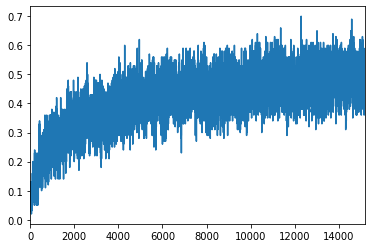

In [21]:
from ray.tune import trial

print("Best config is", analysis.get_best_config(metric="mean_accuracy"))
all_dataframes = analysis.trial_dataframes
df = all_dataframes[analysis.get_best_logdir(metric="mean_accuracy")]
# trial = analysis.trials[3]

# analysis.trial_dataframes[trial.logdir].mean_accuracy.plot()

df.mean_accuracy.plot()

In [18]:
from ray import tune
from ray.tune import track
import numpy as np
import random

n_iters = 100000
print_every = 5000
plot_every = 1000

def evaluate(line_tensor, model):
    hidden = model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    
    return output

def test(model):
    confusion = torch.zeros(n_categories, n_categories, device=device)
    n_confusion = 100

    num_correct = 0
    total = 0



    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = random_training_pair()
        output = evaluate(line_tensor, model)
        guess, guess_i = category_from_output(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
        if category_i == guess_i:
            num_correct += 1
        total += 1
    print(num_correct, total)
    return num_correct/total

def train(model, category_tensor, line_tensor, optimizer, counter):
    model.zero_grad()
    hidden = model.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    if counter % print_every == 0:
        print('%d %d%% (%s)' % (counter, counter / n_iters * 100, loss.item()))
    return output, loss.item()

# def tune_train(config):
#     track.init()
#     model = RNN(n_letters, config["n_hidden"], n_categories)
#     optimizer = torch.optim.SGD(
#         model.parameters(), lr=config["lr"], momentum=config["momentum"])
#     for i in range(n_iters):
#         category, line, category_tensor, line_tensor = random_training_pair()
#         train(model,category_tensor, line_tensor, optimizer, i)
#     acc = test(model)
#     track.log(mean_accuracy=acc)
#     return {"mean_accuracy": acc}


def tune_train(config):
    track.init()
    model = RNN(n_letters, config["n_hidden"], n_categories)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["lr"])
    for i in range(n_iters):
        category, line, category_tensor, line_tensor = random_training_pair()
        train(model,category_tensor, line_tensor, optimizer, i)

    acc = test(model)
    track.log(mean_accuracy=acc)
    return {"mean_accuracy": acc}



search_space = {
    "lr": tune.sample_from(lambda spec: 0.0001 * random.randint(1,50)),
    "n_hidden" : tune.sample_from(lambda spec: random.randint(100,300))
}

analysis = tune.run(tune_train, num_samples=10, scheduler=pbt_scheduler)

2019-09-03 05:59:51,989	INFO function_runner.py:254 -- tune.track signature detected.
2019-09-03 05:59:52,211	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/48 CPUs, 0/8 GPUs, 0.0/113.28 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 175.4/251.8 GiB



2019-09-03 05:59:52,452	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/48 CPUs, 0/8 GPUs, 0.0/113.28 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 175.4/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/tune_train
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - tune_train_1_lr=0.0036,n_hidden=201:	PENDING
 - tune_train_2_lr=0.0023,n_hidden=132:	PENDING
 - tune_train_3_lr=0.0046,n_hidden=150:	PENDING
 - tune_train_4_lr=0.0003,n_hidden=121:	PENDING
 - tune_train_5_lr=0.0046,n_hidden=266:	PENDING
 - tune_train_6_lr=0.0029,n_hidden=129:	PENDING
 - tune_train_7_lr=0.0041,n_hidden=268:	PENDING
 - tune_train_8_lr=0.0013,n_hidden=244:	PENDING
 - tune_train_9_lr=0.002,n_hidden=103:	PENDING
RUNNING trials:
 - tune_train_0_lr=0.0009,n_hidden=124:	RUNNING



2019-09-03 05:59:52,638	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03 05:59:52,824	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03 05:59:53,069	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03 05:59:53,268	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03 05:59:53,466	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03 05:59:53,674	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.
2019-09-03

(pid=6242) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6214) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2019-09-03 05:59:54,095	INFO logger.py:201 -- Initializing TFLogger instead of TF2Logger. We recommend migrating to TF2.0. This class will be removed in the future.


(pid=6209) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6242) 0 0% (2.8961093425750732)
(pid=6214) 0 0% (2.9864628314971924)
(pid=6230) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6209) 0 0% (2.952461004257202)
(pid=6225) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6210) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6230) 0 0% (2.756242275238037)
(pid=6222) <string>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(pid=6225) 0 0% (2.9684910774230957)
(pid=6250) <string>:20: UserWarning: Implicit dimension choice for log_s

Result for tune_train_0_lr=0.0009,n_hidden=124:
  date: 2019-09-03_07-01-37
  done: false
  experiment_id: 1b6cf2646c864f7fb1904793c62fe7fa
  hostname: steropes
  iterations_since_restore: 1
  mean_accuracy: 0.51
  node_ip: 169.229.49.254
  pid: 6242
  time_since_restore: 3703.4761900901794
  time_this_iter_s: 3703.4761900901794
  time_total_s: 3703.4761900901794
  timestamp: 1567519297
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: b7fb6fc4
  
(pid=6242) 51 100
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/48 CPUs, 0/8 GPUs, 0.0/113.28 GiB heap, 0.0/12.84 GiB objects
Memory usage on this node: 176.1/251.8 GiB
Result logdir: /home/eecs/rliaw/ray_results/tune_train
Number of trials: 10 ({'RUNNING': 8, 'TERMINATED': 2})
RUNNING trials:
 - tune_train_0_lr=0.0009,n_hidden=124:	RUNNING, [1 CPUs, 0 GPUs], [pid=6242], 3703 s, 0 iter, 0.51 acc
 - tune_train_1_lr=0.0036,n_hidden=201:	RUNNING
 - tune_train_2_lr=0.0023,n_hidden=132:	RUNNING
 - tune_train_3

(pid=6250) 35000 35% (33044.375)
(pid=6253) 35000 35% (16.516651153564453)
(pid=6210) 35000 35% (62194409472.0)
(pid=6214) 40000 40% (22657.099609375)


2019-09-03 10:05:16,971	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2019-09-03 10:05:16,973	ERROR worker.py:1699 -- print_logs: Connection closed by server.
2019-09-03 10:05:16,979	ERROR worker.py:1799 -- listen_error_messages_raylet: Connection closed by server.


KeyboardInterrupt: 

# Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [17]:
import time
import math

learning_rate = 0.005
torch.optim.SGD(rnn.parameters(), lr=learning_rate)
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.7940 Neil / Chinese ✗ (Irish)
10000 10% (0m 14s) 2.7166 O'Kelly / English ✗ (Irish)
15000 15% (0m 23s) 1.1694 Vescovi / Italian ✓
20000 20% (0m 31s) 2.1433 Mikhailjants / Greek ✗ (Russian)
25000 25% (0m 40s) 2.0299 Planick / Russian ✗ (Czech)
30000 30% (0m 48s) 1.9862 Cabral / French ✗ (Portuguese)
35000 35% (0m 55s) 1.5634 Espina / Spanish ✓
40000 40% (1m 5s) 3.8602 MaxaB / Arabic ✗ (Czech)
45000 45% (1m 13s) 3.5599 Sandoval / Dutch ✗ (Spanish)
50000 50% (1m 20s) 1.3855 Brown / Scottish ✓
55000 55% (1m 27s) 1.6269 Reid / French ✗ (Scottish)
60000 60% (1m 35s) 0.4495 Kijek / Polish ✓
65000 65% (1m 43s) 1.0269 Young / Scottish ✓
70000 70% (1m 50s) 1.9761 Fischer / English ✗ (German)
75000 75% (1m 57s) 0.7915 Rudaski / Polish ✓
80000 80% (2m 5s) 1.7026 Farina / Portuguese ✗ (Italian)
85000 85% (2m 12s) 0.1878 Bakkarevich / Russian ✓
90000 90% (2m 19s) 0.1211 Pasternack / Polish ✓
95000 95% (2m 25s) 0.6084 Otani / Japanese ✓
100000 100% (2m 33s) 0.2713 Alesini / Italian 

# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

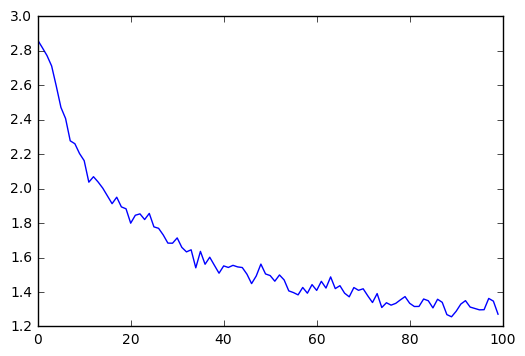

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

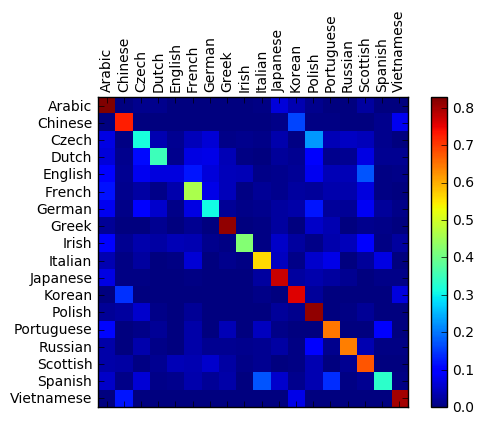

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories, device=device)
n_confusion = 10000

# Just return an output given a line
# def evaluate(line_tensor):
#     hidden = rnn.init_hidden()
    
#     for i in range(line_tensor.size()[0]):
#         output, hidden = rnn(line_tensor[i], hidden)
    
#     return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [20]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.87) Czech
(-0.88) Russian
(-2.44) Polish

> Jackson
(-0.74) Scottish
(-2.03) English
(-2.21) Polish

> Satoshi
(-0.77) Arabic
(-1.35) Japanese
(-1.81) Polish


The final versions of the scripts [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) split the above code into a few files:

* `data.py` (loads files)
* `model.py` (defines the RNN)
* `train.py` (runs training)
* `predict.py` (runs `predict()` with command line arguments)
* `server.py` (serve prediction as a JSON API with bottle.py)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions: 

```
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit http://localhost:5533/Yourname to get JSON output of predictions.

# Exercises

* Try with a different dataset of line -> category, for example:
    * Any word -> language
    * First name -> gender
    * Character name -> writer
    * Page title -> blog or subreddit
* Get better results with a bigger and/or better shaped network
    * Add more linear layers
    * Try the `nn.LSTM` and `nn.GRU` layers
    * Combine multiple of these RNNs as a higher level network

**Next**: [Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)